<a href="https://colab.research.google.com/github/rajagopalmotivate/DeepLearnIITMA1/blob/master/DCGAN_Mnist_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras.optimizers import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def load_data():
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    return X_train

In [0]:
def build_generator(noise_shape=(100,)):
    input = Input(noise_shape)
    x = Dense(128 * 7 * 7, activation="relu")(input)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(1, kernel_size=3, padding="same")(x)
    out = Activation("tanh")(x)
    model = Model(input, out)
    print("-- Generator -- ")
    model.summary()
    return model

In [0]:
def build_discriminator(img_shape):
    input = Input(img_shape)
    x =Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)))(x)
    x = (LeakyReLU(alpha=0.2))(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(input, out)
    print("-- Discriminator -- ")
    model.summary()
    return model

In [0]:
def train(generator, discriminator, combined, epochs=2000, batch_size=128, save_interval=50):

    X_train = load_data()

    num_examples = X_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
    print('Number of examples: ', num_examples)
    print('Number of Batches: ', num_batches)
    print('Number of epochs: ', epochs)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs + 1):
        for batch in range(num_batches):

            # noise images for the batch
            noise = np.random.normal(0, 1, (half_batch, 100))
            fake_images = generator.predict(noise)
            fake_labels = np.zeros((half_batch, 1))

            # real images for batch
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images = X_train[idx]
            real_labels = np.ones((half_batch, 1))

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print("Epoch %d Batch %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch,batch, num_batches, d_loss[0], 100 * d_loss[1], g_loss))

            if batch % 50 == 0:
                save_imgs(generator, epoch, batch)





In [0]:
def save_imgs(generator, epoch, batch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    ##fig.savefig("images/mnist_%d_%d.png" % (epoch, batch))
    plt.show()
    plt.close()

In [0]:
def build_models():

    gen_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_optimizer = Adam(lr=0.0002, beta_1=0.5)


    discriminator = build_discriminator(img_shape=(28, 28, 1))
    discriminator.compile(loss='binary_crossentropy',
                               optimizer=disc_optimizer,
                               metrics=['accuracy'])

    generator = build_generator()
    generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

    z = Input(shape=(100,))
    img = generator(z)
    discriminator.trainable = False
    real = discriminator(img)
    combined = Model(z, real)
    combined.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
    return generator, discriminator, combined

In [0]:
def main():
    generator, discriminator, combined = build_models()

    train(generator, discriminator, combined,
          epochs=100, batch_size=32, save_interval=1)

-- Discriminator -- 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 0 Batch 0/1875 [D loss: 0.897386, acc.: 43.75%] [G loss: 0.766765]


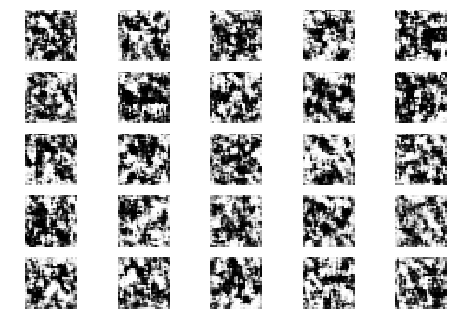

Epoch 0 Batch 1/1875 [D loss: 0.601496, acc.: 71.88%] [G loss: 0.631010]
Epoch 0 Batch 2/1875 [D loss: 0.718113, acc.: 59.38%] [G loss: 0.922297]
Epoch 0 Batch 3/1875 [D loss: 0.463987, acc.: 78.12%] [G loss: 0.966846]
Epoch 0 Batch 4/1875 [D loss: 0.538756, acc.: 65.62%] [G loss: 1.173902]
Epoch 0 Batch 5/1875 [D loss: 0.432308, acc.: 81.25%] [G loss: 1.041538]
Epoch 0 Batch 6/1875 [D loss: 0.388307, acc.: 90.62%] [G loss: 1.397034]
Epoch 0 Batch 7/1875 [D loss: 0.367625, acc.: 84.38%] [G loss: 1.293819]
Epoch 0 Batch 8/1875 [D loss: 0.344112, acc.: 93.75%] [G loss: 1.654612]
Epoch 0 Batch 9/1875 [D loss: 0.286051, acc.: 90.62%] [G loss: 1.384584]
Epoch 0 Batch 10/1875 [D loss: 0.382896, acc.: 84.38%] [G loss: 1.629426]
Epoch 0 Batch 11/1875 [D loss: 0.432951, acc.: 78.12%] [G loss: 1.554762]
Epoch 0 Batch 12/1875 [D loss: 0.228624, acc.: 93.75%] [G loss: 1.747231]
Epoch 0 Batch 13/1875 [D loss: 0.346373, acc.: 84.38%] [G loss: 1.776551]
Epoch 0 Batch 14/1875 [D loss: 0.270585, acc.: 

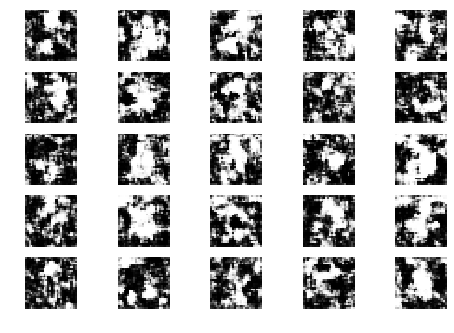

Epoch 0 Batch 51/1875 [D loss: 0.077010, acc.: 100.00%] [G loss: 3.763432]
Epoch 0 Batch 52/1875 [D loss: 0.060333, acc.: 100.00%] [G loss: 3.659831]
Epoch 0 Batch 53/1875 [D loss: 0.061141, acc.: 100.00%] [G loss: 4.216278]
Epoch 0 Batch 54/1875 [D loss: 0.028895, acc.: 100.00%] [G loss: 3.647384]
Epoch 0 Batch 55/1875 [D loss: 0.072466, acc.: 100.00%] [G loss: 3.388518]
Epoch 0 Batch 56/1875 [D loss: 0.085886, acc.: 96.88%] [G loss: 3.035370]
Epoch 0 Batch 57/1875 [D loss: 0.106654, acc.: 100.00%] [G loss: 3.719918]
Epoch 0 Batch 58/1875 [D loss: 0.072870, acc.: 100.00%] [G loss: 4.488157]
Epoch 0 Batch 59/1875 [D loss: 0.110406, acc.: 96.88%] [G loss: 3.338905]
Epoch 0 Batch 60/1875 [D loss: 0.044154, acc.: 100.00%] [G loss: 3.045511]
Epoch 0 Batch 61/1875 [D loss: 0.024584, acc.: 100.00%] [G loss: 2.893834]
Epoch 0 Batch 62/1875 [D loss: 0.088512, acc.: 100.00%] [G loss: 3.525994]
Epoch 0 Batch 63/1875 [D loss: 0.065217, acc.: 100.00%] [G loss: 3.424592]
Epoch 0 Batch 64/1875 [D lo

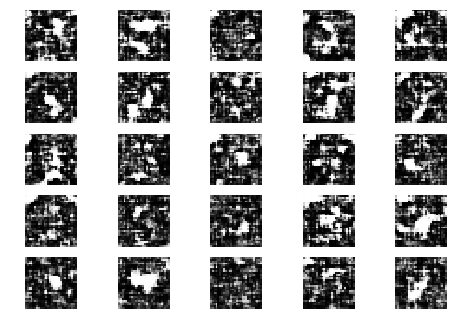

Epoch 0 Batch 101/1875 [D loss: 0.029736, acc.: 100.00%] [G loss: 4.363630]
Epoch 0 Batch 102/1875 [D loss: 0.275285, acc.: 90.62%] [G loss: 4.331826]
Epoch 0 Batch 103/1875 [D loss: 0.053766, acc.: 100.00%] [G loss: 4.467314]
Epoch 0 Batch 104/1875 [D loss: 0.154522, acc.: 93.75%] [G loss: 3.866333]
Epoch 0 Batch 105/1875 [D loss: 0.121436, acc.: 96.88%] [G loss: 4.631786]
Epoch 0 Batch 106/1875 [D loss: 0.244261, acc.: 90.62%] [G loss: 3.919052]
Epoch 0 Batch 107/1875 [D loss: 0.221399, acc.: 87.50%] [G loss: 4.919570]
Epoch 0 Batch 108/1875 [D loss: 0.335438, acc.: 87.50%] [G loss: 2.018235]
Epoch 0 Batch 109/1875 [D loss: 0.292656, acc.: 87.50%] [G loss: 4.177430]
Epoch 0 Batch 110/1875 [D loss: 0.116175, acc.: 100.00%] [G loss: 4.699919]
Epoch 0 Batch 111/1875 [D loss: 0.061792, acc.: 100.00%] [G loss: 4.066740]
Epoch 0 Batch 112/1875 [D loss: 0.369112, acc.: 78.12%] [G loss: 3.580043]
Epoch 0 Batch 113/1875 [D loss: 0.153410, acc.: 90.62%] [G loss: 4.332935]
Epoch 0 Batch 114/187

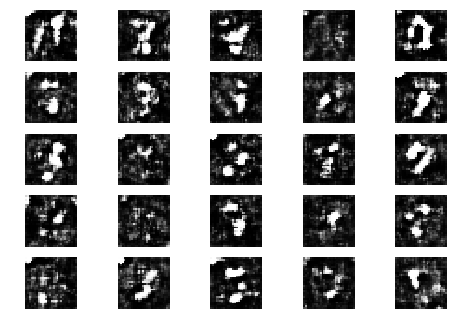

Epoch 0 Batch 151/1875 [D loss: 0.163557, acc.: 93.75%] [G loss: 3.432007]
Epoch 0 Batch 152/1875 [D loss: 0.385003, acc.: 84.38%] [G loss: 4.656651]
Epoch 0 Batch 153/1875 [D loss: 0.191254, acc.: 93.75%] [G loss: 3.899243]
Epoch 0 Batch 154/1875 [D loss: 0.598485, acc.: 68.75%] [G loss: 2.947596]
Epoch 0 Batch 155/1875 [D loss: 1.201987, acc.: 50.00%] [G loss: 3.876611]
Epoch 0 Batch 156/1875 [D loss: 0.480217, acc.: 84.38%] [G loss: 4.606959]
Epoch 0 Batch 157/1875 [D loss: 0.766424, acc.: 59.38%] [G loss: 2.406753]
Epoch 0 Batch 158/1875 [D loss: 0.443554, acc.: 84.38%] [G loss: 4.333804]
Epoch 0 Batch 159/1875 [D loss: 0.349976, acc.: 87.50%] [G loss: 2.771123]
Epoch 0 Batch 160/1875 [D loss: 0.551101, acc.: 68.75%] [G loss: 1.760149]
Epoch 0 Batch 161/1875 [D loss: 0.365011, acc.: 81.25%] [G loss: 3.346868]
Epoch 0 Batch 162/1875 [D loss: 1.096482, acc.: 46.88%] [G loss: 4.019651]
Epoch 0 Batch 163/1875 [D loss: 1.226979, acc.: 40.62%] [G loss: 1.890356]
Epoch 0 Batch 164/1875 [D

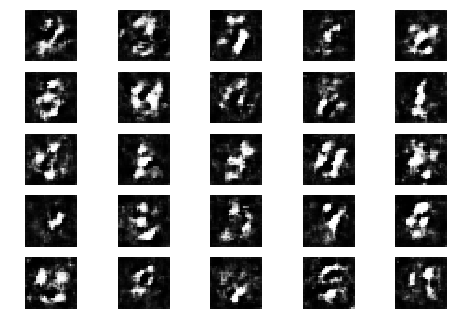

Epoch 0 Batch 201/1875 [D loss: 0.944068, acc.: 53.12%] [G loss: 2.001915]
Epoch 0 Batch 202/1875 [D loss: 0.970866, acc.: 40.62%] [G loss: 1.608327]
Epoch 0 Batch 203/1875 [D loss: 1.050820, acc.: 46.88%] [G loss: 1.617320]
Epoch 0 Batch 204/1875 [D loss: 0.824661, acc.: 50.00%] [G loss: 1.730641]
Epoch 0 Batch 205/1875 [D loss: 0.515233, acc.: 71.88%] [G loss: 2.181136]
Epoch 0 Batch 206/1875 [D loss: 0.856273, acc.: 56.25%] [G loss: 1.736191]
Epoch 0 Batch 207/1875 [D loss: 0.770893, acc.: 56.25%] [G loss: 1.994548]
Epoch 0 Batch 208/1875 [D loss: 0.964853, acc.: 40.62%] [G loss: 1.690219]
Epoch 0 Batch 209/1875 [D loss: 0.698860, acc.: 78.12%] [G loss: 2.024703]
Epoch 0 Batch 210/1875 [D loss: 0.934979, acc.: 50.00%] [G loss: 2.026198]
Epoch 0 Batch 211/1875 [D loss: 1.229526, acc.: 40.62%] [G loss: 1.311812]
Epoch 0 Batch 212/1875 [D loss: 0.916216, acc.: 56.25%] [G loss: 1.755507]
Epoch 0 Batch 213/1875 [D loss: 0.899435, acc.: 50.00%] [G loss: 1.507910]
Epoch 0 Batch 214/1875 [D

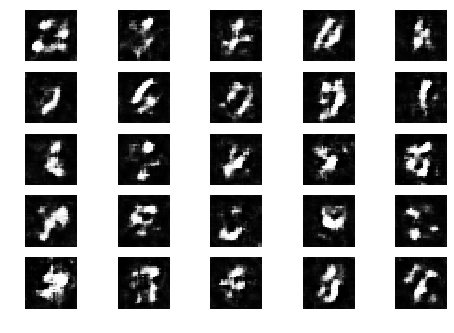

Epoch 0 Batch 251/1875 [D loss: 0.802325, acc.: 50.00%] [G loss: 1.377326]
Epoch 0 Batch 252/1875 [D loss: 0.921414, acc.: 50.00%] [G loss: 1.633158]
Epoch 0 Batch 253/1875 [D loss: 0.650206, acc.: 65.62%] [G loss: 1.316597]
Epoch 0 Batch 254/1875 [D loss: 0.553711, acc.: 71.88%] [G loss: 1.344925]
Epoch 0 Batch 255/1875 [D loss: 0.638776, acc.: 65.62%] [G loss: 1.291317]
Epoch 0 Batch 256/1875 [D loss: 0.577130, acc.: 75.00%] [G loss: 1.831588]
Epoch 0 Batch 257/1875 [D loss: 1.025853, acc.: 56.25%] [G loss: 1.289417]
Epoch 0 Batch 258/1875 [D loss: 1.088320, acc.: 37.50%] [G loss: 1.491921]
Epoch 0 Batch 259/1875 [D loss: 0.612023, acc.: 65.62%] [G loss: 1.616138]
Epoch 0 Batch 260/1875 [D loss: 0.713291, acc.: 62.50%] [G loss: 1.408643]
Epoch 0 Batch 261/1875 [D loss: 0.763311, acc.: 53.12%] [G loss: 1.984875]
Epoch 0 Batch 262/1875 [D loss: 0.873152, acc.: 50.00%] [G loss: 1.348832]
Epoch 0 Batch 263/1875 [D loss: 0.563484, acc.: 75.00%] [G loss: 1.330406]
Epoch 0 Batch 264/1875 [D

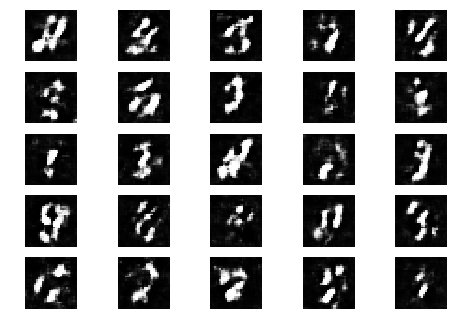

Epoch 0 Batch 301/1875 [D loss: 0.649824, acc.: 62.50%] [G loss: 1.652080]
Epoch 0 Batch 302/1875 [D loss: 0.805468, acc.: 62.50%] [G loss: 1.137913]
Epoch 0 Batch 303/1875 [D loss: 0.855655, acc.: 59.38%] [G loss: 1.333248]
Epoch 0 Batch 304/1875 [D loss: 1.026875, acc.: 43.75%] [G loss: 1.415641]
Epoch 0 Batch 305/1875 [D loss: 0.967230, acc.: 43.75%] [G loss: 1.903427]
Epoch 0 Batch 306/1875 [D loss: 0.740616, acc.: 56.25%] [G loss: 1.408343]
Epoch 0 Batch 307/1875 [D loss: 0.797713, acc.: 50.00%] [G loss: 1.590987]
Epoch 0 Batch 308/1875 [D loss: 0.753263, acc.: 56.25%] [G loss: 1.468356]
Epoch 0 Batch 309/1875 [D loss: 0.520083, acc.: 75.00%] [G loss: 1.724372]
Epoch 0 Batch 310/1875 [D loss: 0.876848, acc.: 40.62%] [G loss: 1.302669]
Epoch 0 Batch 311/1875 [D loss: 0.812398, acc.: 59.38%] [G loss: 1.356666]
Epoch 0 Batch 312/1875 [D loss: 0.571006, acc.: 65.62%] [G loss: 1.423444]
Epoch 0 Batch 313/1875 [D loss: 0.684181, acc.: 62.50%] [G loss: 1.535640]
Epoch 0 Batch 314/1875 [D

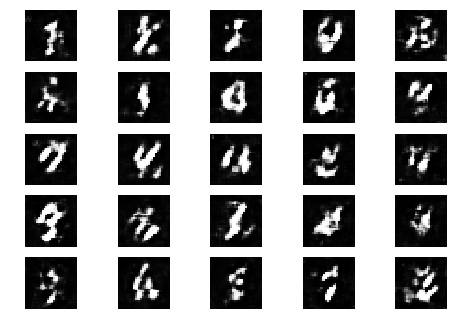

Epoch 0 Batch 351/1875 [D loss: 0.585298, acc.: 71.88%] [G loss: 1.477402]
Epoch 0 Batch 352/1875 [D loss: 0.808869, acc.: 56.25%] [G loss: 1.385565]
Epoch 0 Batch 353/1875 [D loss: 1.043949, acc.: 40.62%] [G loss: 1.143023]
Epoch 0 Batch 354/1875 [D loss: 0.745654, acc.: 59.38%] [G loss: 1.341724]
Epoch 0 Batch 355/1875 [D loss: 0.847583, acc.: 46.88%] [G loss: 1.280000]
Epoch 0 Batch 356/1875 [D loss: 0.896817, acc.: 40.62%] [G loss: 1.333099]
Epoch 0 Batch 357/1875 [D loss: 0.586214, acc.: 71.88%] [G loss: 1.583109]
Epoch 0 Batch 358/1875 [D loss: 0.748965, acc.: 62.50%] [G loss: 1.395095]
Epoch 0 Batch 359/1875 [D loss: 0.574395, acc.: 65.62%] [G loss: 1.323467]
Epoch 0 Batch 360/1875 [D loss: 0.814143, acc.: 59.38%] [G loss: 1.142432]
Epoch 0 Batch 361/1875 [D loss: 0.515911, acc.: 65.62%] [G loss: 1.317202]
Epoch 0 Batch 362/1875 [D loss: 0.949566, acc.: 37.50%] [G loss: 1.032144]
Epoch 0 Batch 363/1875 [D loss: 0.886331, acc.: 53.12%] [G loss: 1.760736]
Epoch 0 Batch 364/1875 [D

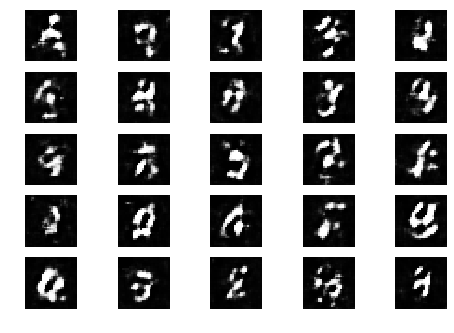

Epoch 0 Batch 401/1875 [D loss: 0.670171, acc.: 65.62%] [G loss: 1.345857]
Epoch 0 Batch 402/1875 [D loss: 0.839307, acc.: 56.25%] [G loss: 1.066056]
Epoch 0 Batch 403/1875 [D loss: 1.029279, acc.: 50.00%] [G loss: 1.438979]
Epoch 0 Batch 404/1875 [D loss: 0.887124, acc.: 50.00%] [G loss: 1.497270]
Epoch 0 Batch 405/1875 [D loss: 0.725722, acc.: 65.62%] [G loss: 1.303282]
Epoch 0 Batch 406/1875 [D loss: 0.754014, acc.: 50.00%] [G loss: 1.060368]
Epoch 0 Batch 407/1875 [D loss: 0.789756, acc.: 56.25%] [G loss: 1.225430]
Epoch 0 Batch 408/1875 [D loss: 0.690135, acc.: 56.25%] [G loss: 1.144199]
Epoch 0 Batch 409/1875 [D loss: 0.860460, acc.: 46.88%] [G loss: 1.205285]
Epoch 0 Batch 410/1875 [D loss: 0.680870, acc.: 56.25%] [G loss: 1.354100]
Epoch 0 Batch 411/1875 [D loss: 0.634120, acc.: 59.38%] [G loss: 1.133710]
Epoch 0 Batch 412/1875 [D loss: 0.770673, acc.: 53.12%] [G loss: 1.451268]
Epoch 0 Batch 413/1875 [D loss: 0.870556, acc.: 40.62%] [G loss: 1.286706]
Epoch 0 Batch 414/1875 [D

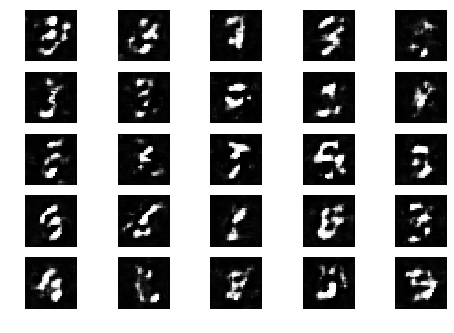

Epoch 0 Batch 451/1875 [D loss: 0.633788, acc.: 71.88%] [G loss: 1.323070]
Epoch 0 Batch 452/1875 [D loss: 0.949644, acc.: 53.12%] [G loss: 1.499841]
Epoch 0 Batch 453/1875 [D loss: 0.801691, acc.: 40.62%] [G loss: 1.275972]
Epoch 0 Batch 454/1875 [D loss: 0.543806, acc.: 75.00%] [G loss: 1.216536]
Epoch 0 Batch 455/1875 [D loss: 0.768730, acc.: 53.12%] [G loss: 1.091319]
Epoch 0 Batch 456/1875 [D loss: 0.514532, acc.: 68.75%] [G loss: 1.330992]
Epoch 0 Batch 457/1875 [D loss: 0.701036, acc.: 56.25%] [G loss: 1.138717]
Epoch 0 Batch 458/1875 [D loss: 0.614479, acc.: 59.38%] [G loss: 1.219703]
Epoch 0 Batch 459/1875 [D loss: 0.843266, acc.: 43.75%] [G loss: 1.160288]
Epoch 0 Batch 460/1875 [D loss: 0.762109, acc.: 65.62%] [G loss: 1.274690]
Epoch 0 Batch 461/1875 [D loss: 0.721026, acc.: 56.25%] [G loss: 1.287784]
Epoch 0 Batch 462/1875 [D loss: 0.809143, acc.: 53.12%] [G loss: 1.251527]
Epoch 0 Batch 463/1875 [D loss: 0.745754, acc.: 56.25%] [G loss: 1.097025]
Epoch 0 Batch 464/1875 [D

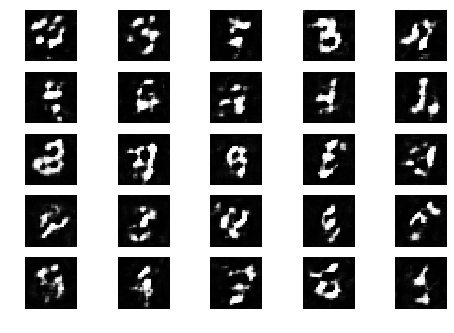

Epoch 0 Batch 501/1875 [D loss: 0.864285, acc.: 56.25%] [G loss: 1.233889]
Epoch 0 Batch 502/1875 [D loss: 0.602565, acc.: 62.50%] [G loss: 1.011048]
Epoch 0 Batch 503/1875 [D loss: 0.649842, acc.: 75.00%] [G loss: 1.209161]
Epoch 0 Batch 504/1875 [D loss: 0.646104, acc.: 62.50%] [G loss: 1.102395]
Epoch 0 Batch 505/1875 [D loss: 0.760871, acc.: 62.50%] [G loss: 1.010563]
Epoch 0 Batch 506/1875 [D loss: 0.552144, acc.: 75.00%] [G loss: 1.324133]
Epoch 0 Batch 507/1875 [D loss: 0.634855, acc.: 68.75%] [G loss: 1.465910]
Epoch 0 Batch 508/1875 [D loss: 0.777055, acc.: 40.62%] [G loss: 1.277159]
Epoch 0 Batch 509/1875 [D loss: 0.817718, acc.: 53.12%] [G loss: 1.236305]
Epoch 0 Batch 510/1875 [D loss: 0.672761, acc.: 68.75%] [G loss: 1.317576]
Epoch 0 Batch 511/1875 [D loss: 0.810502, acc.: 43.75%] [G loss: 1.480994]
Epoch 0 Batch 512/1875 [D loss: 0.662510, acc.: 56.25%] [G loss: 1.431909]
Epoch 0 Batch 513/1875 [D loss: 0.574953, acc.: 75.00%] [G loss: 1.277177]
Epoch 0 Batch 514/1875 [D

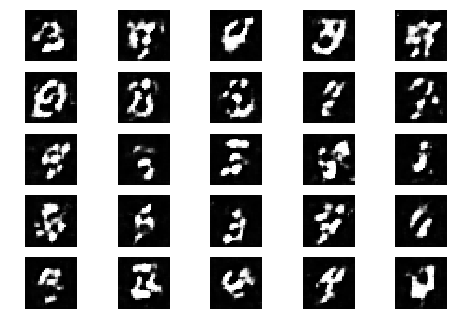

Epoch 0 Batch 551/1875 [D loss: 0.465728, acc.: 81.25%] [G loss: 1.148583]
Epoch 0 Batch 552/1875 [D loss: 0.543132, acc.: 71.88%] [G loss: 1.114698]
Epoch 0 Batch 553/1875 [D loss: 0.802294, acc.: 50.00%] [G loss: 1.297822]
Epoch 0 Batch 554/1875 [D loss: 0.764736, acc.: 53.12%] [G loss: 0.880230]
Epoch 0 Batch 555/1875 [D loss: 0.542980, acc.: 71.88%] [G loss: 1.121477]
Epoch 0 Batch 556/1875 [D loss: 0.841728, acc.: 53.12%] [G loss: 1.179947]
Epoch 0 Batch 557/1875 [D loss: 0.618776, acc.: 71.88%] [G loss: 1.508220]
Epoch 0 Batch 558/1875 [D loss: 0.633412, acc.: 53.12%] [G loss: 1.409514]
Epoch 0 Batch 559/1875 [D loss: 0.851696, acc.: 59.38%] [G loss: 0.959802]
Epoch 0 Batch 560/1875 [D loss: 0.602910, acc.: 65.62%] [G loss: 1.095715]
Epoch 0 Batch 561/1875 [D loss: 0.553908, acc.: 68.75%] [G loss: 1.318657]
Epoch 0 Batch 562/1875 [D loss: 0.698471, acc.: 46.88%] [G loss: 1.159583]
Epoch 0 Batch 563/1875 [D loss: 0.828835, acc.: 46.88%] [G loss: 1.224313]
Epoch 0 Batch 564/1875 [D

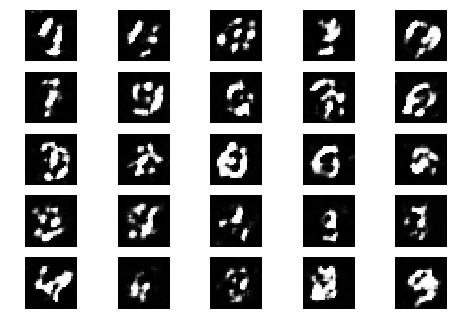

Epoch 0 Batch 601/1875 [D loss: 0.591584, acc.: 68.75%] [G loss: 1.285945]
Epoch 0 Batch 602/1875 [D loss: 0.604765, acc.: 59.38%] [G loss: 1.126270]
Epoch 0 Batch 603/1875 [D loss: 0.576798, acc.: 65.62%] [G loss: 1.084802]
Epoch 0 Batch 604/1875 [D loss: 0.631666, acc.: 65.62%] [G loss: 1.074827]
Epoch 0 Batch 605/1875 [D loss: 0.781407, acc.: 59.38%] [G loss: 1.047484]
Epoch 0 Batch 606/1875 [D loss: 0.554773, acc.: 71.88%] [G loss: 1.131519]
Epoch 0 Batch 607/1875 [D loss: 0.719823, acc.: 50.00%] [G loss: 1.044333]
Epoch 0 Batch 608/1875 [D loss: 0.860440, acc.: 40.62%] [G loss: 0.935086]
Epoch 0 Batch 609/1875 [D loss: 0.527595, acc.: 81.25%] [G loss: 1.386318]
Epoch 0 Batch 610/1875 [D loss: 0.461538, acc.: 75.00%] [G loss: 1.170758]
Epoch 0 Batch 611/1875 [D loss: 0.806686, acc.: 46.88%] [G loss: 0.934048]
Epoch 0 Batch 612/1875 [D loss: 0.562439, acc.: 71.88%] [G loss: 1.238628]
Epoch 0 Batch 613/1875 [D loss: 0.526665, acc.: 71.88%] [G loss: 1.294023]
Epoch 0 Batch 614/1875 [D

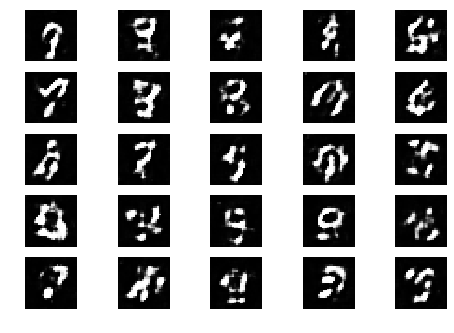

Epoch 0 Batch 651/1875 [D loss: 0.746109, acc.: 46.88%] [G loss: 1.120112]
Epoch 0 Batch 652/1875 [D loss: 0.636687, acc.: 68.75%] [G loss: 1.216005]
Epoch 0 Batch 653/1875 [D loss: 0.616083, acc.: 68.75%] [G loss: 1.330648]
Epoch 0 Batch 654/1875 [D loss: 0.621737, acc.: 62.50%] [G loss: 1.421078]
Epoch 0 Batch 655/1875 [D loss: 0.860648, acc.: 53.12%] [G loss: 1.079462]
Epoch 0 Batch 656/1875 [D loss: 0.641658, acc.: 62.50%] [G loss: 1.029002]
Epoch 0 Batch 657/1875 [D loss: 0.802433, acc.: 56.25%] [G loss: 1.444072]
Epoch 0 Batch 658/1875 [D loss: 0.527247, acc.: 78.12%] [G loss: 1.089330]
Epoch 0 Batch 659/1875 [D loss: 0.712536, acc.: 56.25%] [G loss: 1.156894]
Epoch 0 Batch 660/1875 [D loss: 0.835435, acc.: 50.00%] [G loss: 1.161491]
Epoch 0 Batch 661/1875 [D loss: 0.633588, acc.: 68.75%] [G loss: 0.887628]
Epoch 0 Batch 662/1875 [D loss: 0.814181, acc.: 46.88%] [G loss: 1.033111]
Epoch 0 Batch 663/1875 [D loss: 0.428323, acc.: 87.50%] [G loss: 1.110284]
Epoch 0 Batch 664/1875 [D

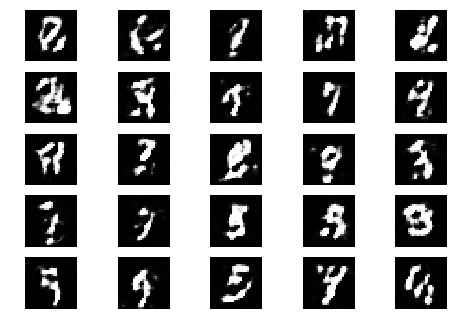

Epoch 0 Batch 701/1875 [D loss: 0.814746, acc.: 50.00%] [G loss: 1.107272]
Epoch 0 Batch 702/1875 [D loss: 0.580495, acc.: 78.12%] [G loss: 1.025523]
Epoch 0 Batch 703/1875 [D loss: 0.693084, acc.: 65.62%] [G loss: 1.167452]
Epoch 0 Batch 704/1875 [D loss: 0.801825, acc.: 50.00%] [G loss: 1.322885]
Epoch 0 Batch 705/1875 [D loss: 0.587447, acc.: 65.62%] [G loss: 1.095922]
Epoch 0 Batch 706/1875 [D loss: 0.585152, acc.: 62.50%] [G loss: 0.994214]
Epoch 0 Batch 707/1875 [D loss: 0.621443, acc.: 50.00%] [G loss: 1.271566]
Epoch 0 Batch 708/1875 [D loss: 0.735840, acc.: 59.38%] [G loss: 1.380113]
Epoch 0 Batch 709/1875 [D loss: 0.631606, acc.: 59.38%] [G loss: 1.046016]
Epoch 0 Batch 710/1875 [D loss: 0.485569, acc.: 78.12%] [G loss: 1.274308]
Epoch 0 Batch 711/1875 [D loss: 0.693037, acc.: 62.50%] [G loss: 1.064502]
Epoch 0 Batch 712/1875 [D loss: 0.657780, acc.: 56.25%] [G loss: 1.205130]
Epoch 0 Batch 713/1875 [D loss: 0.633703, acc.: 65.62%] [G loss: 0.892235]
Epoch 0 Batch 714/1875 [D

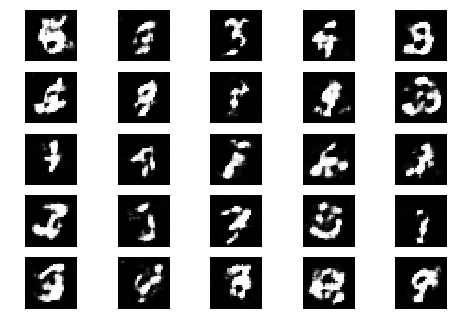

Epoch 0 Batch 751/1875 [D loss: 0.812059, acc.: 46.88%] [G loss: 1.180162]
Epoch 0 Batch 752/1875 [D loss: 0.647287, acc.: 71.88%] [G loss: 1.511801]
Epoch 0 Batch 753/1875 [D loss: 0.648251, acc.: 59.38%] [G loss: 1.127621]
Epoch 0 Batch 754/1875 [D loss: 0.806247, acc.: 46.88%] [G loss: 0.841641]
Epoch 0 Batch 755/1875 [D loss: 0.634246, acc.: 68.75%] [G loss: 1.353279]
Epoch 0 Batch 756/1875 [D loss: 0.668790, acc.: 56.25%] [G loss: 1.190861]
Epoch 0 Batch 757/1875 [D loss: 0.683482, acc.: 62.50%] [G loss: 0.916870]
Epoch 0 Batch 758/1875 [D loss: 0.592386, acc.: 68.75%] [G loss: 0.964111]
Epoch 0 Batch 759/1875 [D loss: 0.667253, acc.: 65.62%] [G loss: 1.135180]
Epoch 0 Batch 760/1875 [D loss: 0.730949, acc.: 46.88%] [G loss: 1.421886]
Epoch 0 Batch 761/1875 [D loss: 0.646599, acc.: 56.25%] [G loss: 1.010433]
Epoch 0 Batch 762/1875 [D loss: 0.705596, acc.: 56.25%] [G loss: 1.490113]
Epoch 0 Batch 763/1875 [D loss: 0.620566, acc.: 71.88%] [G loss: 1.255716]
Epoch 0 Batch 764/1875 [D

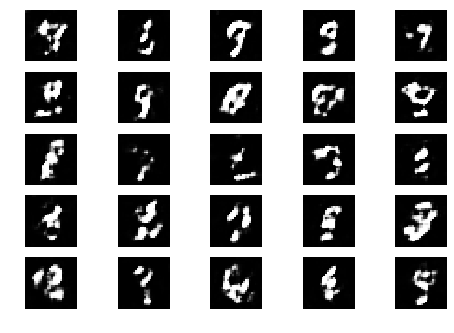

Epoch 0 Batch 801/1875 [D loss: 0.727634, acc.: 62.50%] [G loss: 1.388442]
Epoch 0 Batch 802/1875 [D loss: 0.565626, acc.: 65.62%] [G loss: 1.639093]
Epoch 0 Batch 803/1875 [D loss: 0.743009, acc.: 53.12%] [G loss: 1.270873]
Epoch 0 Batch 804/1875 [D loss: 0.744641, acc.: 46.88%] [G loss: 0.942963]
Epoch 0 Batch 805/1875 [D loss: 0.608776, acc.: 68.75%] [G loss: 1.251365]
Epoch 0 Batch 806/1875 [D loss: 0.798711, acc.: 53.12%] [G loss: 1.325203]
Epoch 0 Batch 807/1875 [D loss: 0.796577, acc.: 46.88%] [G loss: 1.211724]
Epoch 0 Batch 808/1875 [D loss: 0.575872, acc.: 68.75%] [G loss: 1.048370]
Epoch 0 Batch 809/1875 [D loss: 0.617262, acc.: 68.75%] [G loss: 1.156165]
Epoch 0 Batch 810/1875 [D loss: 0.574989, acc.: 68.75%] [G loss: 1.120784]
Epoch 0 Batch 811/1875 [D loss: 0.581658, acc.: 71.88%] [G loss: 1.075904]
Epoch 0 Batch 812/1875 [D loss: 0.862955, acc.: 46.88%] [G loss: 1.255988]
Epoch 0 Batch 813/1875 [D loss: 0.749670, acc.: 50.00%] [G loss: 1.358617]
Epoch 0 Batch 814/1875 [D

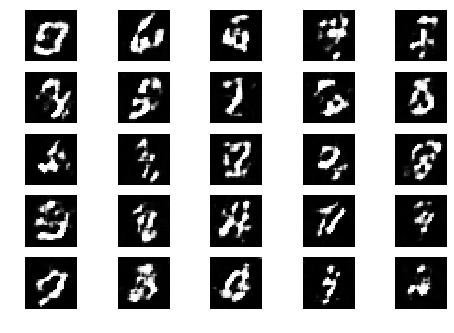

Epoch 0 Batch 851/1875 [D loss: 0.575644, acc.: 65.62%] [G loss: 1.445586]
Epoch 0 Batch 852/1875 [D loss: 0.515624, acc.: 71.88%] [G loss: 1.227841]
Epoch 0 Batch 853/1875 [D loss: 0.679895, acc.: 56.25%] [G loss: 1.209442]
Epoch 0 Batch 854/1875 [D loss: 0.899201, acc.: 40.62%] [G loss: 1.204325]
Epoch 0 Batch 855/1875 [D loss: 0.741283, acc.: 50.00%] [G loss: 1.447609]
Epoch 0 Batch 856/1875 [D loss: 0.546985, acc.: 75.00%] [G loss: 1.554750]
Epoch 0 Batch 857/1875 [D loss: 0.643940, acc.: 59.38%] [G loss: 1.565202]
Epoch 0 Batch 858/1875 [D loss: 0.688186, acc.: 56.25%] [G loss: 1.184325]
Epoch 0 Batch 859/1875 [D loss: 0.660409, acc.: 56.25%] [G loss: 0.838397]
Epoch 0 Batch 860/1875 [D loss: 0.705882, acc.: 53.12%] [G loss: 1.127133]
Epoch 0 Batch 861/1875 [D loss: 0.627747, acc.: 75.00%] [G loss: 1.212987]
Epoch 0 Batch 862/1875 [D loss: 0.696195, acc.: 62.50%] [G loss: 1.289737]
Epoch 0 Batch 863/1875 [D loss: 0.688042, acc.: 46.88%] [G loss: 1.381566]
Epoch 0 Batch 864/1875 [D

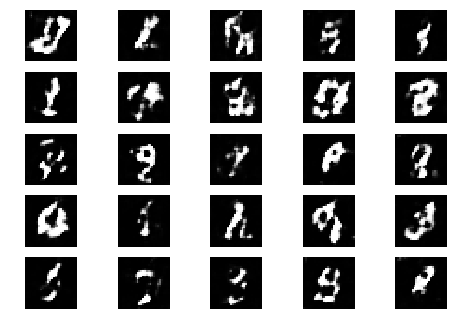

Epoch 0 Batch 901/1875 [D loss: 0.639644, acc.: 62.50%] [G loss: 0.981748]
Epoch 0 Batch 902/1875 [D loss: 0.579414, acc.: 65.62%] [G loss: 0.874899]
Epoch 0 Batch 903/1875 [D loss: 0.587870, acc.: 68.75%] [G loss: 1.162913]
Epoch 0 Batch 904/1875 [D loss: 0.558159, acc.: 75.00%] [G loss: 1.194095]
Epoch 0 Batch 905/1875 [D loss: 0.699092, acc.: 62.50%] [G loss: 1.232568]
Epoch 0 Batch 906/1875 [D loss: 0.897578, acc.: 34.38%] [G loss: 1.163624]
Epoch 0 Batch 907/1875 [D loss: 0.673102, acc.: 62.50%] [G loss: 1.401649]
Epoch 0 Batch 908/1875 [D loss: 0.786621, acc.: 50.00%] [G loss: 1.243484]
Epoch 0 Batch 909/1875 [D loss: 0.755054, acc.: 59.38%] [G loss: 1.090201]
Epoch 0 Batch 910/1875 [D loss: 0.604970, acc.: 68.75%] [G loss: 1.213619]
Epoch 0 Batch 911/1875 [D loss: 0.645488, acc.: 65.62%] [G loss: 1.208677]
Epoch 0 Batch 912/1875 [D loss: 0.551490, acc.: 68.75%] [G loss: 1.190678]
Epoch 0 Batch 913/1875 [D loss: 0.670052, acc.: 68.75%] [G loss: 1.014710]
Epoch 0 Batch 914/1875 [D

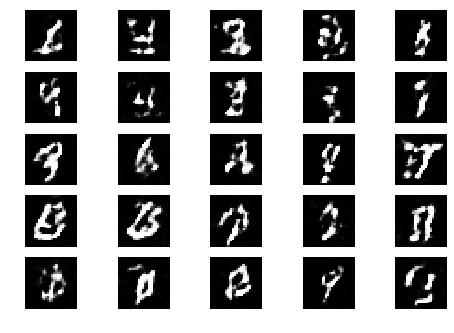

Epoch 0 Batch 951/1875 [D loss: 0.524258, acc.: 65.62%] [G loss: 1.563203]
Epoch 0 Batch 952/1875 [D loss: 0.660003, acc.: 56.25%] [G loss: 0.941766]
Epoch 0 Batch 953/1875 [D loss: 0.502336, acc.: 81.25%] [G loss: 1.174260]
Epoch 0 Batch 954/1875 [D loss: 0.542552, acc.: 75.00%] [G loss: 1.139734]
Epoch 0 Batch 955/1875 [D loss: 0.728141, acc.: 56.25%] [G loss: 1.244049]
Epoch 0 Batch 956/1875 [D loss: 0.711393, acc.: 65.62%] [G loss: 1.362421]
Epoch 0 Batch 957/1875 [D loss: 0.920246, acc.: 34.38%] [G loss: 1.174020]
Epoch 0 Batch 958/1875 [D loss: 0.983215, acc.: 40.62%] [G loss: 1.025973]
Epoch 0 Batch 959/1875 [D loss: 0.811805, acc.: 56.25%] [G loss: 1.209731]
Epoch 0 Batch 960/1875 [D loss: 0.476542, acc.: 84.38%] [G loss: 0.928312]
Epoch 0 Batch 961/1875 [D loss: 0.607621, acc.: 71.88%] [G loss: 1.183808]
Epoch 0 Batch 962/1875 [D loss: 0.688375, acc.: 62.50%] [G loss: 1.099010]
Epoch 0 Batch 963/1875 [D loss: 0.742214, acc.: 56.25%] [G loss: 1.242228]
Epoch 0 Batch 964/1875 [D

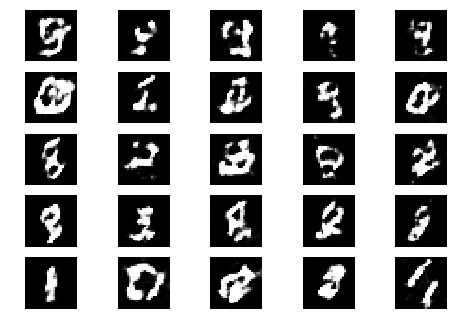

Epoch 0 Batch 1001/1875 [D loss: 0.552230, acc.: 65.62%] [G loss: 1.391809]
Epoch 0 Batch 1002/1875 [D loss: 0.932528, acc.: 31.25%] [G loss: 1.391506]
Epoch 0 Batch 1003/1875 [D loss: 0.673123, acc.: 75.00%] [G loss: 1.473334]
Epoch 0 Batch 1004/1875 [D loss: 0.542380, acc.: 78.12%] [G loss: 1.224345]
Epoch 0 Batch 1005/1875 [D loss: 0.709639, acc.: 59.38%] [G loss: 1.179033]
Epoch 0 Batch 1006/1875 [D loss: 0.534239, acc.: 65.62%] [G loss: 1.137041]
Epoch 0 Batch 1007/1875 [D loss: 0.437181, acc.: 87.50%] [G loss: 1.308618]
Epoch 0 Batch 1008/1875 [D loss: 0.827477, acc.: 50.00%] [G loss: 1.293966]
Epoch 0 Batch 1009/1875 [D loss: 0.670857, acc.: 59.38%] [G loss: 1.018400]
Epoch 0 Batch 1010/1875 [D loss: 0.679918, acc.: 62.50%] [G loss: 1.304869]
Epoch 0 Batch 1011/1875 [D loss: 0.672099, acc.: 65.62%] [G loss: 1.180067]
Epoch 0 Batch 1012/1875 [D loss: 0.533561, acc.: 68.75%] [G loss: 1.290107]
Epoch 0 Batch 1013/1875 [D loss: 0.760686, acc.: 53.12%] [G loss: 0.960031]
Epoch 0 Batc

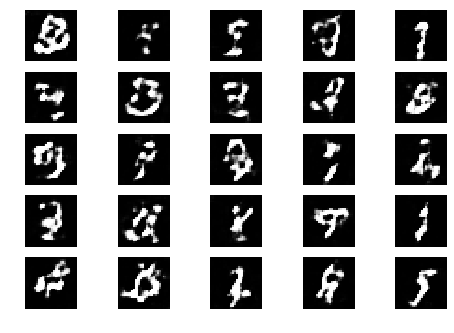

Epoch 0 Batch 1051/1875 [D loss: 0.775219, acc.: 46.88%] [G loss: 1.105530]
Epoch 0 Batch 1052/1875 [D loss: 0.420562, acc.: 90.62%] [G loss: 1.139491]
Epoch 0 Batch 1053/1875 [D loss: 0.793028, acc.: 53.12%] [G loss: 1.054955]
Epoch 0 Batch 1054/1875 [D loss: 0.586104, acc.: 68.75%] [G loss: 0.818109]
Epoch 0 Batch 1055/1875 [D loss: 0.689608, acc.: 65.62%] [G loss: 0.933398]
Epoch 0 Batch 1056/1875 [D loss: 0.593054, acc.: 75.00%] [G loss: 1.090147]
Epoch 0 Batch 1057/1875 [D loss: 0.741311, acc.: 50.00%] [G loss: 1.155445]
Epoch 0 Batch 1058/1875 [D loss: 0.721148, acc.: 46.88%] [G loss: 1.208930]
Epoch 0 Batch 1059/1875 [D loss: 0.607527, acc.: 68.75%] [G loss: 1.344980]
Epoch 0 Batch 1060/1875 [D loss: 0.833938, acc.: 56.25%] [G loss: 1.204884]
Epoch 0 Batch 1061/1875 [D loss: 0.747262, acc.: 56.25%] [G loss: 1.417155]
Epoch 0 Batch 1062/1875 [D loss: 0.766245, acc.: 59.38%] [G loss: 1.137272]
Epoch 0 Batch 1063/1875 [D loss: 0.734640, acc.: 43.75%] [G loss: 1.438484]
Epoch 0 Batc

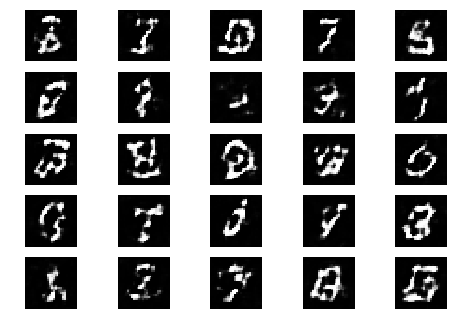

Epoch 0 Batch 1101/1875 [D loss: 0.719629, acc.: 53.12%] [G loss: 1.203524]
Epoch 0 Batch 1102/1875 [D loss: 0.702758, acc.: 53.12%] [G loss: 1.000549]
Epoch 0 Batch 1103/1875 [D loss: 0.739525, acc.: 46.88%] [G loss: 0.976793]
Epoch 0 Batch 1104/1875 [D loss: 0.650935, acc.: 65.62%] [G loss: 1.270103]
Epoch 0 Batch 1105/1875 [D loss: 0.620031, acc.: 59.38%] [G loss: 1.287654]
Epoch 0 Batch 1106/1875 [D loss: 0.661709, acc.: 65.62%] [G loss: 1.174549]
Epoch 0 Batch 1107/1875 [D loss: 0.668097, acc.: 56.25%] [G loss: 1.122662]
Epoch 0 Batch 1108/1875 [D loss: 0.607580, acc.: 65.62%] [G loss: 1.282643]
Epoch 0 Batch 1109/1875 [D loss: 0.868229, acc.: 28.12%] [G loss: 0.913859]
Epoch 0 Batch 1110/1875 [D loss: 0.767130, acc.: 53.12%] [G loss: 1.244209]
Epoch 0 Batch 1111/1875 [D loss: 0.638480, acc.: 59.38%] [G loss: 1.296901]
Epoch 0 Batch 1112/1875 [D loss: 0.683648, acc.: 62.50%] [G loss: 1.274385]
Epoch 0 Batch 1113/1875 [D loss: 0.639381, acc.: 65.62%] [G loss: 1.220127]
Epoch 0 Batc

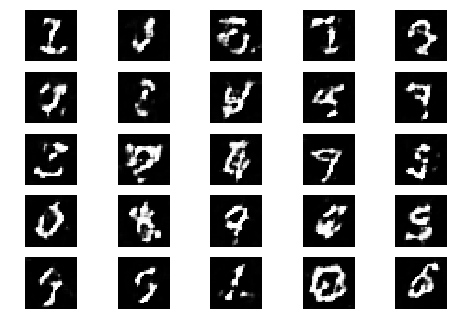

Epoch 0 Batch 1151/1875 [D loss: 0.519109, acc.: 71.88%] [G loss: 1.115111]
Epoch 0 Batch 1152/1875 [D loss: 0.688895, acc.: 53.12%] [G loss: 0.867135]
Epoch 0 Batch 1153/1875 [D loss: 0.862965, acc.: 40.62%] [G loss: 1.203817]
Epoch 0 Batch 1154/1875 [D loss: 0.641991, acc.: 62.50%] [G loss: 1.041615]
Epoch 0 Batch 1155/1875 [D loss: 0.863179, acc.: 43.75%] [G loss: 0.914227]
Epoch 0 Batch 1156/1875 [D loss: 0.648434, acc.: 56.25%] [G loss: 1.156817]
Epoch 0 Batch 1157/1875 [D loss: 0.621818, acc.: 68.75%] [G loss: 1.004595]
Epoch 0 Batch 1158/1875 [D loss: 0.715953, acc.: 62.50%] [G loss: 0.978903]
Epoch 0 Batch 1159/1875 [D loss: 0.842165, acc.: 59.38%] [G loss: 1.067496]
Epoch 0 Batch 1160/1875 [D loss: 0.582010, acc.: 62.50%] [G loss: 1.136025]
Epoch 0 Batch 1161/1875 [D loss: 0.608544, acc.: 71.88%] [G loss: 1.321649]
Epoch 0 Batch 1162/1875 [D loss: 0.658651, acc.: 65.62%] [G loss: 1.306825]
Epoch 0 Batch 1163/1875 [D loss: 0.547823, acc.: 71.88%] [G loss: 1.087978]
Epoch 0 Batc

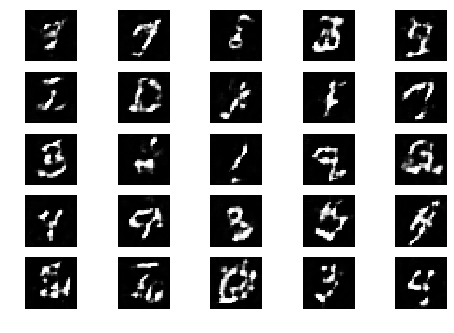

Epoch 0 Batch 1201/1875 [D loss: 0.593800, acc.: 65.62%] [G loss: 1.310479]
Epoch 0 Batch 1202/1875 [D loss: 0.815058, acc.: 46.88%] [G loss: 1.010506]
Epoch 0 Batch 1203/1875 [D loss: 0.535437, acc.: 68.75%] [G loss: 1.137141]
Epoch 0 Batch 1204/1875 [D loss: 0.628734, acc.: 59.38%] [G loss: 1.288174]
Epoch 0 Batch 1205/1875 [D loss: 0.614126, acc.: 68.75%] [G loss: 0.884919]
Epoch 0 Batch 1206/1875 [D loss: 0.676468, acc.: 59.38%] [G loss: 1.195884]
Epoch 0 Batch 1207/1875 [D loss: 0.608338, acc.: 71.88%] [G loss: 1.552628]
Epoch 0 Batch 1208/1875 [D loss: 0.826203, acc.: 53.12%] [G loss: 1.264270]
Epoch 0 Batch 1209/1875 [D loss: 0.656512, acc.: 65.62%] [G loss: 1.354543]
Epoch 0 Batch 1210/1875 [D loss: 0.644094, acc.: 50.00%] [G loss: 1.157933]
Epoch 0 Batch 1211/1875 [D loss: 0.692092, acc.: 56.25%] [G loss: 1.063425]
Epoch 0 Batch 1212/1875 [D loss: 0.522751, acc.: 75.00%] [G loss: 1.096665]
Epoch 0 Batch 1213/1875 [D loss: 0.517770, acc.: 75.00%] [G loss: 1.057920]
Epoch 0 Batc

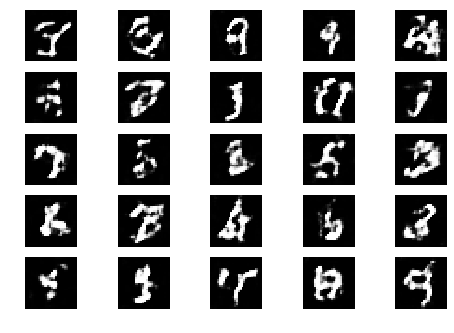

Epoch 0 Batch 1251/1875 [D loss: 0.770993, acc.: 50.00%] [G loss: 1.244650]
Epoch 0 Batch 1252/1875 [D loss: 0.850162, acc.: 50.00%] [G loss: 1.003588]
Epoch 0 Batch 1253/1875 [D loss: 0.534378, acc.: 68.75%] [G loss: 1.184882]
Epoch 0 Batch 1254/1875 [D loss: 0.785423, acc.: 56.25%] [G loss: 1.117679]
Epoch 0 Batch 1255/1875 [D loss: 0.799150, acc.: 50.00%] [G loss: 1.136013]
Epoch 0 Batch 1256/1875 [D loss: 0.807582, acc.: 56.25%] [G loss: 1.027031]
Epoch 0 Batch 1257/1875 [D loss: 0.619123, acc.: 75.00%] [G loss: 0.916331]
Epoch 0 Batch 1258/1875 [D loss: 0.862390, acc.: 40.62%] [G loss: 1.188502]
Epoch 0 Batch 1259/1875 [D loss: 0.703920, acc.: 59.38%] [G loss: 1.191454]
Epoch 0 Batch 1260/1875 [D loss: 0.571612, acc.: 65.62%] [G loss: 1.157541]
Epoch 0 Batch 1261/1875 [D loss: 0.571271, acc.: 68.75%] [G loss: 1.083000]
Epoch 0 Batch 1262/1875 [D loss: 0.634953, acc.: 56.25%] [G loss: 1.106882]
Epoch 0 Batch 1263/1875 [D loss: 0.603185, acc.: 62.50%] [G loss: 1.170842]
Epoch 0 Batc

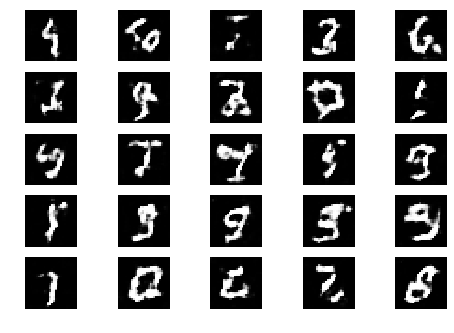

Epoch 0 Batch 1301/1875 [D loss: 0.665538, acc.: 50.00%] [G loss: 1.230828]
Epoch 0 Batch 1302/1875 [D loss: 0.621763, acc.: 68.75%] [G loss: 1.126328]
Epoch 0 Batch 1303/1875 [D loss: 0.591403, acc.: 78.12%] [G loss: 1.178165]
Epoch 0 Batch 1304/1875 [D loss: 0.595279, acc.: 62.50%] [G loss: 1.140803]
Epoch 0 Batch 1305/1875 [D loss: 0.547665, acc.: 75.00%] [G loss: 1.254070]
Epoch 0 Batch 1306/1875 [D loss: 0.789665, acc.: 59.38%] [G loss: 1.155443]
Epoch 0 Batch 1307/1875 [D loss: 0.782933, acc.: 59.38%] [G loss: 0.979891]
Epoch 0 Batch 1308/1875 [D loss: 0.642923, acc.: 59.38%] [G loss: 1.104691]
Epoch 0 Batch 1309/1875 [D loss: 0.751612, acc.: 53.12%] [G loss: 1.141679]
Epoch 0 Batch 1310/1875 [D loss: 0.664941, acc.: 65.62%] [G loss: 1.296642]
Epoch 0 Batch 1311/1875 [D loss: 0.755355, acc.: 53.12%] [G loss: 1.112379]
Epoch 0 Batch 1312/1875 [D loss: 0.483173, acc.: 78.12%] [G loss: 1.248704]
Epoch 0 Batch 1313/1875 [D loss: 0.604824, acc.: 53.12%] [G loss: 1.268554]
Epoch 0 Batc

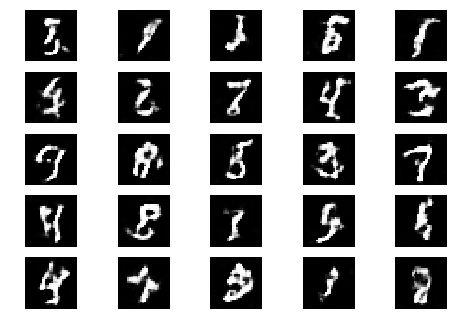

Epoch 0 Batch 1351/1875 [D loss: 0.667754, acc.: 59.38%] [G loss: 1.008443]
Epoch 0 Batch 1352/1875 [D loss: 0.608369, acc.: 68.75%] [G loss: 1.073243]
Epoch 0 Batch 1353/1875 [D loss: 0.718262, acc.: 56.25%] [G loss: 0.946990]
Epoch 0 Batch 1354/1875 [D loss: 0.512636, acc.: 84.38%] [G loss: 1.153179]
Epoch 0 Batch 1355/1875 [D loss: 0.772799, acc.: 59.38%] [G loss: 1.186007]
Epoch 0 Batch 1356/1875 [D loss: 0.644890, acc.: 65.62%] [G loss: 1.253958]
Epoch 0 Batch 1357/1875 [D loss: 0.763910, acc.: 46.88%] [G loss: 1.229332]
Epoch 0 Batch 1358/1875 [D loss: 0.733968, acc.: 50.00%] [G loss: 1.087305]
Epoch 0 Batch 1359/1875 [D loss: 0.586614, acc.: 68.75%] [G loss: 0.977977]
Epoch 0 Batch 1360/1875 [D loss: 0.863574, acc.: 40.62%] [G loss: 1.120830]
Epoch 0 Batch 1361/1875 [D loss: 0.555359, acc.: 68.75%] [G loss: 0.846483]
Epoch 0 Batch 1362/1875 [D loss: 0.483827, acc.: 78.12%] [G loss: 1.129699]
Epoch 0 Batch 1363/1875 [D loss: 0.637709, acc.: 62.50%] [G loss: 1.102792]
Epoch 0 Batc

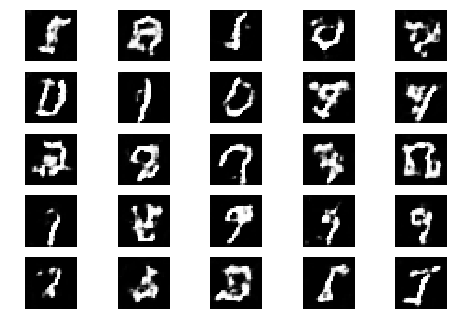

Epoch 0 Batch 1401/1875 [D loss: 0.639493, acc.: 68.75%] [G loss: 0.807837]
Epoch 0 Batch 1402/1875 [D loss: 0.643905, acc.: 53.12%] [G loss: 1.158736]
Epoch 0 Batch 1403/1875 [D loss: 0.500618, acc.: 84.38%] [G loss: 1.234416]
Epoch 0 Batch 1404/1875 [D loss: 0.640712, acc.: 62.50%] [G loss: 1.321948]
Epoch 0 Batch 1405/1875 [D loss: 0.733702, acc.: 65.62%] [G loss: 1.272068]
Epoch 0 Batch 1406/1875 [D loss: 0.644072, acc.: 62.50%] [G loss: 1.153347]
Epoch 0 Batch 1407/1875 [D loss: 0.665335, acc.: 62.50%] [G loss: 1.222916]
Epoch 0 Batch 1408/1875 [D loss: 0.803137, acc.: 53.12%] [G loss: 0.969933]
Epoch 0 Batch 1409/1875 [D loss: 0.787496, acc.: 50.00%] [G loss: 1.034472]
Epoch 0 Batch 1410/1875 [D loss: 0.647414, acc.: 62.50%] [G loss: 1.020854]
Epoch 0 Batch 1411/1875 [D loss: 0.646996, acc.: 65.62%] [G loss: 1.177871]
Epoch 0 Batch 1412/1875 [D loss: 0.770706, acc.: 56.25%] [G loss: 1.240734]
Epoch 0 Batch 1413/1875 [D loss: 0.470316, acc.: 75.00%] [G loss: 1.235006]
Epoch 0 Batc

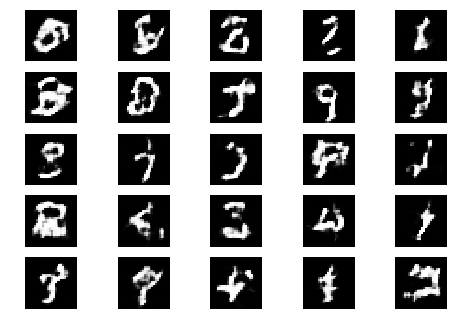

Epoch 0 Batch 1451/1875 [D loss: 0.624917, acc.: 62.50%] [G loss: 1.055182]
Epoch 0 Batch 1452/1875 [D loss: 0.537199, acc.: 65.62%] [G loss: 1.119741]
Epoch 0 Batch 1453/1875 [D loss: 0.731024, acc.: 56.25%] [G loss: 1.027549]
Epoch 0 Batch 1454/1875 [D loss: 0.668370, acc.: 53.12%] [G loss: 1.023495]
Epoch 0 Batch 1455/1875 [D loss: 0.596783, acc.: 68.75%] [G loss: 1.120735]
Epoch 0 Batch 1456/1875 [D loss: 0.536992, acc.: 78.12%] [G loss: 1.140176]
Epoch 0 Batch 1457/1875 [D loss: 0.665035, acc.: 65.62%] [G loss: 1.047585]
Epoch 0 Batch 1458/1875 [D loss: 0.756782, acc.: 62.50%] [G loss: 1.225023]
Epoch 0 Batch 1459/1875 [D loss: 0.735823, acc.: 50.00%] [G loss: 0.963751]
Epoch 0 Batch 1460/1875 [D loss: 0.727011, acc.: 59.38%] [G loss: 1.150034]
Epoch 0 Batch 1461/1875 [D loss: 0.467091, acc.: 75.00%] [G loss: 1.038338]
Epoch 0 Batch 1462/1875 [D loss: 0.726358, acc.: 59.38%] [G loss: 1.156208]
Epoch 0 Batch 1463/1875 [D loss: 0.733159, acc.: 59.38%] [G loss: 0.954543]
Epoch 0 Batc

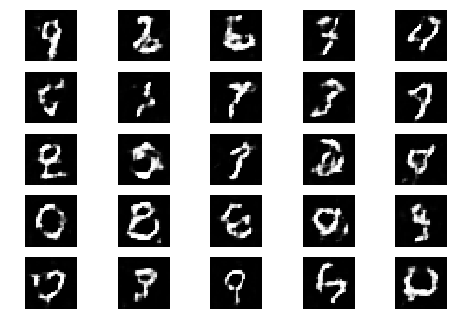

Epoch 0 Batch 1501/1875 [D loss: 0.568433, acc.: 68.75%] [G loss: 1.238211]
Epoch 0 Batch 1502/1875 [D loss: 0.678234, acc.: 59.38%] [G loss: 0.919166]
Epoch 0 Batch 1503/1875 [D loss: 0.751215, acc.: 56.25%] [G loss: 1.339719]
Epoch 0 Batch 1504/1875 [D loss: 0.672863, acc.: 59.38%] [G loss: 1.168950]
Epoch 0 Batch 1505/1875 [D loss: 0.597507, acc.: 65.62%] [G loss: 1.368723]
Epoch 0 Batch 1506/1875 [D loss: 0.717858, acc.: 46.88%] [G loss: 0.987898]
Epoch 0 Batch 1507/1875 [D loss: 0.713944, acc.: 59.38%] [G loss: 1.304403]
Epoch 0 Batch 1508/1875 [D loss: 0.521494, acc.: 71.88%] [G loss: 0.929753]
Epoch 0 Batch 1509/1875 [D loss: 0.692637, acc.: 59.38%] [G loss: 1.092131]
Epoch 0 Batch 1510/1875 [D loss: 0.631457, acc.: 65.62%] [G loss: 0.979490]
Epoch 0 Batch 1511/1875 [D loss: 0.653227, acc.: 59.38%] [G loss: 0.914745]
Epoch 0 Batch 1512/1875 [D loss: 0.661238, acc.: 50.00%] [G loss: 0.984932]
Epoch 0 Batch 1513/1875 [D loss: 0.530673, acc.: 78.12%] [G loss: 0.851860]
Epoch 0 Batc

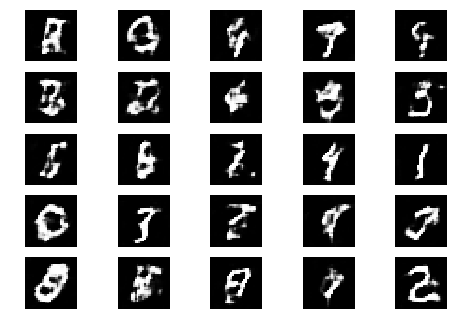

Epoch 0 Batch 1551/1875 [D loss: 0.643693, acc.: 65.62%] [G loss: 1.035675]
Epoch 0 Batch 1552/1875 [D loss: 0.736831, acc.: 50.00%] [G loss: 0.981334]
Epoch 0 Batch 1553/1875 [D loss: 0.501074, acc.: 78.12%] [G loss: 0.923024]
Epoch 0 Batch 1554/1875 [D loss: 0.642782, acc.: 65.62%] [G loss: 0.863913]
Epoch 0 Batch 1555/1875 [D loss: 0.679559, acc.: 62.50%] [G loss: 1.061721]
Epoch 0 Batch 1556/1875 [D loss: 0.751678, acc.: 59.38%] [G loss: 1.299819]
Epoch 0 Batch 1557/1875 [D loss: 0.717655, acc.: 62.50%] [G loss: 1.200676]
Epoch 0 Batch 1558/1875 [D loss: 0.724946, acc.: 56.25%] [G loss: 1.077780]
Epoch 0 Batch 1559/1875 [D loss: 0.712591, acc.: 53.12%] [G loss: 1.250531]
Epoch 0 Batch 1560/1875 [D loss: 0.692358, acc.: 65.62%] [G loss: 1.321587]
Epoch 0 Batch 1561/1875 [D loss: 0.695706, acc.: 53.12%] [G loss: 1.065257]
Epoch 0 Batch 1562/1875 [D loss: 0.737614, acc.: 53.12%] [G loss: 0.814173]
Epoch 0 Batch 1563/1875 [D loss: 0.727397, acc.: 56.25%] [G loss: 0.933284]
Epoch 0 Batc

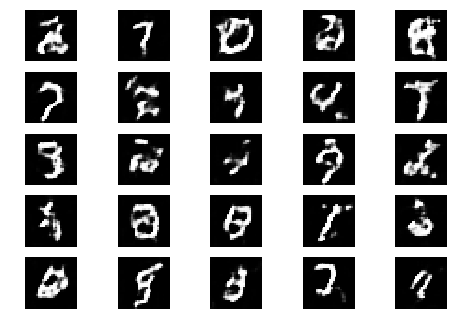

Epoch 0 Batch 1601/1875 [D loss: 0.740553, acc.: 43.75%] [G loss: 1.185832]
Epoch 0 Batch 1602/1875 [D loss: 0.634614, acc.: 56.25%] [G loss: 1.122573]
Epoch 0 Batch 1603/1875 [D loss: 0.648186, acc.: 53.12%] [G loss: 1.186564]
Epoch 0 Batch 1604/1875 [D loss: 0.711842, acc.: 62.50%] [G loss: 1.203560]
Epoch 0 Batch 1605/1875 [D loss: 0.898688, acc.: 43.75%] [G loss: 0.721170]
Epoch 0 Batch 1606/1875 [D loss: 0.637671, acc.: 65.62%] [G loss: 0.842660]
Epoch 0 Batch 1607/1875 [D loss: 0.537720, acc.: 71.88%] [G loss: 1.086696]
Epoch 0 Batch 1608/1875 [D loss: 0.440579, acc.: 84.38%] [G loss: 1.070607]
Epoch 0 Batch 1609/1875 [D loss: 0.705732, acc.: 53.12%] [G loss: 1.025121]
Epoch 0 Batch 1610/1875 [D loss: 0.624440, acc.: 62.50%] [G loss: 0.983400]
Epoch 0 Batch 1611/1875 [D loss: 0.765690, acc.: 56.25%] [G loss: 0.959652]
Epoch 0 Batch 1612/1875 [D loss: 0.521058, acc.: 81.25%] [G loss: 1.157390]
Epoch 0 Batch 1613/1875 [D loss: 0.742471, acc.: 59.38%] [G loss: 1.139169]
Epoch 0 Batc

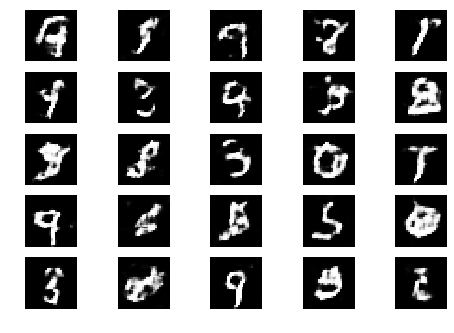

Epoch 0 Batch 1651/1875 [D loss: 0.733444, acc.: 56.25%] [G loss: 1.155234]
Epoch 0 Batch 1652/1875 [D loss: 0.739894, acc.: 56.25%] [G loss: 1.129643]
Epoch 0 Batch 1653/1875 [D loss: 0.589033, acc.: 59.38%] [G loss: 0.952606]
Epoch 0 Batch 1654/1875 [D loss: 0.464182, acc.: 87.50%] [G loss: 1.182963]
Epoch 0 Batch 1655/1875 [D loss: 0.622354, acc.: 53.12%] [G loss: 0.897756]
Epoch 0 Batch 1656/1875 [D loss: 0.623510, acc.: 59.38%] [G loss: 1.051617]
Epoch 0 Batch 1657/1875 [D loss: 0.657117, acc.: 59.38%] [G loss: 0.856899]
Epoch 0 Batch 1658/1875 [D loss: 0.623875, acc.: 62.50%] [G loss: 0.965722]
Epoch 0 Batch 1659/1875 [D loss: 0.569428, acc.: 78.12%] [G loss: 1.095019]
Epoch 0 Batch 1660/1875 [D loss: 0.581638, acc.: 56.25%] [G loss: 0.927821]
Epoch 0 Batch 1661/1875 [D loss: 0.603965, acc.: 62.50%] [G loss: 0.943616]
Epoch 0 Batch 1662/1875 [D loss: 0.790374, acc.: 53.12%] [G loss: 0.987789]
Epoch 0 Batch 1663/1875 [D loss: 0.792722, acc.: 46.88%] [G loss: 1.088118]
Epoch 0 Batc

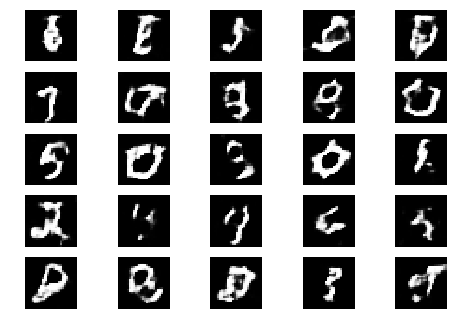

Epoch 0 Batch 1701/1875 [D loss: 0.837078, acc.: 46.88%] [G loss: 1.010414]
Epoch 0 Batch 1702/1875 [D loss: 0.836856, acc.: 50.00%] [G loss: 1.181144]
Epoch 0 Batch 1703/1875 [D loss: 0.668800, acc.: 62.50%] [G loss: 1.107792]
Epoch 0 Batch 1704/1875 [D loss: 0.701221, acc.: 56.25%] [G loss: 0.946209]
Epoch 0 Batch 1705/1875 [D loss: 0.517162, acc.: 78.12%] [G loss: 1.256023]
Epoch 0 Batch 1706/1875 [D loss: 0.644505, acc.: 56.25%] [G loss: 1.302134]
Epoch 0 Batch 1707/1875 [D loss: 0.641997, acc.: 68.75%] [G loss: 1.304833]
Epoch 0 Batch 1708/1875 [D loss: 0.588726, acc.: 62.50%] [G loss: 1.061916]
Epoch 0 Batch 1709/1875 [D loss: 0.924797, acc.: 46.88%] [G loss: 0.797016]
Epoch 0 Batch 1710/1875 [D loss: 0.585929, acc.: 71.88%] [G loss: 1.071289]
Epoch 0 Batch 1711/1875 [D loss: 0.856014, acc.: 43.75%] [G loss: 0.802676]
Epoch 0 Batch 1712/1875 [D loss: 0.690603, acc.: 62.50%] [G loss: 0.729597]
Epoch 0 Batch 1713/1875 [D loss: 0.665398, acc.: 50.00%] [G loss: 0.954646]
Epoch 0 Batc

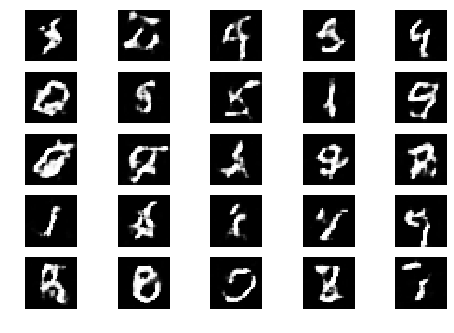

Epoch 0 Batch 1751/1875 [D loss: 0.760817, acc.: 40.62%] [G loss: 0.972254]
Epoch 0 Batch 1752/1875 [D loss: 0.719099, acc.: 56.25%] [G loss: 1.029709]
Epoch 0 Batch 1753/1875 [D loss: 0.458221, acc.: 84.38%] [G loss: 1.321251]
Epoch 0 Batch 1754/1875 [D loss: 0.751137, acc.: 59.38%] [G loss: 0.919784]
Epoch 0 Batch 1755/1875 [D loss: 0.642412, acc.: 62.50%] [G loss: 0.980350]
Epoch 0 Batch 1756/1875 [D loss: 0.623023, acc.: 71.88%] [G loss: 0.844284]
Epoch 0 Batch 1757/1875 [D loss: 0.583583, acc.: 75.00%] [G loss: 1.340465]
Epoch 0 Batch 1758/1875 [D loss: 0.641959, acc.: 59.38%] [G loss: 1.178803]
Epoch 0 Batch 1759/1875 [D loss: 0.640928, acc.: 65.62%] [G loss: 1.049603]
Epoch 0 Batch 1760/1875 [D loss: 0.723575, acc.: 53.12%] [G loss: 0.858142]
Epoch 0 Batch 1761/1875 [D loss: 0.676936, acc.: 59.38%] [G loss: 0.923855]
Epoch 0 Batch 1762/1875 [D loss: 0.678739, acc.: 56.25%] [G loss: 1.180759]
Epoch 0 Batch 1763/1875 [D loss: 0.797332, acc.: 56.25%] [G loss: 0.839538]
Epoch 0 Batc

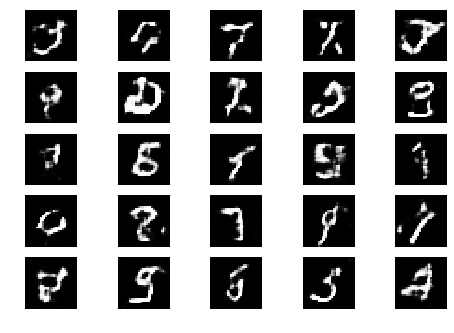

Epoch 0 Batch 1801/1875 [D loss: 0.604482, acc.: 65.62%] [G loss: 1.070718]
Epoch 0 Batch 1802/1875 [D loss: 0.688165, acc.: 56.25%] [G loss: 0.865664]
Epoch 0 Batch 1803/1875 [D loss: 0.608776, acc.: 65.62%] [G loss: 0.941183]
Epoch 0 Batch 1804/1875 [D loss: 0.672737, acc.: 62.50%] [G loss: 1.267732]
Epoch 0 Batch 1805/1875 [D loss: 0.609277, acc.: 53.12%] [G loss: 0.979187]
Epoch 0 Batch 1806/1875 [D loss: 0.638050, acc.: 62.50%] [G loss: 0.920047]
Epoch 0 Batch 1807/1875 [D loss: 0.701610, acc.: 59.38%] [G loss: 1.068855]
Epoch 0 Batch 1808/1875 [D loss: 0.555942, acc.: 71.88%] [G loss: 1.001449]
Epoch 0 Batch 1809/1875 [D loss: 0.635943, acc.: 65.62%] [G loss: 1.071720]
Epoch 0 Batch 1810/1875 [D loss: 0.675818, acc.: 59.38%] [G loss: 0.900057]
Epoch 0 Batch 1811/1875 [D loss: 0.562728, acc.: 75.00%] [G loss: 1.137882]
Epoch 0 Batch 1812/1875 [D loss: 0.552200, acc.: 68.75%] [G loss: 1.113380]
Epoch 0 Batch 1813/1875 [D loss: 0.848591, acc.: 43.75%] [G loss: 0.836238]
Epoch 0 Batc

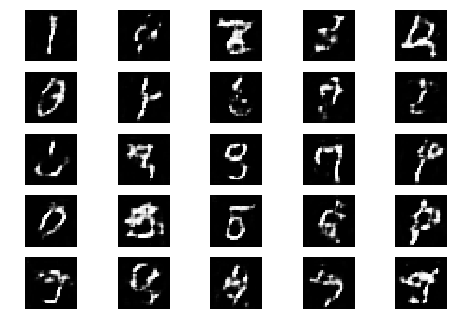

Epoch 0 Batch 1851/1875 [D loss: 0.627277, acc.: 53.12%] [G loss: 1.147345]
Epoch 0 Batch 1852/1875 [D loss: 0.693401, acc.: 53.12%] [G loss: 1.027510]
Epoch 0 Batch 1853/1875 [D loss: 0.601548, acc.: 59.38%] [G loss: 0.977086]
Epoch 0 Batch 1854/1875 [D loss: 0.499973, acc.: 78.12%] [G loss: 1.170246]
Epoch 0 Batch 1855/1875 [D loss: 0.642998, acc.: 65.62%] [G loss: 1.293858]
Epoch 0 Batch 1856/1875 [D loss: 0.581078, acc.: 81.25%] [G loss: 1.161000]
Epoch 0 Batch 1857/1875 [D loss: 0.889945, acc.: 43.75%] [G loss: 1.178772]
Epoch 0 Batch 1858/1875 [D loss: 0.608403, acc.: 59.38%] [G loss: 1.237500]
Epoch 0 Batch 1859/1875 [D loss: 0.640649, acc.: 59.38%] [G loss: 1.284606]
Epoch 0 Batch 1860/1875 [D loss: 0.740070, acc.: 53.12%] [G loss: 1.129815]
Epoch 0 Batch 1861/1875 [D loss: 0.694703, acc.: 53.12%] [G loss: 1.056577]
Epoch 0 Batch 1862/1875 [D loss: 0.785198, acc.: 56.25%] [G loss: 1.302457]
Epoch 0 Batch 1863/1875 [D loss: 0.735583, acc.: 50.00%] [G loss: 0.992765]
Epoch 0 Batc

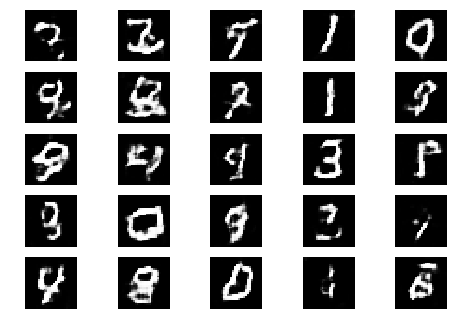

Epoch 1 Batch 1/1875 [D loss: 0.556042, acc.: 78.12%] [G loss: 0.813567]
Epoch 1 Batch 2/1875 [D loss: 0.575412, acc.: 84.38%] [G loss: 0.881685]
Epoch 1 Batch 3/1875 [D loss: 0.681845, acc.: 56.25%] [G loss: 0.886644]
Epoch 1 Batch 4/1875 [D loss: 0.710822, acc.: 56.25%] [G loss: 1.272251]
Epoch 1 Batch 5/1875 [D loss: 0.601710, acc.: 71.88%] [G loss: 1.055229]
Epoch 1 Batch 6/1875 [D loss: 0.716008, acc.: 62.50%] [G loss: 0.946046]
Epoch 1 Batch 7/1875 [D loss: 0.686077, acc.: 65.62%] [G loss: 1.152314]
Epoch 1 Batch 8/1875 [D loss: 0.636330, acc.: 59.38%] [G loss: 1.119365]
Epoch 1 Batch 9/1875 [D loss: 0.661688, acc.: 62.50%] [G loss: 1.243109]
Epoch 1 Batch 10/1875 [D loss: 0.658935, acc.: 62.50%] [G loss: 1.100103]
Epoch 1 Batch 11/1875 [D loss: 0.622182, acc.: 65.62%] [G loss: 1.039690]
Epoch 1 Batch 12/1875 [D loss: 0.724254, acc.: 56.25%] [G loss: 1.213124]
Epoch 1 Batch 13/1875 [D loss: 0.933518, acc.: 34.38%] [G loss: 0.929794]
Epoch 1 Batch 14/1875 [D loss: 0.628368, acc.: 

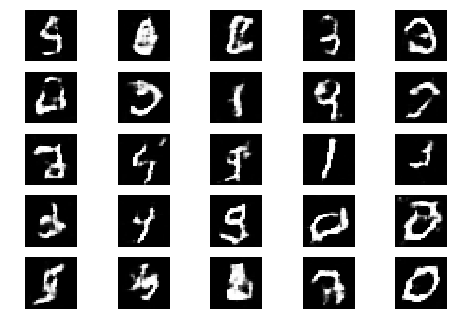

Epoch 1 Batch 51/1875 [D loss: 0.744586, acc.: 46.88%] [G loss: 1.080451]
Epoch 1 Batch 52/1875 [D loss: 0.771305, acc.: 53.12%] [G loss: 1.371821]
Epoch 1 Batch 53/1875 [D loss: 0.734870, acc.: 56.25%] [G loss: 1.128156]
Epoch 1 Batch 54/1875 [D loss: 0.762121, acc.: 53.12%] [G loss: 1.085503]
Epoch 1 Batch 55/1875 [D loss: 0.832556, acc.: 43.75%] [G loss: 1.069855]
Epoch 1 Batch 56/1875 [D loss: 0.641504, acc.: 59.38%] [G loss: 1.149480]
Epoch 1 Batch 57/1875 [D loss: 0.615201, acc.: 65.62%] [G loss: 1.059492]
Epoch 1 Batch 58/1875 [D loss: 0.616179, acc.: 65.62%] [G loss: 1.145869]
Epoch 1 Batch 59/1875 [D loss: 0.596440, acc.: 71.88%] [G loss: 0.817172]
Epoch 1 Batch 60/1875 [D loss: 0.726864, acc.: 46.88%] [G loss: 0.928982]
Epoch 1 Batch 61/1875 [D loss: 0.721660, acc.: 53.12%] [G loss: 0.956689]
Epoch 1 Batch 62/1875 [D loss: 0.781957, acc.: 43.75%] [G loss: 1.196152]
Epoch 1 Batch 63/1875 [D loss: 0.542489, acc.: 68.75%] [G loss: 1.049559]
Epoch 1 Batch 64/1875 [D loss: 0.63037

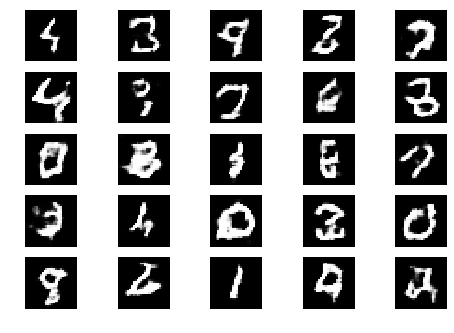

Epoch 1 Batch 101/1875 [D loss: 0.690599, acc.: 59.38%] [G loss: 1.153427]
Epoch 1 Batch 102/1875 [D loss: 0.818643, acc.: 50.00%] [G loss: 0.939743]
Epoch 1 Batch 103/1875 [D loss: 0.696452, acc.: 68.75%] [G loss: 1.219962]
Epoch 1 Batch 104/1875 [D loss: 0.610072, acc.: 59.38%] [G loss: 1.302708]
Epoch 1 Batch 105/1875 [D loss: 0.620481, acc.: 62.50%] [G loss: 0.933382]
Epoch 1 Batch 106/1875 [D loss: 0.716107, acc.: 62.50%] [G loss: 1.083371]
Epoch 1 Batch 107/1875 [D loss: 0.705270, acc.: 62.50%] [G loss: 0.929737]
Epoch 1 Batch 108/1875 [D loss: 0.797094, acc.: 59.38%] [G loss: 0.969974]
Epoch 1 Batch 109/1875 [D loss: 0.554237, acc.: 78.12%] [G loss: 1.089890]
Epoch 1 Batch 110/1875 [D loss: 0.563316, acc.: 62.50%] [G loss: 0.981337]
Epoch 1 Batch 111/1875 [D loss: 0.685600, acc.: 59.38%] [G loss: 0.937983]
Epoch 1 Batch 112/1875 [D loss: 0.739926, acc.: 56.25%] [G loss: 1.187920]
Epoch 1 Batch 113/1875 [D loss: 0.765997, acc.: 65.62%] [G loss: 1.085285]
Epoch 1 Batch 114/1875 [D

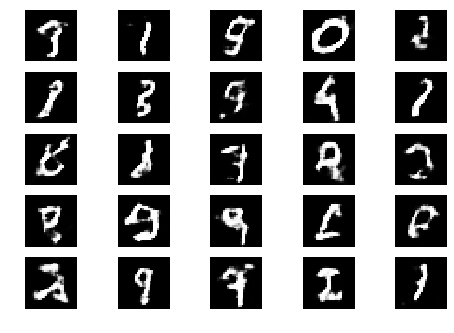

Epoch 1 Batch 151/1875 [D loss: 0.661865, acc.: 59.38%] [G loss: 1.033070]
Epoch 1 Batch 152/1875 [D loss: 0.871979, acc.: 40.62%] [G loss: 0.865919]
Epoch 1 Batch 153/1875 [D loss: 0.746640, acc.: 53.12%] [G loss: 1.036912]
Epoch 1 Batch 154/1875 [D loss: 0.655870, acc.: 71.88%] [G loss: 1.108142]
Epoch 1 Batch 155/1875 [D loss: 0.736678, acc.: 56.25%] [G loss: 0.859444]
Epoch 1 Batch 156/1875 [D loss: 0.572095, acc.: 68.75%] [G loss: 0.942407]
Epoch 1 Batch 157/1875 [D loss: 0.574096, acc.: 68.75%] [G loss: 0.850467]
Epoch 1 Batch 158/1875 [D loss: 0.601958, acc.: 65.62%] [G loss: 0.917988]
Epoch 1 Batch 159/1875 [D loss: 0.810397, acc.: 37.50%] [G loss: 0.907010]
Epoch 1 Batch 160/1875 [D loss: 0.699786, acc.: 62.50%] [G loss: 1.196069]
Epoch 1 Batch 161/1875 [D loss: 0.424967, acc.: 84.38%] [G loss: 0.983811]
Epoch 1 Batch 162/1875 [D loss: 0.707222, acc.: 59.38%] [G loss: 1.048504]
Epoch 1 Batch 163/1875 [D loss: 0.540861, acc.: 78.12%] [G loss: 1.045947]
Epoch 1 Batch 164/1875 [D

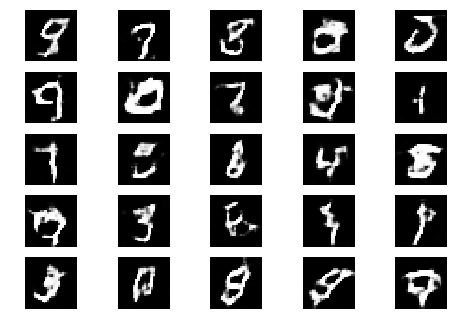

Epoch 1 Batch 201/1875 [D loss: 0.691763, acc.: 62.50%] [G loss: 1.096443]
Epoch 1 Batch 202/1875 [D loss: 0.565532, acc.: 68.75%] [G loss: 1.046255]
Epoch 1 Batch 203/1875 [D loss: 0.644738, acc.: 62.50%] [G loss: 0.910585]
Epoch 1 Batch 204/1875 [D loss: 0.750874, acc.: 59.38%] [G loss: 1.182589]
Epoch 1 Batch 205/1875 [D loss: 0.611688, acc.: 78.12%] [G loss: 1.115510]
Epoch 1 Batch 206/1875 [D loss: 0.788545, acc.: 50.00%] [G loss: 1.085778]
Epoch 1 Batch 207/1875 [D loss: 0.642186, acc.: 56.25%] [G loss: 1.056072]
Epoch 1 Batch 208/1875 [D loss: 0.603506, acc.: 75.00%] [G loss: 1.271213]
Epoch 1 Batch 209/1875 [D loss: 0.647275, acc.: 65.62%] [G loss: 1.013139]
Epoch 1 Batch 210/1875 [D loss: 0.631698, acc.: 59.38%] [G loss: 1.175793]
Epoch 1 Batch 211/1875 [D loss: 0.637170, acc.: 62.50%] [G loss: 1.107793]
Epoch 1 Batch 212/1875 [D loss: 0.671492, acc.: 59.38%] [G loss: 1.240655]
Epoch 1 Batch 213/1875 [D loss: 0.697368, acc.: 62.50%] [G loss: 0.959533]
Epoch 1 Batch 214/1875 [D

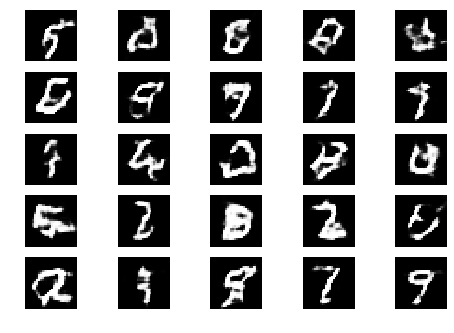

Epoch 1 Batch 251/1875 [D loss: 0.527531, acc.: 71.88%] [G loss: 1.102887]
Epoch 1 Batch 252/1875 [D loss: 0.678044, acc.: 56.25%] [G loss: 1.055253]
Epoch 1 Batch 253/1875 [D loss: 0.740148, acc.: 56.25%] [G loss: 1.066025]
Epoch 1 Batch 254/1875 [D loss: 0.814655, acc.: 46.88%] [G loss: 1.181857]
Epoch 1 Batch 255/1875 [D loss: 0.554834, acc.: 62.50%] [G loss: 1.239919]
Epoch 1 Batch 256/1875 [D loss: 0.728093, acc.: 53.12%] [G loss: 1.074013]
Epoch 1 Batch 257/1875 [D loss: 0.602577, acc.: 71.88%] [G loss: 0.806916]
Epoch 1 Batch 258/1875 [D loss: 0.589477, acc.: 65.62%] [G loss: 1.000458]
Epoch 1 Batch 259/1875 [D loss: 0.643702, acc.: 59.38%] [G loss: 1.094692]
Epoch 1 Batch 260/1875 [D loss: 0.614557, acc.: 65.62%] [G loss: 1.076666]
Epoch 1 Batch 261/1875 [D loss: 0.783448, acc.: 40.62%] [G loss: 1.011538]
Epoch 1 Batch 262/1875 [D loss: 0.706222, acc.: 56.25%] [G loss: 1.246192]
Epoch 1 Batch 263/1875 [D loss: 0.672925, acc.: 65.62%] [G loss: 1.082254]
Epoch 1 Batch 264/1875 [D

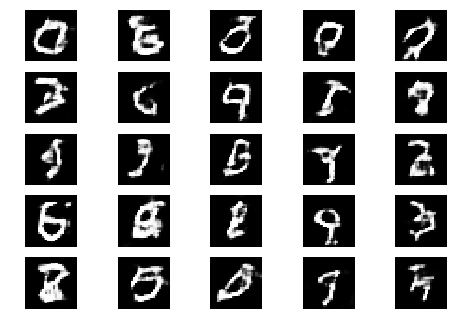

Epoch 1 Batch 301/1875 [D loss: 0.642965, acc.: 68.75%] [G loss: 1.089171]
Epoch 1 Batch 302/1875 [D loss: 0.508861, acc.: 84.38%] [G loss: 1.271428]
Epoch 1 Batch 303/1875 [D loss: 0.671519, acc.: 53.12%] [G loss: 1.246120]
Epoch 1 Batch 304/1875 [D loss: 0.551051, acc.: 68.75%] [G loss: 1.121821]
Epoch 1 Batch 305/1875 [D loss: 0.641989, acc.: 65.62%] [G loss: 0.991039]
Epoch 1 Batch 306/1875 [D loss: 0.695840, acc.: 56.25%] [G loss: 0.886778]
Epoch 1 Batch 307/1875 [D loss: 0.756531, acc.: 43.75%] [G loss: 0.968121]
Epoch 1 Batch 308/1875 [D loss: 0.647274, acc.: 56.25%] [G loss: 1.095270]
Epoch 1 Batch 309/1875 [D loss: 0.672006, acc.: 56.25%] [G loss: 1.227829]
Epoch 1 Batch 310/1875 [D loss: 0.613978, acc.: 71.88%] [G loss: 1.069021]
Epoch 1 Batch 311/1875 [D loss: 0.648864, acc.: 62.50%] [G loss: 0.975259]
Epoch 1 Batch 312/1875 [D loss: 0.709757, acc.: 62.50%] [G loss: 0.902269]
Epoch 1 Batch 313/1875 [D loss: 0.807865, acc.: 50.00%] [G loss: 1.018167]
Epoch 1 Batch 314/1875 [D

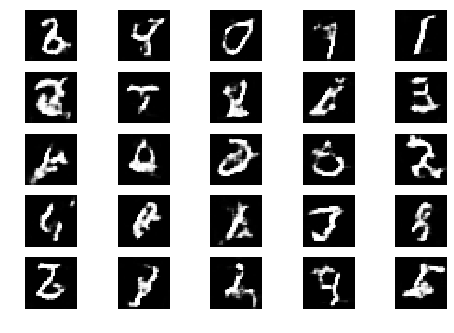

Epoch 1 Batch 351/1875 [D loss: 0.505902, acc.: 78.12%] [G loss: 1.149290]
Epoch 1 Batch 352/1875 [D loss: 0.785011, acc.: 53.12%] [G loss: 1.028921]
Epoch 1 Batch 353/1875 [D loss: 0.720942, acc.: 50.00%] [G loss: 0.976449]
Epoch 1 Batch 354/1875 [D loss: 0.634023, acc.: 56.25%] [G loss: 0.790845]
Epoch 1 Batch 355/1875 [D loss: 0.609262, acc.: 59.38%] [G loss: 0.989473]
Epoch 1 Batch 356/1875 [D loss: 0.624695, acc.: 65.62%] [G loss: 1.049977]
Epoch 1 Batch 357/1875 [D loss: 0.616371, acc.: 65.62%] [G loss: 1.020079]
Epoch 1 Batch 358/1875 [D loss: 0.515975, acc.: 87.50%] [G loss: 0.980839]
Epoch 1 Batch 359/1875 [D loss: 0.798862, acc.: 53.12%] [G loss: 1.002560]
Epoch 1 Batch 360/1875 [D loss: 0.528958, acc.: 71.88%] [G loss: 1.189899]
Epoch 1 Batch 361/1875 [D loss: 0.669990, acc.: 56.25%] [G loss: 0.797272]
Epoch 1 Batch 362/1875 [D loss: 0.593676, acc.: 65.62%] [G loss: 0.919935]
Epoch 1 Batch 363/1875 [D loss: 0.631879, acc.: 62.50%] [G loss: 0.900257]
Epoch 1 Batch 364/1875 [D

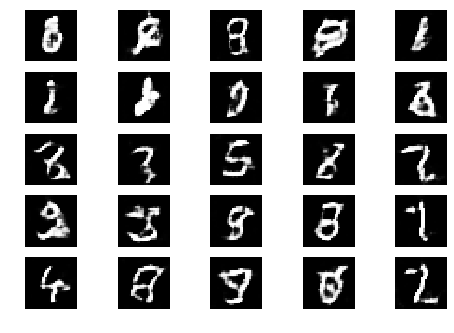

Epoch 1 Batch 401/1875 [D loss: 0.623271, acc.: 56.25%] [G loss: 0.889015]
Epoch 1 Batch 402/1875 [D loss: 0.563332, acc.: 75.00%] [G loss: 0.925454]
Epoch 1 Batch 403/1875 [D loss: 0.642230, acc.: 71.88%] [G loss: 1.001995]
Epoch 1 Batch 404/1875 [D loss: 0.565371, acc.: 65.62%] [G loss: 1.118524]
Epoch 1 Batch 405/1875 [D loss: 0.561861, acc.: 68.75%] [G loss: 1.105735]
Epoch 1 Batch 406/1875 [D loss: 0.564593, acc.: 68.75%] [G loss: 1.142550]
Epoch 1 Batch 407/1875 [D loss: 0.652118, acc.: 68.75%] [G loss: 1.110634]
Epoch 1 Batch 408/1875 [D loss: 0.812590, acc.: 50.00%] [G loss: 0.963048]
Epoch 1 Batch 409/1875 [D loss: 0.668325, acc.: 59.38%] [G loss: 1.060952]
Epoch 1 Batch 410/1875 [D loss: 0.582250, acc.: 75.00%] [G loss: 0.936283]
Epoch 1 Batch 411/1875 [D loss: 0.733866, acc.: 65.62%] [G loss: 1.108336]
Epoch 1 Batch 412/1875 [D loss: 0.528025, acc.: 78.12%] [G loss: 0.900571]
Epoch 1 Batch 413/1875 [D loss: 0.481924, acc.: 78.12%] [G loss: 1.023722]
Epoch 1 Batch 414/1875 [D

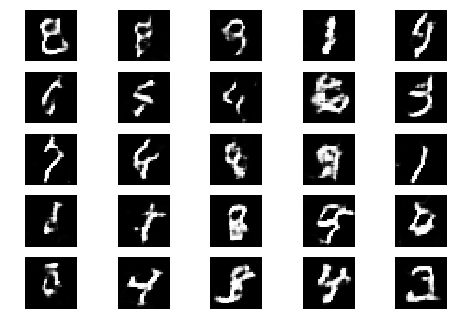

Epoch 1 Batch 451/1875 [D loss: 0.682990, acc.: 62.50%] [G loss: 0.996950]
Epoch 1 Batch 452/1875 [D loss: 0.591768, acc.: 62.50%] [G loss: 1.047405]
Epoch 1 Batch 453/1875 [D loss: 0.646525, acc.: 59.38%] [G loss: 1.091770]
Epoch 1 Batch 454/1875 [D loss: 0.617897, acc.: 75.00%] [G loss: 1.218793]
Epoch 1 Batch 455/1875 [D loss: 0.673809, acc.: 59.38%] [G loss: 1.074960]
Epoch 1 Batch 456/1875 [D loss: 0.568308, acc.: 75.00%] [G loss: 0.906433]
Epoch 1 Batch 457/1875 [D loss: 0.711468, acc.: 56.25%] [G loss: 0.984958]
Epoch 1 Batch 458/1875 [D loss: 0.790247, acc.: 53.12%] [G loss: 1.057058]
Epoch 1 Batch 459/1875 [D loss: 0.559987, acc.: 68.75%] [G loss: 1.129378]
Epoch 1 Batch 460/1875 [D loss: 0.733025, acc.: 53.12%] [G loss: 1.094947]
Epoch 1 Batch 461/1875 [D loss: 0.607083, acc.: 75.00%] [G loss: 0.907839]
Epoch 1 Batch 462/1875 [D loss: 0.698166, acc.: 62.50%] [G loss: 0.978364]
Epoch 1 Batch 463/1875 [D loss: 0.613517, acc.: 71.88%] [G loss: 1.026436]
Epoch 1 Batch 464/1875 [D

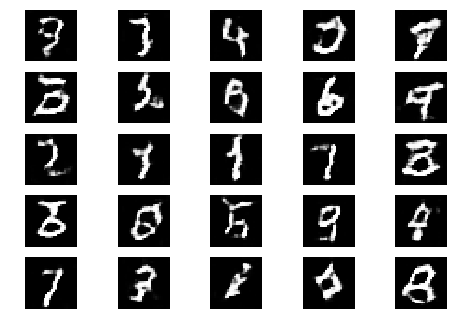

Epoch 1 Batch 501/1875 [D loss: 0.674100, acc.: 62.50%] [G loss: 0.966384]
Epoch 1 Batch 502/1875 [D loss: 0.534596, acc.: 78.12%] [G loss: 1.044470]
Epoch 1 Batch 503/1875 [D loss: 0.743158, acc.: 46.88%] [G loss: 1.025280]
Epoch 1 Batch 504/1875 [D loss: 0.841043, acc.: 43.75%] [G loss: 1.102405]
Epoch 1 Batch 505/1875 [D loss: 0.775323, acc.: 46.88%] [G loss: 1.080567]
Epoch 1 Batch 506/1875 [D loss: 0.623222, acc.: 59.38%] [G loss: 1.127520]
Epoch 1 Batch 507/1875 [D loss: 0.849616, acc.: 43.75%] [G loss: 1.166685]
Epoch 1 Batch 508/1875 [D loss: 0.810465, acc.: 43.75%] [G loss: 1.105571]
Epoch 1 Batch 509/1875 [D loss: 0.595400, acc.: 71.88%] [G loss: 1.153592]
Epoch 1 Batch 510/1875 [D loss: 0.528401, acc.: 81.25%] [G loss: 1.104156]
Epoch 1 Batch 511/1875 [D loss: 0.530047, acc.: 75.00%] [G loss: 0.974836]
Epoch 1 Batch 512/1875 [D loss: 0.581766, acc.: 59.38%] [G loss: 1.025475]
Epoch 1 Batch 513/1875 [D loss: 0.873619, acc.: 46.88%] [G loss: 1.300530]
Epoch 1 Batch 514/1875 [D

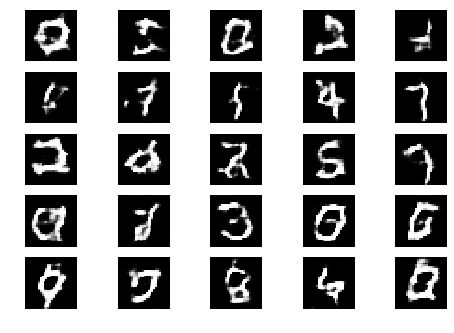

Epoch 1 Batch 551/1875 [D loss: 0.551000, acc.: 65.62%] [G loss: 1.099574]
Epoch 1 Batch 552/1875 [D loss: 0.681216, acc.: 62.50%] [G loss: 0.793496]
Epoch 1 Batch 553/1875 [D loss: 0.615676, acc.: 68.75%] [G loss: 1.009438]
Epoch 1 Batch 554/1875 [D loss: 0.644885, acc.: 56.25%] [G loss: 0.835463]
Epoch 1 Batch 555/1875 [D loss: 0.699263, acc.: 53.12%] [G loss: 1.113895]
Epoch 1 Batch 556/1875 [D loss: 0.876618, acc.: 43.75%] [G loss: 1.013867]
Epoch 1 Batch 557/1875 [D loss: 0.719888, acc.: 59.38%] [G loss: 0.947476]
Epoch 1 Batch 558/1875 [D loss: 0.688913, acc.: 53.12%] [G loss: 1.145519]
Epoch 1 Batch 559/1875 [D loss: 0.782701, acc.: 46.88%] [G loss: 0.964461]
Epoch 1 Batch 560/1875 [D loss: 0.672116, acc.: 59.38%] [G loss: 1.113724]
Epoch 1 Batch 561/1875 [D loss: 0.541284, acc.: 71.88%] [G loss: 1.057701]
Epoch 1 Batch 562/1875 [D loss: 0.677805, acc.: 50.00%] [G loss: 1.125211]
Epoch 1 Batch 563/1875 [D loss: 0.599720, acc.: 75.00%] [G loss: 1.113322]
Epoch 1 Batch 564/1875 [D

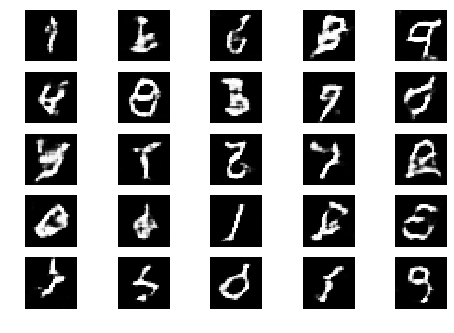

Epoch 1 Batch 601/1875 [D loss: 0.546158, acc.: 65.62%] [G loss: 1.013422]
Epoch 1 Batch 602/1875 [D loss: 0.537359, acc.: 68.75%] [G loss: 1.092876]
Epoch 1 Batch 603/1875 [D loss: 0.593733, acc.: 56.25%] [G loss: 1.270394]
Epoch 1 Batch 604/1875 [D loss: 0.668709, acc.: 53.12%] [G loss: 0.879571]
Epoch 1 Batch 605/1875 [D loss: 0.723058, acc.: 50.00%] [G loss: 0.871613]
Epoch 1 Batch 606/1875 [D loss: 0.606332, acc.: 65.62%] [G loss: 0.952950]
Epoch 1 Batch 607/1875 [D loss: 0.661167, acc.: 65.62%] [G loss: 0.872340]
Epoch 1 Batch 608/1875 [D loss: 0.598785, acc.: 68.75%] [G loss: 1.032177]
Epoch 1 Batch 609/1875 [D loss: 0.721547, acc.: 46.88%] [G loss: 0.899587]
Epoch 1 Batch 610/1875 [D loss: 0.711739, acc.: 43.75%] [G loss: 1.013505]
Epoch 1 Batch 611/1875 [D loss: 0.756225, acc.: 53.12%] [G loss: 1.070692]
Epoch 1 Batch 612/1875 [D loss: 0.559240, acc.: 75.00%] [G loss: 0.990990]
Epoch 1 Batch 613/1875 [D loss: 0.506114, acc.: 71.88%] [G loss: 1.079180]
Epoch 1 Batch 614/1875 [D

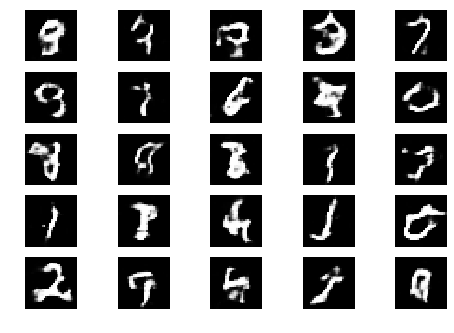

Epoch 1 Batch 651/1875 [D loss: 0.619413, acc.: 71.88%] [G loss: 0.977797]
Epoch 1 Batch 652/1875 [D loss: 0.673244, acc.: 62.50%] [G loss: 0.917089]
Epoch 1 Batch 653/1875 [D loss: 0.558040, acc.: 65.62%] [G loss: 1.057141]
Epoch 1 Batch 654/1875 [D loss: 0.617053, acc.: 65.62%] [G loss: 0.843886]
Epoch 1 Batch 655/1875 [D loss: 0.724860, acc.: 53.12%] [G loss: 1.023651]
Epoch 1 Batch 656/1875 [D loss: 0.695708, acc.: 65.62%] [G loss: 0.927255]
Epoch 1 Batch 657/1875 [D loss: 0.701872, acc.: 59.38%] [G loss: 0.986467]
Epoch 1 Batch 658/1875 [D loss: 0.770641, acc.: 50.00%] [G loss: 0.887448]
Epoch 1 Batch 659/1875 [D loss: 0.733086, acc.: 59.38%] [G loss: 1.112639]
Epoch 1 Batch 660/1875 [D loss: 0.790070, acc.: 50.00%] [G loss: 1.072911]
Epoch 1 Batch 661/1875 [D loss: 0.761184, acc.: 56.25%] [G loss: 0.885544]
Epoch 1 Batch 662/1875 [D loss: 0.686209, acc.: 59.38%] [G loss: 1.052217]
Epoch 1 Batch 663/1875 [D loss: 0.701181, acc.: 53.12%] [G loss: 0.994896]
Epoch 1 Batch 664/1875 [D

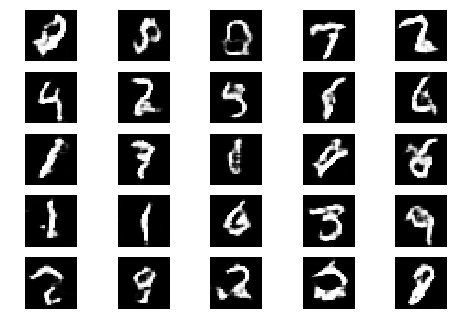

Epoch 1 Batch 701/1875 [D loss: 0.587504, acc.: 81.25%] [G loss: 0.798205]
Epoch 1 Batch 702/1875 [D loss: 0.576614, acc.: 71.88%] [G loss: 0.890603]
Epoch 1 Batch 703/1875 [D loss: 0.644713, acc.: 59.38%] [G loss: 1.135476]
Epoch 1 Batch 704/1875 [D loss: 0.525998, acc.: 75.00%] [G loss: 0.867568]
Epoch 1 Batch 705/1875 [D loss: 0.757694, acc.: 46.88%] [G loss: 0.979317]
Epoch 1 Batch 706/1875 [D loss: 0.612589, acc.: 65.62%] [G loss: 1.078316]
Epoch 1 Batch 707/1875 [D loss: 0.609205, acc.: 62.50%] [G loss: 1.053564]
Epoch 1 Batch 708/1875 [D loss: 0.771417, acc.: 46.88%] [G loss: 0.849312]
Epoch 1 Batch 709/1875 [D loss: 0.511496, acc.: 71.88%] [G loss: 1.057957]
Epoch 1 Batch 710/1875 [D loss: 0.653402, acc.: 65.62%] [G loss: 1.120064]
Epoch 1 Batch 711/1875 [D loss: 0.636628, acc.: 62.50%] [G loss: 1.145335]
Epoch 1 Batch 712/1875 [D loss: 0.718437, acc.: 53.12%] [G loss: 1.090884]
Epoch 1 Batch 713/1875 [D loss: 0.769075, acc.: 50.00%] [G loss: 1.062104]
Epoch 1 Batch 714/1875 [D

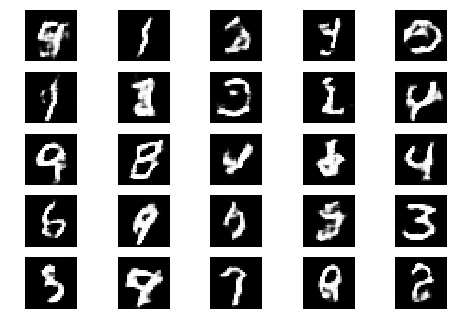

Epoch 1 Batch 751/1875 [D loss: 0.491645, acc.: 84.38%] [G loss: 1.166786]
Epoch 1 Batch 752/1875 [D loss: 0.696038, acc.: 62.50%] [G loss: 0.944246]
Epoch 1 Batch 753/1875 [D loss: 0.632542, acc.: 62.50%] [G loss: 0.982418]
Epoch 1 Batch 754/1875 [D loss: 0.708680, acc.: 53.12%] [G loss: 0.996248]
Epoch 1 Batch 755/1875 [D loss: 0.551702, acc.: 71.88%] [G loss: 1.061831]
Epoch 1 Batch 756/1875 [D loss: 0.631027, acc.: 71.88%] [G loss: 1.066509]
Epoch 1 Batch 757/1875 [D loss: 0.553240, acc.: 75.00%] [G loss: 1.219991]
Epoch 1 Batch 758/1875 [D loss: 0.686914, acc.: 56.25%] [G loss: 1.106696]
Epoch 1 Batch 759/1875 [D loss: 0.601163, acc.: 68.75%] [G loss: 0.907277]
Epoch 1 Batch 760/1875 [D loss: 0.799372, acc.: 53.12%] [G loss: 1.053938]
Epoch 1 Batch 761/1875 [D loss: 0.591377, acc.: 62.50%] [G loss: 1.033550]
Epoch 1 Batch 762/1875 [D loss: 0.567949, acc.: 59.38%] [G loss: 0.987315]
Epoch 1 Batch 763/1875 [D loss: 0.526955, acc.: 81.25%] [G loss: 1.276760]
Epoch 1 Batch 764/1875 [D

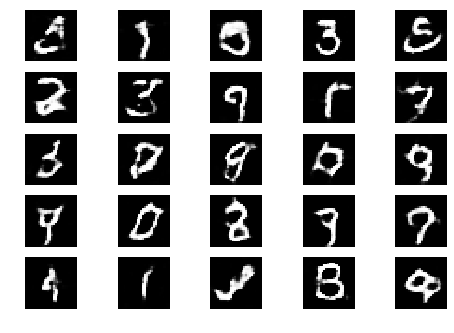

Epoch 1 Batch 801/1875 [D loss: 0.840855, acc.: 40.62%] [G loss: 0.986888]
Epoch 1 Batch 802/1875 [D loss: 0.690963, acc.: 59.38%] [G loss: 0.975640]
Epoch 1 Batch 803/1875 [D loss: 0.548232, acc.: 78.12%] [G loss: 0.992428]
Epoch 1 Batch 804/1875 [D loss: 0.697640, acc.: 65.62%] [G loss: 1.030252]
Epoch 1 Batch 805/1875 [D loss: 0.631619, acc.: 65.62%] [G loss: 0.772449]
Epoch 1 Batch 806/1875 [D loss: 0.680542, acc.: 62.50%] [G loss: 0.959794]
Epoch 1 Batch 807/1875 [D loss: 0.761991, acc.: 53.12%] [G loss: 0.937628]
Epoch 1 Batch 808/1875 [D loss: 0.673907, acc.: 62.50%] [G loss: 1.135716]
Epoch 1 Batch 809/1875 [D loss: 0.589297, acc.: 71.88%] [G loss: 1.146084]
Epoch 1 Batch 810/1875 [D loss: 0.659458, acc.: 65.62%] [G loss: 1.020727]
Epoch 1 Batch 811/1875 [D loss: 0.567196, acc.: 71.88%] [G loss: 1.118950]
Epoch 1 Batch 812/1875 [D loss: 0.702716, acc.: 46.88%] [G loss: 0.894863]
Epoch 1 Batch 813/1875 [D loss: 0.625861, acc.: 59.38%] [G loss: 0.932118]
Epoch 1 Batch 814/1875 [D

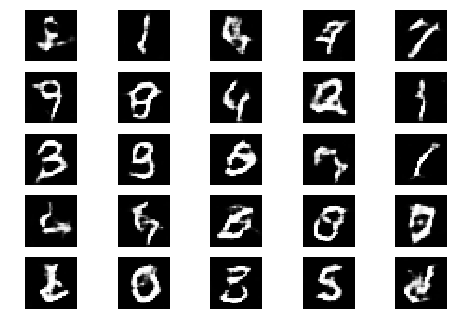

Epoch 1 Batch 851/1875 [D loss: 0.609886, acc.: 62.50%] [G loss: 0.972159]
Epoch 1 Batch 852/1875 [D loss: 0.561111, acc.: 68.75%] [G loss: 0.935324]
Epoch 1 Batch 853/1875 [D loss: 0.661703, acc.: 68.75%] [G loss: 1.122430]
Epoch 1 Batch 854/1875 [D loss: 0.803375, acc.: 53.12%] [G loss: 1.106216]
Epoch 1 Batch 855/1875 [D loss: 0.618604, acc.: 65.62%] [G loss: 1.077870]
Epoch 1 Batch 856/1875 [D loss: 0.635824, acc.: 62.50%] [G loss: 1.079268]
Epoch 1 Batch 857/1875 [D loss: 0.690042, acc.: 62.50%] [G loss: 1.093174]
Epoch 1 Batch 858/1875 [D loss: 0.610040, acc.: 62.50%] [G loss: 1.059923]
Epoch 1 Batch 859/1875 [D loss: 0.661095, acc.: 68.75%] [G loss: 1.028733]
Epoch 1 Batch 860/1875 [D loss: 0.730018, acc.: 50.00%] [G loss: 1.361453]
Epoch 1 Batch 861/1875 [D loss: 0.726431, acc.: 53.12%] [G loss: 1.035862]
Epoch 1 Batch 862/1875 [D loss: 0.705073, acc.: 56.25%] [G loss: 1.022896]
Epoch 1 Batch 863/1875 [D loss: 0.819349, acc.: 43.75%] [G loss: 0.908348]
Epoch 1 Batch 864/1875 [D

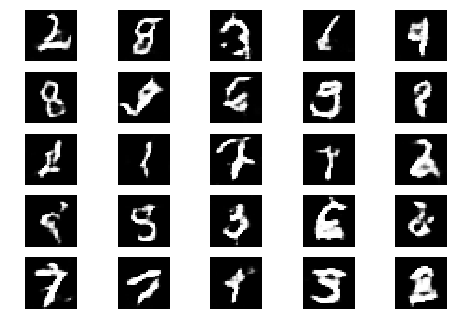

Epoch 1 Batch 901/1875 [D loss: 0.720974, acc.: 43.75%] [G loss: 1.079587]
Epoch 1 Batch 902/1875 [D loss: 0.592782, acc.: 71.88%] [G loss: 1.020216]
Epoch 1 Batch 903/1875 [D loss: 0.578273, acc.: 78.12%] [G loss: 1.240654]
Epoch 1 Batch 904/1875 [D loss: 0.851836, acc.: 50.00%] [G loss: 1.189816]
Epoch 1 Batch 905/1875 [D loss: 0.686585, acc.: 65.62%] [G loss: 1.232281]
Epoch 1 Batch 906/1875 [D loss: 0.691213, acc.: 59.38%] [G loss: 1.056771]
Epoch 1 Batch 907/1875 [D loss: 0.744281, acc.: 59.38%] [G loss: 1.032691]
Epoch 1 Batch 908/1875 [D loss: 0.576043, acc.: 71.88%] [G loss: 0.900144]
Epoch 1 Batch 909/1875 [D loss: 0.681299, acc.: 50.00%] [G loss: 1.066451]
Epoch 1 Batch 910/1875 [D loss: 0.805415, acc.: 50.00%] [G loss: 0.926904]
Epoch 1 Batch 911/1875 [D loss: 0.661859, acc.: 65.62%] [G loss: 1.037421]
Epoch 1 Batch 912/1875 [D loss: 0.675244, acc.: 65.62%] [G loss: 1.119558]
Epoch 1 Batch 913/1875 [D loss: 0.638490, acc.: 68.75%] [G loss: 0.856428]
Epoch 1 Batch 914/1875 [D

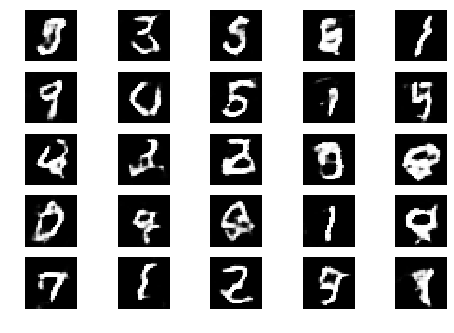

Epoch 1 Batch 951/1875 [D loss: 0.615165, acc.: 68.75%] [G loss: 0.966741]
Epoch 1 Batch 952/1875 [D loss: 0.820276, acc.: 56.25%] [G loss: 0.999438]
Epoch 1 Batch 953/1875 [D loss: 0.620124, acc.: 71.88%] [G loss: 1.042652]
Epoch 1 Batch 954/1875 [D loss: 0.756538, acc.: 46.88%] [G loss: 1.050733]
Epoch 1 Batch 955/1875 [D loss: 0.643238, acc.: 56.25%] [G loss: 1.151566]
Epoch 1 Batch 956/1875 [D loss: 0.735164, acc.: 62.50%] [G loss: 0.938321]
Epoch 1 Batch 957/1875 [D loss: 0.701830, acc.: 53.12%] [G loss: 0.999026]
Epoch 1 Batch 958/1875 [D loss: 0.636857, acc.: 59.38%] [G loss: 0.901638]
Epoch 1 Batch 959/1875 [D loss: 0.674904, acc.: 59.38%] [G loss: 1.154103]
Epoch 1 Batch 960/1875 [D loss: 0.717708, acc.: 62.50%] [G loss: 1.121993]
Epoch 1 Batch 961/1875 [D loss: 0.757985, acc.: 53.12%] [G loss: 0.921106]
Epoch 1 Batch 962/1875 [D loss: 0.575471, acc.: 68.75%] [G loss: 1.000967]
Epoch 1 Batch 963/1875 [D loss: 0.621328, acc.: 59.38%] [G loss: 1.011909]
Epoch 1 Batch 964/1875 [D

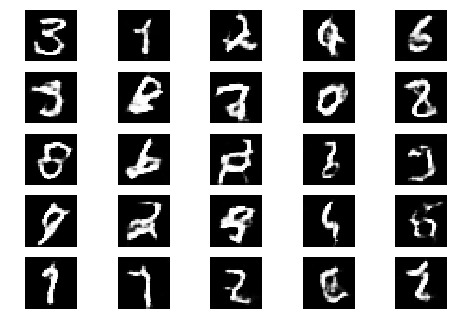

Epoch 1 Batch 1001/1875 [D loss: 0.816387, acc.: 56.25%] [G loss: 1.022243]
Epoch 1 Batch 1002/1875 [D loss: 0.504900, acc.: 78.12%] [G loss: 1.100613]
Epoch 1 Batch 1003/1875 [D loss: 0.609811, acc.: 62.50%] [G loss: 1.309805]
Epoch 1 Batch 1004/1875 [D loss: 0.737317, acc.: 50.00%] [G loss: 0.877547]
Epoch 1 Batch 1005/1875 [D loss: 0.691774, acc.: 65.62%] [G loss: 0.952829]
Epoch 1 Batch 1006/1875 [D loss: 0.660921, acc.: 65.62%] [G loss: 0.862593]
Epoch 1 Batch 1007/1875 [D loss: 0.670816, acc.: 62.50%] [G loss: 1.000159]
Epoch 1 Batch 1008/1875 [D loss: 0.682237, acc.: 62.50%] [G loss: 1.002438]
Epoch 1 Batch 1009/1875 [D loss: 0.696848, acc.: 62.50%] [G loss: 1.057241]
Epoch 1 Batch 1010/1875 [D loss: 0.471879, acc.: 87.50%] [G loss: 1.006784]
Epoch 1 Batch 1011/1875 [D loss: 0.637868, acc.: 59.38%] [G loss: 0.925308]
Epoch 1 Batch 1012/1875 [D loss: 0.781144, acc.: 53.12%] [G loss: 0.939848]
Epoch 1 Batch 1013/1875 [D loss: 0.561839, acc.: 71.88%] [G loss: 1.090267]
Epoch 1 Batc

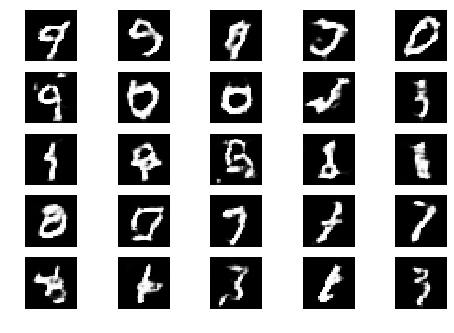

Epoch 1 Batch 1051/1875 [D loss: 0.777328, acc.: 50.00%] [G loss: 1.118691]
Epoch 1 Batch 1052/1875 [D loss: 0.672199, acc.: 56.25%] [G loss: 1.045690]
Epoch 1 Batch 1053/1875 [D loss: 0.716268, acc.: 50.00%] [G loss: 0.934938]
Epoch 1 Batch 1054/1875 [D loss: 0.628239, acc.: 59.38%] [G loss: 0.722252]
Epoch 1 Batch 1055/1875 [D loss: 0.650351, acc.: 65.62%] [G loss: 0.854506]
Epoch 1 Batch 1056/1875 [D loss: 0.738079, acc.: 62.50%] [G loss: 1.173144]
Epoch 1 Batch 1057/1875 [D loss: 0.753964, acc.: 53.12%] [G loss: 1.098881]
Epoch 1 Batch 1058/1875 [D loss: 0.561690, acc.: 71.88%] [G loss: 1.035313]
Epoch 1 Batch 1059/1875 [D loss: 0.686717, acc.: 56.25%] [G loss: 0.868264]
Epoch 1 Batch 1060/1875 [D loss: 0.656105, acc.: 65.62%] [G loss: 0.863065]
Epoch 1 Batch 1061/1875 [D loss: 0.679707, acc.: 56.25%] [G loss: 1.118239]
Epoch 1 Batch 1062/1875 [D loss: 0.687468, acc.: 59.38%] [G loss: 1.205787]
Epoch 1 Batch 1063/1875 [D loss: 0.661841, acc.: 53.12%] [G loss: 1.190992]
Epoch 1 Batc

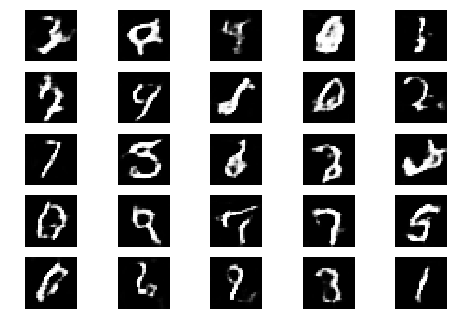

Epoch 1 Batch 1101/1875 [D loss: 0.655107, acc.: 59.38%] [G loss: 0.993349]
Epoch 1 Batch 1102/1875 [D loss: 0.822333, acc.: 50.00%] [G loss: 1.044419]
Epoch 1 Batch 1103/1875 [D loss: 0.554401, acc.: 78.12%] [G loss: 1.015724]
Epoch 1 Batch 1104/1875 [D loss: 0.531441, acc.: 78.12%] [G loss: 1.065552]
Epoch 1 Batch 1105/1875 [D loss: 0.695422, acc.: 56.25%] [G loss: 0.908046]
Epoch 1 Batch 1106/1875 [D loss: 0.546931, acc.: 71.88%] [G loss: 1.105351]
Epoch 1 Batch 1107/1875 [D loss: 0.666150, acc.: 65.62%] [G loss: 1.075889]
Epoch 1 Batch 1108/1875 [D loss: 0.676308, acc.: 56.25%] [G loss: 0.898019]
Epoch 1 Batch 1109/1875 [D loss: 0.625450, acc.: 68.75%] [G loss: 1.043530]
Epoch 1 Batch 1110/1875 [D loss: 0.561749, acc.: 71.88%] [G loss: 1.350452]
Epoch 1 Batch 1111/1875 [D loss: 0.661275, acc.: 65.62%] [G loss: 0.910621]
Epoch 1 Batch 1112/1875 [D loss: 0.646419, acc.: 68.75%] [G loss: 1.050401]
Epoch 1 Batch 1113/1875 [D loss: 0.607115, acc.: 68.75%] [G loss: 0.836508]
Epoch 1 Batc

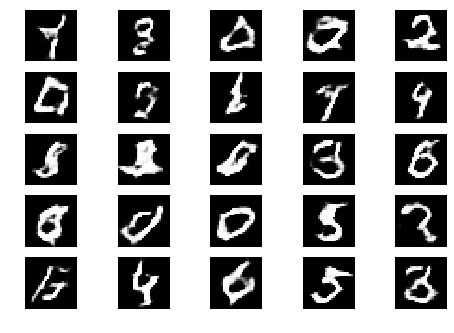

Epoch 1 Batch 1151/1875 [D loss: 0.622471, acc.: 62.50%] [G loss: 1.083232]
Epoch 1 Batch 1152/1875 [D loss: 0.587628, acc.: 65.62%] [G loss: 0.940501]
Epoch 1 Batch 1153/1875 [D loss: 0.710313, acc.: 62.50%] [G loss: 1.045919]
Epoch 1 Batch 1154/1875 [D loss: 0.663147, acc.: 62.50%] [G loss: 1.301820]
Epoch 1 Batch 1155/1875 [D loss: 0.704050, acc.: 50.00%] [G loss: 1.173420]
Epoch 1 Batch 1156/1875 [D loss: 0.627158, acc.: 59.38%] [G loss: 0.939206]
Epoch 1 Batch 1157/1875 [D loss: 0.534628, acc.: 75.00%] [G loss: 0.954863]
Epoch 1 Batch 1158/1875 [D loss: 0.595509, acc.: 71.88%] [G loss: 1.162205]
Epoch 1 Batch 1159/1875 [D loss: 0.601874, acc.: 65.62%] [G loss: 0.911182]
Epoch 1 Batch 1160/1875 [D loss: 0.697599, acc.: 56.25%] [G loss: 0.942381]
Epoch 1 Batch 1161/1875 [D loss: 0.694210, acc.: 53.12%] [G loss: 0.846403]
Epoch 1 Batch 1162/1875 [D loss: 0.714582, acc.: 56.25%] [G loss: 0.977293]
Epoch 1 Batch 1163/1875 [D loss: 0.582516, acc.: 75.00%] [G loss: 0.944499]
Epoch 1 Batc

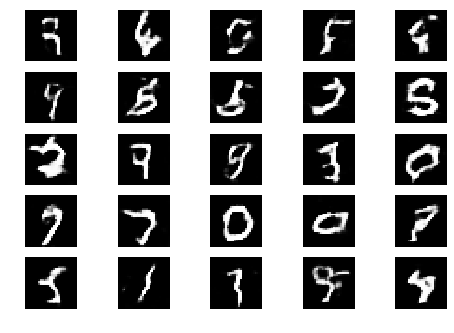

Epoch 1 Batch 1201/1875 [D loss: 0.640198, acc.: 59.38%] [G loss: 1.118551]
Epoch 1 Batch 1202/1875 [D loss: 0.700685, acc.: 65.62%] [G loss: 1.103027]
Epoch 1 Batch 1203/1875 [D loss: 0.759220, acc.: 53.12%] [G loss: 0.907119]
Epoch 1 Batch 1204/1875 [D loss: 0.723861, acc.: 59.38%] [G loss: 0.959182]
Epoch 1 Batch 1205/1875 [D loss: 0.723725, acc.: 53.12%] [G loss: 1.174756]
Epoch 1 Batch 1206/1875 [D loss: 0.569800, acc.: 71.88%] [G loss: 1.096626]
Epoch 1 Batch 1207/1875 [D loss: 0.547987, acc.: 71.88%] [G loss: 0.960109]
Epoch 1 Batch 1208/1875 [D loss: 0.511716, acc.: 75.00%] [G loss: 0.986622]
Epoch 1 Batch 1209/1875 [D loss: 0.644939, acc.: 53.12%] [G loss: 0.862185]
Epoch 1 Batch 1210/1875 [D loss: 0.611906, acc.: 68.75%] [G loss: 1.048341]
Epoch 1 Batch 1211/1875 [D loss: 0.614406, acc.: 68.75%] [G loss: 0.999637]
Epoch 1 Batch 1212/1875 [D loss: 0.713108, acc.: 53.12%] [G loss: 1.004787]
Epoch 1 Batch 1213/1875 [D loss: 0.568904, acc.: 68.75%] [G loss: 0.880144]
Epoch 1 Batc

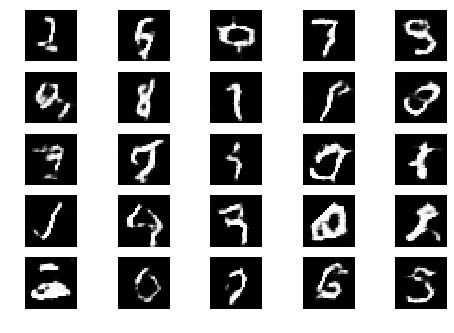

Epoch 1 Batch 1251/1875 [D loss: 0.864650, acc.: 43.75%] [G loss: 1.069471]
Epoch 1 Batch 1252/1875 [D loss: 0.643070, acc.: 68.75%] [G loss: 0.968564]
Epoch 1 Batch 1253/1875 [D loss: 0.634131, acc.: 62.50%] [G loss: 0.967777]
Epoch 1 Batch 1254/1875 [D loss: 0.693843, acc.: 68.75%] [G loss: 1.018407]
Epoch 1 Batch 1255/1875 [D loss: 0.524472, acc.: 71.88%] [G loss: 0.936339]
Epoch 1 Batch 1256/1875 [D loss: 0.783480, acc.: 50.00%] [G loss: 0.904390]
Epoch 1 Batch 1257/1875 [D loss: 0.714595, acc.: 53.12%] [G loss: 0.995700]
Epoch 1 Batch 1258/1875 [D loss: 0.644778, acc.: 68.75%] [G loss: 0.744411]
Epoch 1 Batch 1259/1875 [D loss: 0.642233, acc.: 56.25%] [G loss: 0.980833]
Epoch 1 Batch 1260/1875 [D loss: 0.792055, acc.: 46.88%] [G loss: 0.984287]
Epoch 1 Batch 1261/1875 [D loss: 0.571896, acc.: 68.75%] [G loss: 0.924468]
Epoch 1 Batch 1262/1875 [D loss: 0.729704, acc.: 59.38%] [G loss: 1.041880]
Epoch 1 Batch 1263/1875 [D loss: 0.591332, acc.: 71.88%] [G loss: 1.053807]
Epoch 1 Batc

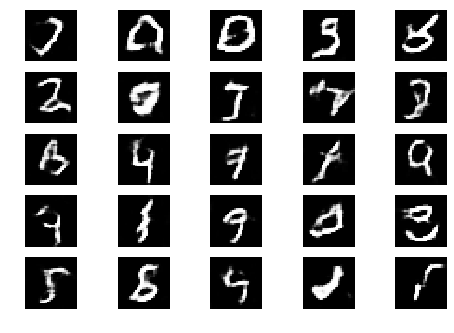

Epoch 1 Batch 1301/1875 [D loss: 0.575337, acc.: 62.50%] [G loss: 1.072219]
Epoch 1 Batch 1302/1875 [D loss: 0.655837, acc.: 59.38%] [G loss: 1.062946]
Epoch 1 Batch 1303/1875 [D loss: 0.541725, acc.: 68.75%] [G loss: 0.991610]
Epoch 1 Batch 1304/1875 [D loss: 0.580167, acc.: 75.00%] [G loss: 0.933592]
Epoch 1 Batch 1305/1875 [D loss: 0.784440, acc.: 50.00%] [G loss: 0.977675]
Epoch 1 Batch 1306/1875 [D loss: 0.590178, acc.: 62.50%] [G loss: 1.119117]
Epoch 1 Batch 1307/1875 [D loss: 0.684986, acc.: 59.38%] [G loss: 0.961187]
Epoch 1 Batch 1308/1875 [D loss: 0.614837, acc.: 71.88%] [G loss: 1.091144]
Epoch 1 Batch 1309/1875 [D loss: 0.510811, acc.: 75.00%] [G loss: 0.994343]
Epoch 1 Batch 1310/1875 [D loss: 0.633313, acc.: 65.62%] [G loss: 0.995432]
Epoch 1 Batch 1311/1875 [D loss: 0.722810, acc.: 62.50%] [G loss: 1.140958]
Epoch 1 Batch 1312/1875 [D loss: 0.663492, acc.: 56.25%] [G loss: 0.941079]
Epoch 1 Batch 1313/1875 [D loss: 0.639228, acc.: 65.62%] [G loss: 1.075232]
Epoch 1 Batc

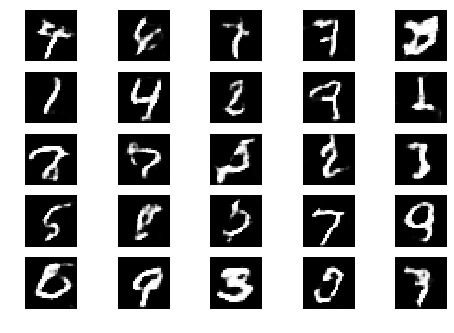

Epoch 1 Batch 1351/1875 [D loss: 0.736262, acc.: 50.00%] [G loss: 0.830917]
Epoch 1 Batch 1352/1875 [D loss: 0.681670, acc.: 65.62%] [G loss: 0.964137]
Epoch 1 Batch 1353/1875 [D loss: 0.693447, acc.: 56.25%] [G loss: 0.987800]
Epoch 1 Batch 1354/1875 [D loss: 0.629779, acc.: 68.75%] [G loss: 0.971562]
Epoch 1 Batch 1355/1875 [D loss: 0.790444, acc.: 59.38%] [G loss: 1.093086]
Epoch 1 Batch 1356/1875 [D loss: 0.752305, acc.: 50.00%] [G loss: 1.198788]
Epoch 1 Batch 1357/1875 [D loss: 0.624414, acc.: 75.00%] [G loss: 1.010868]
Epoch 1 Batch 1358/1875 [D loss: 0.745337, acc.: 50.00%] [G loss: 0.958034]
Epoch 1 Batch 1359/1875 [D loss: 0.774893, acc.: 53.12%] [G loss: 0.964235]
Epoch 1 Batch 1360/1875 [D loss: 0.644364, acc.: 62.50%] [G loss: 1.157391]
Epoch 1 Batch 1361/1875 [D loss: 0.708307, acc.: 50.00%] [G loss: 1.010409]
Epoch 1 Batch 1362/1875 [D loss: 0.619235, acc.: 65.62%] [G loss: 1.201023]
Epoch 1 Batch 1363/1875 [D loss: 0.652442, acc.: 59.38%] [G loss: 1.029970]
Epoch 1 Batc

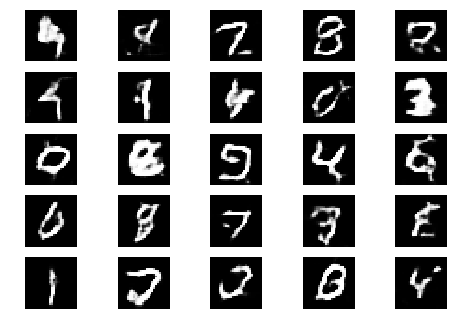

Epoch 1 Batch 1401/1875 [D loss: 0.690731, acc.: 59.38%] [G loss: 1.106574]
Epoch 1 Batch 1402/1875 [D loss: 0.740866, acc.: 53.12%] [G loss: 1.051986]
Epoch 1 Batch 1403/1875 [D loss: 0.710900, acc.: 53.12%] [G loss: 1.059331]
Epoch 1 Batch 1404/1875 [D loss: 0.709718, acc.: 53.12%] [G loss: 0.942986]
Epoch 1 Batch 1405/1875 [D loss: 0.539552, acc.: 71.88%] [G loss: 0.962369]
Epoch 1 Batch 1406/1875 [D loss: 0.652158, acc.: 59.38%] [G loss: 0.991207]
Epoch 1 Batch 1407/1875 [D loss: 0.681679, acc.: 59.38%] [G loss: 0.907780]
Epoch 1 Batch 1408/1875 [D loss: 0.598974, acc.: 65.62%] [G loss: 1.144625]
Epoch 1 Batch 1409/1875 [D loss: 0.670458, acc.: 53.12%] [G loss: 1.078479]
Epoch 1 Batch 1410/1875 [D loss: 0.727030, acc.: 53.12%] [G loss: 1.123445]
Epoch 1 Batch 1411/1875 [D loss: 0.745726, acc.: 46.88%] [G loss: 1.050798]
Epoch 1 Batch 1412/1875 [D loss: 0.681422, acc.: 65.62%] [G loss: 1.054273]
Epoch 1 Batch 1413/1875 [D loss: 0.925004, acc.: 37.50%] [G loss: 0.985608]
Epoch 1 Batc

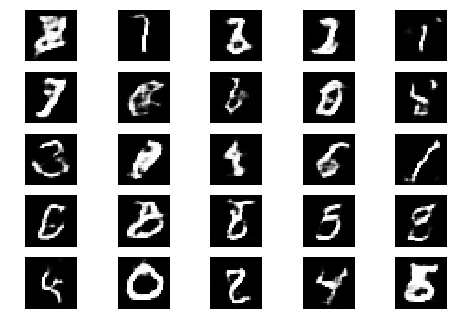

Epoch 1 Batch 1451/1875 [D loss: 0.681105, acc.: 71.88%] [G loss: 0.829204]
Epoch 1 Batch 1452/1875 [D loss: 0.738764, acc.: 40.62%] [G loss: 1.122060]
Epoch 1 Batch 1453/1875 [D loss: 0.637607, acc.: 56.25%] [G loss: 1.072096]
Epoch 1 Batch 1454/1875 [D loss: 0.858518, acc.: 37.50%] [G loss: 1.060876]
Epoch 1 Batch 1455/1875 [D loss: 0.491872, acc.: 81.25%] [G loss: 1.292949]
Epoch 1 Batch 1456/1875 [D loss: 0.739160, acc.: 56.25%] [G loss: 1.004552]
Epoch 1 Batch 1457/1875 [D loss: 0.602594, acc.: 71.88%] [G loss: 0.895880]
Epoch 1 Batch 1458/1875 [D loss: 0.620719, acc.: 68.75%] [G loss: 1.046942]
Epoch 1 Batch 1459/1875 [D loss: 0.713638, acc.: 62.50%] [G loss: 1.032444]
Epoch 1 Batch 1460/1875 [D loss: 0.666574, acc.: 65.62%] [G loss: 1.131288]
Epoch 1 Batch 1461/1875 [D loss: 0.746974, acc.: 50.00%] [G loss: 0.922283]
Epoch 1 Batch 1462/1875 [D loss: 0.642556, acc.: 62.50%] [G loss: 1.243372]
Epoch 1 Batch 1463/1875 [D loss: 0.683342, acc.: 46.88%] [G loss: 0.970192]
Epoch 1 Batc

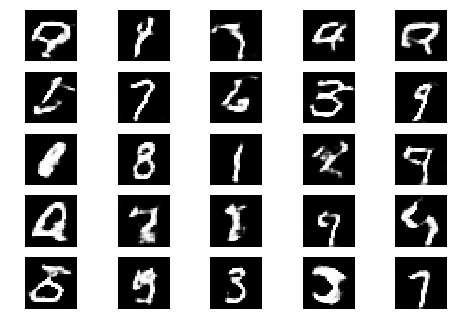

Epoch 1 Batch 1501/1875 [D loss: 0.859734, acc.: 53.12%] [G loss: 0.848907]
Epoch 1 Batch 1502/1875 [D loss: 0.798252, acc.: 43.75%] [G loss: 1.032223]
Epoch 1 Batch 1503/1875 [D loss: 0.567625, acc.: 65.62%] [G loss: 1.195377]
Epoch 1 Batch 1504/1875 [D loss: 0.559501, acc.: 78.12%] [G loss: 0.958122]
Epoch 1 Batch 1505/1875 [D loss: 0.583752, acc.: 71.88%] [G loss: 0.801161]
Epoch 1 Batch 1506/1875 [D loss: 0.641825, acc.: 65.62%] [G loss: 0.974443]
Epoch 1 Batch 1507/1875 [D loss: 0.588457, acc.: 68.75%] [G loss: 0.997998]
Epoch 1 Batch 1508/1875 [D loss: 0.665841, acc.: 56.25%] [G loss: 0.854190]
Epoch 1 Batch 1509/1875 [D loss: 0.737396, acc.: 46.88%] [G loss: 0.957729]
Epoch 1 Batch 1510/1875 [D loss: 0.624333, acc.: 65.62%] [G loss: 1.377329]
Epoch 1 Batch 1511/1875 [D loss: 0.781330, acc.: 56.25%] [G loss: 1.053330]
Epoch 1 Batch 1512/1875 [D loss: 0.712524, acc.: 65.62%] [G loss: 0.970964]
Epoch 1 Batch 1513/1875 [D loss: 0.632714, acc.: 59.38%] [G loss: 1.048192]
Epoch 1 Batc

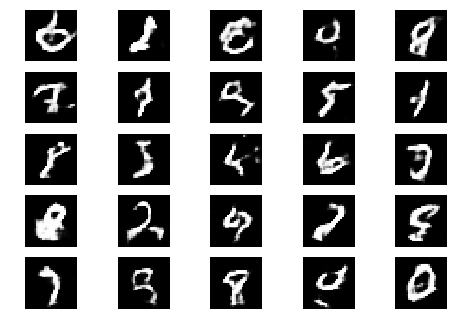

Epoch 1 Batch 1551/1875 [D loss: 0.786731, acc.: 50.00%] [G loss: 1.122287]
Epoch 1 Batch 1552/1875 [D loss: 0.580264, acc.: 59.38%] [G loss: 0.985594]
Epoch 1 Batch 1553/1875 [D loss: 0.626770, acc.: 59.38%] [G loss: 0.874417]
Epoch 1 Batch 1554/1875 [D loss: 0.611575, acc.: 65.62%] [G loss: 1.032831]
Epoch 1 Batch 1555/1875 [D loss: 0.848146, acc.: 37.50%] [G loss: 1.089144]
Epoch 1 Batch 1556/1875 [D loss: 0.705414, acc.: 56.25%] [G loss: 0.996768]
Epoch 1 Batch 1557/1875 [D loss: 0.777558, acc.: 56.25%] [G loss: 0.956212]
Epoch 1 Batch 1558/1875 [D loss: 0.606545, acc.: 62.50%] [G loss: 0.931978]
Epoch 1 Batch 1559/1875 [D loss: 0.544606, acc.: 84.38%] [G loss: 1.097492]
Epoch 1 Batch 1560/1875 [D loss: 0.652527, acc.: 46.88%] [G loss: 0.989015]
Epoch 1 Batch 1561/1875 [D loss: 0.613350, acc.: 68.75%] [G loss: 0.826715]
Epoch 1 Batch 1562/1875 [D loss: 0.763471, acc.: 46.88%] [G loss: 1.111709]
Epoch 1 Batch 1563/1875 [D loss: 0.572696, acc.: 65.62%] [G loss: 1.067516]
Epoch 1 Batc

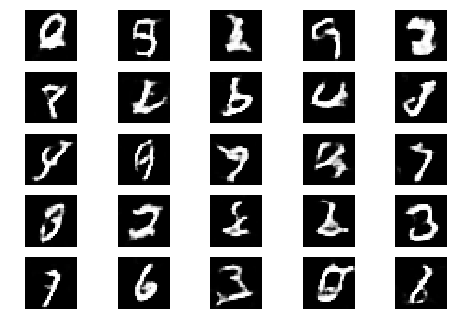

Epoch 1 Batch 1601/1875 [D loss: 0.765858, acc.: 50.00%] [G loss: 1.002837]
Epoch 1 Batch 1602/1875 [D loss: 0.720470, acc.: 40.62%] [G loss: 0.881190]
Epoch 1 Batch 1603/1875 [D loss: 0.601175, acc.: 71.88%] [G loss: 0.947843]
Epoch 1 Batch 1604/1875 [D loss: 0.583125, acc.: 65.62%] [G loss: 0.885563]
Epoch 1 Batch 1605/1875 [D loss: 0.529073, acc.: 75.00%] [G loss: 1.116409]
Epoch 1 Batch 1606/1875 [D loss: 0.726833, acc.: 50.00%] [G loss: 0.882191]
Epoch 1 Batch 1607/1875 [D loss: 0.622353, acc.: 65.62%] [G loss: 0.979874]
Epoch 1 Batch 1608/1875 [D loss: 0.708395, acc.: 56.25%] [G loss: 1.015572]
Epoch 1 Batch 1609/1875 [D loss: 0.709645, acc.: 59.38%] [G loss: 1.110198]
Epoch 1 Batch 1610/1875 [D loss: 0.704844, acc.: 56.25%] [G loss: 1.181715]
Epoch 1 Batch 1611/1875 [D loss: 0.660162, acc.: 59.38%] [G loss: 0.963186]
Epoch 1 Batch 1612/1875 [D loss: 0.685907, acc.: 59.38%] [G loss: 1.276767]
Epoch 1 Batch 1613/1875 [D loss: 0.670476, acc.: 56.25%] [G loss: 1.073355]
Epoch 1 Batc

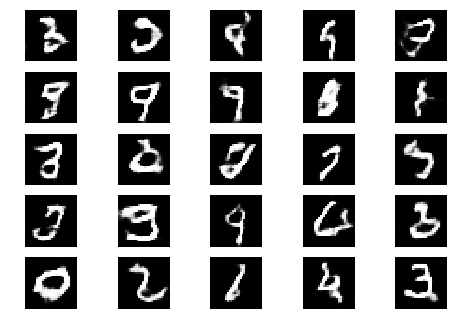

Epoch 1 Batch 1651/1875 [D loss: 0.594249, acc.: 75.00%] [G loss: 1.005149]
Epoch 1 Batch 1652/1875 [D loss: 0.694017, acc.: 62.50%] [G loss: 1.129274]
Epoch 1 Batch 1653/1875 [D loss: 0.709296, acc.: 53.12%] [G loss: 1.006012]
Epoch 1 Batch 1654/1875 [D loss: 0.704004, acc.: 50.00%] [G loss: 0.877671]
Epoch 1 Batch 1655/1875 [D loss: 0.599747, acc.: 62.50%] [G loss: 1.043359]
Epoch 1 Batch 1656/1875 [D loss: 0.712876, acc.: 59.38%] [G loss: 1.199355]
Epoch 1 Batch 1657/1875 [D loss: 0.618683, acc.: 56.25%] [G loss: 0.816549]
Epoch 1 Batch 1658/1875 [D loss: 0.715170, acc.: 50.00%] [G loss: 0.905533]
Epoch 1 Batch 1659/1875 [D loss: 0.738288, acc.: 50.00%] [G loss: 1.013928]
Epoch 1 Batch 1660/1875 [D loss: 0.519935, acc.: 87.50%] [G loss: 0.960978]
Epoch 1 Batch 1661/1875 [D loss: 0.717631, acc.: 50.00%] [G loss: 0.929005]
Epoch 1 Batch 1662/1875 [D loss: 0.572212, acc.: 78.12%] [G loss: 0.809464]
Epoch 1 Batch 1663/1875 [D loss: 0.807358, acc.: 40.62%] [G loss: 0.933653]
Epoch 1 Batc

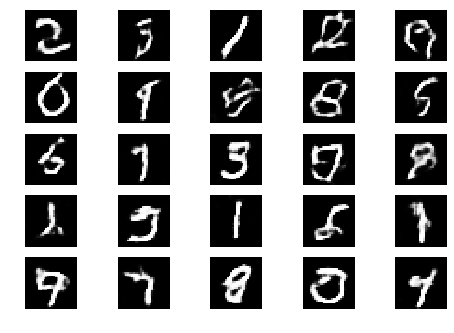

Epoch 1 Batch 1701/1875 [D loss: 0.637150, acc.: 65.62%] [G loss: 0.823479]
Epoch 1 Batch 1702/1875 [D loss: 0.613962, acc.: 68.75%] [G loss: 0.866367]
Epoch 1 Batch 1703/1875 [D loss: 0.582737, acc.: 71.88%] [G loss: 0.860768]
Epoch 1 Batch 1704/1875 [D loss: 0.630329, acc.: 62.50%] [G loss: 1.089663]
Epoch 1 Batch 1705/1875 [D loss: 0.544790, acc.: 68.75%] [G loss: 1.203714]
Epoch 1 Batch 1706/1875 [D loss: 0.870695, acc.: 34.38%] [G loss: 0.965908]
Epoch 1 Batch 1707/1875 [D loss: 0.564666, acc.: 68.75%] [G loss: 1.261541]
Epoch 1 Batch 1708/1875 [D loss: 0.762071, acc.: 43.75%] [G loss: 1.230864]
Epoch 1 Batch 1709/1875 [D loss: 0.695306, acc.: 59.38%] [G loss: 1.267458]
Epoch 1 Batch 1710/1875 [D loss: 0.707899, acc.: 53.12%] [G loss: 1.080374]
Epoch 1 Batch 1711/1875 [D loss: 0.543653, acc.: 71.88%] [G loss: 1.151705]
Epoch 1 Batch 1712/1875 [D loss: 0.560399, acc.: 84.38%] [G loss: 0.908472]
Epoch 1 Batch 1713/1875 [D loss: 0.620920, acc.: 68.75%] [G loss: 0.972020]
Epoch 1 Batc

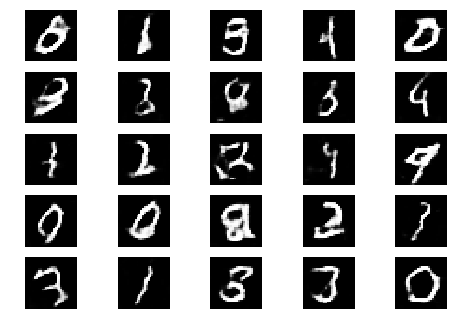

Epoch 1 Batch 1751/1875 [D loss: 0.690470, acc.: 43.75%] [G loss: 0.772979]
Epoch 1 Batch 1752/1875 [D loss: 0.625584, acc.: 62.50%] [G loss: 1.131467]
Epoch 1 Batch 1753/1875 [D loss: 0.609634, acc.: 68.75%] [G loss: 1.048131]
Epoch 1 Batch 1754/1875 [D loss: 0.564276, acc.: 65.62%] [G loss: 1.032763]
Epoch 1 Batch 1755/1875 [D loss: 0.680949, acc.: 65.62%] [G loss: 0.980126]
Epoch 1 Batch 1756/1875 [D loss: 0.674531, acc.: 53.12%] [G loss: 0.939357]
Epoch 1 Batch 1757/1875 [D loss: 0.615854, acc.: 75.00%] [G loss: 0.874744]
Epoch 1 Batch 1758/1875 [D loss: 0.622824, acc.: 56.25%] [G loss: 1.031069]
Epoch 1 Batch 1759/1875 [D loss: 0.654794, acc.: 59.38%] [G loss: 1.107044]
Epoch 1 Batch 1760/1875 [D loss: 0.561419, acc.: 68.75%] [G loss: 0.969378]
Epoch 1 Batch 1761/1875 [D loss: 0.570102, acc.: 71.88%] [G loss: 0.814650]
Epoch 1 Batch 1762/1875 [D loss: 0.723209, acc.: 59.38%] [G loss: 0.774033]
Epoch 1 Batch 1763/1875 [D loss: 0.639687, acc.: 71.88%] [G loss: 1.035190]
Epoch 1 Batc

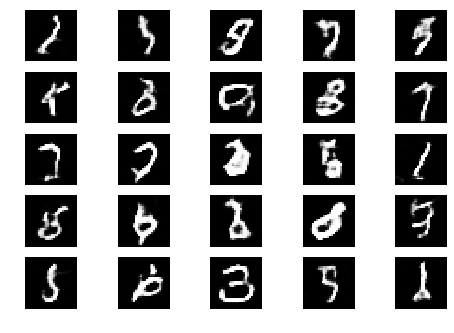

Epoch 1 Batch 1801/1875 [D loss: 0.600912, acc.: 71.88%] [G loss: 0.967161]
Epoch 1 Batch 1802/1875 [D loss: 0.708048, acc.: 59.38%] [G loss: 1.253084]
Epoch 1 Batch 1803/1875 [D loss: 0.683168, acc.: 62.50%] [G loss: 1.081310]
Epoch 1 Batch 1804/1875 [D loss: 0.701727, acc.: 53.12%] [G loss: 1.230858]
Epoch 1 Batch 1805/1875 [D loss: 0.568632, acc.: 68.75%] [G loss: 0.998452]
Epoch 1 Batch 1806/1875 [D loss: 0.668172, acc.: 62.50%] [G loss: 1.052553]
Epoch 1 Batch 1807/1875 [D loss: 0.616358, acc.: 53.12%] [G loss: 1.103191]
Epoch 1 Batch 1808/1875 [D loss: 0.701994, acc.: 53.12%] [G loss: 0.936214]
Epoch 1 Batch 1809/1875 [D loss: 0.635764, acc.: 56.25%] [G loss: 0.904392]
Epoch 1 Batch 1810/1875 [D loss: 0.780879, acc.: 53.12%] [G loss: 0.954904]
Epoch 1 Batch 1811/1875 [D loss: 0.577122, acc.: 71.88%] [G loss: 1.008347]
Epoch 1 Batch 1812/1875 [D loss: 0.809465, acc.: 43.75%] [G loss: 1.016195]
Epoch 1 Batch 1813/1875 [D loss: 0.628933, acc.: 62.50%] [G loss: 1.099202]
Epoch 1 Batc

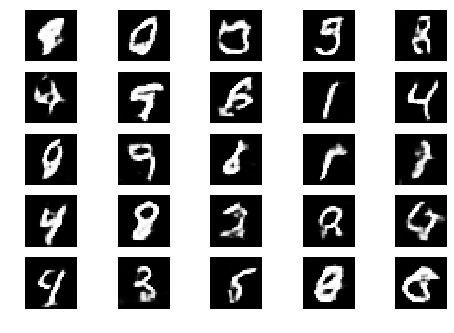

Epoch 1 Batch 1851/1875 [D loss: 0.582527, acc.: 62.50%] [G loss: 1.140443]
Epoch 1 Batch 1852/1875 [D loss: 0.491162, acc.: 87.50%] [G loss: 1.004297]
Epoch 1 Batch 1853/1875 [D loss: 0.658762, acc.: 65.62%] [G loss: 0.971055]
Epoch 1 Batch 1854/1875 [D loss: 0.777831, acc.: 50.00%] [G loss: 0.867869]
Epoch 1 Batch 1855/1875 [D loss: 0.615390, acc.: 68.75%] [G loss: 1.069895]
Epoch 1 Batch 1856/1875 [D loss: 0.621602, acc.: 59.38%] [G loss: 1.309391]
Epoch 1 Batch 1857/1875 [D loss: 0.678744, acc.: 50.00%] [G loss: 1.003780]
Epoch 1 Batch 1858/1875 [D loss: 0.695831, acc.: 53.12%] [G loss: 1.094010]
Epoch 1 Batch 1859/1875 [D loss: 0.596184, acc.: 68.75%] [G loss: 1.050274]
Epoch 1 Batch 1860/1875 [D loss: 0.603715, acc.: 62.50%] [G loss: 0.886083]
Epoch 1 Batch 1861/1875 [D loss: 0.694431, acc.: 50.00%] [G loss: 0.993073]
Epoch 1 Batch 1862/1875 [D loss: 0.802548, acc.: 46.88%] [G loss: 1.171292]
Epoch 1 Batch 1863/1875 [D loss: 0.705083, acc.: 62.50%] [G loss: 0.980352]
Epoch 1 Batc

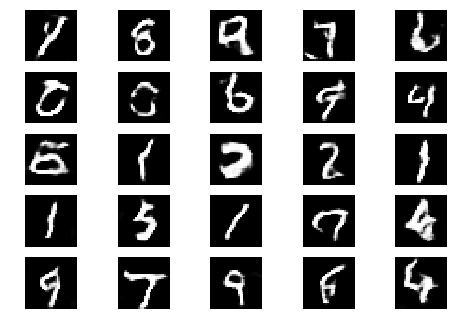

Epoch 2 Batch 1/1875 [D loss: 0.640173, acc.: 59.38%] [G loss: 0.842438]
Epoch 2 Batch 2/1875 [D loss: 0.690289, acc.: 56.25%] [G loss: 1.087569]
Epoch 2 Batch 3/1875 [D loss: 0.704459, acc.: 59.38%] [G loss: 0.968027]
Epoch 2 Batch 4/1875 [D loss: 0.620058, acc.: 68.75%] [G loss: 1.043909]
Epoch 2 Batch 5/1875 [D loss: 0.583142, acc.: 68.75%] [G loss: 1.018709]
Epoch 2 Batch 6/1875 [D loss: 0.660658, acc.: 62.50%] [G loss: 0.921774]
Epoch 2 Batch 7/1875 [D loss: 0.620478, acc.: 53.12%] [G loss: 0.881314]
Epoch 2 Batch 8/1875 [D loss: 0.537936, acc.: 81.25%] [G loss: 0.813821]
Epoch 2 Batch 9/1875 [D loss: 0.654171, acc.: 65.62%] [G loss: 0.982877]
Epoch 2 Batch 10/1875 [D loss: 0.668382, acc.: 62.50%] [G loss: 0.903602]
Epoch 2 Batch 11/1875 [D loss: 0.644706, acc.: 68.75%] [G loss: 1.103068]
Epoch 2 Batch 12/1875 [D loss: 0.671836, acc.: 59.38%] [G loss: 1.079970]
Epoch 2 Batch 13/1875 [D loss: 0.516153, acc.: 78.12%] [G loss: 0.877353]
Epoch 2 Batch 14/1875 [D loss: 0.403204, acc.: 

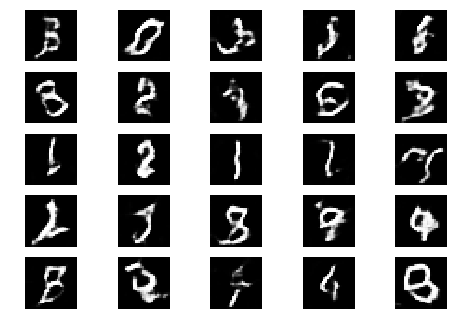

Epoch 2 Batch 51/1875 [D loss: 0.653920, acc.: 59.38%] [G loss: 0.934386]
Epoch 2 Batch 52/1875 [D loss: 0.583308, acc.: 59.38%] [G loss: 0.932419]
Epoch 2 Batch 53/1875 [D loss: 0.643954, acc.: 65.62%] [G loss: 1.035486]
Epoch 2 Batch 54/1875 [D loss: 0.744177, acc.: 56.25%] [G loss: 1.059858]
Epoch 2 Batch 55/1875 [D loss: 0.773420, acc.: 50.00%] [G loss: 1.013301]
Epoch 2 Batch 56/1875 [D loss: 0.662001, acc.: 59.38%] [G loss: 1.102240]
Epoch 2 Batch 57/1875 [D loss: 0.726632, acc.: 50.00%] [G loss: 0.938628]
Epoch 2 Batch 58/1875 [D loss: 0.575673, acc.: 75.00%] [G loss: 1.204756]
Epoch 2 Batch 59/1875 [D loss: 0.765595, acc.: 56.25%] [G loss: 1.025271]
Epoch 2 Batch 60/1875 [D loss: 0.644676, acc.: 62.50%] [G loss: 1.085081]
Epoch 2 Batch 61/1875 [D loss: 0.599924, acc.: 65.62%] [G loss: 1.185444]
Epoch 2 Batch 62/1875 [D loss: 0.581197, acc.: 71.88%] [G loss: 0.999513]
Epoch 2 Batch 63/1875 [D loss: 0.534739, acc.: 81.25%] [G loss: 1.221893]
Epoch 2 Batch 64/1875 [D loss: 0.86082

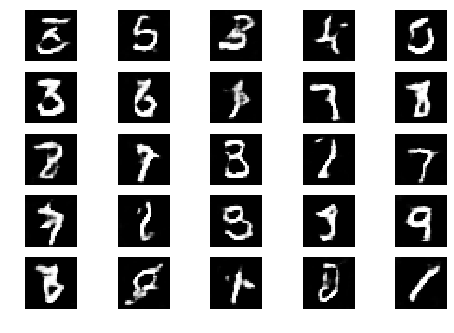

Epoch 2 Batch 101/1875 [D loss: 0.743743, acc.: 50.00%] [G loss: 0.948528]
Epoch 2 Batch 102/1875 [D loss: 0.692207, acc.: 53.12%] [G loss: 0.910898]
Epoch 2 Batch 103/1875 [D loss: 0.664873, acc.: 53.12%] [G loss: 0.883683]
Epoch 2 Batch 104/1875 [D loss: 0.625427, acc.: 50.00%] [G loss: 0.896877]
Epoch 2 Batch 105/1875 [D loss: 0.592709, acc.: 59.38%] [G loss: 1.160593]
Epoch 2 Batch 106/1875 [D loss: 0.624659, acc.: 65.62%] [G loss: 1.078591]
Epoch 2 Batch 107/1875 [D loss: 0.613298, acc.: 65.62%] [G loss: 1.123178]
Epoch 2 Batch 108/1875 [D loss: 0.598768, acc.: 59.38%] [G loss: 0.932957]
Epoch 2 Batch 109/1875 [D loss: 0.545180, acc.: 65.62%] [G loss: 0.894073]
Epoch 2 Batch 110/1875 [D loss: 0.556998, acc.: 75.00%] [G loss: 0.847954]
Epoch 2 Batch 111/1875 [D loss: 0.584833, acc.: 65.62%] [G loss: 1.008549]
Epoch 2 Batch 112/1875 [D loss: 0.456018, acc.: 81.25%] [G loss: 0.944031]
Epoch 2 Batch 113/1875 [D loss: 0.664158, acc.: 65.62%] [G loss: 0.936364]
Epoch 2 Batch 114/1875 [D

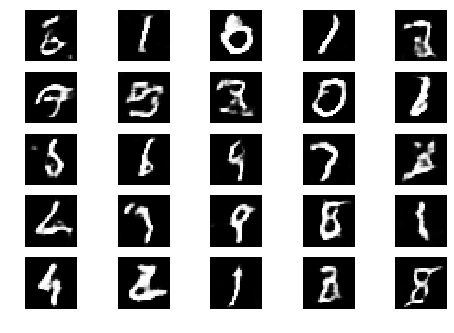

Epoch 2 Batch 151/1875 [D loss: 0.622861, acc.: 59.38%] [G loss: 1.031230]
Epoch 2 Batch 152/1875 [D loss: 0.819682, acc.: 37.50%] [G loss: 0.847994]
Epoch 2 Batch 153/1875 [D loss: 0.499818, acc.: 75.00%] [G loss: 1.094344]
Epoch 2 Batch 154/1875 [D loss: 0.709019, acc.: 62.50%] [G loss: 0.893817]
Epoch 2 Batch 155/1875 [D loss: 0.639764, acc.: 62.50%] [G loss: 0.960462]
Epoch 2 Batch 156/1875 [D loss: 0.603846, acc.: 71.88%] [G loss: 1.177438]
Epoch 2 Batch 157/1875 [D loss: 0.702806, acc.: 50.00%] [G loss: 1.095489]
Epoch 2 Batch 158/1875 [D loss: 0.545518, acc.: 75.00%] [G loss: 0.975674]
Epoch 2 Batch 159/1875 [D loss: 0.771370, acc.: 40.62%] [G loss: 1.010091]
Epoch 2 Batch 160/1875 [D loss: 0.704907, acc.: 62.50%] [G loss: 1.003861]
Epoch 2 Batch 161/1875 [D loss: 0.575714, acc.: 78.12%] [G loss: 1.112667]
Epoch 2 Batch 162/1875 [D loss: 0.708082, acc.: 62.50%] [G loss: 1.171537]
Epoch 2 Batch 163/1875 [D loss: 0.621156, acc.: 75.00%] [G loss: 1.116618]
Epoch 2 Batch 164/1875 [D

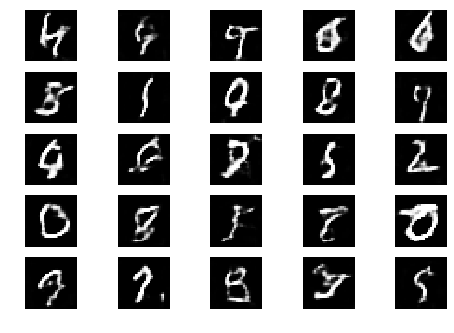

Epoch 2 Batch 201/1875 [D loss: 0.673033, acc.: 53.12%] [G loss: 1.009091]
Epoch 2 Batch 202/1875 [D loss: 0.569247, acc.: 65.62%] [G loss: 1.003464]
Epoch 2 Batch 203/1875 [D loss: 0.707771, acc.: 56.25%] [G loss: 0.918242]
Epoch 2 Batch 204/1875 [D loss: 0.761786, acc.: 46.88%] [G loss: 1.204730]
Epoch 2 Batch 205/1875 [D loss: 0.712164, acc.: 53.12%] [G loss: 1.010702]
Epoch 2 Batch 206/1875 [D loss: 0.623009, acc.: 71.88%] [G loss: 0.952785]
Epoch 2 Batch 207/1875 [D loss: 0.607035, acc.: 59.38%] [G loss: 1.001802]
Epoch 2 Batch 208/1875 [D loss: 0.504175, acc.: 81.25%] [G loss: 0.904137]
Epoch 2 Batch 209/1875 [D loss: 0.734183, acc.: 46.88%] [G loss: 0.963225]
Epoch 2 Batch 210/1875 [D loss: 0.650337, acc.: 65.62%] [G loss: 0.839208]
Epoch 2 Batch 211/1875 [D loss: 0.874126, acc.: 28.12%] [G loss: 0.802893]
Epoch 2 Batch 212/1875 [D loss: 0.871341, acc.: 46.88%] [G loss: 0.805759]
Epoch 2 Batch 213/1875 [D loss: 0.692461, acc.: 46.88%] [G loss: 1.020041]
Epoch 2 Batch 214/1875 [D

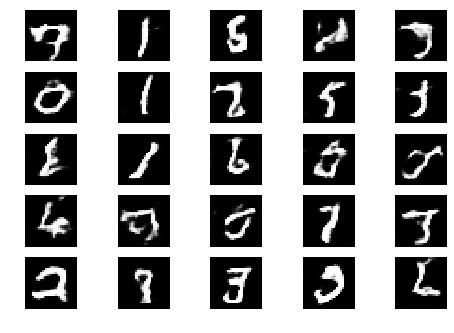

Epoch 2 Batch 251/1875 [D loss: 0.618804, acc.: 62.50%] [G loss: 0.977909]
Epoch 2 Batch 252/1875 [D loss: 0.806044, acc.: 53.12%] [G loss: 1.011856]
Epoch 2 Batch 253/1875 [D loss: 0.711163, acc.: 56.25%] [G loss: 1.040296]
Epoch 2 Batch 254/1875 [D loss: 0.649695, acc.: 65.62%] [G loss: 1.153885]
Epoch 2 Batch 255/1875 [D loss: 0.705565, acc.: 53.12%] [G loss: 0.930040]
Epoch 2 Batch 256/1875 [D loss: 0.633849, acc.: 65.62%] [G loss: 0.788383]
Epoch 2 Batch 257/1875 [D loss: 0.831727, acc.: 50.00%] [G loss: 1.087940]
Epoch 2 Batch 258/1875 [D loss: 0.579119, acc.: 65.62%] [G loss: 0.936021]
Epoch 2 Batch 259/1875 [D loss: 0.613463, acc.: 68.75%] [G loss: 1.002069]
Epoch 2 Batch 260/1875 [D loss: 0.641736, acc.: 65.62%] [G loss: 1.052208]
Epoch 2 Batch 261/1875 [D loss: 0.650663, acc.: 59.38%] [G loss: 0.922829]
Epoch 2 Batch 262/1875 [D loss: 0.624936, acc.: 65.62%] [G loss: 0.842907]
Epoch 2 Batch 263/1875 [D loss: 0.648877, acc.: 53.12%] [G loss: 0.878841]
Epoch 2 Batch 264/1875 [D

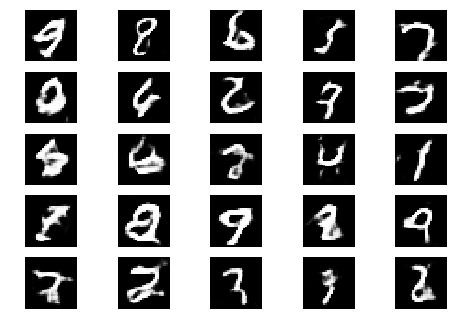

Epoch 2 Batch 301/1875 [D loss: 0.649679, acc.: 59.38%] [G loss: 0.713591]
Epoch 2 Batch 302/1875 [D loss: 0.652927, acc.: 62.50%] [G loss: 0.856515]
Epoch 2 Batch 303/1875 [D loss: 0.627488, acc.: 56.25%] [G loss: 0.952552]
Epoch 2 Batch 304/1875 [D loss: 0.733683, acc.: 50.00%] [G loss: 0.981572]
Epoch 2 Batch 305/1875 [D loss: 0.591418, acc.: 59.38%] [G loss: 0.882285]
Epoch 2 Batch 306/1875 [D loss: 0.631732, acc.: 59.38%] [G loss: 0.954499]
Epoch 2 Batch 307/1875 [D loss: 0.617602, acc.: 62.50%] [G loss: 0.948091]
Epoch 2 Batch 308/1875 [D loss: 0.732129, acc.: 53.12%] [G loss: 1.239880]
Epoch 2 Batch 309/1875 [D loss: 0.598976, acc.: 68.75%] [G loss: 1.133632]
Epoch 2 Batch 310/1875 [D loss: 0.640836, acc.: 59.38%] [G loss: 1.199303]
Epoch 2 Batch 311/1875 [D loss: 0.802749, acc.: 46.88%] [G loss: 0.851814]
Epoch 2 Batch 312/1875 [D loss: 0.700759, acc.: 53.12%] [G loss: 0.920505]
Epoch 2 Batch 313/1875 [D loss: 0.729831, acc.: 50.00%] [G loss: 1.192242]
Epoch 2 Batch 314/1875 [D

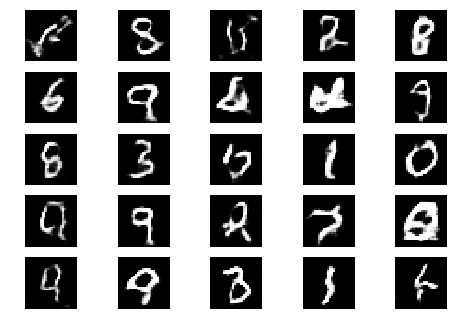

Epoch 2 Batch 351/1875 [D loss: 0.672570, acc.: 56.25%] [G loss: 1.044541]
Epoch 2 Batch 352/1875 [D loss: 0.617307, acc.: 62.50%] [G loss: 0.812787]
Epoch 2 Batch 353/1875 [D loss: 0.736363, acc.: 59.38%] [G loss: 0.975297]
Epoch 2 Batch 354/1875 [D loss: 0.599134, acc.: 62.50%] [G loss: 0.875717]
Epoch 2 Batch 355/1875 [D loss: 0.774053, acc.: 59.38%] [G loss: 0.992570]
Epoch 2 Batch 356/1875 [D loss: 0.643135, acc.: 65.62%] [G loss: 1.120735]
Epoch 2 Batch 357/1875 [D loss: 0.660248, acc.: 62.50%] [G loss: 0.927542]
Epoch 2 Batch 358/1875 [D loss: 0.630099, acc.: 68.75%] [G loss: 0.993455]
Epoch 2 Batch 359/1875 [D loss: 0.551329, acc.: 71.88%] [G loss: 0.987824]
Epoch 2 Batch 360/1875 [D loss: 0.733677, acc.: 43.75%] [G loss: 0.853532]
Epoch 2 Batch 361/1875 [D loss: 0.479997, acc.: 71.88%] [G loss: 1.237062]
Epoch 2 Batch 362/1875 [D loss: 0.712915, acc.: 53.12%] [G loss: 0.986996]
Epoch 2 Batch 363/1875 [D loss: 0.715413, acc.: 53.12%] [G loss: 1.102823]
Epoch 2 Batch 364/1875 [D

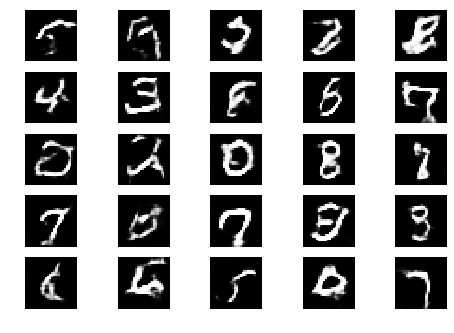

Epoch 2 Batch 401/1875 [D loss: 0.648902, acc.: 59.38%] [G loss: 0.900632]
Epoch 2 Batch 402/1875 [D loss: 0.650582, acc.: 65.62%] [G loss: 1.289213]
Epoch 2 Batch 403/1875 [D loss: 0.627735, acc.: 65.62%] [G loss: 1.020418]
Epoch 2 Batch 404/1875 [D loss: 0.651727, acc.: 65.62%] [G loss: 1.089472]
Epoch 2 Batch 405/1875 [D loss: 0.693792, acc.: 71.88%] [G loss: 0.907444]
Epoch 2 Batch 406/1875 [D loss: 0.650732, acc.: 68.75%] [G loss: 1.176124]
Epoch 2 Batch 407/1875 [D loss: 0.614602, acc.: 59.38%] [G loss: 1.217675]
Epoch 2 Batch 408/1875 [D loss: 0.651621, acc.: 59.38%] [G loss: 0.900046]
Epoch 2 Batch 409/1875 [D loss: 0.654522, acc.: 71.88%] [G loss: 1.066473]
Epoch 2 Batch 410/1875 [D loss: 0.539213, acc.: 68.75%] [G loss: 0.955725]
Epoch 2 Batch 411/1875 [D loss: 0.690536, acc.: 53.12%] [G loss: 1.013455]
Epoch 2 Batch 412/1875 [D loss: 0.590503, acc.: 75.00%] [G loss: 1.032640]
Epoch 2 Batch 413/1875 [D loss: 0.667087, acc.: 56.25%] [G loss: 1.099694]
Epoch 2 Batch 414/1875 [D

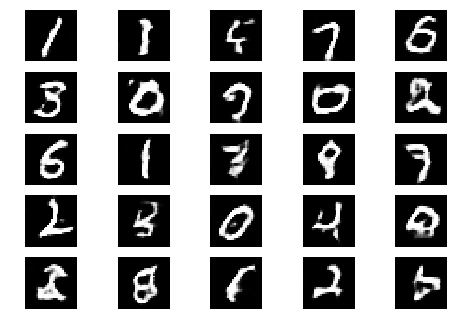

Epoch 2 Batch 451/1875 [D loss: 0.681188, acc.: 59.38%] [G loss: 0.963399]
Epoch 2 Batch 452/1875 [D loss: 0.502195, acc.: 62.50%] [G loss: 1.141596]
Epoch 2 Batch 453/1875 [D loss: 0.815099, acc.: 50.00%] [G loss: 0.828803]
Epoch 2 Batch 454/1875 [D loss: 0.761346, acc.: 50.00%] [G loss: 1.048827]
Epoch 2 Batch 455/1875 [D loss: 0.675829, acc.: 62.50%] [G loss: 1.402806]
Epoch 2 Batch 456/1875 [D loss: 0.724281, acc.: 59.38%] [G loss: 1.213268]
Epoch 2 Batch 457/1875 [D loss: 0.604453, acc.: 56.25%] [G loss: 0.884236]
Epoch 2 Batch 458/1875 [D loss: 0.665808, acc.: 53.12%] [G loss: 1.037761]
Epoch 2 Batch 459/1875 [D loss: 0.721713, acc.: 56.25%] [G loss: 0.922004]
Epoch 2 Batch 460/1875 [D loss: 0.585983, acc.: 56.25%] [G loss: 1.102945]
Epoch 2 Batch 461/1875 [D loss: 0.630529, acc.: 59.38%] [G loss: 0.859323]
Epoch 2 Batch 462/1875 [D loss: 0.630350, acc.: 53.12%] [G loss: 0.944026]
Epoch 2 Batch 463/1875 [D loss: 0.758261, acc.: 46.88%] [G loss: 0.973612]
Epoch 2 Batch 464/1875 [D

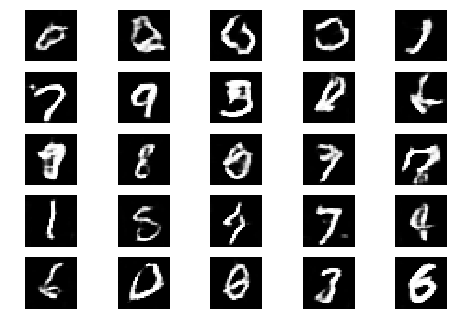

Epoch 2 Batch 501/1875 [D loss: 0.758434, acc.: 53.12%] [G loss: 1.177625]
Epoch 2 Batch 502/1875 [D loss: 0.826448, acc.: 50.00%] [G loss: 0.993625]
Epoch 2 Batch 503/1875 [D loss: 0.666492, acc.: 59.38%] [G loss: 0.950717]
Epoch 2 Batch 504/1875 [D loss: 0.679441, acc.: 59.38%] [G loss: 0.894082]
Epoch 2 Batch 505/1875 [D loss: 0.824274, acc.: 46.88%] [G loss: 1.099017]
Epoch 2 Batch 506/1875 [D loss: 0.692626, acc.: 56.25%] [G loss: 0.924924]
Epoch 2 Batch 507/1875 [D loss: 0.810160, acc.: 50.00%] [G loss: 0.985145]
Epoch 2 Batch 508/1875 [D loss: 0.642747, acc.: 59.38%] [G loss: 1.163621]
Epoch 2 Batch 509/1875 [D loss: 0.630778, acc.: 68.75%] [G loss: 0.864869]
Epoch 2 Batch 510/1875 [D loss: 0.616744, acc.: 62.50%] [G loss: 0.918051]
Epoch 2 Batch 511/1875 [D loss: 0.676654, acc.: 62.50%] [G loss: 0.930195]
Epoch 2 Batch 512/1875 [D loss: 0.608466, acc.: 59.38%] [G loss: 0.852467]
Epoch 2 Batch 513/1875 [D loss: 0.522218, acc.: 68.75%] [G loss: 1.200497]
Epoch 2 Batch 514/1875 [D

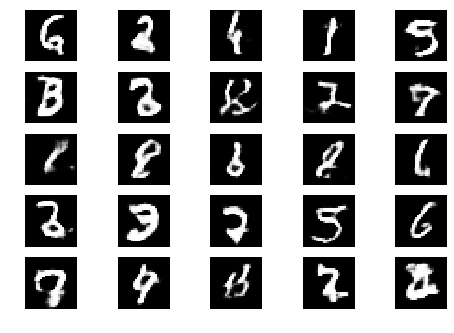

Epoch 2 Batch 551/1875 [D loss: 0.645274, acc.: 59.38%] [G loss: 0.940165]
Epoch 2 Batch 552/1875 [D loss: 0.669276, acc.: 65.62%] [G loss: 0.985015]
Epoch 2 Batch 553/1875 [D loss: 0.621638, acc.: 68.75%] [G loss: 0.854621]
Epoch 2 Batch 554/1875 [D loss: 0.452386, acc.: 81.25%] [G loss: 1.015161]
Epoch 2 Batch 555/1875 [D loss: 0.613643, acc.: 65.62%] [G loss: 0.903151]
Epoch 2 Batch 556/1875 [D loss: 0.532600, acc.: 71.88%] [G loss: 0.915997]
Epoch 2 Batch 557/1875 [D loss: 0.676706, acc.: 65.62%] [G loss: 1.052256]
Epoch 2 Batch 558/1875 [D loss: 0.567455, acc.: 68.75%] [G loss: 0.855821]
Epoch 2 Batch 559/1875 [D loss: 0.713243, acc.: 56.25%] [G loss: 1.030868]
Epoch 2 Batch 560/1875 [D loss: 0.535738, acc.: 71.88%] [G loss: 1.071615]
Epoch 2 Batch 561/1875 [D loss: 0.655425, acc.: 65.62%] [G loss: 1.002543]
Epoch 2 Batch 562/1875 [D loss: 0.720314, acc.: 56.25%] [G loss: 0.907349]
Epoch 2 Batch 563/1875 [D loss: 0.649264, acc.: 65.62%] [G loss: 0.929437]
Epoch 2 Batch 564/1875 [D

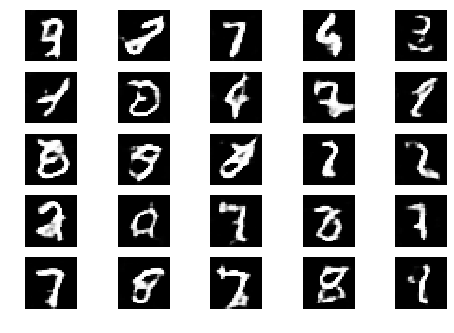

Epoch 2 Batch 601/1875 [D loss: 0.661709, acc.: 59.38%] [G loss: 1.045060]
Epoch 2 Batch 602/1875 [D loss: 0.688062, acc.: 56.25%] [G loss: 1.016646]
Epoch 2 Batch 603/1875 [D loss: 0.702080, acc.: 59.38%] [G loss: 1.063114]
Epoch 2 Batch 604/1875 [D loss: 0.729582, acc.: 56.25%] [G loss: 1.012140]
Epoch 2 Batch 605/1875 [D loss: 0.674578, acc.: 62.50%] [G loss: 0.907827]
Epoch 2 Batch 606/1875 [D loss: 0.588280, acc.: 75.00%] [G loss: 1.015560]
Epoch 2 Batch 607/1875 [D loss: 0.601111, acc.: 68.75%] [G loss: 1.175280]
Epoch 2 Batch 608/1875 [D loss: 0.600166, acc.: 75.00%] [G loss: 0.896105]
Epoch 2 Batch 609/1875 [D loss: 0.597523, acc.: 71.88%] [G loss: 0.878357]
Epoch 2 Batch 610/1875 [D loss: 0.571484, acc.: 71.88%] [G loss: 0.830348]
Epoch 2 Batch 611/1875 [D loss: 0.796678, acc.: 46.88%] [G loss: 1.062566]
Epoch 2 Batch 612/1875 [D loss: 0.539921, acc.: 75.00%] [G loss: 0.850574]
Epoch 2 Batch 613/1875 [D loss: 0.736272, acc.: 56.25%] [G loss: 1.030277]
Epoch 2 Batch 614/1875 [D

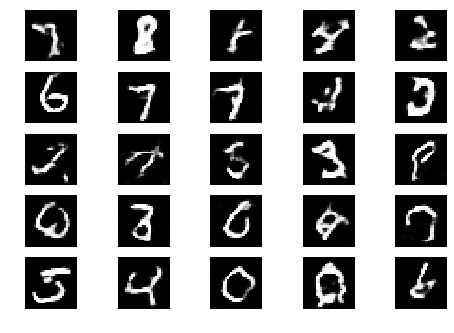

Epoch 2 Batch 651/1875 [D loss: 0.835327, acc.: 43.75%] [G loss: 0.903797]
Epoch 2 Batch 652/1875 [D loss: 0.687758, acc.: 62.50%] [G loss: 0.963479]
Epoch 2 Batch 653/1875 [D loss: 0.758535, acc.: 50.00%] [G loss: 1.154733]
Epoch 2 Batch 654/1875 [D loss: 0.920583, acc.: 31.25%] [G loss: 1.110370]
Epoch 2 Batch 655/1875 [D loss: 0.659048, acc.: 62.50%] [G loss: 1.309163]
Epoch 2 Batch 656/1875 [D loss: 0.742647, acc.: 53.12%] [G loss: 1.192300]
Epoch 2 Batch 657/1875 [D loss: 0.579105, acc.: 62.50%] [G loss: 1.178265]
Epoch 2 Batch 658/1875 [D loss: 0.764286, acc.: 50.00%] [G loss: 1.127151]
Epoch 2 Batch 659/1875 [D loss: 0.593965, acc.: 78.12%] [G loss: 1.203326]
Epoch 2 Batch 660/1875 [D loss: 0.653535, acc.: 59.38%] [G loss: 0.972547]
Epoch 2 Batch 661/1875 [D loss: 0.630700, acc.: 65.62%] [G loss: 1.036493]
Epoch 2 Batch 662/1875 [D loss: 0.648042, acc.: 53.12%] [G loss: 0.897738]
Epoch 2 Batch 663/1875 [D loss: 0.599899, acc.: 75.00%] [G loss: 1.066967]
Epoch 2 Batch 664/1875 [D

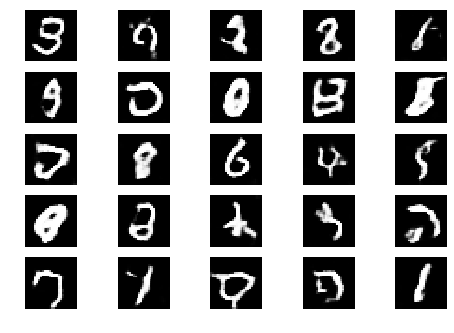

Epoch 2 Batch 701/1875 [D loss: 0.520815, acc.: 81.25%] [G loss: 1.093494]
Epoch 2 Batch 702/1875 [D loss: 0.682691, acc.: 50.00%] [G loss: 1.135764]
Epoch 2 Batch 703/1875 [D loss: 0.571703, acc.: 71.88%] [G loss: 0.947816]
Epoch 2 Batch 704/1875 [D loss: 0.697930, acc.: 53.12%] [G loss: 0.833947]
Epoch 2 Batch 705/1875 [D loss: 0.695427, acc.: 40.62%] [G loss: 0.754867]
Epoch 2 Batch 706/1875 [D loss: 0.577050, acc.: 68.75%] [G loss: 0.944637]
Epoch 2 Batch 707/1875 [D loss: 0.539024, acc.: 78.12%] [G loss: 0.844263]
Epoch 2 Batch 708/1875 [D loss: 0.628220, acc.: 59.38%] [G loss: 1.031990]
Epoch 2 Batch 709/1875 [D loss: 0.615712, acc.: 59.38%] [G loss: 0.992639]
Epoch 2 Batch 710/1875 [D loss: 0.554757, acc.: 71.88%] [G loss: 1.130565]
Epoch 2 Batch 711/1875 [D loss: 0.637094, acc.: 68.75%] [G loss: 1.170948]
Epoch 2 Batch 712/1875 [D loss: 0.561019, acc.: 78.12%] [G loss: 1.130248]
Epoch 2 Batch 713/1875 [D loss: 0.663895, acc.: 59.38%] [G loss: 1.009301]
Epoch 2 Batch 714/1875 [D

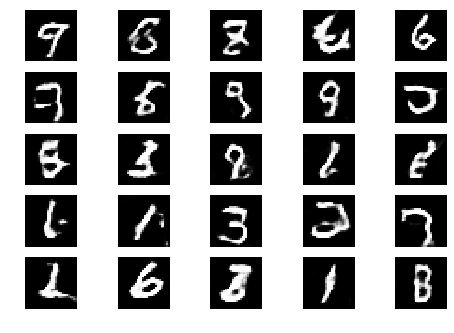

Epoch 2 Batch 751/1875 [D loss: 0.647907, acc.: 68.75%] [G loss: 1.063104]
Epoch 2 Batch 752/1875 [D loss: 0.675662, acc.: 62.50%] [G loss: 0.985610]
Epoch 2 Batch 753/1875 [D loss: 0.548131, acc.: 71.88%] [G loss: 1.013868]
Epoch 2 Batch 754/1875 [D loss: 0.657876, acc.: 59.38%] [G loss: 1.003989]
Epoch 2 Batch 755/1875 [D loss: 0.705841, acc.: 56.25%] [G loss: 1.104540]
Epoch 2 Batch 756/1875 [D loss: 0.731516, acc.: 53.12%] [G loss: 0.814182]
Epoch 2 Batch 757/1875 [D loss: 0.824988, acc.: 37.50%] [G loss: 0.994024]
Epoch 2 Batch 758/1875 [D loss: 0.586875, acc.: 68.75%] [G loss: 1.227503]
Epoch 2 Batch 759/1875 [D loss: 0.808410, acc.: 50.00%] [G loss: 0.915712]
Epoch 2 Batch 760/1875 [D loss: 0.727400, acc.: 46.88%] [G loss: 1.145111]
Epoch 2 Batch 761/1875 [D loss: 0.617409, acc.: 68.75%] [G loss: 0.984993]
Epoch 2 Batch 762/1875 [D loss: 0.597743, acc.: 75.00%] [G loss: 1.231844]
Epoch 2 Batch 763/1875 [D loss: 0.696045, acc.: 53.12%] [G loss: 0.987229]
Epoch 2 Batch 764/1875 [D

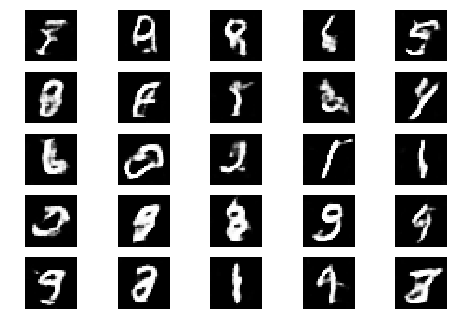

Epoch 2 Batch 801/1875 [D loss: 0.528284, acc.: 62.50%] [G loss: 0.921814]
Epoch 2 Batch 802/1875 [D loss: 0.641877, acc.: 65.62%] [G loss: 1.073657]
Epoch 2 Batch 803/1875 [D loss: 0.621893, acc.: 75.00%] [G loss: 0.896086]
Epoch 2 Batch 804/1875 [D loss: 0.720255, acc.: 43.75%] [G loss: 1.122463]
Epoch 2 Batch 805/1875 [D loss: 0.630073, acc.: 65.62%] [G loss: 1.214492]
Epoch 2 Batch 806/1875 [D loss: 0.698815, acc.: 53.12%] [G loss: 1.076409]
Epoch 2 Batch 807/1875 [D loss: 0.577554, acc.: 75.00%] [G loss: 1.101787]
Epoch 2 Batch 808/1875 [D loss: 0.616057, acc.: 65.62%] [G loss: 1.003041]
Epoch 2 Batch 809/1875 [D loss: 0.545198, acc.: 78.12%] [G loss: 1.172728]
Epoch 2 Batch 810/1875 [D loss: 0.520875, acc.: 78.12%] [G loss: 1.124719]
Epoch 2 Batch 811/1875 [D loss: 0.638873, acc.: 71.88%] [G loss: 0.870767]
Epoch 2 Batch 812/1875 [D loss: 0.765918, acc.: 43.75%] [G loss: 1.011150]
Epoch 2 Batch 813/1875 [D loss: 0.762917, acc.: 50.00%] [G loss: 0.830145]
Epoch 2 Batch 814/1875 [D

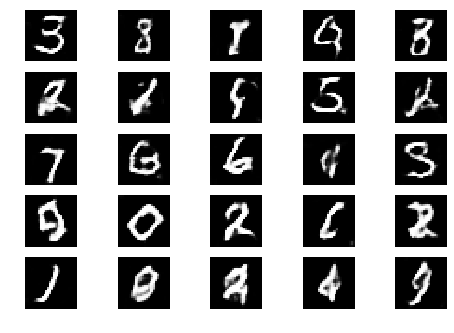

Epoch 2 Batch 851/1875 [D loss: 0.694739, acc.: 56.25%] [G loss: 1.033683]
Epoch 2 Batch 852/1875 [D loss: 0.722307, acc.: 65.62%] [G loss: 1.266093]
Epoch 2 Batch 853/1875 [D loss: 0.606654, acc.: 59.38%] [G loss: 1.032848]
Epoch 2 Batch 854/1875 [D loss: 0.674867, acc.: 71.88%] [G loss: 0.978923]
Epoch 2 Batch 855/1875 [D loss: 0.711232, acc.: 53.12%] [G loss: 0.980226]
Epoch 2 Batch 856/1875 [D loss: 0.780987, acc.: 43.75%] [G loss: 1.116171]
Epoch 2 Batch 857/1875 [D loss: 0.628076, acc.: 65.62%] [G loss: 1.234336]
Epoch 2 Batch 858/1875 [D loss: 0.582008, acc.: 65.62%] [G loss: 1.180840]
Epoch 2 Batch 859/1875 [D loss: 0.633626, acc.: 62.50%] [G loss: 1.168633]
Epoch 2 Batch 860/1875 [D loss: 0.716444, acc.: 50.00%] [G loss: 0.939417]
Epoch 2 Batch 861/1875 [D loss: 0.713420, acc.: 46.88%] [G loss: 0.877110]
Epoch 2 Batch 862/1875 [D loss: 0.751184, acc.: 59.38%] [G loss: 1.079408]
Epoch 2 Batch 863/1875 [D loss: 0.568084, acc.: 71.88%] [G loss: 1.057920]
Epoch 2 Batch 864/1875 [D

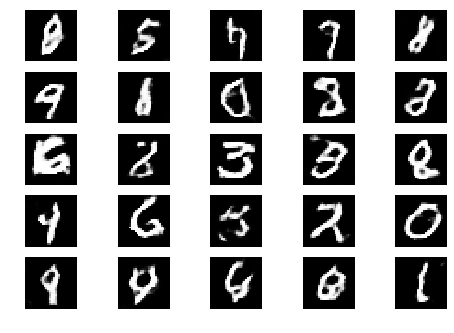

Epoch 2 Batch 901/1875 [D loss: 0.644548, acc.: 56.25%] [G loss: 1.006528]
Epoch 2 Batch 902/1875 [D loss: 0.455881, acc.: 81.25%] [G loss: 0.994026]
Epoch 2 Batch 903/1875 [D loss: 0.621969, acc.: 53.12%] [G loss: 0.827563]
Epoch 2 Batch 904/1875 [D loss: 0.619009, acc.: 59.38%] [G loss: 0.988549]
Epoch 2 Batch 905/1875 [D loss: 0.799258, acc.: 50.00%] [G loss: 0.895091]
Epoch 2 Batch 906/1875 [D loss: 0.650917, acc.: 65.62%] [G loss: 0.922551]
Epoch 2 Batch 907/1875 [D loss: 0.747616, acc.: 46.88%] [G loss: 1.093364]
Epoch 2 Batch 908/1875 [D loss: 0.541380, acc.: 78.12%] [G loss: 1.047771]
Epoch 2 Batch 909/1875 [D loss: 0.687590, acc.: 59.38%] [G loss: 1.055347]
Epoch 2 Batch 910/1875 [D loss: 0.514994, acc.: 81.25%] [G loss: 1.101594]
Epoch 2 Batch 911/1875 [D loss: 0.610125, acc.: 68.75%] [G loss: 0.886229]
Epoch 2 Batch 912/1875 [D loss: 0.717348, acc.: 59.38%] [G loss: 0.909606]
Epoch 2 Batch 913/1875 [D loss: 0.649312, acc.: 62.50%] [G loss: 1.143105]
Epoch 2 Batch 914/1875 [D

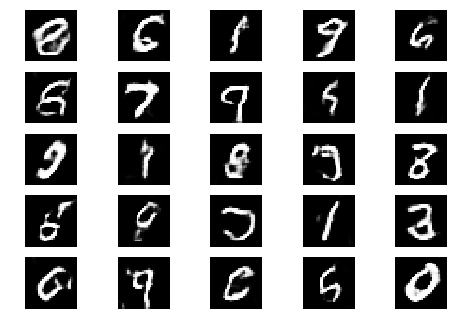

Epoch 2 Batch 951/1875 [D loss: 0.560188, acc.: 78.12%] [G loss: 1.194857]
Epoch 2 Batch 952/1875 [D loss: 0.746848, acc.: 53.12%] [G loss: 0.947442]
Epoch 2 Batch 953/1875 [D loss: 0.646299, acc.: 53.12%] [G loss: 1.046576]
Epoch 2 Batch 954/1875 [D loss: 0.543032, acc.: 84.38%] [G loss: 1.051423]
Epoch 2 Batch 955/1875 [D loss: 0.668445, acc.: 65.62%] [G loss: 1.065447]
Epoch 2 Batch 956/1875 [D loss: 0.750277, acc.: 71.88%] [G loss: 1.136853]
Epoch 2 Batch 957/1875 [D loss: 0.672350, acc.: 53.12%] [G loss: 1.120077]
Epoch 2 Batch 958/1875 [D loss: 0.623965, acc.: 62.50%] [G loss: 0.892884]
Epoch 2 Batch 959/1875 [D loss: 0.681383, acc.: 65.62%] [G loss: 1.044378]
Epoch 2 Batch 960/1875 [D loss: 0.578708, acc.: 75.00%] [G loss: 1.079961]
Epoch 2 Batch 961/1875 [D loss: 0.470277, acc.: 78.12%] [G loss: 1.301942]
Epoch 2 Batch 962/1875 [D loss: 0.614960, acc.: 65.62%] [G loss: 1.017994]
Epoch 2 Batch 963/1875 [D loss: 0.731122, acc.: 43.75%] [G loss: 0.980361]
Epoch 2 Batch 964/1875 [D

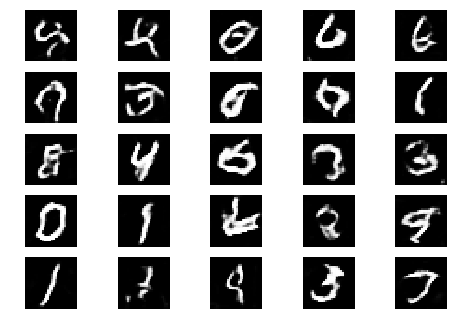

Epoch 2 Batch 1001/1875 [D loss: 0.737752, acc.: 59.38%] [G loss: 0.983271]
Epoch 2 Batch 1002/1875 [D loss: 0.655927, acc.: 62.50%] [G loss: 0.990366]
Epoch 2 Batch 1003/1875 [D loss: 0.438935, acc.: 84.38%] [G loss: 1.036164]
Epoch 2 Batch 1004/1875 [D loss: 0.618957, acc.: 68.75%] [G loss: 0.948066]
Epoch 2 Batch 1005/1875 [D loss: 0.594872, acc.: 71.88%] [G loss: 1.166280]
Epoch 2 Batch 1006/1875 [D loss: 0.761585, acc.: 53.12%] [G loss: 1.010998]
Epoch 2 Batch 1007/1875 [D loss: 0.647384, acc.: 56.25%] [G loss: 0.888141]
Epoch 2 Batch 1008/1875 [D loss: 0.633540, acc.: 56.25%] [G loss: 1.078709]
Epoch 2 Batch 1009/1875 [D loss: 0.599463, acc.: 62.50%] [G loss: 0.998573]
Epoch 2 Batch 1010/1875 [D loss: 0.630975, acc.: 59.38%] [G loss: 1.103446]
Epoch 2 Batch 1011/1875 [D loss: 0.717180, acc.: 62.50%] [G loss: 0.969061]
Epoch 2 Batch 1012/1875 [D loss: 0.770104, acc.: 56.25%] [G loss: 1.084087]
Epoch 2 Batch 1013/1875 [D loss: 0.498015, acc.: 81.25%] [G loss: 0.971396]
Epoch 2 Batc

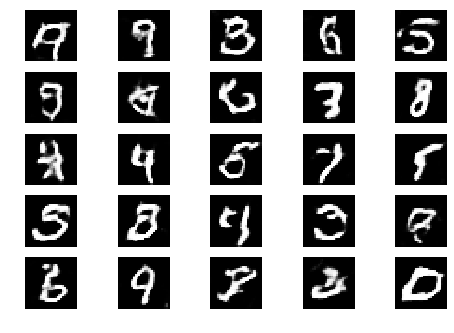

Epoch 2 Batch 1051/1875 [D loss: 0.650510, acc.: 68.75%] [G loss: 0.861751]
Epoch 2 Batch 1052/1875 [D loss: 0.776365, acc.: 56.25%] [G loss: 1.136802]
Epoch 2 Batch 1053/1875 [D loss: 0.560130, acc.: 75.00%] [G loss: 1.138079]
Epoch 2 Batch 1054/1875 [D loss: 0.868211, acc.: 53.12%] [G loss: 0.876355]
Epoch 2 Batch 1055/1875 [D loss: 0.412494, acc.: 84.38%] [G loss: 1.141647]
Epoch 2 Batch 1056/1875 [D loss: 0.553752, acc.: 75.00%] [G loss: 1.230877]
Epoch 2 Batch 1057/1875 [D loss: 0.748984, acc.: 53.12%] [G loss: 0.903933]
Epoch 2 Batch 1058/1875 [D loss: 0.654688, acc.: 56.25%] [G loss: 0.991809]
Epoch 2 Batch 1059/1875 [D loss: 0.673965, acc.: 50.00%] [G loss: 0.948526]
Epoch 2 Batch 1060/1875 [D loss: 0.738251, acc.: 43.75%] [G loss: 1.232797]
Epoch 2 Batch 1061/1875 [D loss: 0.613858, acc.: 68.75%] [G loss: 0.966431]
Epoch 2 Batch 1062/1875 [D loss: 0.725092, acc.: 50.00%] [G loss: 0.952590]
Epoch 2 Batch 1063/1875 [D loss: 0.693870, acc.: 62.50%] [G loss: 0.911211]
Epoch 2 Batc

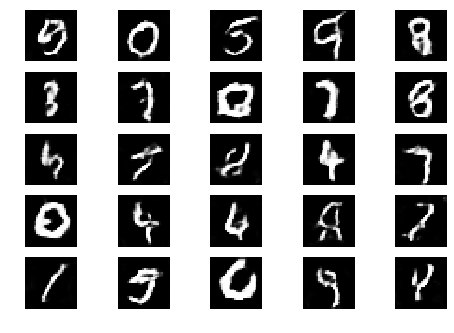

Epoch 2 Batch 1101/1875 [D loss: 0.634102, acc.: 59.38%] [G loss: 1.275661]
Epoch 2 Batch 1102/1875 [D loss: 0.549859, acc.: 62.50%] [G loss: 0.896879]
Epoch 2 Batch 1103/1875 [D loss: 0.718760, acc.: 53.12%] [G loss: 1.160648]
Epoch 2 Batch 1104/1875 [D loss: 0.594785, acc.: 68.75%] [G loss: 1.004669]
Epoch 2 Batch 1105/1875 [D loss: 0.820399, acc.: 43.75%] [G loss: 1.060076]
Epoch 2 Batch 1106/1875 [D loss: 0.557595, acc.: 71.88%] [G loss: 1.285774]
Epoch 2 Batch 1107/1875 [D loss: 0.649699, acc.: 68.75%] [G loss: 1.098522]
Epoch 2 Batch 1108/1875 [D loss: 0.598955, acc.: 68.75%] [G loss: 1.000890]
Epoch 2 Batch 1109/1875 [D loss: 0.607723, acc.: 62.50%] [G loss: 1.106496]
Epoch 2 Batch 1110/1875 [D loss: 0.665256, acc.: 65.62%] [G loss: 1.181343]
Epoch 2 Batch 1111/1875 [D loss: 0.645569, acc.: 65.62%] [G loss: 1.211553]
Epoch 2 Batch 1112/1875 [D loss: 0.617608, acc.: 71.88%] [G loss: 0.996985]
Epoch 2 Batch 1113/1875 [D loss: 0.573225, acc.: 81.25%] [G loss: 1.005675]
Epoch 2 Batc

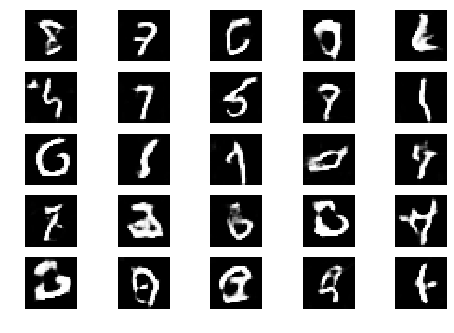

Epoch 2 Batch 1151/1875 [D loss: 0.645718, acc.: 65.62%] [G loss: 0.923318]
Epoch 2 Batch 1152/1875 [D loss: 0.748953, acc.: 50.00%] [G loss: 1.000915]
Epoch 2 Batch 1153/1875 [D loss: 0.654423, acc.: 65.62%] [G loss: 0.978454]
Epoch 2 Batch 1154/1875 [D loss: 0.620096, acc.: 59.38%] [G loss: 1.090101]
Epoch 2 Batch 1155/1875 [D loss: 0.746003, acc.: 46.88%] [G loss: 0.938151]
Epoch 2 Batch 1156/1875 [D loss: 0.572437, acc.: 75.00%] [G loss: 1.023413]
Epoch 2 Batch 1157/1875 [D loss: 0.646958, acc.: 62.50%] [G loss: 1.129493]
Epoch 2 Batch 1158/1875 [D loss: 0.829653, acc.: 43.75%] [G loss: 1.013166]
Epoch 2 Batch 1159/1875 [D loss: 0.794495, acc.: 40.62%] [G loss: 1.003560]
Epoch 2 Batch 1160/1875 [D loss: 0.768356, acc.: 56.25%] [G loss: 0.901176]
Epoch 2 Batch 1161/1875 [D loss: 0.701754, acc.: 46.88%] [G loss: 0.765483]
Epoch 2 Batch 1162/1875 [D loss: 0.606561, acc.: 65.62%] [G loss: 0.906745]
Epoch 2 Batch 1163/1875 [D loss: 0.513213, acc.: 81.25%] [G loss: 0.958456]
Epoch 2 Batc

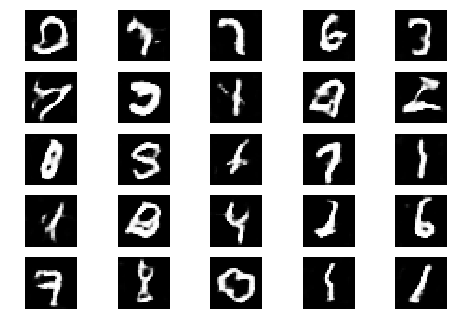

Epoch 2 Batch 1201/1875 [D loss: 0.691739, acc.: 56.25%] [G loss: 1.056230]
Epoch 2 Batch 1202/1875 [D loss: 0.689767, acc.: 56.25%] [G loss: 0.907890]
Epoch 2 Batch 1203/1875 [D loss: 0.743265, acc.: 59.38%] [G loss: 0.992603]
Epoch 2 Batch 1204/1875 [D loss: 0.803071, acc.: 46.88%] [G loss: 1.032693]
Epoch 2 Batch 1205/1875 [D loss: 0.570958, acc.: 65.62%] [G loss: 0.942186]
Epoch 2 Batch 1206/1875 [D loss: 0.639652, acc.: 75.00%] [G loss: 0.843954]
Epoch 2 Batch 1207/1875 [D loss: 0.827486, acc.: 43.75%] [G loss: 0.811277]
Epoch 2 Batch 1208/1875 [D loss: 0.664974, acc.: 53.12%] [G loss: 0.859763]
Epoch 2 Batch 1209/1875 [D loss: 0.553323, acc.: 65.62%] [G loss: 0.984666]
Epoch 2 Batch 1210/1875 [D loss: 0.698973, acc.: 62.50%] [G loss: 0.792293]
Epoch 2 Batch 1211/1875 [D loss: 0.709940, acc.: 53.12%] [G loss: 0.880504]
Epoch 2 Batch 1212/1875 [D loss: 0.611434, acc.: 59.38%] [G loss: 1.000798]
Epoch 2 Batch 1213/1875 [D loss: 0.750742, acc.: 46.88%] [G loss: 0.936249]
Epoch 2 Batc

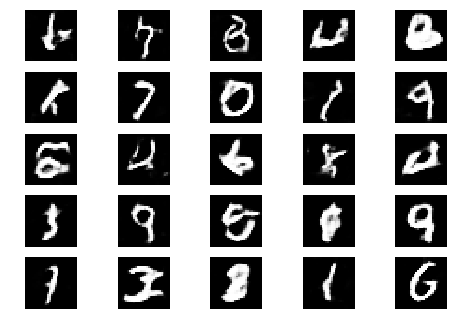

Epoch 2 Batch 1251/1875 [D loss: 0.520316, acc.: 78.12%] [G loss: 1.206216]
Epoch 2 Batch 1252/1875 [D loss: 0.618051, acc.: 56.25%] [G loss: 0.989721]
Epoch 2 Batch 1253/1875 [D loss: 0.756429, acc.: 43.75%] [G loss: 0.996928]
Epoch 2 Batch 1254/1875 [D loss: 0.499939, acc.: 78.12%] [G loss: 0.778037]
Epoch 2 Batch 1255/1875 [D loss: 0.740162, acc.: 59.38%] [G loss: 0.899592]
Epoch 2 Batch 1256/1875 [D loss: 0.669881, acc.: 56.25%] [G loss: 1.003894]
Epoch 2 Batch 1257/1875 [D loss: 0.677857, acc.: 53.12%] [G loss: 0.996027]
Epoch 2 Batch 1258/1875 [D loss: 0.691649, acc.: 62.50%] [G loss: 1.114816]
Epoch 2 Batch 1259/1875 [D loss: 0.735616, acc.: 65.62%] [G loss: 1.095858]
Epoch 2 Batch 1260/1875 [D loss: 0.600036, acc.: 65.62%] [G loss: 1.185242]
Epoch 2 Batch 1261/1875 [D loss: 0.609003, acc.: 65.62%] [G loss: 1.018702]
Epoch 2 Batch 1262/1875 [D loss: 0.531077, acc.: 71.88%] [G loss: 0.788792]
Epoch 2 Batch 1263/1875 [D loss: 0.670950, acc.: 53.12%] [G loss: 0.942677]
Epoch 2 Batc

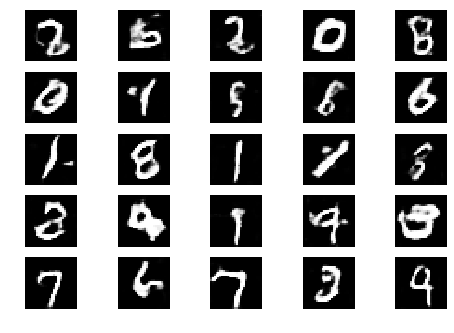

Epoch 2 Batch 1301/1875 [D loss: 0.560301, acc.: 62.50%] [G loss: 1.094934]
Epoch 2 Batch 1302/1875 [D loss: 0.810776, acc.: 40.62%] [G loss: 0.980868]
Epoch 2 Batch 1303/1875 [D loss: 0.625847, acc.: 65.62%] [G loss: 0.873094]
Epoch 2 Batch 1304/1875 [D loss: 0.633601, acc.: 68.75%] [G loss: 0.789952]
Epoch 2 Batch 1305/1875 [D loss: 0.664923, acc.: 62.50%] [G loss: 0.912877]
Epoch 2 Batch 1306/1875 [D loss: 0.643624, acc.: 56.25%] [G loss: 1.000511]
Epoch 2 Batch 1307/1875 [D loss: 0.639793, acc.: 59.38%] [G loss: 0.884398]
Epoch 2 Batch 1308/1875 [D loss: 0.523867, acc.: 78.12%] [G loss: 0.968875]
Epoch 2 Batch 1309/1875 [D loss: 0.537434, acc.: 71.88%] [G loss: 1.047818]
Epoch 2 Batch 1310/1875 [D loss: 0.745751, acc.: 62.50%] [G loss: 0.922481]
Epoch 2 Batch 1311/1875 [D loss: 0.643642, acc.: 56.25%] [G loss: 1.042485]
Epoch 2 Batch 1312/1875 [D loss: 0.726758, acc.: 59.38%] [G loss: 0.990574]
Epoch 2 Batch 1313/1875 [D loss: 0.687954, acc.: 59.38%] [G loss: 0.935791]
Epoch 2 Batc

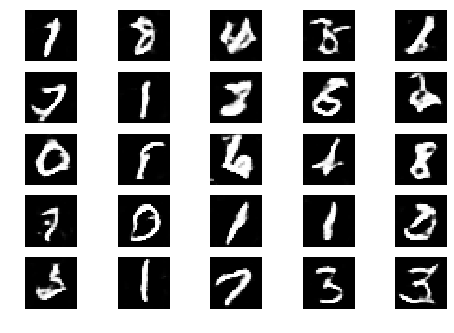

Epoch 2 Batch 1351/1875 [D loss: 0.743764, acc.: 53.12%] [G loss: 0.959100]
Epoch 2 Batch 1352/1875 [D loss: 0.665901, acc.: 59.38%] [G loss: 0.907768]
Epoch 2 Batch 1353/1875 [D loss: 0.484078, acc.: 93.75%] [G loss: 1.048707]
Epoch 2 Batch 1354/1875 [D loss: 0.546490, acc.: 75.00%] [G loss: 1.052767]
Epoch 2 Batch 1355/1875 [D loss: 0.672983, acc.: 50.00%] [G loss: 1.094430]
Epoch 2 Batch 1356/1875 [D loss: 0.818238, acc.: 53.12%] [G loss: 1.115079]
Epoch 2 Batch 1357/1875 [D loss: 0.604165, acc.: 62.50%] [G loss: 0.966091]
Epoch 2 Batch 1358/1875 [D loss: 0.591716, acc.: 65.62%] [G loss: 1.076128]
Epoch 2 Batch 1359/1875 [D loss: 0.730803, acc.: 50.00%] [G loss: 0.988636]
Epoch 2 Batch 1360/1875 [D loss: 0.648112, acc.: 53.12%] [G loss: 1.070979]
Epoch 2 Batch 1361/1875 [D loss: 0.580972, acc.: 68.75%] [G loss: 0.971830]
Epoch 2 Batch 1362/1875 [D loss: 0.575584, acc.: 68.75%] [G loss: 1.011718]
Epoch 2 Batch 1363/1875 [D loss: 0.587488, acc.: 71.88%] [G loss: 1.021413]
Epoch 2 Batc

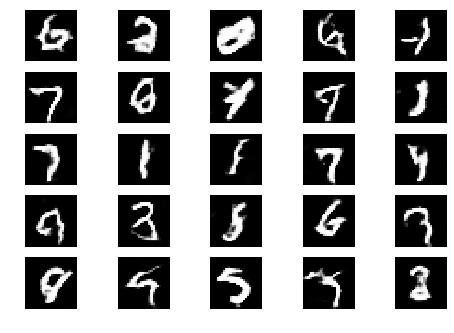

Epoch 2 Batch 1401/1875 [D loss: 0.628906, acc.: 59.38%] [G loss: 0.944957]
Epoch 2 Batch 1402/1875 [D loss: 0.626535, acc.: 65.62%] [G loss: 0.982490]
Epoch 2 Batch 1403/1875 [D loss: 0.515528, acc.: 78.12%] [G loss: 1.168754]
Epoch 2 Batch 1404/1875 [D loss: 0.538674, acc.: 75.00%] [G loss: 0.886340]
Epoch 2 Batch 1405/1875 [D loss: 0.731621, acc.: 50.00%] [G loss: 1.082938]
Epoch 2 Batch 1406/1875 [D loss: 0.702106, acc.: 59.38%] [G loss: 1.099525]
Epoch 2 Batch 1407/1875 [D loss: 0.739615, acc.: 53.12%] [G loss: 1.040203]
Epoch 2 Batch 1408/1875 [D loss: 0.609394, acc.: 62.50%] [G loss: 1.098423]
Epoch 2 Batch 1409/1875 [D loss: 0.624382, acc.: 68.75%] [G loss: 1.171849]
Epoch 2 Batch 1410/1875 [D loss: 0.609709, acc.: 59.38%] [G loss: 0.958013]
Epoch 2 Batch 1411/1875 [D loss: 0.694289, acc.: 62.50%] [G loss: 1.246417]
Epoch 2 Batch 1412/1875 [D loss: 0.528522, acc.: 71.88%] [G loss: 1.023556]
Epoch 2 Batch 1413/1875 [D loss: 0.786494, acc.: 46.88%] [G loss: 0.927138]
Epoch 2 Batc

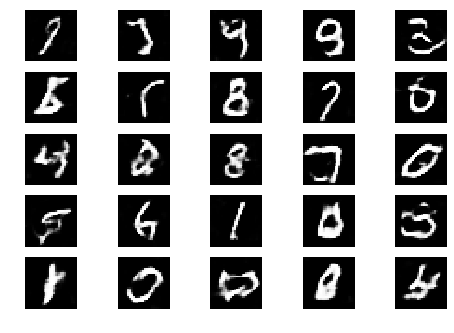

Epoch 2 Batch 1451/1875 [D loss: 0.676704, acc.: 68.75%] [G loss: 0.939252]
Epoch 2 Batch 1452/1875 [D loss: 0.671622, acc.: 59.38%] [G loss: 1.001647]
Epoch 2 Batch 1453/1875 [D loss: 0.482698, acc.: 84.38%] [G loss: 0.956061]
Epoch 2 Batch 1454/1875 [D loss: 0.748243, acc.: 56.25%] [G loss: 1.131155]
Epoch 2 Batch 1455/1875 [D loss: 0.647591, acc.: 65.62%] [G loss: 1.086380]
Epoch 2 Batch 1456/1875 [D loss: 0.583857, acc.: 75.00%] [G loss: 1.122680]
Epoch 2 Batch 1457/1875 [D loss: 0.672878, acc.: 62.50%] [G loss: 1.032136]
Epoch 2 Batch 1458/1875 [D loss: 0.590692, acc.: 78.12%] [G loss: 0.927355]
Epoch 2 Batch 1459/1875 [D loss: 0.554176, acc.: 81.25%] [G loss: 1.048657]
Epoch 2 Batch 1460/1875 [D loss: 0.587379, acc.: 68.75%] [G loss: 1.069096]
Epoch 2 Batch 1461/1875 [D loss: 0.545204, acc.: 71.88%] [G loss: 1.205070]
Epoch 2 Batch 1462/1875 [D loss: 0.753212, acc.: 50.00%] [G loss: 0.916753]
Epoch 2 Batch 1463/1875 [D loss: 0.661199, acc.: 62.50%] [G loss: 1.021417]
Epoch 2 Batc

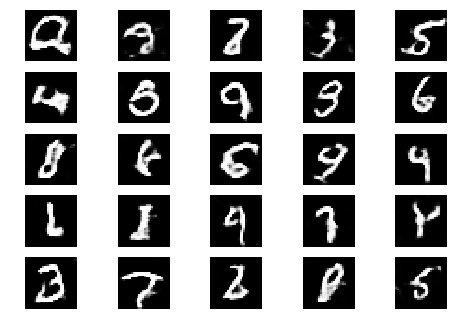

Epoch 2 Batch 1501/1875 [D loss: 0.812923, acc.: 34.38%] [G loss: 0.797006]
Epoch 2 Batch 1502/1875 [D loss: 0.546156, acc.: 78.12%] [G loss: 0.771368]
Epoch 2 Batch 1503/1875 [D loss: 0.568788, acc.: 62.50%] [G loss: 1.112106]
Epoch 2 Batch 1504/1875 [D loss: 0.684547, acc.: 65.62%] [G loss: 0.812922]
Epoch 2 Batch 1505/1875 [D loss: 0.731499, acc.: 56.25%] [G loss: 0.831002]
Epoch 2 Batch 1506/1875 [D loss: 0.907966, acc.: 37.50%] [G loss: 0.808869]
Epoch 2 Batch 1507/1875 [D loss: 0.782360, acc.: 46.88%] [G loss: 0.789525]
Epoch 2 Batch 1508/1875 [D loss: 0.689319, acc.: 46.88%] [G loss: 0.833138]
Epoch 2 Batch 1509/1875 [D loss: 0.668173, acc.: 56.25%] [G loss: 0.899535]
Epoch 2 Batch 1510/1875 [D loss: 0.559566, acc.: 71.88%] [G loss: 1.129766]
Epoch 2 Batch 1511/1875 [D loss: 0.567877, acc.: 68.75%] [G loss: 0.982652]
Epoch 2 Batch 1512/1875 [D loss: 0.757869, acc.: 50.00%] [G loss: 1.032767]
Epoch 2 Batch 1513/1875 [D loss: 0.558093, acc.: 78.12%] [G loss: 0.963925]
Epoch 2 Batc

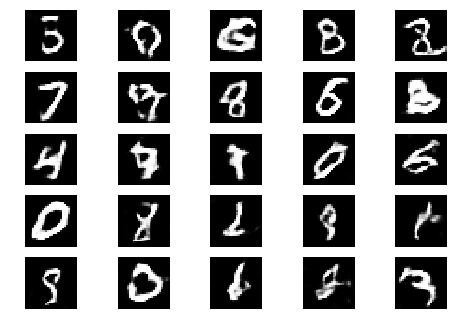

Epoch 2 Batch 1551/1875 [D loss: 0.706712, acc.: 59.38%] [G loss: 1.015800]
Epoch 2 Batch 1552/1875 [D loss: 0.675303, acc.: 56.25%] [G loss: 1.156848]
Epoch 2 Batch 1553/1875 [D loss: 0.781153, acc.: 53.12%] [G loss: 0.925388]
Epoch 2 Batch 1554/1875 [D loss: 0.658944, acc.: 68.75%] [G loss: 1.099014]
Epoch 2 Batch 1555/1875 [D loss: 0.624763, acc.: 56.25%] [G loss: 0.821205]
Epoch 2 Batch 1556/1875 [D loss: 0.511945, acc.: 71.88%] [G loss: 0.984604]
Epoch 2 Batch 1557/1875 [D loss: 0.662350, acc.: 68.75%] [G loss: 0.985264]
Epoch 2 Batch 1558/1875 [D loss: 0.752413, acc.: 46.88%] [G loss: 0.916823]
Epoch 2 Batch 1559/1875 [D loss: 0.539414, acc.: 75.00%] [G loss: 1.011972]
Epoch 2 Batch 1560/1875 [D loss: 0.672317, acc.: 59.38%] [G loss: 0.991538]
Epoch 2 Batch 1561/1875 [D loss: 0.649388, acc.: 59.38%] [G loss: 1.049878]
Epoch 2 Batch 1562/1875 [D loss: 0.682231, acc.: 65.62%] [G loss: 1.041164]
Epoch 2 Batch 1563/1875 [D loss: 0.710878, acc.: 59.38%] [G loss: 0.736188]
Epoch 2 Batc

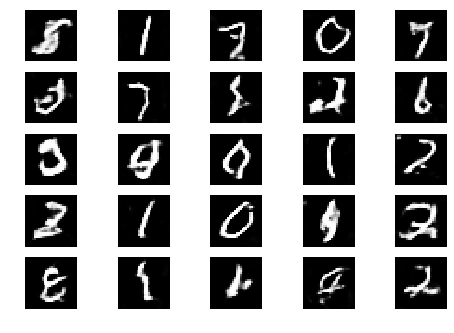

Epoch 2 Batch 1601/1875 [D loss: 0.732749, acc.: 62.50%] [G loss: 1.124078]
Epoch 2 Batch 1602/1875 [D loss: 0.563194, acc.: 71.88%] [G loss: 0.975885]
Epoch 2 Batch 1603/1875 [D loss: 0.806941, acc.: 46.88%] [G loss: 0.984569]
Epoch 2 Batch 1604/1875 [D loss: 0.669092, acc.: 62.50%] [G loss: 0.810843]
Epoch 2 Batch 1605/1875 [D loss: 0.569630, acc.: 65.62%] [G loss: 1.049339]
Epoch 2 Batch 1606/1875 [D loss: 0.623588, acc.: 59.38%] [G loss: 1.056394]
Epoch 2 Batch 1607/1875 [D loss: 0.660791, acc.: 50.00%] [G loss: 1.075207]
Epoch 2 Batch 1608/1875 [D loss: 0.552645, acc.: 75.00%] [G loss: 1.241823]
Epoch 2 Batch 1609/1875 [D loss: 0.631620, acc.: 65.62%] [G loss: 0.922338]
Epoch 2 Batch 1610/1875 [D loss: 0.610546, acc.: 59.38%] [G loss: 1.134233]
Epoch 2 Batch 1611/1875 [D loss: 0.745706, acc.: 53.12%] [G loss: 0.977902]
Epoch 2 Batch 1612/1875 [D loss: 0.695616, acc.: 46.88%] [G loss: 1.199310]
Epoch 2 Batch 1613/1875 [D loss: 0.609804, acc.: 68.75%] [G loss: 1.023271]
Epoch 2 Batc

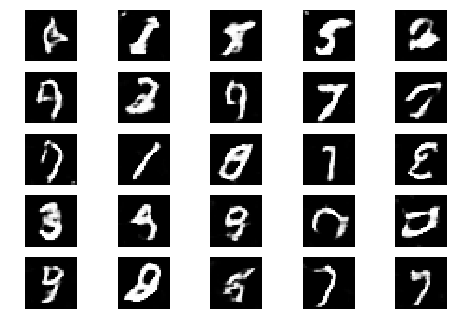

Epoch 2 Batch 1651/1875 [D loss: 0.622555, acc.: 62.50%] [G loss: 1.135244]
Epoch 2 Batch 1652/1875 [D loss: 0.550561, acc.: 78.12%] [G loss: 1.100727]
Epoch 2 Batch 1653/1875 [D loss: 0.597210, acc.: 62.50%] [G loss: 0.965311]
Epoch 2 Batch 1654/1875 [D loss: 0.651712, acc.: 59.38%] [G loss: 0.869819]
Epoch 2 Batch 1655/1875 [D loss: 0.836674, acc.: 40.62%] [G loss: 0.912853]
Epoch 2 Batch 1656/1875 [D loss: 0.600409, acc.: 78.12%] [G loss: 0.830077]
Epoch 2 Batch 1657/1875 [D loss: 0.667372, acc.: 62.50%] [G loss: 0.855199]
Epoch 2 Batch 1658/1875 [D loss: 0.653503, acc.: 68.75%] [G loss: 0.835130]
Epoch 2 Batch 1659/1875 [D loss: 0.589634, acc.: 65.62%] [G loss: 0.803408]
Epoch 2 Batch 1660/1875 [D loss: 0.683166, acc.: 56.25%] [G loss: 0.885471]
Epoch 2 Batch 1661/1875 [D loss: 0.573180, acc.: 68.75%] [G loss: 0.995664]
Epoch 2 Batch 1662/1875 [D loss: 0.881281, acc.: 43.75%] [G loss: 0.925598]
Epoch 2 Batch 1663/1875 [D loss: 0.592817, acc.: 71.88%] [G loss: 0.977241]
Epoch 2 Batc

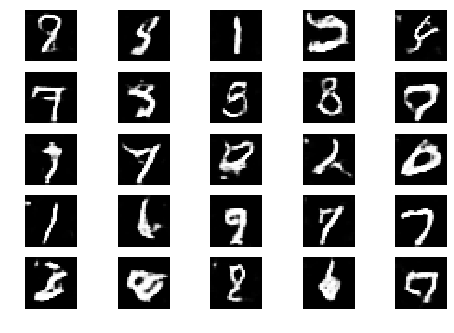

Epoch 2 Batch 1701/1875 [D loss: 0.546256, acc.: 75.00%] [G loss: 0.979568]
Epoch 2 Batch 1702/1875 [D loss: 0.634345, acc.: 62.50%] [G loss: 0.969964]
Epoch 2 Batch 1703/1875 [D loss: 0.751460, acc.: 46.88%] [G loss: 1.221493]
Epoch 2 Batch 1704/1875 [D loss: 0.675622, acc.: 56.25%] [G loss: 0.958428]
Epoch 2 Batch 1705/1875 [D loss: 0.608463, acc.: 56.25%] [G loss: 0.980267]
Epoch 2 Batch 1706/1875 [D loss: 0.549477, acc.: 78.12%] [G loss: 0.888304]
Epoch 2 Batch 1707/1875 [D loss: 0.679149, acc.: 56.25%] [G loss: 0.965594]
Epoch 2 Batch 1708/1875 [D loss: 0.789922, acc.: 46.88%] [G loss: 0.970527]
Epoch 2 Batch 1709/1875 [D loss: 0.718967, acc.: 59.38%] [G loss: 0.964572]
Epoch 2 Batch 1710/1875 [D loss: 0.775747, acc.: 56.25%] [G loss: 0.997181]
Epoch 2 Batch 1711/1875 [D loss: 0.752397, acc.: 50.00%] [G loss: 0.941662]
Epoch 2 Batch 1712/1875 [D loss: 0.682372, acc.: 62.50%] [G loss: 0.907142]
Epoch 2 Batch 1713/1875 [D loss: 0.771171, acc.: 56.25%] [G loss: 1.058000]
Epoch 2 Batc

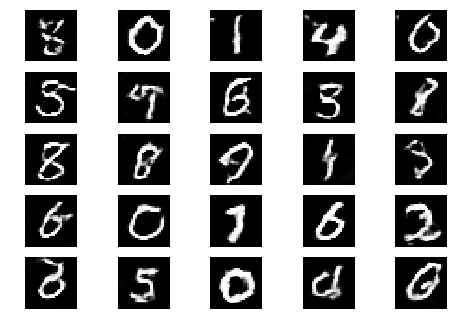

Epoch 2 Batch 1751/1875 [D loss: 0.679901, acc.: 56.25%] [G loss: 0.948353]
Epoch 2 Batch 1752/1875 [D loss: 0.625440, acc.: 71.88%] [G loss: 0.970334]
Epoch 2 Batch 1753/1875 [D loss: 0.693299, acc.: 56.25%] [G loss: 1.078564]
Epoch 2 Batch 1754/1875 [D loss: 0.672046, acc.: 53.12%] [G loss: 0.919493]
Epoch 2 Batch 1755/1875 [D loss: 0.587029, acc.: 71.88%] [G loss: 1.207113]
Epoch 2 Batch 1756/1875 [D loss: 0.652544, acc.: 50.00%] [G loss: 1.111745]
Epoch 2 Batch 1757/1875 [D loss: 0.876152, acc.: 50.00%] [G loss: 0.966985]
Epoch 2 Batch 1758/1875 [D loss: 0.677591, acc.: 65.62%] [G loss: 1.130474]
Epoch 2 Batch 1759/1875 [D loss: 0.605612, acc.: 81.25%] [G loss: 1.080740]
Epoch 2 Batch 1760/1875 [D loss: 0.537367, acc.: 68.75%] [G loss: 0.966491]
Epoch 2 Batch 1761/1875 [D loss: 0.653818, acc.: 53.12%] [G loss: 1.125777]
Epoch 2 Batch 1762/1875 [D loss: 0.652400, acc.: 59.38%] [G loss: 1.161899]
Epoch 2 Batch 1763/1875 [D loss: 0.700441, acc.: 59.38%] [G loss: 1.004682]
Epoch 2 Batc

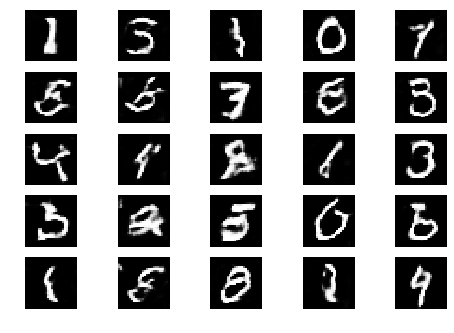

Epoch 2 Batch 1801/1875 [D loss: 0.552559, acc.: 75.00%] [G loss: 0.855546]
Epoch 2 Batch 1802/1875 [D loss: 0.616279, acc.: 71.88%] [G loss: 1.189221]
Epoch 2 Batch 1803/1875 [D loss: 0.665669, acc.: 53.12%] [G loss: 0.974621]
Epoch 2 Batch 1804/1875 [D loss: 0.556383, acc.: 78.12%] [G loss: 1.034712]
Epoch 2 Batch 1805/1875 [D loss: 0.612378, acc.: 75.00%] [G loss: 0.979136]
Epoch 2 Batch 1806/1875 [D loss: 0.719320, acc.: 46.88%] [G loss: 1.150618]
Epoch 2 Batch 1807/1875 [D loss: 0.618428, acc.: 68.75%] [G loss: 1.043246]
Epoch 2 Batch 1808/1875 [D loss: 0.770601, acc.: 53.12%] [G loss: 1.053176]
Epoch 2 Batch 1809/1875 [D loss: 0.555666, acc.: 75.00%] [G loss: 0.949096]
Epoch 2 Batch 1810/1875 [D loss: 0.548212, acc.: 65.62%] [G loss: 1.063067]
Epoch 2 Batch 1811/1875 [D loss: 0.490300, acc.: 78.12%] [G loss: 1.237904]
Epoch 2 Batch 1812/1875 [D loss: 0.582916, acc.: 75.00%] [G loss: 1.117569]
Epoch 2 Batch 1813/1875 [D loss: 0.739900, acc.: 50.00%] [G loss: 0.986276]
Epoch 2 Batc

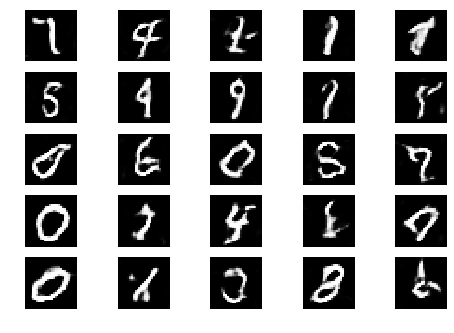

Epoch 2 Batch 1851/1875 [D loss: 0.660937, acc.: 65.62%] [G loss: 0.978579]
Epoch 2 Batch 1852/1875 [D loss: 0.646993, acc.: 56.25%] [G loss: 0.969838]
Epoch 2 Batch 1853/1875 [D loss: 0.854960, acc.: 43.75%] [G loss: 0.958702]
Epoch 2 Batch 1854/1875 [D loss: 0.710091, acc.: 46.88%] [G loss: 1.089402]
Epoch 2 Batch 1855/1875 [D loss: 0.601783, acc.: 71.88%] [G loss: 0.940617]
Epoch 2 Batch 1856/1875 [D loss: 0.621946, acc.: 59.38%] [G loss: 0.892562]
Epoch 2 Batch 1857/1875 [D loss: 0.816732, acc.: 46.88%] [G loss: 0.869780]
Epoch 2 Batch 1858/1875 [D loss: 0.650008, acc.: 62.50%] [G loss: 1.020801]
Epoch 2 Batch 1859/1875 [D loss: 0.752612, acc.: 56.25%] [G loss: 0.954618]
Epoch 2 Batch 1860/1875 [D loss: 0.793389, acc.: 46.88%] [G loss: 1.244144]
Epoch 2 Batch 1861/1875 [D loss: 0.580235, acc.: 65.62%] [G loss: 0.958046]
Epoch 2 Batch 1862/1875 [D loss: 0.685961, acc.: 53.12%] [G loss: 1.072761]
Epoch 2 Batch 1863/1875 [D loss: 0.646706, acc.: 59.38%] [G loss: 0.908754]
Epoch 2 Batc

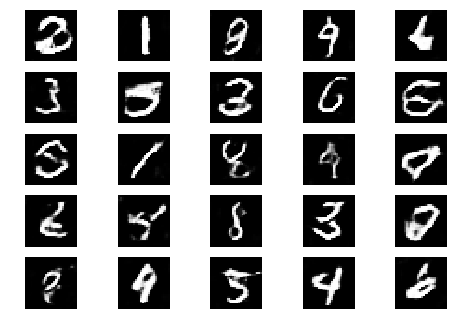

Epoch 3 Batch 1/1875 [D loss: 0.666646, acc.: 59.38%] [G loss: 0.903005]
Epoch 3 Batch 2/1875 [D loss: 0.719360, acc.: 40.62%] [G loss: 1.008888]
Epoch 3 Batch 3/1875 [D loss: 0.777164, acc.: 46.88%] [G loss: 0.988647]
Epoch 3 Batch 4/1875 [D loss: 0.771668, acc.: 50.00%] [G loss: 1.254067]
Epoch 3 Batch 5/1875 [D loss: 0.619659, acc.: 68.75%] [G loss: 0.979584]
Epoch 3 Batch 6/1875 [D loss: 0.681647, acc.: 56.25%] [G loss: 1.031892]
Epoch 3 Batch 7/1875 [D loss: 0.673182, acc.: 53.12%] [G loss: 1.332952]
Epoch 3 Batch 8/1875 [D loss: 0.653145, acc.: 68.75%] [G loss: 1.036021]
Epoch 3 Batch 9/1875 [D loss: 0.617978, acc.: 71.88%] [G loss: 1.049988]
Epoch 3 Batch 10/1875 [D loss: 0.667311, acc.: 62.50%] [G loss: 0.991843]
Epoch 3 Batch 11/1875 [D loss: 0.600088, acc.: 71.88%] [G loss: 1.135820]
Epoch 3 Batch 12/1875 [D loss: 0.683273, acc.: 65.62%] [G loss: 1.016692]
Epoch 3 Batch 13/1875 [D loss: 0.652323, acc.: 65.62%] [G loss: 0.722601]
Epoch 3 Batch 14/1875 [D loss: 0.681090, acc.: 

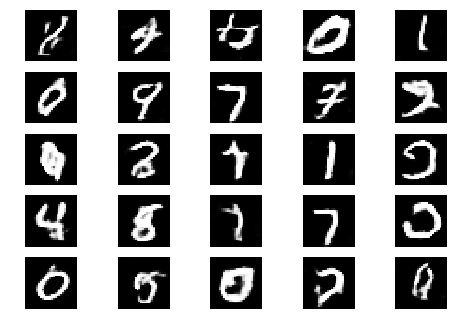

Epoch 3 Batch 51/1875 [D loss: 0.627268, acc.: 65.62%] [G loss: 1.015568]
Epoch 3 Batch 52/1875 [D loss: 0.648404, acc.: 65.62%] [G loss: 1.039513]
Epoch 3 Batch 53/1875 [D loss: 0.611344, acc.: 68.75%] [G loss: 0.982532]
Epoch 3 Batch 54/1875 [D loss: 0.663016, acc.: 56.25%] [G loss: 0.975338]
Epoch 3 Batch 55/1875 [D loss: 0.705515, acc.: 62.50%] [G loss: 1.192478]
Epoch 3 Batch 56/1875 [D loss: 0.466919, acc.: 84.38%] [G loss: 1.021015]
Epoch 3 Batch 57/1875 [D loss: 0.685219, acc.: 62.50%] [G loss: 1.019642]
Epoch 3 Batch 58/1875 [D loss: 0.592542, acc.: 62.50%] [G loss: 1.146644]
Epoch 3 Batch 59/1875 [D loss: 0.660537, acc.: 68.75%] [G loss: 1.032994]
Epoch 3 Batch 60/1875 [D loss: 0.666021, acc.: 59.38%] [G loss: 1.154692]
Epoch 3 Batch 61/1875 [D loss: 0.661378, acc.: 62.50%] [G loss: 0.860198]
Epoch 3 Batch 62/1875 [D loss: 0.717831, acc.: 59.38%] [G loss: 1.030870]
Epoch 3 Batch 63/1875 [D loss: 0.517265, acc.: 75.00%] [G loss: 1.066713]
Epoch 3 Batch 64/1875 [D loss: 0.64121

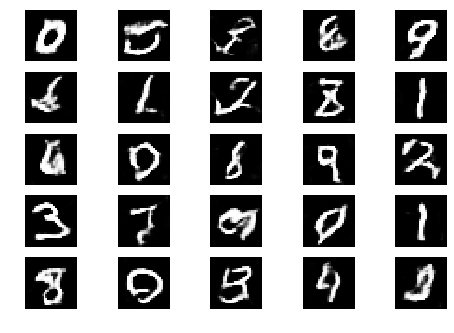

Epoch 3 Batch 101/1875 [D loss: 0.653848, acc.: 56.25%] [G loss: 1.015986]
Epoch 3 Batch 102/1875 [D loss: 0.648704, acc.: 62.50%] [G loss: 0.823664]
Epoch 3 Batch 103/1875 [D loss: 0.728518, acc.: 43.75%] [G loss: 0.969670]
Epoch 3 Batch 104/1875 [D loss: 0.561698, acc.: 68.75%] [G loss: 1.194741]
Epoch 3 Batch 105/1875 [D loss: 0.621831, acc.: 62.50%] [G loss: 1.063616]
Epoch 3 Batch 106/1875 [D loss: 0.638612, acc.: 62.50%] [G loss: 1.188084]
Epoch 3 Batch 107/1875 [D loss: 0.709034, acc.: 53.12%] [G loss: 0.888660]
Epoch 3 Batch 108/1875 [D loss: 0.599960, acc.: 71.88%] [G loss: 1.089152]
Epoch 3 Batch 109/1875 [D loss: 0.631862, acc.: 65.62%] [G loss: 0.947844]
Epoch 3 Batch 110/1875 [D loss: 0.580327, acc.: 71.88%] [G loss: 0.958477]
Epoch 3 Batch 111/1875 [D loss: 0.577682, acc.: 75.00%] [G loss: 1.101117]
Epoch 3 Batch 112/1875 [D loss: 0.726911, acc.: 56.25%] [G loss: 0.888498]
Epoch 3 Batch 113/1875 [D loss: 0.645732, acc.: 62.50%] [G loss: 0.949881]
Epoch 3 Batch 114/1875 [D

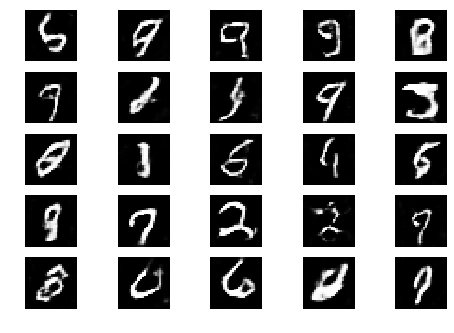

Epoch 3 Batch 151/1875 [D loss: 0.669095, acc.: 65.62%] [G loss: 0.999321]
Epoch 3 Batch 152/1875 [D loss: 0.792959, acc.: 46.88%] [G loss: 1.025445]
Epoch 3 Batch 153/1875 [D loss: 0.605337, acc.: 62.50%] [G loss: 0.971281]
Epoch 3 Batch 154/1875 [D loss: 0.728535, acc.: 53.12%] [G loss: 1.006441]
Epoch 3 Batch 155/1875 [D loss: 0.715263, acc.: 50.00%] [G loss: 1.083273]
Epoch 3 Batch 156/1875 [D loss: 0.611101, acc.: 71.88%] [G loss: 0.891339]
Epoch 3 Batch 157/1875 [D loss: 0.737021, acc.: 56.25%] [G loss: 0.831634]
Epoch 3 Batch 158/1875 [D loss: 0.727515, acc.: 50.00%] [G loss: 0.923994]
Epoch 3 Batch 159/1875 [D loss: 0.589528, acc.: 68.75%] [G loss: 0.906812]
Epoch 3 Batch 160/1875 [D loss: 0.703109, acc.: 62.50%] [G loss: 0.881369]
Epoch 3 Batch 161/1875 [D loss: 0.565423, acc.: 75.00%] [G loss: 0.917703]
Epoch 3 Batch 162/1875 [D loss: 0.651292, acc.: 68.75%] [G loss: 1.198206]
Epoch 3 Batch 163/1875 [D loss: 0.692251, acc.: 59.38%] [G loss: 0.989962]
Epoch 3 Batch 164/1875 [D

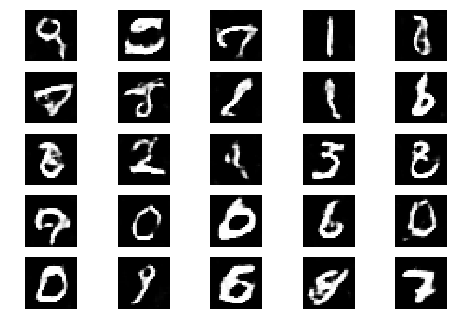

Epoch 3 Batch 201/1875 [D loss: 0.572840, acc.: 71.88%] [G loss: 1.157670]
Epoch 3 Batch 202/1875 [D loss: 0.727331, acc.: 56.25%] [G loss: 1.045990]
Epoch 3 Batch 203/1875 [D loss: 0.691742, acc.: 59.38%] [G loss: 1.070668]
Epoch 3 Batch 204/1875 [D loss: 0.773977, acc.: 59.38%] [G loss: 1.067866]
Epoch 3 Batch 205/1875 [D loss: 0.495820, acc.: 75.00%] [G loss: 0.865488]
Epoch 3 Batch 206/1875 [D loss: 0.718811, acc.: 53.12%] [G loss: 1.013482]
Epoch 3 Batch 207/1875 [D loss: 0.762398, acc.: 40.62%] [G loss: 0.988061]
Epoch 3 Batch 208/1875 [D loss: 0.835041, acc.: 50.00%] [G loss: 0.991510]
Epoch 3 Batch 209/1875 [D loss: 0.538916, acc.: 84.38%] [G loss: 1.058369]
Epoch 3 Batch 210/1875 [D loss: 0.500239, acc.: 75.00%] [G loss: 0.985556]
Epoch 3 Batch 211/1875 [D loss: 0.572120, acc.: 78.12%] [G loss: 1.003162]
Epoch 3 Batch 212/1875 [D loss: 0.734690, acc.: 46.88%] [G loss: 0.987882]
Epoch 3 Batch 213/1875 [D loss: 0.592362, acc.: 62.50%] [G loss: 0.996241]
Epoch 3 Batch 214/1875 [D

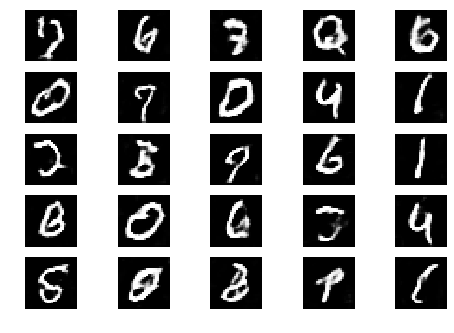

Epoch 3 Batch 251/1875 [D loss: 0.554242, acc.: 71.88%] [G loss: 0.994266]
Epoch 3 Batch 252/1875 [D loss: 0.672643, acc.: 53.12%] [G loss: 0.906331]
Epoch 3 Batch 253/1875 [D loss: 0.766567, acc.: 43.75%] [G loss: 0.939188]
Epoch 3 Batch 254/1875 [D loss: 0.667137, acc.: 53.12%] [G loss: 0.969746]
Epoch 3 Batch 255/1875 [D loss: 0.653371, acc.: 62.50%] [G loss: 1.186147]
Epoch 3 Batch 256/1875 [D loss: 0.643653, acc.: 68.75%] [G loss: 1.049626]
Epoch 3 Batch 257/1875 [D loss: 0.707334, acc.: 59.38%] [G loss: 1.124002]
Epoch 3 Batch 258/1875 [D loss: 0.667044, acc.: 65.62%] [G loss: 0.879873]
Epoch 3 Batch 259/1875 [D loss: 0.614823, acc.: 59.38%] [G loss: 1.078513]
Epoch 3 Batch 260/1875 [D loss: 0.579423, acc.: 59.38%] [G loss: 1.058183]
Epoch 3 Batch 261/1875 [D loss: 0.597012, acc.: 75.00%] [G loss: 1.001373]
Epoch 3 Batch 262/1875 [D loss: 0.717990, acc.: 59.38%] [G loss: 0.992126]
Epoch 3 Batch 263/1875 [D loss: 0.556180, acc.: 71.88%] [G loss: 1.012377]
Epoch 3 Batch 264/1875 [D

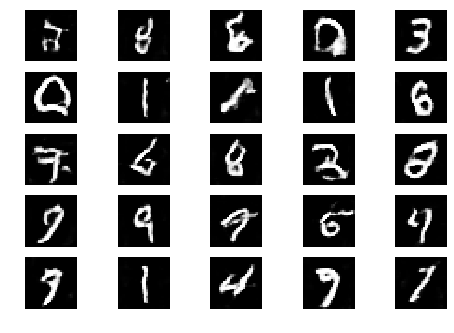

Epoch 3 Batch 301/1875 [D loss: 0.663080, acc.: 59.38%] [G loss: 1.062456]
Epoch 3 Batch 302/1875 [D loss: 0.628408, acc.: 59.38%] [G loss: 1.203606]
Epoch 3 Batch 303/1875 [D loss: 0.765275, acc.: 62.50%] [G loss: 0.945626]
Epoch 3 Batch 304/1875 [D loss: 0.720298, acc.: 56.25%] [G loss: 1.006114]
Epoch 3 Batch 305/1875 [D loss: 0.718559, acc.: 59.38%] [G loss: 0.995755]
Epoch 3 Batch 306/1875 [D loss: 0.650923, acc.: 59.38%] [G loss: 1.010403]
Epoch 3 Batch 307/1875 [D loss: 0.640524, acc.: 59.38%] [G loss: 0.932190]
Epoch 3 Batch 308/1875 [D loss: 0.649522, acc.: 62.50%] [G loss: 0.767354]
Epoch 3 Batch 309/1875 [D loss: 0.503700, acc.: 81.25%] [G loss: 1.063807]
Epoch 3 Batch 310/1875 [D loss: 0.694722, acc.: 56.25%] [G loss: 0.925571]
Epoch 3 Batch 311/1875 [D loss: 0.647084, acc.: 56.25%] [G loss: 1.024795]
Epoch 3 Batch 312/1875 [D loss: 0.595221, acc.: 71.88%] [G loss: 0.970206]
Epoch 3 Batch 313/1875 [D loss: 0.694191, acc.: 59.38%] [G loss: 0.987362]
Epoch 3 Batch 314/1875 [D

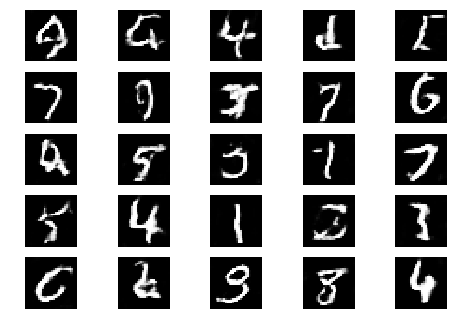

Epoch 3 Batch 351/1875 [D loss: 0.805284, acc.: 40.62%] [G loss: 0.833516]
Epoch 3 Batch 352/1875 [D loss: 0.625333, acc.: 65.62%] [G loss: 0.830577]
Epoch 3 Batch 353/1875 [D loss: 0.653837, acc.: 62.50%] [G loss: 1.119041]
Epoch 3 Batch 354/1875 [D loss: 0.631350, acc.: 59.38%] [G loss: 1.000194]
Epoch 3 Batch 355/1875 [D loss: 0.660929, acc.: 59.38%] [G loss: 0.890266]
Epoch 3 Batch 356/1875 [D loss: 0.777238, acc.: 43.75%] [G loss: 0.910306]
Epoch 3 Batch 357/1875 [D loss: 0.697025, acc.: 56.25%] [G loss: 1.031497]
Epoch 3 Batch 358/1875 [D loss: 0.845474, acc.: 43.75%] [G loss: 1.009582]
Epoch 3 Batch 359/1875 [D loss: 0.575153, acc.: 75.00%] [G loss: 0.950447]
Epoch 3 Batch 360/1875 [D loss: 0.612248, acc.: 65.62%] [G loss: 1.046955]
Epoch 3 Batch 361/1875 [D loss: 0.509767, acc.: 75.00%] [G loss: 1.026728]
Epoch 3 Batch 362/1875 [D loss: 0.709020, acc.: 56.25%] [G loss: 0.911347]
Epoch 3 Batch 363/1875 [D loss: 0.618696, acc.: 62.50%] [G loss: 0.948458]
Epoch 3 Batch 364/1875 [D

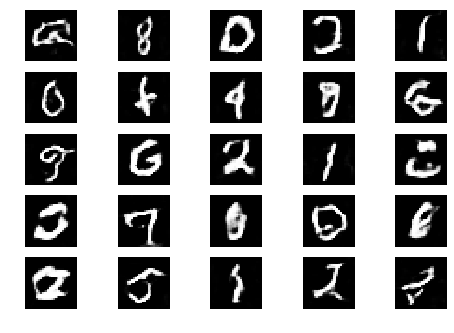

Epoch 3 Batch 401/1875 [D loss: 0.663432, acc.: 62.50%] [G loss: 0.994354]
Epoch 3 Batch 402/1875 [D loss: 0.540749, acc.: 65.62%] [G loss: 0.766482]
Epoch 3 Batch 403/1875 [D loss: 0.715114, acc.: 56.25%] [G loss: 1.166057]
Epoch 3 Batch 404/1875 [D loss: 0.684305, acc.: 59.38%] [G loss: 1.122139]
Epoch 3 Batch 405/1875 [D loss: 0.607469, acc.: 75.00%] [G loss: 0.963066]
Epoch 3 Batch 406/1875 [D loss: 0.808065, acc.: 53.12%] [G loss: 0.914631]
Epoch 3 Batch 407/1875 [D loss: 0.607330, acc.: 59.38%] [G loss: 0.903035]
Epoch 3 Batch 408/1875 [D loss: 0.767397, acc.: 56.25%] [G loss: 0.827590]
Epoch 3 Batch 409/1875 [D loss: 0.639715, acc.: 62.50%] [G loss: 0.934817]
Epoch 3 Batch 410/1875 [D loss: 0.593641, acc.: 71.88%] [G loss: 1.017984]
Epoch 3 Batch 411/1875 [D loss: 0.649171, acc.: 68.75%] [G loss: 1.001426]
Epoch 3 Batch 412/1875 [D loss: 0.528816, acc.: 78.12%] [G loss: 1.011432]
Epoch 3 Batch 413/1875 [D loss: 0.541903, acc.: 75.00%] [G loss: 1.107313]
Epoch 3 Batch 414/1875 [D

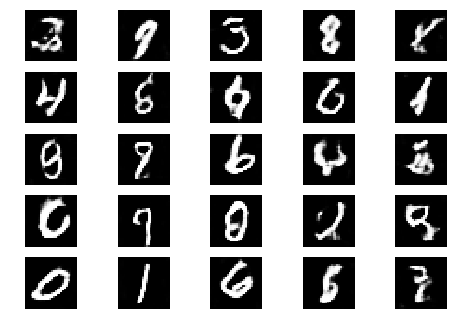

Epoch 3 Batch 451/1875 [D loss: 0.691908, acc.: 53.12%] [G loss: 1.143633]
Epoch 3 Batch 452/1875 [D loss: 0.712104, acc.: 53.12%] [G loss: 1.072985]
Epoch 3 Batch 453/1875 [D loss: 0.751223, acc.: 53.12%] [G loss: 0.915471]
Epoch 3 Batch 454/1875 [D loss: 0.616281, acc.: 75.00%] [G loss: 0.937441]
Epoch 3 Batch 455/1875 [D loss: 0.581405, acc.: 68.75%] [G loss: 1.073393]
Epoch 3 Batch 456/1875 [D loss: 0.637724, acc.: 56.25%] [G loss: 1.052695]
Epoch 3 Batch 457/1875 [D loss: 0.808845, acc.: 43.75%] [G loss: 1.015952]
Epoch 3 Batch 458/1875 [D loss: 0.751406, acc.: 53.12%] [G loss: 0.904083]
Epoch 3 Batch 459/1875 [D loss: 0.579014, acc.: 75.00%] [G loss: 0.867441]
Epoch 3 Batch 460/1875 [D loss: 0.610595, acc.: 71.88%] [G loss: 0.902908]
Epoch 3 Batch 461/1875 [D loss: 0.651928, acc.: 59.38%] [G loss: 1.056801]
Epoch 3 Batch 462/1875 [D loss: 0.691963, acc.: 53.12%] [G loss: 1.148741]
Epoch 3 Batch 463/1875 [D loss: 0.656747, acc.: 56.25%] [G loss: 0.841838]
Epoch 3 Batch 464/1875 [D

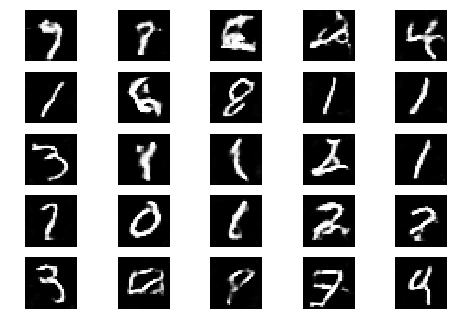

Epoch 3 Batch 501/1875 [D loss: 0.719879, acc.: 53.12%] [G loss: 0.917193]
Epoch 3 Batch 502/1875 [D loss: 0.720703, acc.: 53.12%] [G loss: 1.109261]
Epoch 3 Batch 503/1875 [D loss: 0.603130, acc.: 71.88%] [G loss: 0.940738]
Epoch 3 Batch 504/1875 [D loss: 0.723869, acc.: 59.38%] [G loss: 0.716595]
Epoch 3 Batch 505/1875 [D loss: 0.704811, acc.: 46.88%] [G loss: 1.022470]
Epoch 3 Batch 506/1875 [D loss: 0.724519, acc.: 59.38%] [G loss: 0.990862]
Epoch 3 Batch 507/1875 [D loss: 0.762208, acc.: 53.12%] [G loss: 1.000315]
Epoch 3 Batch 508/1875 [D loss: 0.746972, acc.: 43.75%] [G loss: 1.001159]
Epoch 3 Batch 509/1875 [D loss: 0.565088, acc.: 59.38%] [G loss: 0.885195]
Epoch 3 Batch 510/1875 [D loss: 0.582103, acc.: 59.38%] [G loss: 0.880914]
Epoch 3 Batch 511/1875 [D loss: 0.719488, acc.: 59.38%] [G loss: 1.016696]
Epoch 3 Batch 512/1875 [D loss: 0.626982, acc.: 71.88%] [G loss: 0.929776]
Epoch 3 Batch 513/1875 [D loss: 0.695123, acc.: 56.25%] [G loss: 0.831254]
Epoch 3 Batch 514/1875 [D

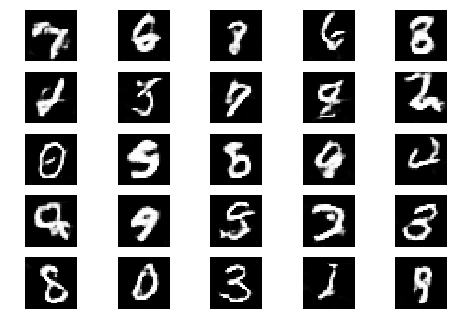

Epoch 3 Batch 551/1875 [D loss: 0.750863, acc.: 46.88%] [G loss: 0.857178]
Epoch 3 Batch 552/1875 [D loss: 0.625984, acc.: 65.62%] [G loss: 0.821442]
Epoch 3 Batch 553/1875 [D loss: 0.645788, acc.: 68.75%] [G loss: 1.003667]
Epoch 3 Batch 554/1875 [D loss: 0.692905, acc.: 59.38%] [G loss: 0.966206]
Epoch 3 Batch 555/1875 [D loss: 0.684144, acc.: 59.38%] [G loss: 0.969086]
Epoch 3 Batch 556/1875 [D loss: 0.678569, acc.: 68.75%] [G loss: 0.960992]
Epoch 3 Batch 557/1875 [D loss: 0.805422, acc.: 62.50%] [G loss: 1.002061]
Epoch 3 Batch 558/1875 [D loss: 0.765453, acc.: 56.25%] [G loss: 1.005363]
Epoch 3 Batch 559/1875 [D loss: 0.682179, acc.: 53.12%] [G loss: 0.969769]
Epoch 3 Batch 560/1875 [D loss: 0.570451, acc.: 62.50%] [G loss: 0.963347]
Epoch 3 Batch 561/1875 [D loss: 0.630349, acc.: 59.38%] [G loss: 1.157755]
Epoch 3 Batch 562/1875 [D loss: 0.692187, acc.: 68.75%] [G loss: 1.111603]
Epoch 3 Batch 563/1875 [D loss: 0.552502, acc.: 78.12%] [G loss: 0.864058]
Epoch 3 Batch 564/1875 [D

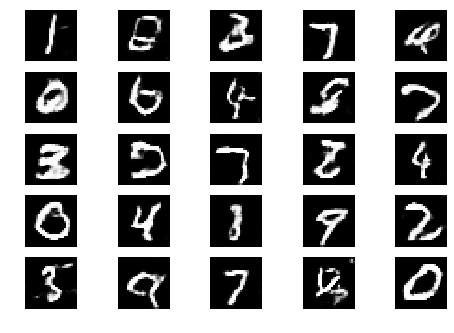

Epoch 3 Batch 601/1875 [D loss: 0.651864, acc.: 59.38%] [G loss: 0.760410]
Epoch 3 Batch 602/1875 [D loss: 0.513566, acc.: 81.25%] [G loss: 0.790074]
Epoch 3 Batch 603/1875 [D loss: 0.709443, acc.: 59.38%] [G loss: 1.006654]
Epoch 3 Batch 604/1875 [D loss: 0.674871, acc.: 65.62%] [G loss: 1.154887]
Epoch 3 Batch 605/1875 [D loss: 0.815503, acc.: 50.00%] [G loss: 0.847654]
Epoch 3 Batch 606/1875 [D loss: 0.596322, acc.: 62.50%] [G loss: 0.882571]
Epoch 3 Batch 607/1875 [D loss: 0.677592, acc.: 59.38%] [G loss: 0.950320]
Epoch 3 Batch 608/1875 [D loss: 0.731370, acc.: 56.25%] [G loss: 0.923255]
Epoch 3 Batch 609/1875 [D loss: 0.675249, acc.: 59.38%] [G loss: 0.941616]
Epoch 3 Batch 610/1875 [D loss: 0.732248, acc.: 43.75%] [G loss: 0.949267]
Epoch 3 Batch 611/1875 [D loss: 0.620267, acc.: 62.50%] [G loss: 0.854249]
Epoch 3 Batch 612/1875 [D loss: 0.748135, acc.: 43.75%] [G loss: 1.051661]
Epoch 3 Batch 613/1875 [D loss: 0.594132, acc.: 68.75%] [G loss: 0.955993]
Epoch 3 Batch 614/1875 [D

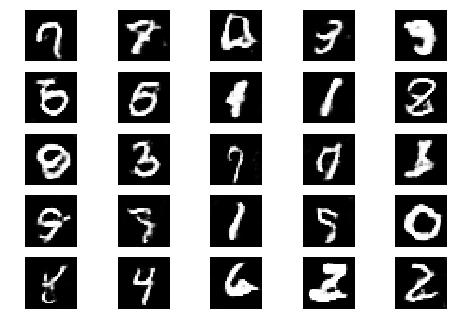

Epoch 3 Batch 651/1875 [D loss: 0.600291, acc.: 71.88%] [G loss: 0.958965]
Epoch 3 Batch 652/1875 [D loss: 0.654769, acc.: 65.62%] [G loss: 0.899802]
Epoch 3 Batch 653/1875 [D loss: 0.800846, acc.: 50.00%] [G loss: 0.981866]
Epoch 3 Batch 654/1875 [D loss: 0.746808, acc.: 50.00%] [G loss: 0.985317]
Epoch 3 Batch 655/1875 [D loss: 0.709315, acc.: 53.12%] [G loss: 0.879442]
Epoch 3 Batch 656/1875 [D loss: 0.705700, acc.: 53.12%] [G loss: 0.884902]
Epoch 3 Batch 657/1875 [D loss: 0.676134, acc.: 68.75%] [G loss: 0.849871]
Epoch 3 Batch 658/1875 [D loss: 0.689929, acc.: 50.00%] [G loss: 0.969429]
Epoch 3 Batch 659/1875 [D loss: 0.679361, acc.: 62.50%] [G loss: 0.749705]
Epoch 3 Batch 660/1875 [D loss: 0.772777, acc.: 46.88%] [G loss: 0.921045]
Epoch 3 Batch 661/1875 [D loss: 0.668601, acc.: 62.50%] [G loss: 0.915249]
Epoch 3 Batch 662/1875 [D loss: 0.628849, acc.: 53.12%] [G loss: 0.771864]
Epoch 3 Batch 663/1875 [D loss: 0.685989, acc.: 50.00%] [G loss: 0.771914]
Epoch 3 Batch 664/1875 [D

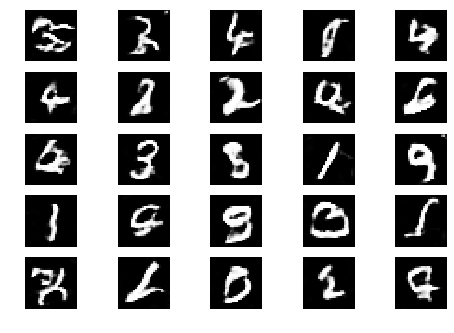

Epoch 3 Batch 701/1875 [D loss: 0.582833, acc.: 75.00%] [G loss: 0.935196]
Epoch 3 Batch 702/1875 [D loss: 0.641754, acc.: 56.25%] [G loss: 0.914323]
Epoch 3 Batch 703/1875 [D loss: 0.684854, acc.: 62.50%] [G loss: 0.919938]
Epoch 3 Batch 704/1875 [D loss: 0.691775, acc.: 59.38%] [G loss: 1.116968]
Epoch 3 Batch 705/1875 [D loss: 0.683835, acc.: 50.00%] [G loss: 0.796079]
Epoch 3 Batch 706/1875 [D loss: 0.712012, acc.: 53.12%] [G loss: 0.968095]
Epoch 3 Batch 707/1875 [D loss: 0.554035, acc.: 75.00%] [G loss: 0.859245]
Epoch 3 Batch 708/1875 [D loss: 0.625214, acc.: 71.88%] [G loss: 1.106278]
Epoch 3 Batch 709/1875 [D loss: 0.711226, acc.: 59.38%] [G loss: 1.053043]
Epoch 3 Batch 710/1875 [D loss: 0.679651, acc.: 59.38%] [G loss: 0.918594]
Epoch 3 Batch 711/1875 [D loss: 0.593474, acc.: 71.88%] [G loss: 0.967043]
Epoch 3 Batch 712/1875 [D loss: 0.767511, acc.: 46.88%] [G loss: 0.899511]
Epoch 3 Batch 713/1875 [D loss: 0.695481, acc.: 50.00%] [G loss: 0.816626]
Epoch 3 Batch 714/1875 [D

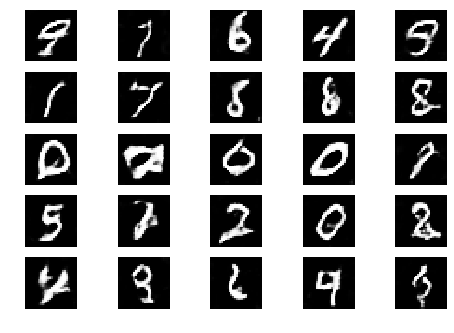

Epoch 3 Batch 751/1875 [D loss: 0.552051, acc.: 75.00%] [G loss: 1.097038]
Epoch 3 Batch 752/1875 [D loss: 0.637642, acc.: 56.25%] [G loss: 0.948922]
Epoch 3 Batch 753/1875 [D loss: 0.554216, acc.: 75.00%] [G loss: 0.939532]
Epoch 3 Batch 754/1875 [D loss: 0.697954, acc.: 50.00%] [G loss: 0.856897]
Epoch 3 Batch 755/1875 [D loss: 0.584290, acc.: 68.75%] [G loss: 0.808813]
Epoch 3 Batch 756/1875 [D loss: 0.658290, acc.: 53.12%] [G loss: 0.972409]
Epoch 3 Batch 757/1875 [D loss: 0.522315, acc.: 78.12%] [G loss: 0.928601]
Epoch 3 Batch 758/1875 [D loss: 0.553660, acc.: 68.75%] [G loss: 0.784255]
Epoch 3 Batch 759/1875 [D loss: 0.739190, acc.: 53.12%] [G loss: 0.930072]
Epoch 3 Batch 760/1875 [D loss: 0.706863, acc.: 50.00%] [G loss: 0.921960]
Epoch 3 Batch 761/1875 [D loss: 0.699626, acc.: 62.50%] [G loss: 0.934014]
Epoch 3 Batch 762/1875 [D loss: 0.557687, acc.: 78.12%] [G loss: 1.005689]
Epoch 3 Batch 763/1875 [D loss: 0.631130, acc.: 59.38%] [G loss: 0.929680]
Epoch 3 Batch 764/1875 [D

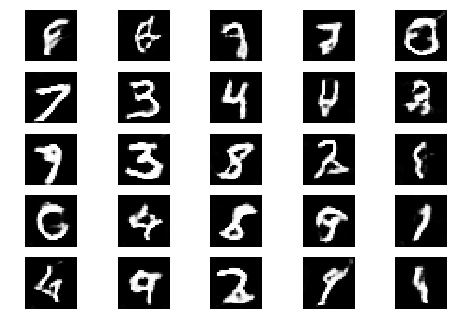

Epoch 3 Batch 801/1875 [D loss: 0.562402, acc.: 78.12%] [G loss: 1.099585]
Epoch 3 Batch 802/1875 [D loss: 0.648477, acc.: 62.50%] [G loss: 0.996016]
Epoch 3 Batch 803/1875 [D loss: 0.603848, acc.: 62.50%] [G loss: 0.968434]
Epoch 3 Batch 804/1875 [D loss: 0.710608, acc.: 59.38%] [G loss: 0.918616]
Epoch 3 Batch 805/1875 [D loss: 0.598283, acc.: 65.62%] [G loss: 1.034657]
Epoch 3 Batch 806/1875 [D loss: 0.689216, acc.: 59.38%] [G loss: 0.872238]
Epoch 3 Batch 807/1875 [D loss: 0.919926, acc.: 40.62%] [G loss: 0.792784]
Epoch 3 Batch 808/1875 [D loss: 0.642978, acc.: 62.50%] [G loss: 0.877156]
Epoch 3 Batch 809/1875 [D loss: 0.600118, acc.: 68.75%] [G loss: 1.061723]
Epoch 3 Batch 810/1875 [D loss: 0.606434, acc.: 59.38%] [G loss: 0.919758]
Epoch 3 Batch 811/1875 [D loss: 0.649139, acc.: 62.50%] [G loss: 0.873136]
Epoch 3 Batch 812/1875 [D loss: 0.782513, acc.: 46.88%] [G loss: 0.823961]
Epoch 3 Batch 813/1875 [D loss: 0.656818, acc.: 59.38%] [G loss: 1.103258]
Epoch 3 Batch 814/1875 [D

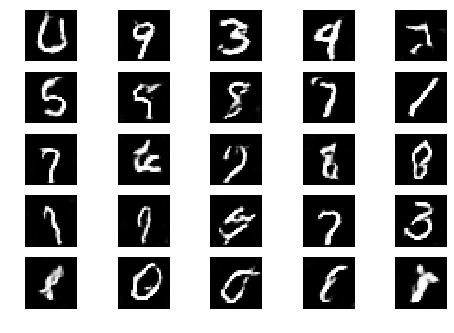

Epoch 3 Batch 851/1875 [D loss: 0.717172, acc.: 50.00%] [G loss: 0.975185]
Epoch 3 Batch 852/1875 [D loss: 0.586301, acc.: 71.88%] [G loss: 1.044015]
Epoch 3 Batch 853/1875 [D loss: 0.596195, acc.: 65.62%] [G loss: 1.025513]
Epoch 3 Batch 854/1875 [D loss: 0.469385, acc.: 84.38%] [G loss: 0.997034]
Epoch 3 Batch 855/1875 [D loss: 0.476713, acc.: 84.38%] [G loss: 1.171744]
Epoch 3 Batch 856/1875 [D loss: 0.709410, acc.: 59.38%] [G loss: 1.015329]
Epoch 3 Batch 857/1875 [D loss: 0.575625, acc.: 68.75%] [G loss: 0.814564]
Epoch 3 Batch 858/1875 [D loss: 0.845153, acc.: 46.88%] [G loss: 1.001515]
Epoch 3 Batch 859/1875 [D loss: 0.606883, acc.: 71.88%] [G loss: 0.869168]
Epoch 3 Batch 860/1875 [D loss: 0.764072, acc.: 40.62%] [G loss: 0.968259]
Epoch 3 Batch 861/1875 [D loss: 0.544800, acc.: 71.88%] [G loss: 0.920516]
Epoch 3 Batch 862/1875 [D loss: 0.567071, acc.: 78.12%] [G loss: 1.094233]
Epoch 3 Batch 863/1875 [D loss: 0.622085, acc.: 56.25%] [G loss: 0.974179]
Epoch 3 Batch 864/1875 [D

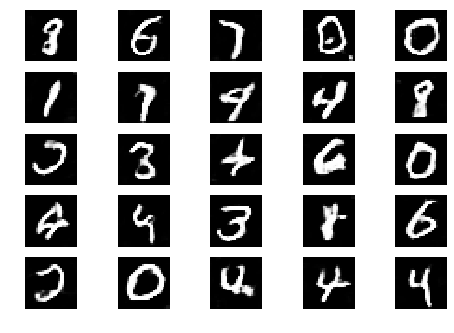

Epoch 3 Batch 901/1875 [D loss: 0.614789, acc.: 68.75%] [G loss: 0.875476]
Epoch 3 Batch 902/1875 [D loss: 0.689499, acc.: 53.12%] [G loss: 1.074154]
Epoch 3 Batch 903/1875 [D loss: 0.620896, acc.: 59.38%] [G loss: 1.230633]
Epoch 3 Batch 904/1875 [D loss: 0.730629, acc.: 56.25%] [G loss: 0.991250]
Epoch 3 Batch 905/1875 [D loss: 0.715322, acc.: 59.38%] [G loss: 0.936742]
Epoch 3 Batch 906/1875 [D loss: 0.572076, acc.: 68.75%] [G loss: 0.921791]
Epoch 3 Batch 907/1875 [D loss: 0.646499, acc.: 65.62%] [G loss: 0.838078]
Epoch 3 Batch 908/1875 [D loss: 0.615304, acc.: 71.88%] [G loss: 0.961567]
Epoch 3 Batch 909/1875 [D loss: 0.537739, acc.: 71.88%] [G loss: 0.863899]
Epoch 3 Batch 910/1875 [D loss: 0.549986, acc.: 68.75%] [G loss: 0.948029]
Epoch 3 Batch 911/1875 [D loss: 0.443120, acc.: 84.38%] [G loss: 0.954931]
Epoch 3 Batch 912/1875 [D loss: 0.846276, acc.: 59.38%] [G loss: 0.994488]
Epoch 3 Batch 913/1875 [D loss: 0.760145, acc.: 50.00%] [G loss: 0.860652]
Epoch 3 Batch 914/1875 [D

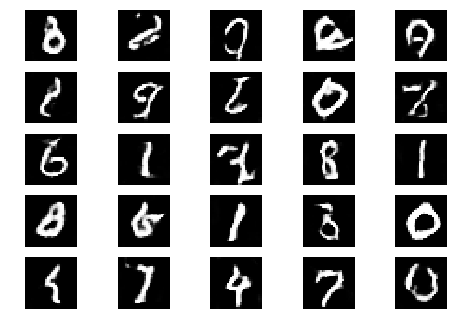

Epoch 3 Batch 951/1875 [D loss: 0.614628, acc.: 78.12%] [G loss: 0.812864]
Epoch 3 Batch 952/1875 [D loss: 0.643921, acc.: 68.75%] [G loss: 1.018197]
Epoch 3 Batch 953/1875 [D loss: 0.757223, acc.: 50.00%] [G loss: 0.813731]
Epoch 3 Batch 954/1875 [D loss: 0.767987, acc.: 56.25%] [G loss: 1.009174]
Epoch 3 Batch 955/1875 [D loss: 0.749980, acc.: 50.00%] [G loss: 1.005159]
Epoch 3 Batch 956/1875 [D loss: 0.700287, acc.: 59.38%] [G loss: 1.134233]
Epoch 3 Batch 957/1875 [D loss: 0.609710, acc.: 68.75%] [G loss: 0.795461]
Epoch 3 Batch 958/1875 [D loss: 0.669749, acc.: 53.12%] [G loss: 1.067656]
Epoch 3 Batch 959/1875 [D loss: 0.637181, acc.: 56.25%] [G loss: 0.942714]
Epoch 3 Batch 960/1875 [D loss: 0.630113, acc.: 65.62%] [G loss: 0.925846]
Epoch 3 Batch 961/1875 [D loss: 0.574696, acc.: 81.25%] [G loss: 0.985481]
Epoch 3 Batch 962/1875 [D loss: 0.746508, acc.: 50.00%] [G loss: 1.122294]
Epoch 3 Batch 963/1875 [D loss: 0.616243, acc.: 65.62%] [G loss: 1.219440]
Epoch 3 Batch 964/1875 [D

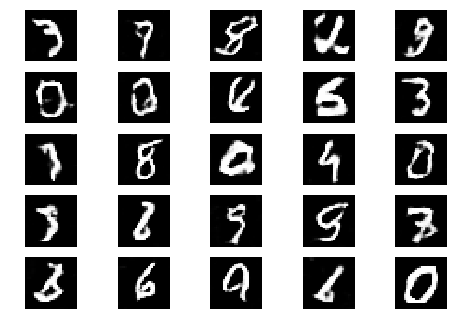

Epoch 3 Batch 1001/1875 [D loss: 0.698863, acc.: 62.50%] [G loss: 1.171344]
Epoch 3 Batch 1002/1875 [D loss: 0.598531, acc.: 68.75%] [G loss: 1.196484]
Epoch 3 Batch 1003/1875 [D loss: 0.649518, acc.: 59.38%] [G loss: 0.872682]
Epoch 3 Batch 1004/1875 [D loss: 0.614921, acc.: 65.62%] [G loss: 0.972052]
Epoch 3 Batch 1005/1875 [D loss: 0.548452, acc.: 71.88%] [G loss: 1.008106]
Epoch 3 Batch 1006/1875 [D loss: 0.751228, acc.: 50.00%] [G loss: 0.989065]
Epoch 3 Batch 1007/1875 [D loss: 0.681203, acc.: 65.62%] [G loss: 0.963557]
Epoch 3 Batch 1008/1875 [D loss: 0.651841, acc.: 59.38%] [G loss: 1.115773]
Epoch 3 Batch 1009/1875 [D loss: 0.657792, acc.: 59.38%] [G loss: 1.071335]
Epoch 3 Batch 1010/1875 [D loss: 0.661088, acc.: 59.38%] [G loss: 0.896598]
Epoch 3 Batch 1011/1875 [D loss: 0.754585, acc.: 53.12%] [G loss: 1.177510]
Epoch 3 Batch 1012/1875 [D loss: 0.567671, acc.: 71.88%] [G loss: 0.972623]
Epoch 3 Batch 1013/1875 [D loss: 0.787525, acc.: 43.75%] [G loss: 1.075301]
Epoch 3 Batc

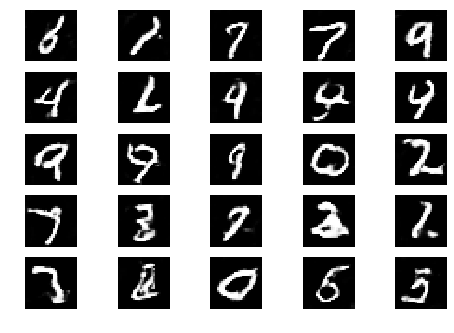

Epoch 3 Batch 1051/1875 [D loss: 0.746413, acc.: 46.88%] [G loss: 0.861011]
Epoch 3 Batch 1052/1875 [D loss: 0.740099, acc.: 53.12%] [G loss: 0.776128]
Epoch 3 Batch 1053/1875 [D loss: 0.645841, acc.: 62.50%] [G loss: 1.055726]
Epoch 3 Batch 1054/1875 [D loss: 0.753661, acc.: 50.00%] [G loss: 1.047489]
Epoch 3 Batch 1055/1875 [D loss: 0.601477, acc.: 65.62%] [G loss: 0.999815]
Epoch 3 Batch 1056/1875 [D loss: 0.585307, acc.: 65.62%] [G loss: 1.107758]
Epoch 3 Batch 1057/1875 [D loss: 0.771833, acc.: 50.00%] [G loss: 1.034021]
Epoch 3 Batch 1058/1875 [D loss: 0.698168, acc.: 56.25%] [G loss: 1.154619]
Epoch 3 Batch 1059/1875 [D loss: 0.739365, acc.: 59.38%] [G loss: 1.138931]
Epoch 3 Batch 1060/1875 [D loss: 0.703224, acc.: 59.38%] [G loss: 1.113940]
Epoch 3 Batch 1061/1875 [D loss: 0.719554, acc.: 59.38%] [G loss: 1.114723]
Epoch 3 Batch 1062/1875 [D loss: 0.678415, acc.: 56.25%] [G loss: 1.316517]
Epoch 3 Batch 1063/1875 [D loss: 0.676815, acc.: 59.38%] [G loss: 0.937291]
Epoch 3 Batc

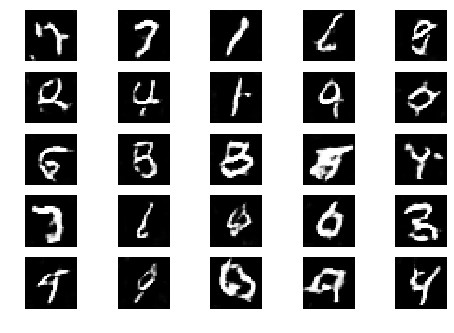

Epoch 3 Batch 1101/1875 [D loss: 0.696619, acc.: 56.25%] [G loss: 0.904335]
Epoch 3 Batch 1102/1875 [D loss: 0.673064, acc.: 68.75%] [G loss: 0.979080]
Epoch 3 Batch 1103/1875 [D loss: 0.862800, acc.: 46.88%] [G loss: 0.844449]
Epoch 3 Batch 1104/1875 [D loss: 0.823380, acc.: 53.12%] [G loss: 0.814369]
Epoch 3 Batch 1105/1875 [D loss: 0.573888, acc.: 71.88%] [G loss: 0.908109]
Epoch 3 Batch 1106/1875 [D loss: 0.610628, acc.: 71.88%] [G loss: 0.926271]
Epoch 3 Batch 1107/1875 [D loss: 0.555022, acc.: 71.88%] [G loss: 0.908954]
Epoch 3 Batch 1108/1875 [D loss: 0.625525, acc.: 68.75%] [G loss: 0.988624]
Epoch 3 Batch 1109/1875 [D loss: 0.618077, acc.: 68.75%] [G loss: 0.943794]
Epoch 3 Batch 1110/1875 [D loss: 0.548302, acc.: 65.62%] [G loss: 1.020013]
Epoch 3 Batch 1111/1875 [D loss: 0.727861, acc.: 53.12%] [G loss: 0.855175]
Epoch 3 Batch 1112/1875 [D loss: 0.660008, acc.: 53.12%] [G loss: 0.904255]
Epoch 3 Batch 1113/1875 [D loss: 0.548113, acc.: 71.88%] [G loss: 0.935055]
Epoch 3 Batc

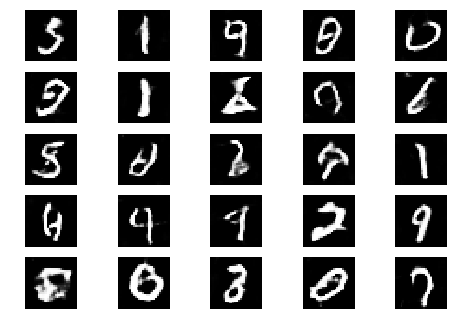

Epoch 3 Batch 1151/1875 [D loss: 0.678596, acc.: 59.38%] [G loss: 0.899258]
Epoch 3 Batch 1152/1875 [D loss: 0.824663, acc.: 46.88%] [G loss: 0.986923]
Epoch 3 Batch 1153/1875 [D loss: 0.639592, acc.: 65.62%] [G loss: 0.991361]
Epoch 3 Batch 1154/1875 [D loss: 0.759882, acc.: 56.25%] [G loss: 0.988840]
Epoch 3 Batch 1155/1875 [D loss: 0.707250, acc.: 50.00%] [G loss: 0.959605]
Epoch 3 Batch 1156/1875 [D loss: 0.528272, acc.: 81.25%] [G loss: 1.072301]
Epoch 3 Batch 1157/1875 [D loss: 0.597578, acc.: 71.88%] [G loss: 0.825195]
Epoch 3 Batch 1158/1875 [D loss: 0.598606, acc.: 65.62%] [G loss: 0.880623]
Epoch 3 Batch 1159/1875 [D loss: 0.708513, acc.: 53.12%] [G loss: 1.058950]
Epoch 3 Batch 1160/1875 [D loss: 0.714595, acc.: 46.88%] [G loss: 0.952934]
Epoch 3 Batch 1161/1875 [D loss: 0.556017, acc.: 78.12%] [G loss: 1.121979]
Epoch 3 Batch 1162/1875 [D loss: 0.775529, acc.: 46.88%] [G loss: 1.197774]
Epoch 3 Batch 1163/1875 [D loss: 0.775498, acc.: 56.25%] [G loss: 1.079559]
Epoch 3 Batc

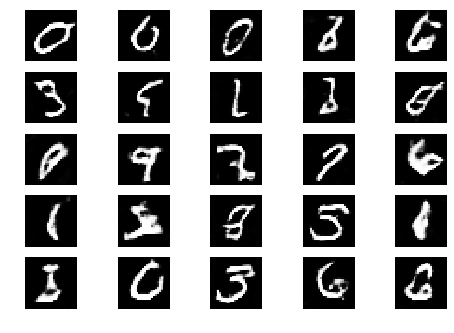

Epoch 3 Batch 1201/1875 [D loss: 0.579356, acc.: 68.75%] [G loss: 0.840098]
Epoch 3 Batch 1202/1875 [D loss: 0.694029, acc.: 65.62%] [G loss: 1.089171]
Epoch 3 Batch 1203/1875 [D loss: 0.695517, acc.: 65.62%] [G loss: 0.997243]
Epoch 3 Batch 1204/1875 [D loss: 0.635575, acc.: 68.75%] [G loss: 0.879714]
Epoch 3 Batch 1205/1875 [D loss: 0.765671, acc.: 62.50%] [G loss: 0.953866]
Epoch 3 Batch 1206/1875 [D loss: 0.522753, acc.: 78.12%] [G loss: 0.830011]
Epoch 3 Batch 1207/1875 [D loss: 0.564268, acc.: 75.00%] [G loss: 0.806364]
Epoch 3 Batch 1208/1875 [D loss: 0.676723, acc.: 56.25%] [G loss: 1.000070]
Epoch 3 Batch 1209/1875 [D loss: 0.713778, acc.: 53.12%] [G loss: 0.958251]
Epoch 3 Batch 1210/1875 [D loss: 0.727610, acc.: 53.12%] [G loss: 0.907789]
Epoch 3 Batch 1211/1875 [D loss: 0.657514, acc.: 62.50%] [G loss: 0.882387]
Epoch 3 Batch 1212/1875 [D loss: 0.695611, acc.: 65.62%] [G loss: 1.050571]
Epoch 3 Batch 1213/1875 [D loss: 0.565563, acc.: 68.75%] [G loss: 0.858472]
Epoch 3 Batc

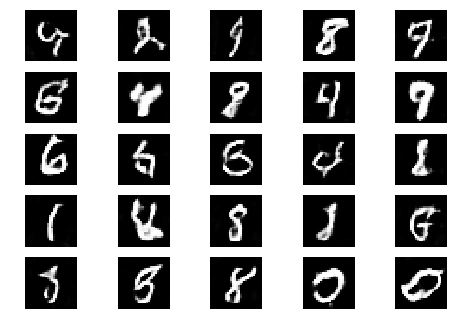

Epoch 3 Batch 1251/1875 [D loss: 0.558328, acc.: 68.75%] [G loss: 0.887029]
Epoch 3 Batch 1252/1875 [D loss: 0.733337, acc.: 62.50%] [G loss: 1.126679]
Epoch 3 Batch 1253/1875 [D loss: 0.655801, acc.: 62.50%] [G loss: 0.817784]
Epoch 3 Batch 1254/1875 [D loss: 0.783061, acc.: 46.88%] [G loss: 1.189804]
Epoch 3 Batch 1255/1875 [D loss: 0.581123, acc.: 71.88%] [G loss: 0.951808]
Epoch 3 Batch 1256/1875 [D loss: 0.672314, acc.: 59.38%] [G loss: 1.139155]
Epoch 3 Batch 1257/1875 [D loss: 0.595596, acc.: 68.75%] [G loss: 0.905829]
Epoch 3 Batch 1258/1875 [D loss: 0.593035, acc.: 71.88%] [G loss: 0.971370]
Epoch 3 Batch 1259/1875 [D loss: 0.753658, acc.: 56.25%] [G loss: 1.073392]
Epoch 3 Batch 1260/1875 [D loss: 0.555467, acc.: 62.50%] [G loss: 1.037378]
Epoch 3 Batch 1261/1875 [D loss: 0.807267, acc.: 53.12%] [G loss: 0.955574]
Epoch 3 Batch 1262/1875 [D loss: 0.694143, acc.: 59.38%] [G loss: 0.940416]
Epoch 3 Batch 1263/1875 [D loss: 0.729641, acc.: 40.62%] [G loss: 1.143912]
Epoch 3 Batc

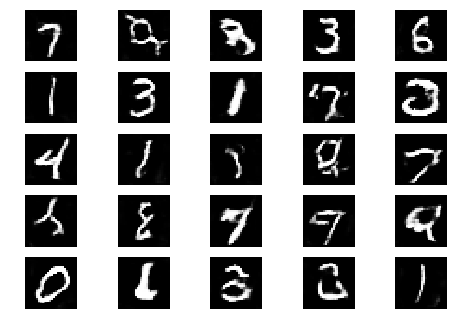

Epoch 3 Batch 1301/1875 [D loss: 0.723477, acc.: 59.38%] [G loss: 0.888804]
Epoch 3 Batch 1302/1875 [D loss: 0.640189, acc.: 62.50%] [G loss: 1.026448]
Epoch 3 Batch 1303/1875 [D loss: 0.652340, acc.: 68.75%] [G loss: 0.935827]
Epoch 3 Batch 1304/1875 [D loss: 0.675451, acc.: 59.38%] [G loss: 1.004137]
Epoch 3 Batch 1305/1875 [D loss: 0.740558, acc.: 50.00%] [G loss: 0.921376]
Epoch 3 Batch 1306/1875 [D loss: 0.665913, acc.: 65.62%] [G loss: 0.954575]
Epoch 3 Batch 1307/1875 [D loss: 0.725858, acc.: 50.00%] [G loss: 1.236806]
Epoch 3 Batch 1308/1875 [D loss: 0.672293, acc.: 56.25%] [G loss: 0.910339]
Epoch 3 Batch 1309/1875 [D loss: 0.621382, acc.: 75.00%] [G loss: 0.875707]
Epoch 3 Batch 1310/1875 [D loss: 0.634361, acc.: 62.50%] [G loss: 0.970485]
Epoch 3 Batch 1311/1875 [D loss: 0.596630, acc.: 65.62%] [G loss: 0.941332]
Epoch 3 Batch 1312/1875 [D loss: 0.616721, acc.: 62.50%] [G loss: 0.921924]
Epoch 3 Batch 1313/1875 [D loss: 0.534657, acc.: 75.00%] [G loss: 0.950953]
Epoch 3 Batc

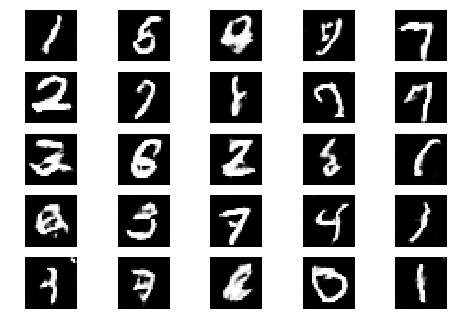

Epoch 3 Batch 1351/1875 [D loss: 0.652118, acc.: 53.12%] [G loss: 0.865914]
Epoch 3 Batch 1352/1875 [D loss: 0.660856, acc.: 68.75%] [G loss: 0.937309]
Epoch 3 Batch 1353/1875 [D loss: 0.671800, acc.: 53.12%] [G loss: 0.998917]
Epoch 3 Batch 1354/1875 [D loss: 0.471335, acc.: 81.25%] [G loss: 1.005063]
Epoch 3 Batch 1355/1875 [D loss: 0.548306, acc.: 81.25%] [G loss: 0.978041]
Epoch 3 Batch 1356/1875 [D loss: 0.593663, acc.: 59.38%] [G loss: 0.998637]
Epoch 3 Batch 1357/1875 [D loss: 0.566304, acc.: 68.75%] [G loss: 0.894691]
Epoch 3 Batch 1358/1875 [D loss: 0.634494, acc.: 75.00%] [G loss: 0.853567]
Epoch 3 Batch 1359/1875 [D loss: 0.636106, acc.: 62.50%] [G loss: 0.895663]
Epoch 3 Batch 1360/1875 [D loss: 0.823650, acc.: 40.62%] [G loss: 0.938243]
Epoch 3 Batch 1361/1875 [D loss: 0.585077, acc.: 75.00%] [G loss: 1.092696]
Epoch 3 Batch 1362/1875 [D loss: 0.531375, acc.: 75.00%] [G loss: 1.147869]
Epoch 3 Batch 1363/1875 [D loss: 0.546636, acc.: 75.00%] [G loss: 0.956401]
Epoch 3 Batc

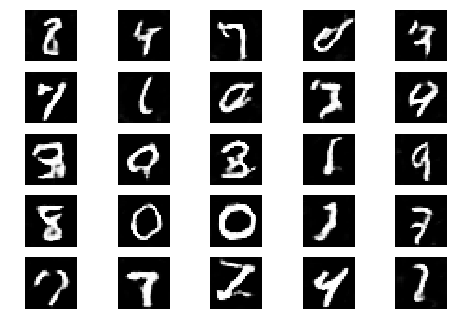

Epoch 3 Batch 1401/1875 [D loss: 0.584687, acc.: 65.62%] [G loss: 0.964773]
Epoch 3 Batch 1402/1875 [D loss: 0.716817, acc.: 62.50%] [G loss: 0.909425]
Epoch 3 Batch 1403/1875 [D loss: 0.650356, acc.: 68.75%] [G loss: 1.058364]
Epoch 3 Batch 1404/1875 [D loss: 0.684847, acc.: 62.50%] [G loss: 1.018225]
Epoch 3 Batch 1405/1875 [D loss: 0.727599, acc.: 46.88%] [G loss: 0.935245]
Epoch 3 Batch 1406/1875 [D loss: 0.595811, acc.: 78.12%] [G loss: 1.097532]
Epoch 3 Batch 1407/1875 [D loss: 0.740666, acc.: 53.12%] [G loss: 0.887117]
Epoch 3 Batch 1408/1875 [D loss: 0.637534, acc.: 68.75%] [G loss: 1.066857]
Epoch 3 Batch 1409/1875 [D loss: 0.762158, acc.: 53.12%] [G loss: 1.039442]
Epoch 3 Batch 1410/1875 [D loss: 0.574402, acc.: 75.00%] [G loss: 1.233836]
Epoch 3 Batch 1411/1875 [D loss: 0.702624, acc.: 53.12%] [G loss: 1.031752]
Epoch 3 Batch 1412/1875 [D loss: 0.576837, acc.: 65.62%] [G loss: 1.168628]
Epoch 3 Batch 1413/1875 [D loss: 0.598843, acc.: 71.88%] [G loss: 1.068691]
Epoch 3 Batc

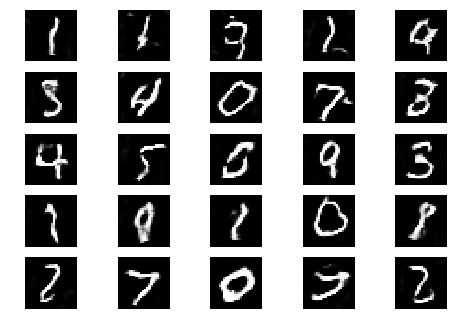

Epoch 3 Batch 1451/1875 [D loss: 0.591426, acc.: 71.88%] [G loss: 1.047762]
Epoch 3 Batch 1452/1875 [D loss: 0.715619, acc.: 65.62%] [G loss: 0.774565]
Epoch 3 Batch 1453/1875 [D loss: 0.644820, acc.: 62.50%] [G loss: 0.951121]
Epoch 3 Batch 1454/1875 [D loss: 0.755143, acc.: 50.00%] [G loss: 0.851497]
Epoch 3 Batch 1455/1875 [D loss: 0.607970, acc.: 68.75%] [G loss: 0.885405]
Epoch 3 Batch 1456/1875 [D loss: 0.747610, acc.: 59.38%] [G loss: 0.852758]
Epoch 3 Batch 1457/1875 [D loss: 0.666642, acc.: 68.75%] [G loss: 0.795064]
Epoch 3 Batch 1458/1875 [D loss: 0.628117, acc.: 65.62%] [G loss: 0.880453]
Epoch 3 Batch 1459/1875 [D loss: 0.564957, acc.: 65.62%] [G loss: 0.995305]
Epoch 3 Batch 1460/1875 [D loss: 0.678793, acc.: 56.25%] [G loss: 0.897024]
Epoch 3 Batch 1461/1875 [D loss: 0.698270, acc.: 59.38%] [G loss: 1.084685]
Epoch 3 Batch 1462/1875 [D loss: 0.564503, acc.: 78.12%] [G loss: 1.007401]
Epoch 3 Batch 1463/1875 [D loss: 0.651815, acc.: 56.25%] [G loss: 0.889163]
Epoch 3 Batc

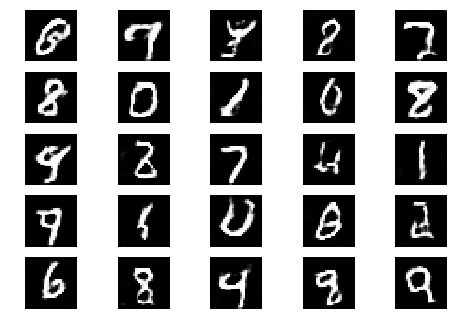

Epoch 3 Batch 1501/1875 [D loss: 0.563541, acc.: 68.75%] [G loss: 0.891400]
Epoch 3 Batch 1502/1875 [D loss: 0.597623, acc.: 65.62%] [G loss: 0.838879]
Epoch 3 Batch 1503/1875 [D loss: 0.519780, acc.: 75.00%] [G loss: 1.007342]
Epoch 3 Batch 1504/1875 [D loss: 0.742618, acc.: 53.12%] [G loss: 1.109190]
Epoch 3 Batch 1505/1875 [D loss: 0.588838, acc.: 71.88%] [G loss: 1.078423]
Epoch 3 Batch 1506/1875 [D loss: 0.674422, acc.: 59.38%] [G loss: 1.078843]
Epoch 3 Batch 1507/1875 [D loss: 0.665641, acc.: 65.62%] [G loss: 1.174543]
Epoch 3 Batch 1508/1875 [D loss: 0.714362, acc.: 50.00%] [G loss: 1.004840]
Epoch 3 Batch 1509/1875 [D loss: 0.666851, acc.: 59.38%] [G loss: 1.039119]
Epoch 3 Batch 1510/1875 [D loss: 0.503977, acc.: 84.38%] [G loss: 0.939102]
Epoch 3 Batch 1511/1875 [D loss: 0.817945, acc.: 43.75%] [G loss: 0.937158]
Epoch 3 Batch 1512/1875 [D loss: 0.653332, acc.: 65.62%] [G loss: 1.059769]
Epoch 3 Batch 1513/1875 [D loss: 0.660789, acc.: 65.62%] [G loss: 0.792980]
Epoch 3 Batc

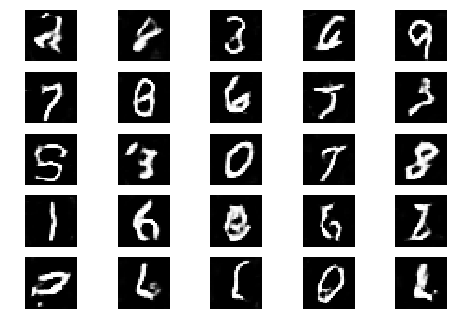

Epoch 3 Batch 1551/1875 [D loss: 0.514527, acc.: 75.00%] [G loss: 0.922476]
Epoch 3 Batch 1552/1875 [D loss: 0.686266, acc.: 59.38%] [G loss: 0.939563]
Epoch 3 Batch 1553/1875 [D loss: 0.722286, acc.: 53.12%] [G loss: 0.903865]
Epoch 3 Batch 1554/1875 [D loss: 0.700666, acc.: 59.38%] [G loss: 0.958685]
Epoch 3 Batch 1555/1875 [D loss: 0.626064, acc.: 62.50%] [G loss: 0.964060]
Epoch 3 Batch 1556/1875 [D loss: 0.715436, acc.: 50.00%] [G loss: 0.898415]
Epoch 3 Batch 1557/1875 [D loss: 0.610490, acc.: 68.75%] [G loss: 0.977192]
Epoch 3 Batch 1558/1875 [D loss: 0.620106, acc.: 75.00%] [G loss: 1.024605]
Epoch 3 Batch 1559/1875 [D loss: 0.644887, acc.: 62.50%] [G loss: 0.800224]
Epoch 3 Batch 1560/1875 [D loss: 0.519367, acc.: 81.25%] [G loss: 0.845190]
Epoch 3 Batch 1561/1875 [D loss: 0.559431, acc.: 71.88%] [G loss: 1.009720]
Epoch 3 Batch 1562/1875 [D loss: 0.650209, acc.: 56.25%] [G loss: 0.753841]
Epoch 3 Batch 1563/1875 [D loss: 0.615076, acc.: 53.12%] [G loss: 0.845047]
Epoch 3 Batc

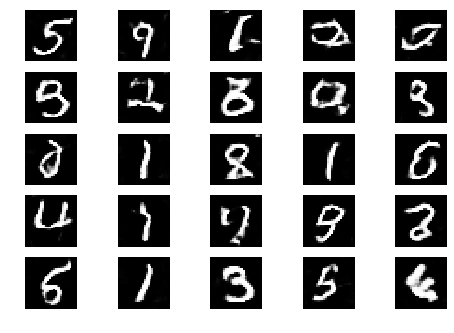

Epoch 3 Batch 1601/1875 [D loss: 0.480454, acc.: 84.38%] [G loss: 1.104270]
Epoch 3 Batch 1602/1875 [D loss: 0.690378, acc.: 50.00%] [G loss: 1.102345]
Epoch 3 Batch 1603/1875 [D loss: 0.577748, acc.: 71.88%] [G loss: 1.020645]
Epoch 3 Batch 1604/1875 [D loss: 0.650177, acc.: 59.38%] [G loss: 0.853253]
Epoch 3 Batch 1605/1875 [D loss: 0.748549, acc.: 46.88%] [G loss: 0.933842]
Epoch 3 Batch 1606/1875 [D loss: 0.540424, acc.: 75.00%] [G loss: 1.042151]
Epoch 3 Batch 1607/1875 [D loss: 0.697034, acc.: 59.38%] [G loss: 1.015668]
Epoch 3 Batch 1608/1875 [D loss: 0.567887, acc.: 71.88%] [G loss: 1.019879]
Epoch 3 Batch 1609/1875 [D loss: 0.638850, acc.: 65.62%] [G loss: 0.818292]
Epoch 3 Batch 1610/1875 [D loss: 0.553863, acc.: 68.75%] [G loss: 0.808106]
Epoch 3 Batch 1611/1875 [D loss: 0.599658, acc.: 68.75%] [G loss: 0.939638]
Epoch 3 Batch 1612/1875 [D loss: 0.666080, acc.: 50.00%] [G loss: 1.009975]
Epoch 3 Batch 1613/1875 [D loss: 0.726132, acc.: 65.62%] [G loss: 1.158538]
Epoch 3 Batc

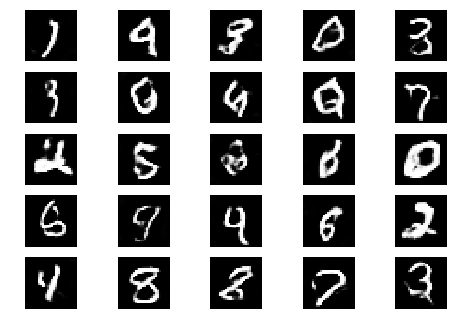

Epoch 3 Batch 1651/1875 [D loss: 0.689966, acc.: 59.38%] [G loss: 0.960568]
Epoch 3 Batch 1652/1875 [D loss: 0.691513, acc.: 62.50%] [G loss: 0.926462]
Epoch 3 Batch 1653/1875 [D loss: 0.878756, acc.: 50.00%] [G loss: 0.978895]
Epoch 3 Batch 1654/1875 [D loss: 0.660662, acc.: 62.50%] [G loss: 0.920710]
Epoch 3 Batch 1655/1875 [D loss: 0.631916, acc.: 56.25%] [G loss: 0.903889]
Epoch 3 Batch 1656/1875 [D loss: 0.589200, acc.: 75.00%] [G loss: 1.226835]
Epoch 3 Batch 1657/1875 [D loss: 0.532183, acc.: 75.00%] [G loss: 1.170500]
Epoch 3 Batch 1658/1875 [D loss: 0.808810, acc.: 37.50%] [G loss: 0.956930]
Epoch 3 Batch 1659/1875 [D loss: 0.693000, acc.: 65.62%] [G loss: 0.982631]
Epoch 3 Batch 1660/1875 [D loss: 0.582768, acc.: 68.75%] [G loss: 0.901481]
Epoch 3 Batch 1661/1875 [D loss: 0.736443, acc.: 59.38%] [G loss: 1.318549]
Epoch 3 Batch 1662/1875 [D loss: 0.579572, acc.: 81.25%] [G loss: 0.930998]
Epoch 3 Batch 1663/1875 [D loss: 0.635570, acc.: 62.50%] [G loss: 0.924603]
Epoch 3 Batc

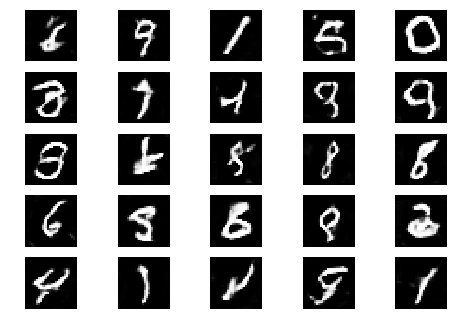

Epoch 3 Batch 1701/1875 [D loss: 0.719024, acc.: 62.50%] [G loss: 0.988811]
Epoch 3 Batch 1702/1875 [D loss: 0.710971, acc.: 56.25%] [G loss: 0.928010]
Epoch 3 Batch 1703/1875 [D loss: 0.700066, acc.: 56.25%] [G loss: 0.989795]
Epoch 3 Batch 1704/1875 [D loss: 0.649864, acc.: 68.75%] [G loss: 0.954074]
Epoch 3 Batch 1705/1875 [D loss: 0.623032, acc.: 68.75%] [G loss: 0.993122]
Epoch 3 Batch 1706/1875 [D loss: 0.680040, acc.: 56.25%] [G loss: 0.845943]
Epoch 3 Batch 1707/1875 [D loss: 0.690903, acc.: 50.00%] [G loss: 1.008593]
Epoch 3 Batch 1708/1875 [D loss: 0.685238, acc.: 62.50%] [G loss: 0.813937]
Epoch 3 Batch 1709/1875 [D loss: 0.691869, acc.: 59.38%] [G loss: 0.888792]
Epoch 3 Batch 1710/1875 [D loss: 0.711701, acc.: 56.25%] [G loss: 0.801600]
Epoch 3 Batch 1711/1875 [D loss: 0.666179, acc.: 65.62%] [G loss: 0.829724]
Epoch 3 Batch 1712/1875 [D loss: 0.619830, acc.: 75.00%] [G loss: 0.986469]
Epoch 3 Batch 1713/1875 [D loss: 0.697524, acc.: 56.25%] [G loss: 0.939095]
Epoch 3 Batc

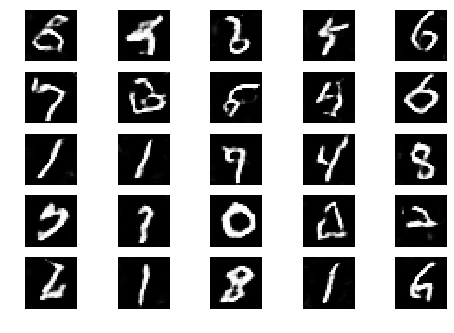

Epoch 3 Batch 1751/1875 [D loss: 0.723766, acc.: 59.38%] [G loss: 0.966491]
Epoch 3 Batch 1752/1875 [D loss: 0.757536, acc.: 37.50%] [G loss: 0.975968]
Epoch 3 Batch 1753/1875 [D loss: 0.577214, acc.: 68.75%] [G loss: 0.952984]
Epoch 3 Batch 1754/1875 [D loss: 0.696660, acc.: 59.38%] [G loss: 0.838129]
Epoch 3 Batch 1755/1875 [D loss: 0.593211, acc.: 71.88%] [G loss: 0.916682]
Epoch 3 Batch 1756/1875 [D loss: 0.728068, acc.: 59.38%] [G loss: 0.771910]
Epoch 3 Batch 1757/1875 [D loss: 0.623204, acc.: 65.62%] [G loss: 1.143065]
Epoch 3 Batch 1758/1875 [D loss: 0.703333, acc.: 59.38%] [G loss: 0.934093]
Epoch 3 Batch 1759/1875 [D loss: 0.696235, acc.: 50.00%] [G loss: 0.884827]
Epoch 3 Batch 1760/1875 [D loss: 0.691198, acc.: 53.12%] [G loss: 0.839425]
Epoch 3 Batch 1761/1875 [D loss: 0.753181, acc.: 53.12%] [G loss: 0.870985]
Epoch 3 Batch 1762/1875 [D loss: 0.731913, acc.: 43.75%] [G loss: 0.839803]
Epoch 3 Batch 1763/1875 [D loss: 0.720008, acc.: 50.00%] [G loss: 0.879610]
Epoch 3 Batc

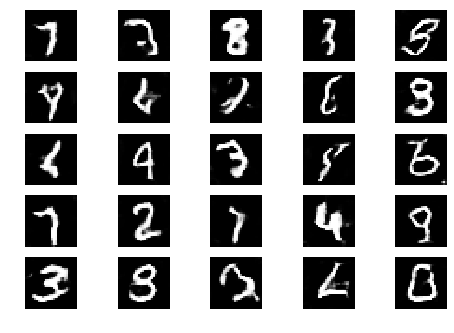

Epoch 3 Batch 1801/1875 [D loss: 0.639835, acc.: 71.88%] [G loss: 0.962718]
Epoch 3 Batch 1802/1875 [D loss: 0.750003, acc.: 56.25%] [G loss: 0.892658]
Epoch 3 Batch 1803/1875 [D loss: 0.698985, acc.: 46.88%] [G loss: 0.793075]
Epoch 3 Batch 1804/1875 [D loss: 0.497373, acc.: 84.38%] [G loss: 0.948649]
Epoch 3 Batch 1805/1875 [D loss: 0.668687, acc.: 65.62%] [G loss: 0.882658]
Epoch 3 Batch 1806/1875 [D loss: 0.670889, acc.: 53.12%] [G loss: 0.971697]
Epoch 3 Batch 1807/1875 [D loss: 0.672009, acc.: 62.50%] [G loss: 1.177415]
Epoch 3 Batch 1808/1875 [D loss: 0.658329, acc.: 53.12%] [G loss: 1.085784]
Epoch 3 Batch 1809/1875 [D loss: 0.713694, acc.: 46.88%] [G loss: 0.946717]
Epoch 3 Batch 1810/1875 [D loss: 0.717014, acc.: 53.12%] [G loss: 1.160567]
Epoch 3 Batch 1811/1875 [D loss: 0.734747, acc.: 59.38%] [G loss: 0.989289]
Epoch 3 Batch 1812/1875 [D loss: 0.606271, acc.: 62.50%] [G loss: 1.088956]
Epoch 3 Batch 1813/1875 [D loss: 0.725351, acc.: 62.50%] [G loss: 0.788320]
Epoch 3 Batc

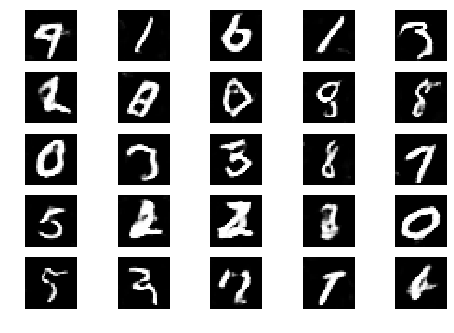

Epoch 3 Batch 1851/1875 [D loss: 0.584391, acc.: 62.50%] [G loss: 0.898604]
Epoch 3 Batch 1852/1875 [D loss: 0.601717, acc.: 75.00%] [G loss: 0.855480]
Epoch 3 Batch 1853/1875 [D loss: 0.535058, acc.: 78.12%] [G loss: 0.837110]
Epoch 3 Batch 1854/1875 [D loss: 0.861613, acc.: 34.38%] [G loss: 1.024382]
Epoch 3 Batch 1855/1875 [D loss: 0.631200, acc.: 53.12%] [G loss: 1.180972]
Epoch 3 Batch 1856/1875 [D loss: 0.663366, acc.: 62.50%] [G loss: 0.953094]
Epoch 3 Batch 1857/1875 [D loss: 0.725512, acc.: 43.75%] [G loss: 0.941108]
Epoch 3 Batch 1858/1875 [D loss: 0.530112, acc.: 71.88%] [G loss: 1.034199]
Epoch 3 Batch 1859/1875 [D loss: 0.783019, acc.: 40.62%] [G loss: 1.017176]
Epoch 3 Batch 1860/1875 [D loss: 0.674166, acc.: 59.38%] [G loss: 1.127583]
Epoch 3 Batch 1861/1875 [D loss: 0.645226, acc.: 75.00%] [G loss: 1.037545]
Epoch 3 Batch 1862/1875 [D loss: 0.693480, acc.: 53.12%] [G loss: 0.894669]
Epoch 3 Batch 1863/1875 [D loss: 0.702338, acc.: 56.25%] [G loss: 0.824490]
Epoch 3 Batc

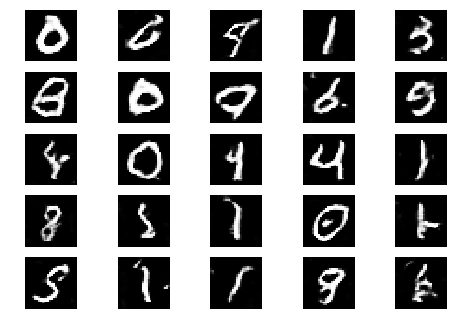

Epoch 4 Batch 1/1875 [D loss: 0.684031, acc.: 53.12%] [G loss: 0.882005]
Epoch 4 Batch 2/1875 [D loss: 0.776914, acc.: 46.88%] [G loss: 1.096115]
Epoch 4 Batch 3/1875 [D loss: 0.624758, acc.: 62.50%] [G loss: 0.978291]
Epoch 4 Batch 4/1875 [D loss: 0.644562, acc.: 59.38%] [G loss: 0.894892]
Epoch 4 Batch 5/1875 [D loss: 0.684025, acc.: 53.12%] [G loss: 0.918976]
Epoch 4 Batch 6/1875 [D loss: 0.548942, acc.: 78.12%] [G loss: 0.945161]
Epoch 4 Batch 7/1875 [D loss: 0.634014, acc.: 56.25%] [G loss: 0.946465]
Epoch 4 Batch 8/1875 [D loss: 0.480303, acc.: 78.12%] [G loss: 1.030261]
Epoch 4 Batch 9/1875 [D loss: 0.649412, acc.: 59.38%] [G loss: 1.146991]
Epoch 4 Batch 10/1875 [D loss: 0.795889, acc.: 59.38%] [G loss: 1.193966]
Epoch 4 Batch 11/1875 [D loss: 0.685365, acc.: 62.50%] [G loss: 0.813906]
Epoch 4 Batch 12/1875 [D loss: 0.686070, acc.: 59.38%] [G loss: 0.948876]
Epoch 4 Batch 13/1875 [D loss: 0.626965, acc.: 56.25%] [G loss: 0.903765]
Epoch 4 Batch 14/1875 [D loss: 0.594400, acc.: 

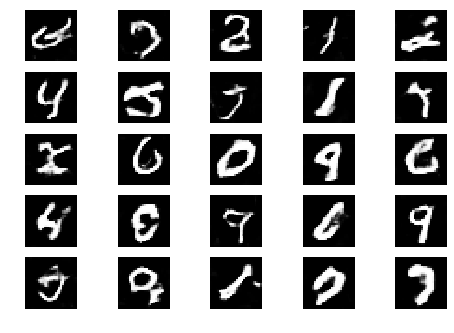

Epoch 4 Batch 51/1875 [D loss: 0.598957, acc.: 65.62%] [G loss: 0.960958]
Epoch 4 Batch 52/1875 [D loss: 0.774454, acc.: 43.75%] [G loss: 1.109170]
Epoch 4 Batch 53/1875 [D loss: 0.646758, acc.: 59.38%] [G loss: 1.041714]
Epoch 4 Batch 54/1875 [D loss: 0.657399, acc.: 65.62%] [G loss: 0.933844]
Epoch 4 Batch 55/1875 [D loss: 0.818410, acc.: 53.12%] [G loss: 1.147123]
Epoch 4 Batch 56/1875 [D loss: 0.614580, acc.: 68.75%] [G loss: 0.937255]
Epoch 4 Batch 57/1875 [D loss: 0.561500, acc.: 75.00%] [G loss: 1.038065]
Epoch 4 Batch 58/1875 [D loss: 0.662268, acc.: 65.62%] [G loss: 0.861011]
Epoch 4 Batch 59/1875 [D loss: 0.436244, acc.: 90.62%] [G loss: 0.792820]
Epoch 4 Batch 60/1875 [D loss: 0.747208, acc.: 43.75%] [G loss: 0.826022]
Epoch 4 Batch 61/1875 [D loss: 0.680086, acc.: 62.50%] [G loss: 0.839322]
Epoch 4 Batch 62/1875 [D loss: 0.739609, acc.: 56.25%] [G loss: 1.058607]
Epoch 4 Batch 63/1875 [D loss: 0.552443, acc.: 78.12%] [G loss: 1.020916]
Epoch 4 Batch 64/1875 [D loss: 0.58943

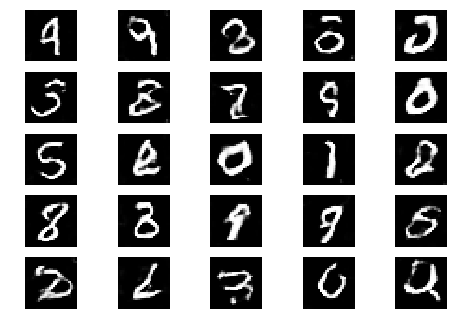

Epoch 4 Batch 101/1875 [D loss: 0.554552, acc.: 71.88%] [G loss: 0.960306]
Epoch 4 Batch 102/1875 [D loss: 0.731986, acc.: 53.12%] [G loss: 0.851619]
Epoch 4 Batch 103/1875 [D loss: 0.634229, acc.: 68.75%] [G loss: 0.876377]
Epoch 4 Batch 104/1875 [D loss: 0.585374, acc.: 62.50%] [G loss: 0.843073]
Epoch 4 Batch 105/1875 [D loss: 0.608617, acc.: 59.38%] [G loss: 1.015659]
Epoch 4 Batch 106/1875 [D loss: 0.598394, acc.: 62.50%] [G loss: 0.918904]
Epoch 4 Batch 107/1875 [D loss: 0.662076, acc.: 59.38%] [G loss: 1.010998]
Epoch 4 Batch 108/1875 [D loss: 0.680171, acc.: 62.50%] [G loss: 0.936329]
Epoch 4 Batch 109/1875 [D loss: 0.670198, acc.: 59.38%] [G loss: 0.915146]
Epoch 4 Batch 110/1875 [D loss: 0.709936, acc.: 65.62%] [G loss: 0.780372]
Epoch 4 Batch 111/1875 [D loss: 0.554632, acc.: 71.88%] [G loss: 1.082037]
Epoch 4 Batch 112/1875 [D loss: 0.748702, acc.: 62.50%] [G loss: 1.094523]
Epoch 4 Batch 113/1875 [D loss: 0.757273, acc.: 46.88%] [G loss: 0.998013]
Epoch 4 Batch 114/1875 [D

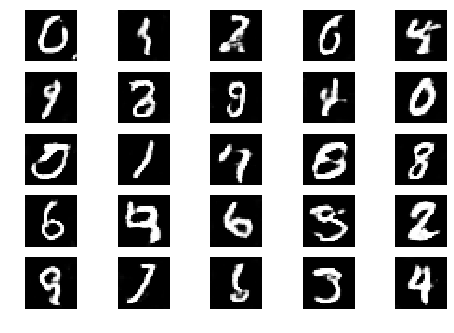

Epoch 4 Batch 151/1875 [D loss: 0.783702, acc.: 43.75%] [G loss: 1.077161]
Epoch 4 Batch 152/1875 [D loss: 0.715195, acc.: 56.25%] [G loss: 1.059562]
Epoch 4 Batch 153/1875 [D loss: 0.846725, acc.: 34.38%] [G loss: 0.806137]
Epoch 4 Batch 154/1875 [D loss: 0.697107, acc.: 56.25%] [G loss: 0.963982]
Epoch 4 Batch 155/1875 [D loss: 0.595550, acc.: 71.88%] [G loss: 0.962240]
Epoch 4 Batch 156/1875 [D loss: 0.597140, acc.: 71.88%] [G loss: 0.869174]
Epoch 4 Batch 157/1875 [D loss: 0.558069, acc.: 78.12%] [G loss: 1.144579]
Epoch 4 Batch 158/1875 [D loss: 0.607285, acc.: 71.88%] [G loss: 0.955850]
Epoch 4 Batch 159/1875 [D loss: 0.721896, acc.: 46.88%] [G loss: 0.919853]
Epoch 4 Batch 160/1875 [D loss: 0.603386, acc.: 65.62%] [G loss: 0.892176]
Epoch 4 Batch 161/1875 [D loss: 0.703337, acc.: 65.62%] [G loss: 0.921206]
Epoch 4 Batch 162/1875 [D loss: 0.584405, acc.: 65.62%] [G loss: 0.955638]
Epoch 4 Batch 163/1875 [D loss: 0.697942, acc.: 53.12%] [G loss: 0.922704]
Epoch 4 Batch 164/1875 [D

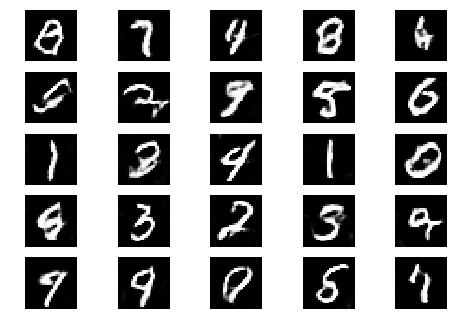

Epoch 4 Batch 201/1875 [D loss: 0.590416, acc.: 62.50%] [G loss: 0.858999]
Epoch 4 Batch 202/1875 [D loss: 0.649873, acc.: 65.62%] [G loss: 0.952694]
Epoch 4 Batch 203/1875 [D loss: 0.696852, acc.: 59.38%] [G loss: 0.870251]
Epoch 4 Batch 204/1875 [D loss: 0.566500, acc.: 56.25%] [G loss: 0.969306]
Epoch 4 Batch 205/1875 [D loss: 0.711109, acc.: 50.00%] [G loss: 0.742805]
Epoch 4 Batch 206/1875 [D loss: 0.616142, acc.: 65.62%] [G loss: 0.927858]
Epoch 4 Batch 207/1875 [D loss: 0.686851, acc.: 65.62%] [G loss: 0.941370]
Epoch 4 Batch 208/1875 [D loss: 0.806292, acc.: 43.75%] [G loss: 0.851548]
Epoch 4 Batch 209/1875 [D loss: 0.658110, acc.: 56.25%] [G loss: 0.894531]
Epoch 4 Batch 210/1875 [D loss: 0.614494, acc.: 78.12%] [G loss: 0.980603]
Epoch 4 Batch 211/1875 [D loss: 0.747262, acc.: 56.25%] [G loss: 0.758610]
Epoch 4 Batch 212/1875 [D loss: 0.668744, acc.: 53.12%] [G loss: 0.929723]
Epoch 4 Batch 213/1875 [D loss: 0.644653, acc.: 59.38%] [G loss: 1.090183]
Epoch 4 Batch 214/1875 [D

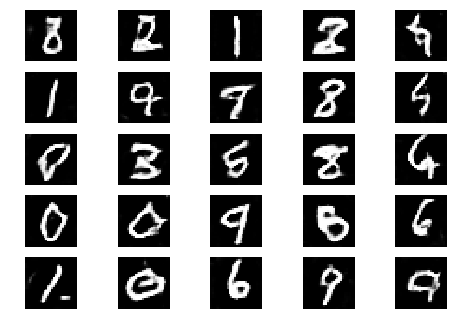

Epoch 4 Batch 251/1875 [D loss: 0.589728, acc.: 68.75%] [G loss: 1.063342]
Epoch 4 Batch 252/1875 [D loss: 0.657636, acc.: 68.75%] [G loss: 0.970313]
Epoch 4 Batch 253/1875 [D loss: 0.649462, acc.: 62.50%] [G loss: 1.037594]
Epoch 4 Batch 254/1875 [D loss: 0.697423, acc.: 53.12%] [G loss: 1.105777]
Epoch 4 Batch 255/1875 [D loss: 0.690170, acc.: 62.50%] [G loss: 0.808813]
Epoch 4 Batch 256/1875 [D loss: 0.842461, acc.: 43.75%] [G loss: 0.956711]
Epoch 4 Batch 257/1875 [D loss: 0.585794, acc.: 71.88%] [G loss: 0.871725]
Epoch 4 Batch 258/1875 [D loss: 0.716599, acc.: 59.38%] [G loss: 1.051961]
Epoch 4 Batch 259/1875 [D loss: 0.767235, acc.: 46.88%] [G loss: 0.841927]
Epoch 4 Batch 260/1875 [D loss: 0.678872, acc.: 59.38%] [G loss: 1.048422]
Epoch 4 Batch 261/1875 [D loss: 0.655077, acc.: 62.50%] [G loss: 1.002400]
Epoch 4 Batch 262/1875 [D loss: 0.808493, acc.: 46.88%] [G loss: 0.917416]
Epoch 4 Batch 263/1875 [D loss: 0.718347, acc.: 59.38%] [G loss: 0.830577]
Epoch 4 Batch 264/1875 [D

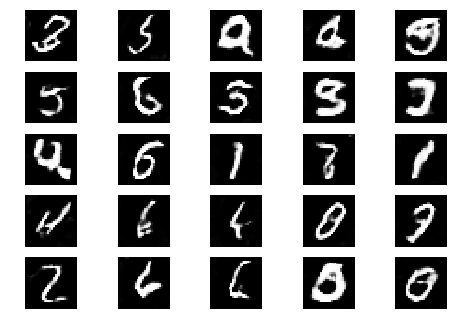

Epoch 4 Batch 301/1875 [D loss: 0.622159, acc.: 62.50%] [G loss: 0.995948]
Epoch 4 Batch 302/1875 [D loss: 0.629790, acc.: 71.88%] [G loss: 1.024434]
Epoch 4 Batch 303/1875 [D loss: 0.544806, acc.: 71.88%] [G loss: 0.936401]
Epoch 4 Batch 304/1875 [D loss: 0.633417, acc.: 65.62%] [G loss: 0.905870]
Epoch 4 Batch 305/1875 [D loss: 0.684471, acc.: 59.38%] [G loss: 0.748084]
Epoch 4 Batch 306/1875 [D loss: 0.593212, acc.: 65.62%] [G loss: 1.016432]
Epoch 4 Batch 307/1875 [D loss: 0.651169, acc.: 68.75%] [G loss: 0.814289]
Epoch 4 Batch 308/1875 [D loss: 0.513252, acc.: 71.88%] [G loss: 1.010622]
Epoch 4 Batch 309/1875 [D loss: 0.587241, acc.: 62.50%] [G loss: 0.900143]
Epoch 4 Batch 310/1875 [D loss: 0.599772, acc.: 65.62%] [G loss: 0.993960]
Epoch 4 Batch 311/1875 [D loss: 0.552720, acc.: 81.25%] [G loss: 0.974036]
Epoch 4 Batch 312/1875 [D loss: 0.626539, acc.: 68.75%] [G loss: 1.005322]
Epoch 4 Batch 313/1875 [D loss: 0.783510, acc.: 53.12%] [G loss: 0.976911]
Epoch 4 Batch 314/1875 [D

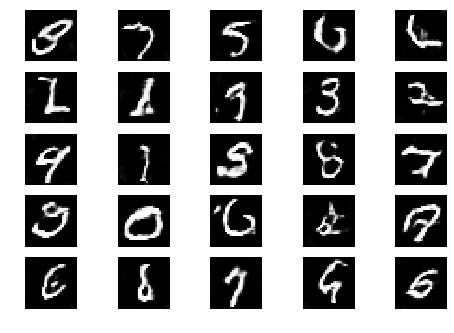

Epoch 4 Batch 351/1875 [D loss: 0.730100, acc.: 50.00%] [G loss: 0.996695]
Epoch 4 Batch 352/1875 [D loss: 0.487589, acc.: 78.12%] [G loss: 0.848863]
Epoch 4 Batch 353/1875 [D loss: 0.680312, acc.: 56.25%] [G loss: 0.851666]
Epoch 4 Batch 354/1875 [D loss: 0.695698, acc.: 65.62%] [G loss: 0.907534]
Epoch 4 Batch 355/1875 [D loss: 0.687306, acc.: 53.12%] [G loss: 0.945258]
Epoch 4 Batch 356/1875 [D loss: 0.858763, acc.: 37.50%] [G loss: 1.004906]
Epoch 4 Batch 357/1875 [D loss: 0.618697, acc.: 68.75%] [G loss: 0.754954]
Epoch 4 Batch 358/1875 [D loss: 0.618680, acc.: 68.75%] [G loss: 0.932530]
Epoch 4 Batch 359/1875 [D loss: 0.672722, acc.: 62.50%] [G loss: 0.980198]
Epoch 4 Batch 360/1875 [D loss: 0.711999, acc.: 65.62%] [G loss: 0.978124]
Epoch 4 Batch 361/1875 [D loss: 0.714524, acc.: 59.38%] [G loss: 0.841617]
Epoch 4 Batch 362/1875 [D loss: 0.649240, acc.: 56.25%] [G loss: 0.962011]
Epoch 4 Batch 363/1875 [D loss: 0.671370, acc.: 62.50%] [G loss: 0.998122]
Epoch 4 Batch 364/1875 [D

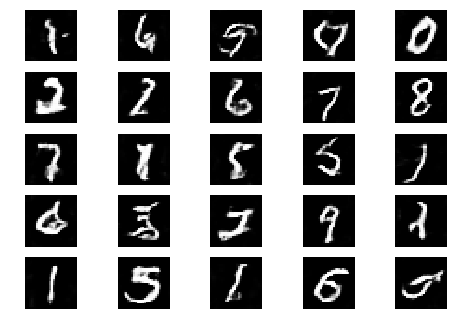

Epoch 4 Batch 401/1875 [D loss: 0.667174, acc.: 62.50%] [G loss: 0.924592]
Epoch 4 Batch 402/1875 [D loss: 0.755306, acc.: 46.88%] [G loss: 0.910482]
Epoch 4 Batch 403/1875 [D loss: 0.734897, acc.: 46.88%] [G loss: 1.097281]
Epoch 4 Batch 404/1875 [D loss: 0.607668, acc.: 68.75%] [G loss: 0.986874]
Epoch 4 Batch 405/1875 [D loss: 0.654026, acc.: 62.50%] [G loss: 0.935699]
Epoch 4 Batch 406/1875 [D loss: 0.603024, acc.: 71.88%] [G loss: 1.027487]
Epoch 4 Batch 407/1875 [D loss: 0.744736, acc.: 46.88%] [G loss: 0.877471]
Epoch 4 Batch 408/1875 [D loss: 0.496211, acc.: 87.50%] [G loss: 0.952357]
Epoch 4 Batch 409/1875 [D loss: 0.623568, acc.: 62.50%] [G loss: 0.950786]
Epoch 4 Batch 410/1875 [D loss: 0.722080, acc.: 53.12%] [G loss: 1.030786]
Epoch 4 Batch 411/1875 [D loss: 0.726255, acc.: 59.38%] [G loss: 0.848236]
Epoch 4 Batch 412/1875 [D loss: 0.595665, acc.: 65.62%] [G loss: 0.875202]
Epoch 4 Batch 413/1875 [D loss: 0.821730, acc.: 43.75%] [G loss: 0.804260]
Epoch 4 Batch 414/1875 [D

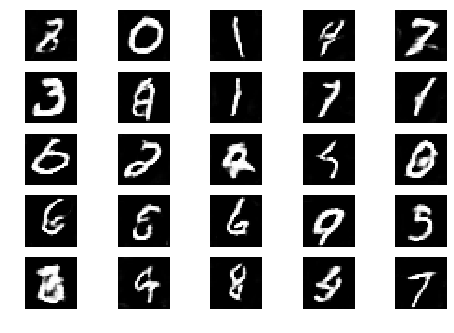

Epoch 4 Batch 451/1875 [D loss: 0.616418, acc.: 68.75%] [G loss: 0.740428]
Epoch 4 Batch 452/1875 [D loss: 0.677267, acc.: 56.25%] [G loss: 0.843753]
Epoch 4 Batch 453/1875 [D loss: 0.712263, acc.: 65.62%] [G loss: 0.692738]
Epoch 4 Batch 454/1875 [D loss: 0.665758, acc.: 59.38%] [G loss: 0.779710]
Epoch 4 Batch 455/1875 [D loss: 0.613365, acc.: 65.62%] [G loss: 0.963051]
Epoch 4 Batch 456/1875 [D loss: 0.682756, acc.: 62.50%] [G loss: 0.754438]
Epoch 4 Batch 457/1875 [D loss: 0.559766, acc.: 65.62%] [G loss: 0.758622]
Epoch 4 Batch 458/1875 [D loss: 0.715460, acc.: 50.00%] [G loss: 0.810377]
Epoch 4 Batch 459/1875 [D loss: 0.617499, acc.: 65.62%] [G loss: 0.833386]
Epoch 4 Batch 460/1875 [D loss: 0.676240, acc.: 56.25%] [G loss: 0.880494]
Epoch 4 Batch 461/1875 [D loss: 0.527428, acc.: 81.25%] [G loss: 0.959857]
Epoch 4 Batch 462/1875 [D loss: 0.704676, acc.: 59.38%] [G loss: 1.014680]
Epoch 4 Batch 463/1875 [D loss: 0.656021, acc.: 65.62%] [G loss: 0.852651]
Epoch 4 Batch 464/1875 [D

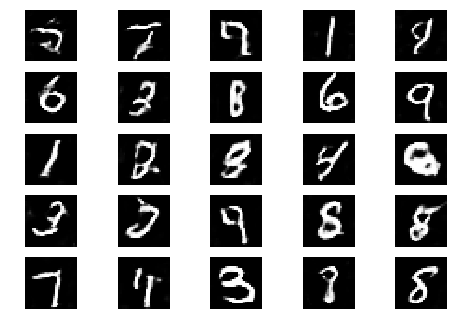

Epoch 4 Batch 501/1875 [D loss: 0.629879, acc.: 68.75%] [G loss: 0.892736]
Epoch 4 Batch 502/1875 [D loss: 0.722248, acc.: 46.88%] [G loss: 0.974009]
Epoch 4 Batch 503/1875 [D loss: 0.701635, acc.: 56.25%] [G loss: 1.000892]
Epoch 4 Batch 504/1875 [D loss: 0.567657, acc.: 71.88%] [G loss: 0.983486]
Epoch 4 Batch 505/1875 [D loss: 0.735012, acc.: 53.12%] [G loss: 0.815656]
Epoch 4 Batch 506/1875 [D loss: 0.778528, acc.: 46.88%] [G loss: 0.942811]
Epoch 4 Batch 507/1875 [D loss: 0.526594, acc.: 78.12%] [G loss: 1.154024]
Epoch 4 Batch 508/1875 [D loss: 0.641908, acc.: 62.50%] [G loss: 1.020386]
Epoch 4 Batch 509/1875 [D loss: 0.538483, acc.: 68.75%] [G loss: 1.192299]
Epoch 4 Batch 510/1875 [D loss: 0.605171, acc.: 68.75%] [G loss: 0.880614]
Epoch 4 Batch 511/1875 [D loss: 0.640062, acc.: 62.50%] [G loss: 0.946463]
Epoch 4 Batch 512/1875 [D loss: 0.676995, acc.: 56.25%] [G loss: 0.961131]
Epoch 4 Batch 513/1875 [D loss: 0.734981, acc.: 62.50%] [G loss: 1.150692]
Epoch 4 Batch 514/1875 [D

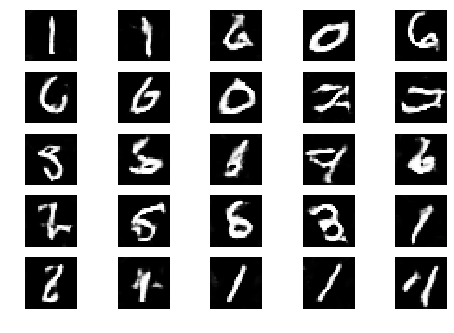

Epoch 4 Batch 551/1875 [D loss: 0.704842, acc.: 46.88%] [G loss: 0.830678]
Epoch 4 Batch 552/1875 [D loss: 0.717897, acc.: 59.38%] [G loss: 0.895619]
Epoch 4 Batch 553/1875 [D loss: 0.732907, acc.: 62.50%] [G loss: 0.804780]
Epoch 4 Batch 554/1875 [D loss: 0.617201, acc.: 62.50%] [G loss: 0.867875]
Epoch 4 Batch 555/1875 [D loss: 0.654560, acc.: 59.38%] [G loss: 0.921120]
Epoch 4 Batch 556/1875 [D loss: 0.596138, acc.: 68.75%] [G loss: 0.818758]
Epoch 4 Batch 557/1875 [D loss: 0.691119, acc.: 62.50%] [G loss: 0.712703]
Epoch 4 Batch 558/1875 [D loss: 0.667057, acc.: 62.50%] [G loss: 0.881551]
Epoch 4 Batch 559/1875 [D loss: 0.770823, acc.: 50.00%] [G loss: 1.045779]
Epoch 4 Batch 560/1875 [D loss: 0.832158, acc.: 43.75%] [G loss: 0.844554]
Epoch 4 Batch 561/1875 [D loss: 0.614785, acc.: 71.88%] [G loss: 1.060223]
Epoch 4 Batch 562/1875 [D loss: 0.718554, acc.: 56.25%] [G loss: 0.990068]
Epoch 4 Batch 563/1875 [D loss: 0.625672, acc.: 65.62%] [G loss: 0.809245]
Epoch 4 Batch 564/1875 [D

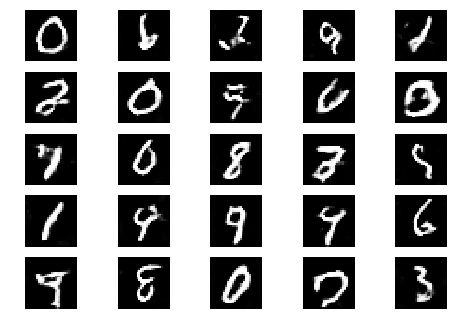

Epoch 4 Batch 601/1875 [D loss: 0.606451, acc.: 71.88%] [G loss: 0.819564]
Epoch 4 Batch 602/1875 [D loss: 0.761020, acc.: 43.75%] [G loss: 0.902959]
Epoch 4 Batch 603/1875 [D loss: 0.670498, acc.: 56.25%] [G loss: 1.009939]
Epoch 4 Batch 604/1875 [D loss: 0.689435, acc.: 56.25%] [G loss: 0.793422]
Epoch 4 Batch 605/1875 [D loss: 0.457063, acc.: 84.38%] [G loss: 0.941240]
Epoch 4 Batch 606/1875 [D loss: 0.827836, acc.: 43.75%] [G loss: 1.057547]
Epoch 4 Batch 607/1875 [D loss: 0.661320, acc.: 59.38%] [G loss: 1.087287]
Epoch 4 Batch 608/1875 [D loss: 0.702190, acc.: 59.38%] [G loss: 0.919945]
Epoch 4 Batch 609/1875 [D loss: 0.578457, acc.: 68.75%] [G loss: 0.787583]
Epoch 4 Batch 610/1875 [D loss: 0.893259, acc.: 37.50%] [G loss: 0.778726]
Epoch 4 Batch 611/1875 [D loss: 0.633759, acc.: 56.25%] [G loss: 0.911641]
Epoch 4 Batch 612/1875 [D loss: 0.620859, acc.: 56.25%] [G loss: 0.669331]
Epoch 4 Batch 613/1875 [D loss: 0.785983, acc.: 56.25%] [G loss: 0.706559]
Epoch 4 Batch 614/1875 [D

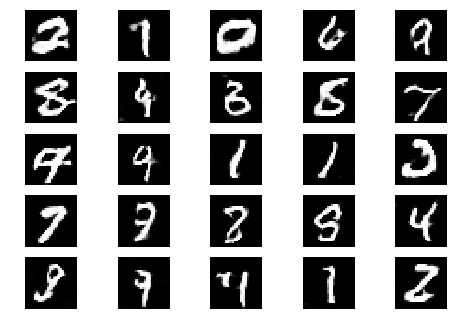

Epoch 4 Batch 651/1875 [D loss: 0.651227, acc.: 65.62%] [G loss: 0.999623]
Epoch 4 Batch 652/1875 [D loss: 0.753154, acc.: 40.62%] [G loss: 0.943053]
Epoch 4 Batch 653/1875 [D loss: 0.629576, acc.: 62.50%] [G loss: 0.736448]
Epoch 4 Batch 654/1875 [D loss: 0.700444, acc.: 46.88%] [G loss: 0.933292]
Epoch 4 Batch 655/1875 [D loss: 0.815347, acc.: 37.50%] [G loss: 1.048003]
Epoch 4 Batch 656/1875 [D loss: 0.664828, acc.: 56.25%] [G loss: 0.932048]
Epoch 4 Batch 657/1875 [D loss: 0.518352, acc.: 75.00%] [G loss: 0.960325]
Epoch 4 Batch 658/1875 [D loss: 0.560152, acc.: 65.62%] [G loss: 0.802523]
Epoch 4 Batch 659/1875 [D loss: 0.658535, acc.: 56.25%] [G loss: 0.897042]
Epoch 4 Batch 660/1875 [D loss: 0.712049, acc.: 53.12%] [G loss: 0.886519]
Epoch 4 Batch 661/1875 [D loss: 0.474601, acc.: 84.38%] [G loss: 0.993822]
Epoch 4 Batch 662/1875 [D loss: 0.613930, acc.: 71.88%] [G loss: 1.010576]
Epoch 4 Batch 663/1875 [D loss: 0.707235, acc.: 56.25%] [G loss: 0.808436]
Epoch 4 Batch 664/1875 [D

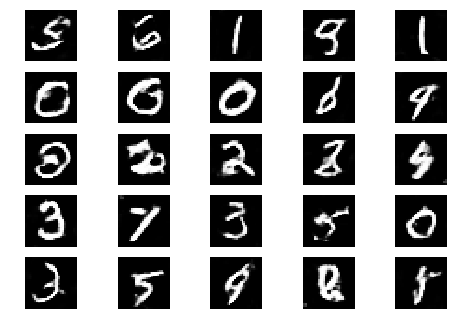

Epoch 4 Batch 701/1875 [D loss: 0.606435, acc.: 68.75%] [G loss: 1.019153]
Epoch 4 Batch 702/1875 [D loss: 0.632046, acc.: 59.38%] [G loss: 1.153881]
Epoch 4 Batch 703/1875 [D loss: 0.679910, acc.: 62.50%] [G loss: 1.116817]
Epoch 4 Batch 704/1875 [D loss: 0.775589, acc.: 56.25%] [G loss: 0.831723]
Epoch 4 Batch 705/1875 [D loss: 0.769623, acc.: 56.25%] [G loss: 0.867175]
Epoch 4 Batch 706/1875 [D loss: 0.601048, acc.: 65.62%] [G loss: 0.894518]
Epoch 4 Batch 707/1875 [D loss: 0.710872, acc.: 65.62%] [G loss: 0.886817]
Epoch 4 Batch 708/1875 [D loss: 0.583149, acc.: 68.75%] [G loss: 0.820764]
Epoch 4 Batch 709/1875 [D loss: 0.688268, acc.: 65.62%] [G loss: 0.904116]
Epoch 4 Batch 710/1875 [D loss: 0.507232, acc.: 78.12%] [G loss: 0.974099]
Epoch 4 Batch 711/1875 [D loss: 0.517898, acc.: 81.25%] [G loss: 0.986475]
Epoch 4 Batch 712/1875 [D loss: 0.709597, acc.: 62.50%] [G loss: 1.121542]
Epoch 4 Batch 713/1875 [D loss: 0.688099, acc.: 53.12%] [G loss: 1.041687]
Epoch 4 Batch 714/1875 [D

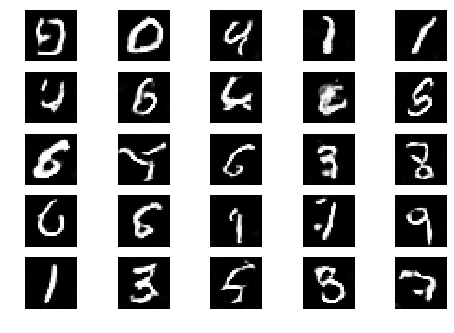

Epoch 4 Batch 751/1875 [D loss: 0.783451, acc.: 53.12%] [G loss: 0.780297]
Epoch 4 Batch 752/1875 [D loss: 0.662178, acc.: 56.25%] [G loss: 0.850214]
Epoch 4 Batch 753/1875 [D loss: 0.589917, acc.: 75.00%] [G loss: 0.885317]
Epoch 4 Batch 754/1875 [D loss: 0.710449, acc.: 53.12%] [G loss: 0.799607]
Epoch 4 Batch 755/1875 [D loss: 0.815854, acc.: 37.50%] [G loss: 1.075471]
Epoch 4 Batch 756/1875 [D loss: 0.653913, acc.: 62.50%] [G loss: 0.907684]
Epoch 4 Batch 757/1875 [D loss: 0.551780, acc.: 75.00%] [G loss: 1.012167]
Epoch 4 Batch 758/1875 [D loss: 0.730004, acc.: 53.12%] [G loss: 0.952472]
Epoch 4 Batch 759/1875 [D loss: 0.582090, acc.: 62.50%] [G loss: 1.065864]
Epoch 4 Batch 760/1875 [D loss: 0.693773, acc.: 56.25%] [G loss: 0.902162]
Epoch 4 Batch 761/1875 [D loss: 0.570512, acc.: 84.38%] [G loss: 0.977949]
Epoch 4 Batch 762/1875 [D loss: 0.717797, acc.: 62.50%] [G loss: 0.953705]
Epoch 4 Batch 763/1875 [D loss: 0.671003, acc.: 62.50%] [G loss: 0.877676]
Epoch 4 Batch 764/1875 [D

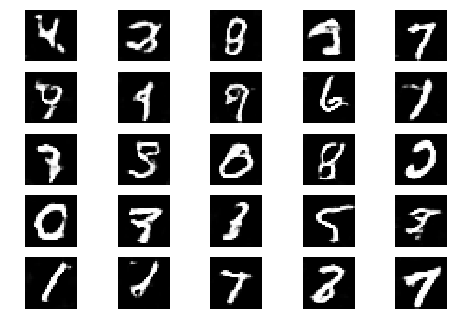

Epoch 4 Batch 801/1875 [D loss: 0.497311, acc.: 84.38%] [G loss: 1.038399]
Epoch 4 Batch 802/1875 [D loss: 0.744515, acc.: 46.88%] [G loss: 0.964543]
Epoch 4 Batch 803/1875 [D loss: 0.659712, acc.: 56.25%] [G loss: 1.046068]
Epoch 4 Batch 804/1875 [D loss: 0.629861, acc.: 71.88%] [G loss: 0.863480]
Epoch 4 Batch 805/1875 [D loss: 0.727757, acc.: 50.00%] [G loss: 1.022135]
Epoch 4 Batch 806/1875 [D loss: 0.639011, acc.: 71.88%] [G loss: 0.927032]
Epoch 4 Batch 807/1875 [D loss: 0.730540, acc.: 50.00%] [G loss: 1.008474]
Epoch 4 Batch 808/1875 [D loss: 0.612911, acc.: 68.75%] [G loss: 0.967232]
Epoch 4 Batch 809/1875 [D loss: 0.686731, acc.: 50.00%] [G loss: 0.964057]
Epoch 4 Batch 810/1875 [D loss: 0.564629, acc.: 71.88%] [G loss: 1.112657]
Epoch 4 Batch 811/1875 [D loss: 0.797402, acc.: 40.62%] [G loss: 0.964369]
Epoch 4 Batch 812/1875 [D loss: 0.543965, acc.: 71.88%] [G loss: 0.977440]
Epoch 4 Batch 813/1875 [D loss: 0.684230, acc.: 56.25%] [G loss: 0.916028]
Epoch 4 Batch 814/1875 [D

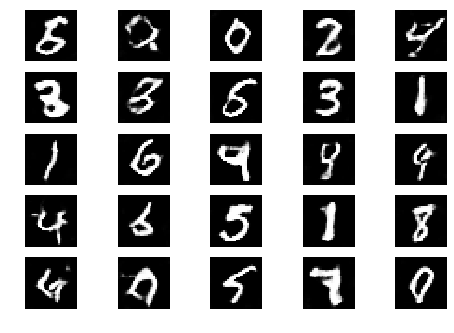

Epoch 4 Batch 851/1875 [D loss: 0.651486, acc.: 62.50%] [G loss: 0.593871]
Epoch 4 Batch 852/1875 [D loss: 0.619133, acc.: 65.62%] [G loss: 0.773805]
Epoch 4 Batch 853/1875 [D loss: 0.667160, acc.: 56.25%] [G loss: 0.793320]
Epoch 4 Batch 854/1875 [D loss: 0.717307, acc.: 56.25%] [G loss: 0.820215]
Epoch 4 Batch 855/1875 [D loss: 0.640494, acc.: 59.38%] [G loss: 0.888082]
Epoch 4 Batch 856/1875 [D loss: 0.785254, acc.: 43.75%] [G loss: 0.928586]
Epoch 4 Batch 857/1875 [D loss: 0.668287, acc.: 62.50%] [G loss: 0.803155]
Epoch 4 Batch 858/1875 [D loss: 0.558102, acc.: 71.88%] [G loss: 0.897663]
Epoch 4 Batch 859/1875 [D loss: 0.685586, acc.: 56.25%] [G loss: 0.888594]
Epoch 4 Batch 860/1875 [D loss: 0.835622, acc.: 43.75%] [G loss: 0.957173]
Epoch 4 Batch 861/1875 [D loss: 0.645092, acc.: 59.38%] [G loss: 0.729153]
Epoch 4 Batch 862/1875 [D loss: 0.644017, acc.: 56.25%] [G loss: 1.038076]
Epoch 4 Batch 863/1875 [D loss: 0.616692, acc.: 62.50%] [G loss: 0.930185]
Epoch 4 Batch 864/1875 [D

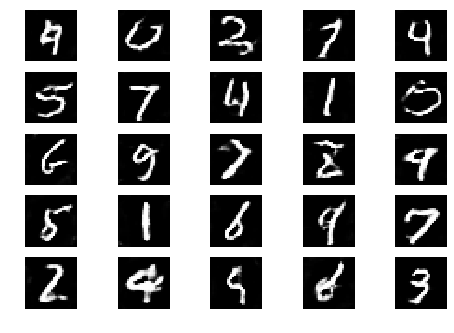

Epoch 4 Batch 901/1875 [D loss: 0.631977, acc.: 62.50%] [G loss: 0.695492]
Epoch 4 Batch 902/1875 [D loss: 0.700572, acc.: 50.00%] [G loss: 0.981216]
Epoch 4 Batch 903/1875 [D loss: 0.532748, acc.: 81.25%] [G loss: 0.915207]
Epoch 4 Batch 904/1875 [D loss: 0.635340, acc.: 62.50%] [G loss: 0.861515]
Epoch 4 Batch 905/1875 [D loss: 0.597465, acc.: 75.00%] [G loss: 0.868184]
Epoch 4 Batch 906/1875 [D loss: 0.616236, acc.: 75.00%] [G loss: 0.719132]
Epoch 4 Batch 907/1875 [D loss: 0.724859, acc.: 53.12%] [G loss: 0.834386]
Epoch 4 Batch 908/1875 [D loss: 0.537075, acc.: 81.25%] [G loss: 0.840773]
Epoch 4 Batch 909/1875 [D loss: 0.693314, acc.: 59.38%] [G loss: 0.936298]
Epoch 4 Batch 910/1875 [D loss: 0.567199, acc.: 71.88%] [G loss: 0.846031]
Epoch 4 Batch 911/1875 [D loss: 0.795610, acc.: 53.12%] [G loss: 1.005957]
Epoch 4 Batch 912/1875 [D loss: 0.781872, acc.: 37.50%] [G loss: 0.940775]
Epoch 4 Batch 913/1875 [D loss: 0.904032, acc.: 34.38%] [G loss: 0.919598]
Epoch 4 Batch 914/1875 [D

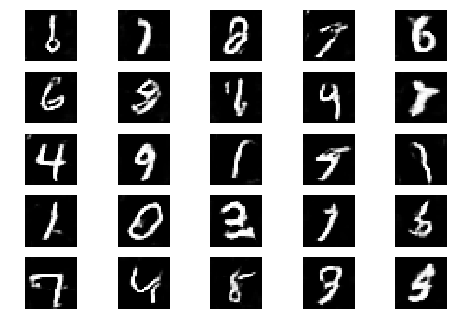

Epoch 4 Batch 951/1875 [D loss: 0.666089, acc.: 62.50%] [G loss: 1.081233]
Epoch 4 Batch 952/1875 [D loss: 0.668301, acc.: 53.12%] [G loss: 0.903174]
Epoch 4 Batch 953/1875 [D loss: 0.667597, acc.: 59.38%] [G loss: 0.947840]
Epoch 4 Batch 954/1875 [D loss: 0.534313, acc.: 75.00%] [G loss: 0.828465]
Epoch 4 Batch 955/1875 [D loss: 0.635164, acc.: 62.50%] [G loss: 0.968818]
Epoch 4 Batch 956/1875 [D loss: 0.616019, acc.: 65.62%] [G loss: 1.044103]
Epoch 4 Batch 957/1875 [D loss: 0.648369, acc.: 71.88%] [G loss: 0.917588]
Epoch 4 Batch 958/1875 [D loss: 0.648996, acc.: 65.62%] [G loss: 1.018946]
Epoch 4 Batch 959/1875 [D loss: 0.775401, acc.: 43.75%] [G loss: 0.988049]
Epoch 4 Batch 960/1875 [D loss: 0.747316, acc.: 53.12%] [G loss: 1.052351]
Epoch 4 Batch 961/1875 [D loss: 0.777460, acc.: 50.00%] [G loss: 0.894998]
Epoch 4 Batch 962/1875 [D loss: 0.467258, acc.: 81.25%] [G loss: 0.985248]
Epoch 4 Batch 963/1875 [D loss: 0.657653, acc.: 68.75%] [G loss: 0.931838]
Epoch 4 Batch 964/1875 [D

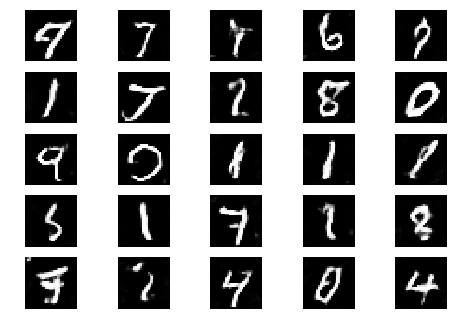

Epoch 4 Batch 1001/1875 [D loss: 0.667028, acc.: 56.25%] [G loss: 1.029262]
Epoch 4 Batch 1002/1875 [D loss: 0.638487, acc.: 62.50%] [G loss: 1.008308]
Epoch 4 Batch 1003/1875 [D loss: 0.640658, acc.: 65.62%] [G loss: 0.905815]
Epoch 4 Batch 1004/1875 [D loss: 0.664582, acc.: 62.50%] [G loss: 0.861000]
Epoch 4 Batch 1005/1875 [D loss: 0.775310, acc.: 59.38%] [G loss: 0.872661]
Epoch 4 Batch 1006/1875 [D loss: 0.645982, acc.: 68.75%] [G loss: 1.076349]
Epoch 4 Batch 1007/1875 [D loss: 0.636930, acc.: 53.12%] [G loss: 0.969952]
Epoch 4 Batch 1008/1875 [D loss: 0.662937, acc.: 65.62%] [G loss: 1.004917]
Epoch 4 Batch 1009/1875 [D loss: 0.617515, acc.: 68.75%] [G loss: 0.848992]
Epoch 4 Batch 1010/1875 [D loss: 0.750562, acc.: 50.00%] [G loss: 0.839248]
Epoch 4 Batch 1011/1875 [D loss: 0.696856, acc.: 56.25%] [G loss: 0.877428]
Epoch 4 Batch 1012/1875 [D loss: 0.608926, acc.: 65.62%] [G loss: 0.978442]
Epoch 4 Batch 1013/1875 [D loss: 0.771995, acc.: 50.00%] [G loss: 0.940849]
Epoch 4 Batc

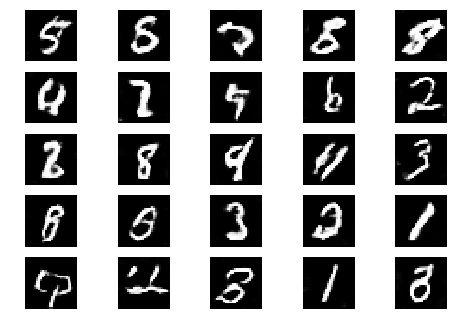

Epoch 4 Batch 1051/1875 [D loss: 0.713337, acc.: 53.12%] [G loss: 0.970737]
Epoch 4 Batch 1052/1875 [D loss: 0.549906, acc.: 71.88%] [G loss: 0.966641]
Epoch 4 Batch 1053/1875 [D loss: 0.744894, acc.: 53.12%] [G loss: 0.952035]
Epoch 4 Batch 1054/1875 [D loss: 0.638964, acc.: 75.00%] [G loss: 0.850523]
Epoch 4 Batch 1055/1875 [D loss: 0.661703, acc.: 62.50%] [G loss: 0.878532]
Epoch 4 Batch 1056/1875 [D loss: 0.612685, acc.: 62.50%] [G loss: 1.088244]
Epoch 4 Batch 1057/1875 [D loss: 0.511011, acc.: 81.25%] [G loss: 0.775034]
Epoch 4 Batch 1058/1875 [D loss: 0.727574, acc.: 59.38%] [G loss: 0.866711]
Epoch 4 Batch 1059/1875 [D loss: 0.668724, acc.: 56.25%] [G loss: 1.044522]
Epoch 4 Batch 1060/1875 [D loss: 0.845805, acc.: 37.50%] [G loss: 0.978732]
Epoch 4 Batch 1061/1875 [D loss: 0.585447, acc.: 78.12%] [G loss: 0.942954]
Epoch 4 Batch 1062/1875 [D loss: 0.707243, acc.: 59.38%] [G loss: 1.010826]
Epoch 4 Batch 1063/1875 [D loss: 0.693402, acc.: 62.50%] [G loss: 0.909203]
Epoch 4 Batc

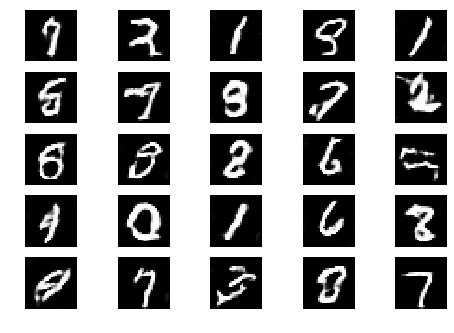

Epoch 4 Batch 1101/1875 [D loss: 0.603461, acc.: 65.62%] [G loss: 1.023534]
Epoch 4 Batch 1102/1875 [D loss: 0.651772, acc.: 65.62%] [G loss: 0.756096]
Epoch 4 Batch 1103/1875 [D loss: 0.694610, acc.: 59.38%] [G loss: 0.802831]
Epoch 4 Batch 1104/1875 [D loss: 0.680292, acc.: 62.50%] [G loss: 0.749670]
Epoch 4 Batch 1105/1875 [D loss: 0.610114, acc.: 65.62%] [G loss: 0.873831]
Epoch 4 Batch 1106/1875 [D loss: 0.613862, acc.: 62.50%] [G loss: 1.073213]
Epoch 4 Batch 1107/1875 [D loss: 0.581660, acc.: 71.88%] [G loss: 0.850425]
Epoch 4 Batch 1108/1875 [D loss: 0.579818, acc.: 78.12%] [G loss: 0.990654]
Epoch 4 Batch 1109/1875 [D loss: 0.787846, acc.: 56.25%] [G loss: 0.830051]
Epoch 4 Batch 1110/1875 [D loss: 0.700690, acc.: 56.25%] [G loss: 1.087201]
Epoch 4 Batch 1111/1875 [D loss: 0.618843, acc.: 62.50%] [G loss: 0.879525]
Epoch 4 Batch 1112/1875 [D loss: 0.649949, acc.: 65.62%] [G loss: 0.905475]
Epoch 4 Batch 1113/1875 [D loss: 0.720196, acc.: 46.88%] [G loss: 1.034532]
Epoch 4 Batc

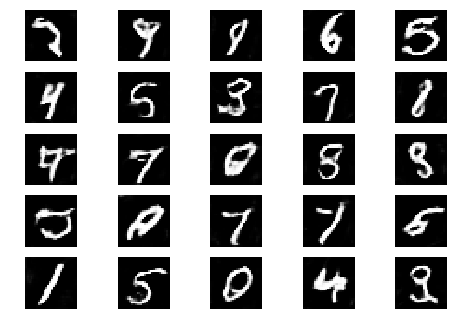

Epoch 4 Batch 1151/1875 [D loss: 0.747922, acc.: 40.62%] [G loss: 1.079144]
Epoch 4 Batch 1152/1875 [D loss: 0.585495, acc.: 71.88%] [G loss: 0.916322]
Epoch 4 Batch 1153/1875 [D loss: 0.623518, acc.: 68.75%] [G loss: 1.141687]
Epoch 4 Batch 1154/1875 [D loss: 0.667232, acc.: 50.00%] [G loss: 0.904999]
Epoch 4 Batch 1155/1875 [D loss: 0.418209, acc.: 90.62%] [G loss: 0.915011]
Epoch 4 Batch 1156/1875 [D loss: 0.598943, acc.: 65.62%] [G loss: 1.018603]
Epoch 4 Batch 1157/1875 [D loss: 0.629051, acc.: 65.62%] [G loss: 0.995196]
Epoch 4 Batch 1158/1875 [D loss: 0.595856, acc.: 78.12%] [G loss: 0.710765]
Epoch 4 Batch 1159/1875 [D loss: 0.680415, acc.: 56.25%] [G loss: 0.777028]
Epoch 4 Batch 1160/1875 [D loss: 0.754943, acc.: 62.50%] [G loss: 0.848231]
Epoch 4 Batch 1161/1875 [D loss: 0.631458, acc.: 75.00%] [G loss: 0.824202]
Epoch 4 Batch 1162/1875 [D loss: 0.641834, acc.: 75.00%] [G loss: 0.882386]
Epoch 4 Batch 1163/1875 [D loss: 0.794328, acc.: 53.12%] [G loss: 0.869258]
Epoch 4 Batc

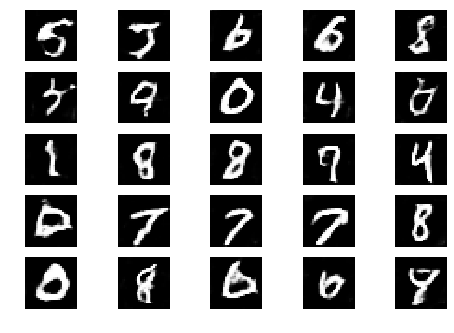

Epoch 4 Batch 1201/1875 [D loss: 0.723881, acc.: 50.00%] [G loss: 1.029969]
Epoch 4 Batch 1202/1875 [D loss: 0.628906, acc.: 56.25%] [G loss: 1.001893]
Epoch 4 Batch 1203/1875 [D loss: 0.713440, acc.: 50.00%] [G loss: 0.870036]
Epoch 4 Batch 1204/1875 [D loss: 0.822594, acc.: 43.75%] [G loss: 0.807270]
Epoch 4 Batch 1205/1875 [D loss: 0.537346, acc.: 78.12%] [G loss: 0.949481]
Epoch 4 Batch 1206/1875 [D loss: 0.641162, acc.: 62.50%] [G loss: 1.031673]
Epoch 4 Batch 1207/1875 [D loss: 0.640307, acc.: 62.50%] [G loss: 1.110302]
Epoch 4 Batch 1208/1875 [D loss: 0.685531, acc.: 46.88%] [G loss: 0.924229]
Epoch 4 Batch 1209/1875 [D loss: 0.796196, acc.: 40.62%] [G loss: 0.781163]
Epoch 4 Batch 1210/1875 [D loss: 0.622450, acc.: 68.75%] [G loss: 0.816343]
Epoch 4 Batch 1211/1875 [D loss: 0.659569, acc.: 65.62%] [G loss: 0.976207]
Epoch 4 Batch 1212/1875 [D loss: 0.573517, acc.: 71.88%] [G loss: 1.050475]
Epoch 4 Batch 1213/1875 [D loss: 0.618226, acc.: 62.50%] [G loss: 0.823101]
Epoch 4 Batc

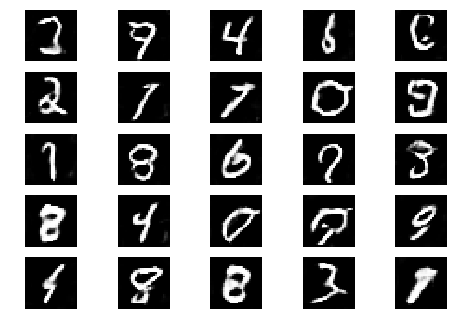

Epoch 4 Batch 1251/1875 [D loss: 0.743005, acc.: 43.75%] [G loss: 0.992378]
Epoch 4 Batch 1252/1875 [D loss: 0.582773, acc.: 62.50%] [G loss: 1.086124]
Epoch 4 Batch 1253/1875 [D loss: 0.592487, acc.: 68.75%] [G loss: 0.816518]
Epoch 4 Batch 1254/1875 [D loss: 0.681620, acc.: 59.38%] [G loss: 0.850141]
Epoch 4 Batch 1255/1875 [D loss: 0.564946, acc.: 68.75%] [G loss: 0.998161]
Epoch 4 Batch 1256/1875 [D loss: 0.826138, acc.: 56.25%] [G loss: 0.884988]
Epoch 4 Batch 1257/1875 [D loss: 0.752083, acc.: 46.88%] [G loss: 0.811096]
Epoch 4 Batch 1258/1875 [D loss: 0.703219, acc.: 59.38%] [G loss: 0.970590]
Epoch 4 Batch 1259/1875 [D loss: 0.735697, acc.: 43.75%] [G loss: 0.905034]
Epoch 4 Batch 1260/1875 [D loss: 0.690213, acc.: 62.50%] [G loss: 0.867779]
Epoch 4 Batch 1261/1875 [D loss: 0.522612, acc.: 81.25%] [G loss: 1.032470]
Epoch 4 Batch 1262/1875 [D loss: 0.745637, acc.: 46.88%] [G loss: 0.982788]
Epoch 4 Batch 1263/1875 [D loss: 0.543496, acc.: 75.00%] [G loss: 0.796301]
Epoch 4 Batc

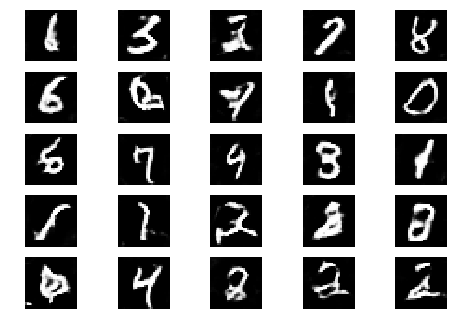

Epoch 4 Batch 1301/1875 [D loss: 0.542806, acc.: 75.00%] [G loss: 0.974621]
Epoch 4 Batch 1302/1875 [D loss: 0.812357, acc.: 50.00%] [G loss: 0.940103]
Epoch 4 Batch 1303/1875 [D loss: 0.671742, acc.: 65.62%] [G loss: 1.111530]
Epoch 4 Batch 1304/1875 [D loss: 0.768212, acc.: 50.00%] [G loss: 0.898151]
Epoch 4 Batch 1305/1875 [D loss: 0.686814, acc.: 62.50%] [G loss: 0.961170]
Epoch 4 Batch 1306/1875 [D loss: 0.712662, acc.: 46.88%] [G loss: 0.713859]
Epoch 4 Batch 1307/1875 [D loss: 0.775762, acc.: 50.00%] [G loss: 0.927526]
Epoch 4 Batch 1308/1875 [D loss: 0.619656, acc.: 68.75%] [G loss: 0.737238]
Epoch 4 Batch 1309/1875 [D loss: 0.709902, acc.: 46.88%] [G loss: 0.848793]
Epoch 4 Batch 1310/1875 [D loss: 0.600503, acc.: 65.62%] [G loss: 0.847980]
Epoch 4 Batch 1311/1875 [D loss: 0.647984, acc.: 62.50%] [G loss: 0.889129]
Epoch 4 Batch 1312/1875 [D loss: 0.586233, acc.: 75.00%] [G loss: 0.966259]
Epoch 4 Batch 1313/1875 [D loss: 0.631338, acc.: 59.38%] [G loss: 0.908850]
Epoch 4 Batc

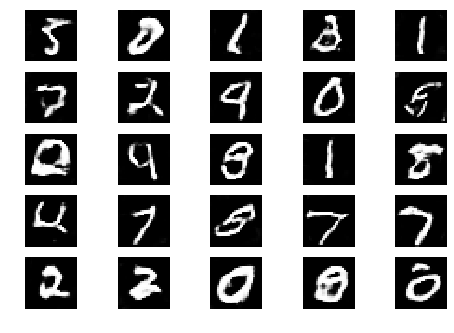

Epoch 4 Batch 1351/1875 [D loss: 0.622686, acc.: 59.38%] [G loss: 0.877166]
Epoch 4 Batch 1352/1875 [D loss: 0.668020, acc.: 59.38%] [G loss: 1.187075]
Epoch 4 Batch 1353/1875 [D loss: 0.673520, acc.: 65.62%] [G loss: 1.027535]
Epoch 4 Batch 1354/1875 [D loss: 0.719113, acc.: 59.38%] [G loss: 1.015057]
Epoch 4 Batch 1355/1875 [D loss: 0.672262, acc.: 59.38%] [G loss: 0.881249]
Epoch 4 Batch 1356/1875 [D loss: 0.557178, acc.: 71.88%] [G loss: 1.021472]
Epoch 4 Batch 1357/1875 [D loss: 0.586245, acc.: 65.62%] [G loss: 0.826415]
Epoch 4 Batch 1358/1875 [D loss: 0.708649, acc.: 56.25%] [G loss: 0.788262]
Epoch 4 Batch 1359/1875 [D loss: 0.634833, acc.: 65.62%] [G loss: 0.904111]
Epoch 4 Batch 1360/1875 [D loss: 0.774438, acc.: 40.62%] [G loss: 0.964449]
Epoch 4 Batch 1361/1875 [D loss: 0.644382, acc.: 65.62%] [G loss: 0.867026]
Epoch 4 Batch 1362/1875 [D loss: 0.622574, acc.: 65.62%] [G loss: 0.990051]
Epoch 4 Batch 1363/1875 [D loss: 0.646949, acc.: 68.75%] [G loss: 0.992455]
Epoch 4 Batc

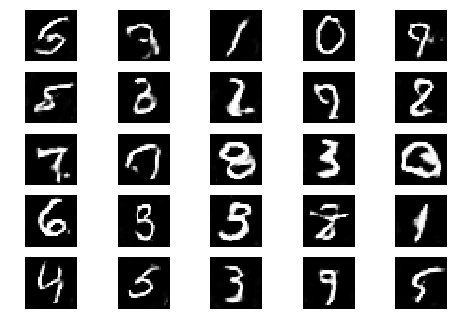

Epoch 4 Batch 1401/1875 [D loss: 0.625584, acc.: 62.50%] [G loss: 1.106560]
Epoch 4 Batch 1402/1875 [D loss: 0.710073, acc.: 56.25%] [G loss: 1.004728]
Epoch 4 Batch 1403/1875 [D loss: 0.658523, acc.: 65.62%] [G loss: 1.046475]
Epoch 4 Batch 1404/1875 [D loss: 0.560380, acc.: 78.12%] [G loss: 0.898313]
Epoch 4 Batch 1405/1875 [D loss: 0.692586, acc.: 56.25%] [G loss: 0.938827]
Epoch 4 Batch 1406/1875 [D loss: 0.671874, acc.: 62.50%] [G loss: 0.906328]
Epoch 4 Batch 1407/1875 [D loss: 0.791188, acc.: 37.50%] [G loss: 0.994381]
Epoch 4 Batch 1408/1875 [D loss: 0.637061, acc.: 65.62%] [G loss: 1.055751]
Epoch 4 Batch 1409/1875 [D loss: 0.520578, acc.: 84.38%] [G loss: 0.965492]
Epoch 4 Batch 1410/1875 [D loss: 0.623644, acc.: 71.88%] [G loss: 0.801056]
Epoch 4 Batch 1411/1875 [D loss: 0.727118, acc.: 53.12%] [G loss: 1.075716]
Epoch 4 Batch 1412/1875 [D loss: 0.650763, acc.: 53.12%] [G loss: 0.897785]
Epoch 4 Batch 1413/1875 [D loss: 0.717032, acc.: 59.38%] [G loss: 0.874930]
Epoch 4 Batc

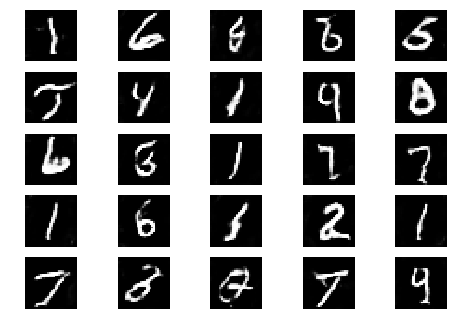

Epoch 4 Batch 1451/1875 [D loss: 0.622636, acc.: 68.75%] [G loss: 0.905433]
Epoch 4 Batch 1452/1875 [D loss: 0.604611, acc.: 68.75%] [G loss: 0.945229]
Epoch 4 Batch 1453/1875 [D loss: 0.690550, acc.: 56.25%] [G loss: 0.960590]
Epoch 4 Batch 1454/1875 [D loss: 0.584653, acc.: 68.75%] [G loss: 1.125731]
Epoch 4 Batch 1455/1875 [D loss: 0.589091, acc.: 75.00%] [G loss: 1.092834]
Epoch 4 Batch 1456/1875 [D loss: 0.503718, acc.: 87.50%] [G loss: 1.031801]
Epoch 4 Batch 1457/1875 [D loss: 0.665697, acc.: 59.38%] [G loss: 1.000266]
Epoch 4 Batch 1458/1875 [D loss: 0.737000, acc.: 50.00%] [G loss: 1.065201]
Epoch 4 Batch 1459/1875 [D loss: 0.691933, acc.: 53.12%] [G loss: 1.048734]
Epoch 4 Batch 1460/1875 [D loss: 0.581733, acc.: 65.62%] [G loss: 0.968873]
Epoch 4 Batch 1461/1875 [D loss: 0.681149, acc.: 59.38%] [G loss: 0.845976]
Epoch 4 Batch 1462/1875 [D loss: 0.825725, acc.: 46.88%] [G loss: 0.860857]
Epoch 4 Batch 1463/1875 [D loss: 0.565270, acc.: 75.00%] [G loss: 0.902867]
Epoch 4 Batc

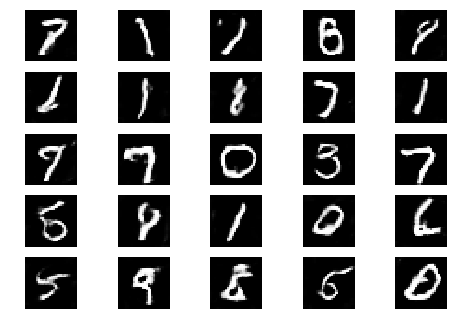

Epoch 4 Batch 1501/1875 [D loss: 0.631589, acc.: 53.12%] [G loss: 0.824946]
Epoch 4 Batch 1502/1875 [D loss: 0.765461, acc.: 53.12%] [G loss: 0.743464]
Epoch 4 Batch 1503/1875 [D loss: 0.682780, acc.: 59.38%] [G loss: 0.887966]
Epoch 4 Batch 1504/1875 [D loss: 0.719157, acc.: 53.12%] [G loss: 0.940186]
Epoch 4 Batch 1505/1875 [D loss: 0.573882, acc.: 68.75%] [G loss: 1.009726]
Epoch 4 Batch 1506/1875 [D loss: 0.753067, acc.: 43.75%] [G loss: 0.847681]
Epoch 4 Batch 1507/1875 [D loss: 0.671128, acc.: 50.00%] [G loss: 0.855765]
Epoch 4 Batch 1508/1875 [D loss: 0.733849, acc.: 43.75%] [G loss: 0.832420]
Epoch 4 Batch 1509/1875 [D loss: 0.669313, acc.: 56.25%] [G loss: 0.641419]
Epoch 4 Batch 1510/1875 [D loss: 0.561297, acc.: 71.88%] [G loss: 0.875137]
Epoch 4 Batch 1511/1875 [D loss: 0.584003, acc.: 71.88%] [G loss: 0.786969]
Epoch 4 Batch 1512/1875 [D loss: 0.761423, acc.: 53.12%] [G loss: 0.776402]
Epoch 4 Batch 1513/1875 [D loss: 0.708558, acc.: 53.12%] [G loss: 1.043411]
Epoch 4 Batc

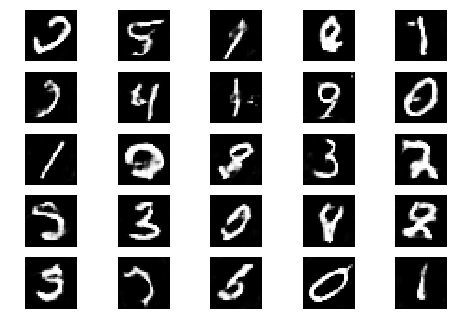

Epoch 4 Batch 1551/1875 [D loss: 0.659507, acc.: 62.50%] [G loss: 0.779086]
Epoch 4 Batch 1552/1875 [D loss: 0.577837, acc.: 75.00%] [G loss: 1.007162]
Epoch 4 Batch 1553/1875 [D loss: 0.688327, acc.: 56.25%] [G loss: 1.063322]
Epoch 4 Batch 1554/1875 [D loss: 0.563826, acc.: 75.00%] [G loss: 0.978857]
Epoch 4 Batch 1555/1875 [D loss: 0.625869, acc.: 65.62%] [G loss: 1.063893]
Epoch 4 Batch 1556/1875 [D loss: 0.647219, acc.: 56.25%] [G loss: 1.030162]
Epoch 4 Batch 1557/1875 [D loss: 0.593969, acc.: 65.62%] [G loss: 0.905530]
Epoch 4 Batch 1558/1875 [D loss: 0.647827, acc.: 68.75%] [G loss: 0.985428]
Epoch 4 Batch 1559/1875 [D loss: 0.728757, acc.: 46.88%] [G loss: 0.885577]
Epoch 4 Batch 1560/1875 [D loss: 0.606444, acc.: 68.75%] [G loss: 0.990875]
Epoch 4 Batch 1561/1875 [D loss: 0.586919, acc.: 68.75%] [G loss: 0.904283]
Epoch 4 Batch 1562/1875 [D loss: 0.604200, acc.: 65.62%] [G loss: 0.884039]
Epoch 4 Batch 1563/1875 [D loss: 0.634019, acc.: 68.75%] [G loss: 1.093167]
Epoch 4 Batc

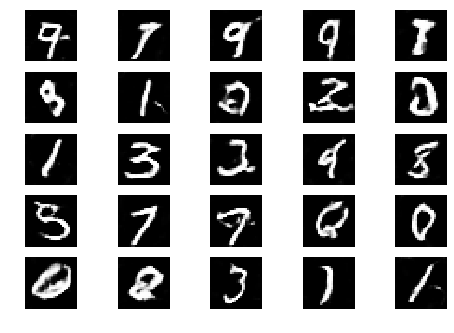

Epoch 4 Batch 1601/1875 [D loss: 0.590863, acc.: 75.00%] [G loss: 0.957425]
Epoch 4 Batch 1602/1875 [D loss: 0.720306, acc.: 50.00%] [G loss: 0.892414]
Epoch 4 Batch 1603/1875 [D loss: 0.538258, acc.: 75.00%] [G loss: 0.836269]
Epoch 4 Batch 1604/1875 [D loss: 0.618152, acc.: 71.88%] [G loss: 1.040258]
Epoch 4 Batch 1605/1875 [D loss: 0.576021, acc.: 71.88%] [G loss: 0.870451]
Epoch 4 Batch 1606/1875 [D loss: 0.692204, acc.: 53.12%] [G loss: 0.888345]
Epoch 4 Batch 1607/1875 [D loss: 0.704206, acc.: 56.25%] [G loss: 0.947456]
Epoch 4 Batch 1608/1875 [D loss: 0.751492, acc.: 46.88%] [G loss: 0.894941]
Epoch 4 Batch 1609/1875 [D loss: 0.556926, acc.: 71.88%] [G loss: 0.899078]
Epoch 4 Batch 1610/1875 [D loss: 0.650368, acc.: 62.50%] [G loss: 1.034824]
Epoch 4 Batch 1611/1875 [D loss: 0.732107, acc.: 53.12%] [G loss: 0.865305]
Epoch 4 Batch 1612/1875 [D loss: 0.623238, acc.: 75.00%] [G loss: 0.917182]
Epoch 4 Batch 1613/1875 [D loss: 0.568060, acc.: 59.38%] [G loss: 0.888289]
Epoch 4 Batc

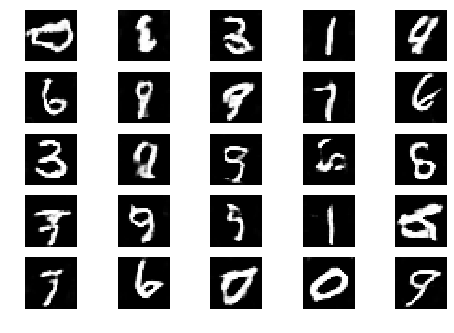

Epoch 4 Batch 1651/1875 [D loss: 0.667008, acc.: 56.25%] [G loss: 0.910255]
Epoch 4 Batch 1652/1875 [D loss: 0.784014, acc.: 46.88%] [G loss: 0.886788]
Epoch 4 Batch 1653/1875 [D loss: 0.655799, acc.: 59.38%] [G loss: 1.035586]
Epoch 4 Batch 1654/1875 [D loss: 0.686190, acc.: 56.25%] [G loss: 1.062796]
Epoch 4 Batch 1655/1875 [D loss: 0.720788, acc.: 56.25%] [G loss: 0.823526]
Epoch 4 Batch 1656/1875 [D loss: 0.736914, acc.: 59.38%] [G loss: 1.030535]
Epoch 4 Batch 1657/1875 [D loss: 0.647374, acc.: 62.50%] [G loss: 0.930606]
Epoch 4 Batch 1658/1875 [D loss: 0.612998, acc.: 65.62%] [G loss: 0.863640]
Epoch 4 Batch 1659/1875 [D loss: 0.686886, acc.: 65.62%] [G loss: 0.918313]
Epoch 4 Batch 1660/1875 [D loss: 0.742631, acc.: 46.88%] [G loss: 0.800086]
Epoch 4 Batch 1661/1875 [D loss: 0.621146, acc.: 68.75%] [G loss: 0.872198]
Epoch 4 Batch 1662/1875 [D loss: 0.660693, acc.: 62.50%] [G loss: 1.034444]
Epoch 4 Batch 1663/1875 [D loss: 0.646479, acc.: 59.38%] [G loss: 1.015869]
Epoch 4 Batc

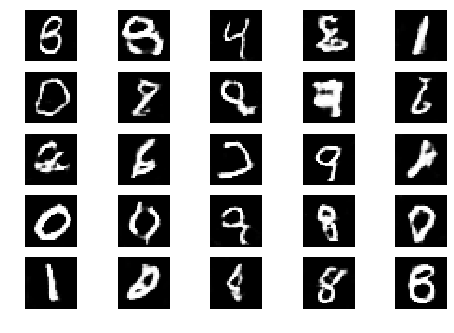

Epoch 4 Batch 1701/1875 [D loss: 0.717436, acc.: 56.25%] [G loss: 1.031965]
Epoch 4 Batch 1702/1875 [D loss: 0.733186, acc.: 65.62%] [G loss: 0.845142]
Epoch 4 Batch 1703/1875 [D loss: 0.580588, acc.: 75.00%] [G loss: 0.957413]
Epoch 4 Batch 1704/1875 [D loss: 0.745964, acc.: 50.00%] [G loss: 0.926789]
Epoch 4 Batch 1705/1875 [D loss: 0.722924, acc.: 56.25%] [G loss: 1.073600]
Epoch 4 Batch 1706/1875 [D loss: 0.730588, acc.: 56.25%] [G loss: 0.920943]
Epoch 4 Batch 1707/1875 [D loss: 0.694879, acc.: 43.75%] [G loss: 1.041142]
Epoch 4 Batch 1708/1875 [D loss: 0.724681, acc.: 59.38%] [G loss: 0.914769]
Epoch 4 Batch 1709/1875 [D loss: 0.687102, acc.: 65.62%] [G loss: 0.948761]
Epoch 4 Batch 1710/1875 [D loss: 0.793721, acc.: 50.00%] [G loss: 0.760617]
Epoch 4 Batch 1711/1875 [D loss: 0.739639, acc.: 62.50%] [G loss: 0.942696]
Epoch 4 Batch 1712/1875 [D loss: 0.641770, acc.: 68.75%] [G loss: 0.909381]
Epoch 4 Batch 1713/1875 [D loss: 0.615780, acc.: 59.38%] [G loss: 0.883396]
Epoch 4 Batc

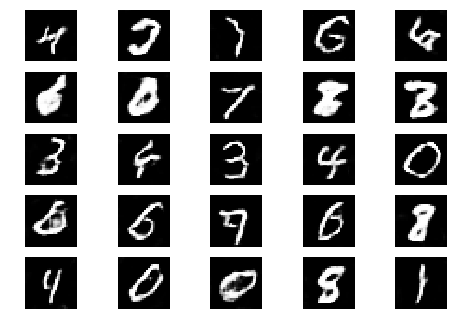

Epoch 4 Batch 1751/1875 [D loss: 0.771226, acc.: 46.88%] [G loss: 0.863256]
Epoch 4 Batch 1752/1875 [D loss: 0.679883, acc.: 59.38%] [G loss: 0.952608]
Epoch 4 Batch 1753/1875 [D loss: 0.587368, acc.: 71.88%] [G loss: 1.010489]
Epoch 4 Batch 1754/1875 [D loss: 0.678745, acc.: 56.25%] [G loss: 0.823162]
Epoch 4 Batch 1755/1875 [D loss: 0.703367, acc.: 59.38%] [G loss: 0.896305]
Epoch 4 Batch 1756/1875 [D loss: 0.607663, acc.: 62.50%] [G loss: 0.706366]
Epoch 4 Batch 1757/1875 [D loss: 0.675194, acc.: 59.38%] [G loss: 0.861810]
Epoch 4 Batch 1758/1875 [D loss: 0.522840, acc.: 75.00%] [G loss: 0.972462]
Epoch 4 Batch 1759/1875 [D loss: 0.635461, acc.: 62.50%] [G loss: 0.951681]
Epoch 4 Batch 1760/1875 [D loss: 0.605517, acc.: 68.75%] [G loss: 1.039102]
Epoch 4 Batch 1761/1875 [D loss: 0.790996, acc.: 50.00%] [G loss: 0.937770]
Epoch 4 Batch 1762/1875 [D loss: 0.743953, acc.: 53.12%] [G loss: 0.927791]
Epoch 4 Batch 1763/1875 [D loss: 0.740041, acc.: 43.75%] [G loss: 0.999321]
Epoch 4 Batc

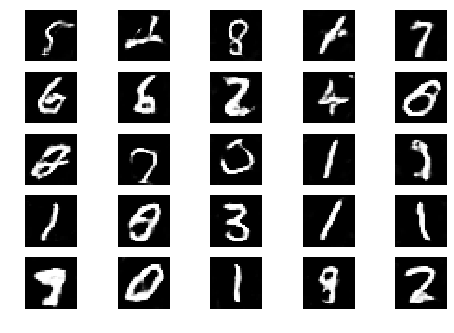

Epoch 4 Batch 1801/1875 [D loss: 0.726361, acc.: 53.12%] [G loss: 0.992321]
Epoch 4 Batch 1802/1875 [D loss: 0.696705, acc.: 62.50%] [G loss: 0.775225]
Epoch 4 Batch 1803/1875 [D loss: 0.728571, acc.: 53.12%] [G loss: 0.930106]
Epoch 4 Batch 1804/1875 [D loss: 0.533004, acc.: 75.00%] [G loss: 1.016212]
Epoch 4 Batch 1805/1875 [D loss: 0.608631, acc.: 78.12%] [G loss: 0.902653]
Epoch 4 Batch 1806/1875 [D loss: 0.753870, acc.: 37.50%] [G loss: 0.885189]
Epoch 4 Batch 1807/1875 [D loss: 0.658861, acc.: 65.62%] [G loss: 0.997275]
Epoch 4 Batch 1808/1875 [D loss: 0.633641, acc.: 65.62%] [G loss: 0.935707]
Epoch 4 Batch 1809/1875 [D loss: 0.745990, acc.: 53.12%] [G loss: 0.822967]
Epoch 4 Batch 1810/1875 [D loss: 0.635046, acc.: 68.75%] [G loss: 0.878754]
Epoch 4 Batch 1811/1875 [D loss: 0.622225, acc.: 71.88%] [G loss: 0.863492]
Epoch 4 Batch 1812/1875 [D loss: 0.699851, acc.: 65.62%] [G loss: 1.002202]
Epoch 4 Batch 1813/1875 [D loss: 0.752285, acc.: 65.62%] [G loss: 0.845734]
Epoch 4 Batc

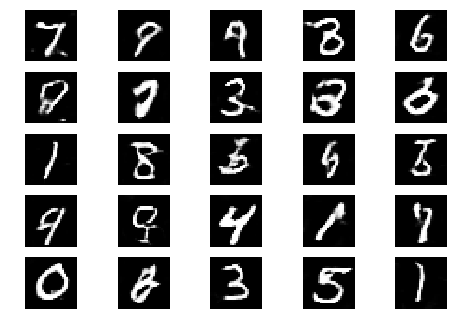

Epoch 4 Batch 1851/1875 [D loss: 0.653712, acc.: 65.62%] [G loss: 0.777315]
Epoch 4 Batch 1852/1875 [D loss: 0.567765, acc.: 65.62%] [G loss: 0.816852]
Epoch 4 Batch 1853/1875 [D loss: 0.551141, acc.: 78.12%] [G loss: 0.965371]
Epoch 4 Batch 1854/1875 [D loss: 0.717447, acc.: 53.12%] [G loss: 0.983126]
Epoch 4 Batch 1855/1875 [D loss: 0.691743, acc.: 50.00%] [G loss: 1.103660]
Epoch 4 Batch 1856/1875 [D loss: 0.671914, acc.: 53.12%] [G loss: 0.883311]
Epoch 4 Batch 1857/1875 [D loss: 0.721330, acc.: 53.12%] [G loss: 1.162709]
Epoch 4 Batch 1858/1875 [D loss: 0.848222, acc.: 37.50%] [G loss: 1.114291]
Epoch 4 Batch 1859/1875 [D loss: 0.617488, acc.: 65.62%] [G loss: 0.957922]
Epoch 4 Batch 1860/1875 [D loss: 0.899544, acc.: 37.50%] [G loss: 0.829621]
Epoch 4 Batch 1861/1875 [D loss: 0.695118, acc.: 71.88%] [G loss: 0.976891]
Epoch 4 Batch 1862/1875 [D loss: 0.554993, acc.: 75.00%] [G loss: 0.806387]
Epoch 4 Batch 1863/1875 [D loss: 0.567433, acc.: 71.88%] [G loss: 1.023032]
Epoch 4 Batc

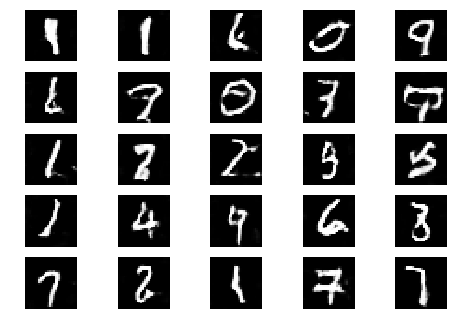

Epoch 5 Batch 1/1875 [D loss: 0.823934, acc.: 43.75%] [G loss: 0.852796]
Epoch 5 Batch 2/1875 [D loss: 0.718990, acc.: 56.25%] [G loss: 0.919672]
Epoch 5 Batch 3/1875 [D loss: 0.739611, acc.: 50.00%] [G loss: 0.990238]
Epoch 5 Batch 4/1875 [D loss: 0.654253, acc.: 62.50%] [G loss: 1.067533]
Epoch 5 Batch 5/1875 [D loss: 0.674675, acc.: 56.25%] [G loss: 0.955905]
Epoch 5 Batch 6/1875 [D loss: 0.564225, acc.: 71.88%] [G loss: 1.134527]
Epoch 5 Batch 7/1875 [D loss: 0.637265, acc.: 68.75%] [G loss: 1.067131]
Epoch 5 Batch 8/1875 [D loss: 0.712626, acc.: 53.12%] [G loss: 0.959829]
Epoch 5 Batch 9/1875 [D loss: 0.674029, acc.: 56.25%] [G loss: 1.120015]
Epoch 5 Batch 10/1875 [D loss: 0.590229, acc.: 71.88%] [G loss: 0.802723]
Epoch 5 Batch 11/1875 [D loss: 0.727426, acc.: 50.00%] [G loss: 0.835268]
Epoch 5 Batch 12/1875 [D loss: 0.741441, acc.: 53.12%] [G loss: 1.245923]
Epoch 5 Batch 13/1875 [D loss: 0.528975, acc.: 78.12%] [G loss: 1.038302]
Epoch 5 Batch 14/1875 [D loss: 0.531210, acc.: 

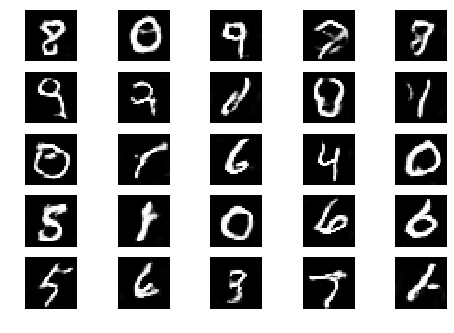

Epoch 5 Batch 51/1875 [D loss: 0.708226, acc.: 46.88%] [G loss: 0.971921]
Epoch 5 Batch 52/1875 [D loss: 0.625356, acc.: 62.50%] [G loss: 0.795442]
Epoch 5 Batch 53/1875 [D loss: 0.659352, acc.: 59.38%] [G loss: 0.785598]
Epoch 5 Batch 54/1875 [D loss: 0.603989, acc.: 75.00%] [G loss: 1.033195]
Epoch 5 Batch 55/1875 [D loss: 0.649993, acc.: 59.38%] [G loss: 1.189030]
Epoch 5 Batch 56/1875 [D loss: 0.709525, acc.: 53.12%] [G loss: 1.000961]
Epoch 5 Batch 57/1875 [D loss: 0.762622, acc.: 50.00%] [G loss: 0.986510]
Epoch 5 Batch 58/1875 [D loss: 0.598205, acc.: 65.62%] [G loss: 0.969703]
Epoch 5 Batch 59/1875 [D loss: 0.701772, acc.: 59.38%] [G loss: 0.881947]
Epoch 5 Batch 60/1875 [D loss: 0.667537, acc.: 62.50%] [G loss: 0.861987]
Epoch 5 Batch 61/1875 [D loss: 0.588603, acc.: 71.88%] [G loss: 0.803344]
Epoch 5 Batch 62/1875 [D loss: 0.629440, acc.: 75.00%] [G loss: 0.820040]
Epoch 5 Batch 63/1875 [D loss: 0.721117, acc.: 56.25%] [G loss: 0.925482]
Epoch 5 Batch 64/1875 [D loss: 0.72564

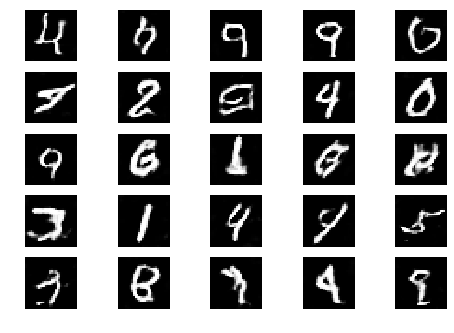

Epoch 5 Batch 101/1875 [D loss: 0.650704, acc.: 65.62%] [G loss: 0.844811]
Epoch 5 Batch 102/1875 [D loss: 0.762189, acc.: 50.00%] [G loss: 0.975040]
Epoch 5 Batch 103/1875 [D loss: 0.744708, acc.: 40.62%] [G loss: 0.913316]
Epoch 5 Batch 104/1875 [D loss: 0.728928, acc.: 59.38%] [G loss: 0.881154]
Epoch 5 Batch 105/1875 [D loss: 0.558780, acc.: 81.25%] [G loss: 0.833705]
Epoch 5 Batch 106/1875 [D loss: 0.637730, acc.: 59.38%] [G loss: 0.911239]
Epoch 5 Batch 107/1875 [D loss: 0.725901, acc.: 56.25%] [G loss: 0.747937]
Epoch 5 Batch 108/1875 [D loss: 0.650895, acc.: 62.50%] [G loss: 1.021734]
Epoch 5 Batch 109/1875 [D loss: 0.679186, acc.: 62.50%] [G loss: 1.010854]
Epoch 5 Batch 110/1875 [D loss: 0.851732, acc.: 34.38%] [G loss: 0.914297]
Epoch 5 Batch 111/1875 [D loss: 0.836483, acc.: 43.75%] [G loss: 0.977870]
Epoch 5 Batch 112/1875 [D loss: 0.638855, acc.: 68.75%] [G loss: 0.808421]
Epoch 5 Batch 113/1875 [D loss: 0.642794, acc.: 65.62%] [G loss: 0.979180]
Epoch 5 Batch 114/1875 [D

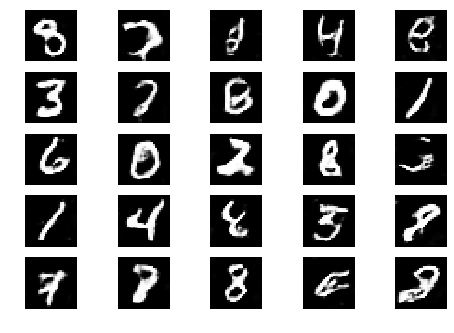

Epoch 5 Batch 151/1875 [D loss: 0.793605, acc.: 43.75%] [G loss: 0.812446]
Epoch 5 Batch 152/1875 [D loss: 0.786948, acc.: 53.12%] [G loss: 0.878484]
Epoch 5 Batch 153/1875 [D loss: 0.482722, acc.: 78.12%] [G loss: 0.977954]
Epoch 5 Batch 154/1875 [D loss: 0.679211, acc.: 59.38%] [G loss: 0.908248]
Epoch 5 Batch 155/1875 [D loss: 0.690117, acc.: 65.62%] [G loss: 1.048525]
Epoch 5 Batch 156/1875 [D loss: 0.566670, acc.: 81.25%] [G loss: 0.892277]
Epoch 5 Batch 157/1875 [D loss: 0.674088, acc.: 59.38%] [G loss: 0.983264]
Epoch 5 Batch 158/1875 [D loss: 0.743997, acc.: 50.00%] [G loss: 0.832836]
Epoch 5 Batch 159/1875 [D loss: 0.838808, acc.: 40.62%] [G loss: 0.743664]
Epoch 5 Batch 160/1875 [D loss: 0.668864, acc.: 53.12%] [G loss: 0.965975]
Epoch 5 Batch 161/1875 [D loss: 0.711941, acc.: 62.50%] [G loss: 1.096413]
Epoch 5 Batch 162/1875 [D loss: 0.794143, acc.: 46.88%] [G loss: 1.027156]
Epoch 5 Batch 163/1875 [D loss: 0.624878, acc.: 56.25%] [G loss: 0.984228]
Epoch 5 Batch 164/1875 [D

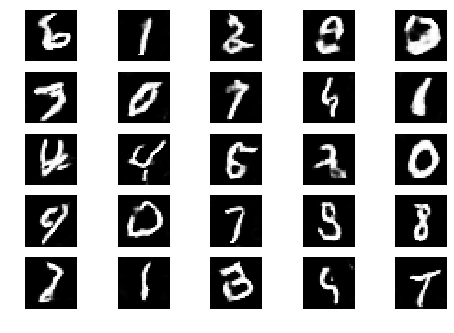

Epoch 5 Batch 201/1875 [D loss: 0.642069, acc.: 65.62%] [G loss: 0.942216]
Epoch 5 Batch 202/1875 [D loss: 0.709662, acc.: 53.12%] [G loss: 0.802149]
Epoch 5 Batch 203/1875 [D loss: 0.668432, acc.: 56.25%] [G loss: 0.885121]
Epoch 5 Batch 204/1875 [D loss: 0.640521, acc.: 68.75%] [G loss: 0.899375]
Epoch 5 Batch 205/1875 [D loss: 0.569815, acc.: 71.88%] [G loss: 0.843395]
Epoch 5 Batch 206/1875 [D loss: 0.589587, acc.: 65.62%] [G loss: 0.879367]
Epoch 5 Batch 207/1875 [D loss: 0.630187, acc.: 62.50%] [G loss: 0.900085]
Epoch 5 Batch 208/1875 [D loss: 0.632698, acc.: 65.62%] [G loss: 0.865221]
Epoch 5 Batch 209/1875 [D loss: 0.740168, acc.: 53.12%] [G loss: 0.870911]
Epoch 5 Batch 210/1875 [D loss: 0.562791, acc.: 71.88%] [G loss: 0.886156]
Epoch 5 Batch 211/1875 [D loss: 0.663465, acc.: 65.62%] [G loss: 0.947902]
Epoch 5 Batch 212/1875 [D loss: 0.632697, acc.: 62.50%] [G loss: 0.928686]
Epoch 5 Batch 213/1875 [D loss: 0.600799, acc.: 71.88%] [G loss: 0.972522]
Epoch 5 Batch 214/1875 [D

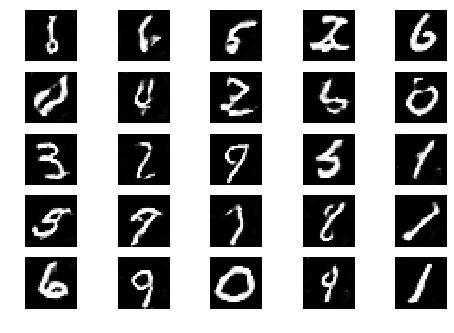

Epoch 5 Batch 251/1875 [D loss: 0.620237, acc.: 56.25%] [G loss: 0.868553]
Epoch 5 Batch 252/1875 [D loss: 0.617635, acc.: 65.62%] [G loss: 0.873743]
Epoch 5 Batch 253/1875 [D loss: 0.608840, acc.: 68.75%] [G loss: 0.983814]
Epoch 5 Batch 254/1875 [D loss: 0.560655, acc.: 68.75%] [G loss: 0.882812]
Epoch 5 Batch 255/1875 [D loss: 0.748127, acc.: 43.75%] [G loss: 0.977157]
Epoch 5 Batch 256/1875 [D loss: 0.625094, acc.: 71.88%] [G loss: 1.072223]
Epoch 5 Batch 257/1875 [D loss: 0.684025, acc.: 56.25%] [G loss: 1.089964]
Epoch 5 Batch 258/1875 [D loss: 0.627021, acc.: 68.75%] [G loss: 0.944384]
Epoch 5 Batch 259/1875 [D loss: 0.632013, acc.: 68.75%] [G loss: 1.058109]
Epoch 5 Batch 260/1875 [D loss: 0.628295, acc.: 62.50%] [G loss: 0.799697]
Epoch 5 Batch 261/1875 [D loss: 0.586473, acc.: 65.62%] [G loss: 0.926545]
Epoch 5 Batch 262/1875 [D loss: 0.641569, acc.: 65.62%] [G loss: 1.040616]
Epoch 5 Batch 263/1875 [D loss: 0.730670, acc.: 50.00%] [G loss: 1.037455]
Epoch 5 Batch 264/1875 [D

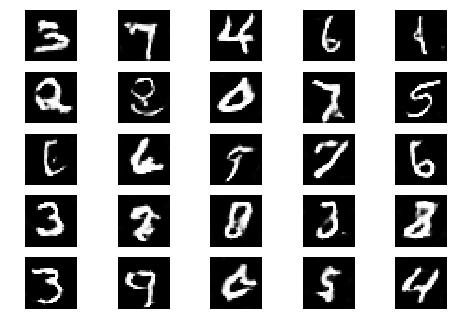

Epoch 5 Batch 301/1875 [D loss: 0.744705, acc.: 50.00%] [G loss: 0.922292]
Epoch 5 Batch 302/1875 [D loss: 0.668054, acc.: 62.50%] [G loss: 0.922239]
Epoch 5 Batch 303/1875 [D loss: 0.548080, acc.: 75.00%] [G loss: 0.882000]
Epoch 5 Batch 304/1875 [D loss: 0.613357, acc.: 68.75%] [G loss: 0.976322]
Epoch 5 Batch 305/1875 [D loss: 0.692804, acc.: 53.12%] [G loss: 0.754209]
Epoch 5 Batch 306/1875 [D loss: 0.673552, acc.: 65.62%] [G loss: 0.853467]
Epoch 5 Batch 307/1875 [D loss: 0.610872, acc.: 68.75%] [G loss: 0.824310]
Epoch 5 Batch 308/1875 [D loss: 0.771495, acc.: 50.00%] [G loss: 0.909113]
Epoch 5 Batch 309/1875 [D loss: 0.562867, acc.: 71.88%] [G loss: 0.963707]
Epoch 5 Batch 310/1875 [D loss: 0.698967, acc.: 50.00%] [G loss: 0.940618]
Epoch 5 Batch 311/1875 [D loss: 0.640703, acc.: 59.38%] [G loss: 0.966694]
Epoch 5 Batch 312/1875 [D loss: 0.757320, acc.: 53.12%] [G loss: 0.848626]
Epoch 5 Batch 313/1875 [D loss: 0.616728, acc.: 62.50%] [G loss: 0.707310]
Epoch 5 Batch 314/1875 [D

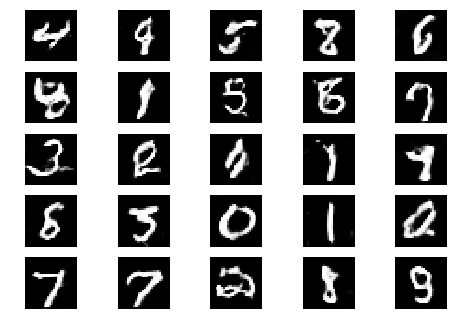

Epoch 5 Batch 351/1875 [D loss: 0.657085, acc.: 59.38%] [G loss: 0.908237]
Epoch 5 Batch 352/1875 [D loss: 0.546358, acc.: 81.25%] [G loss: 1.031514]
Epoch 5 Batch 353/1875 [D loss: 0.608835, acc.: 65.62%] [G loss: 0.877243]
Epoch 5 Batch 354/1875 [D loss: 0.651250, acc.: 56.25%] [G loss: 0.902314]
Epoch 5 Batch 355/1875 [D loss: 0.593334, acc.: 75.00%] [G loss: 0.868560]
Epoch 5 Batch 356/1875 [D loss: 0.713278, acc.: 46.88%] [G loss: 0.967902]
Epoch 5 Batch 357/1875 [D loss: 0.604258, acc.: 68.75%] [G loss: 0.975723]
Epoch 5 Batch 358/1875 [D loss: 0.742722, acc.: 46.88%] [G loss: 0.914111]
Epoch 5 Batch 359/1875 [D loss: 0.595676, acc.: 62.50%] [G loss: 0.829567]
Epoch 5 Batch 360/1875 [D loss: 0.636180, acc.: 71.88%] [G loss: 0.849659]
Epoch 5 Batch 361/1875 [D loss: 0.631065, acc.: 59.38%] [G loss: 1.082289]
Epoch 5 Batch 362/1875 [D loss: 0.662659, acc.: 56.25%] [G loss: 0.874789]
Epoch 5 Batch 363/1875 [D loss: 0.761820, acc.: 43.75%] [G loss: 0.825918]
Epoch 5 Batch 364/1875 [D

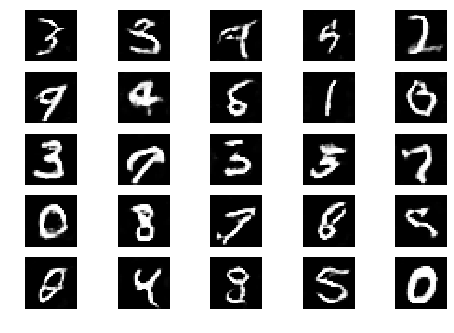

Epoch 5 Batch 401/1875 [D loss: 0.697985, acc.: 50.00%] [G loss: 0.921498]
Epoch 5 Batch 402/1875 [D loss: 0.652649, acc.: 65.62%] [G loss: 0.822998]
Epoch 5 Batch 403/1875 [D loss: 0.656493, acc.: 59.38%] [G loss: 0.967178]
Epoch 5 Batch 404/1875 [D loss: 0.846524, acc.: 37.50%] [G loss: 1.131106]
Epoch 5 Batch 405/1875 [D loss: 0.658327, acc.: 53.12%] [G loss: 1.097800]
Epoch 5 Batch 406/1875 [D loss: 0.636816, acc.: 59.38%] [G loss: 1.019273]
Epoch 5 Batch 407/1875 [D loss: 0.683058, acc.: 59.38%] [G loss: 0.887995]
Epoch 5 Batch 408/1875 [D loss: 0.647067, acc.: 56.25%] [G loss: 0.891515]
Epoch 5 Batch 409/1875 [D loss: 0.694545, acc.: 65.62%] [G loss: 0.856208]
Epoch 5 Batch 410/1875 [D loss: 0.684822, acc.: 56.25%] [G loss: 0.918108]
Epoch 5 Batch 411/1875 [D loss: 0.695326, acc.: 56.25%] [G loss: 0.993175]
Epoch 5 Batch 412/1875 [D loss: 0.748082, acc.: 59.38%] [G loss: 0.952682]
Epoch 5 Batch 413/1875 [D loss: 0.754202, acc.: 53.12%] [G loss: 0.927834]
Epoch 5 Batch 414/1875 [D

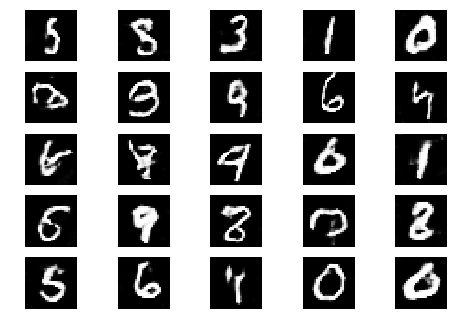

Epoch 5 Batch 451/1875 [D loss: 0.721310, acc.: 62.50%] [G loss: 1.163151]
Epoch 5 Batch 452/1875 [D loss: 0.691732, acc.: 59.38%] [G loss: 0.930434]
Epoch 5 Batch 453/1875 [D loss: 0.585632, acc.: 71.88%] [G loss: 0.990985]
Epoch 5 Batch 454/1875 [D loss: 0.664480, acc.: 65.62%] [G loss: 0.985629]
Epoch 5 Batch 455/1875 [D loss: 0.771852, acc.: 43.75%] [G loss: 0.796518]
Epoch 5 Batch 456/1875 [D loss: 0.625453, acc.: 59.38%] [G loss: 0.989851]
Epoch 5 Batch 457/1875 [D loss: 0.554065, acc.: 75.00%] [G loss: 0.851653]
Epoch 5 Batch 458/1875 [D loss: 0.650571, acc.: 62.50%] [G loss: 0.836907]
Epoch 5 Batch 459/1875 [D loss: 0.609720, acc.: 59.38%] [G loss: 0.990406]
Epoch 5 Batch 460/1875 [D loss: 0.822610, acc.: 43.75%] [G loss: 0.935585]
Epoch 5 Batch 461/1875 [D loss: 0.804507, acc.: 46.88%] [G loss: 0.938595]
Epoch 5 Batch 462/1875 [D loss: 0.679265, acc.: 59.38%] [G loss: 1.083690]
Epoch 5 Batch 463/1875 [D loss: 0.895367, acc.: 31.25%] [G loss: 0.937290]
Epoch 5 Batch 464/1875 [D

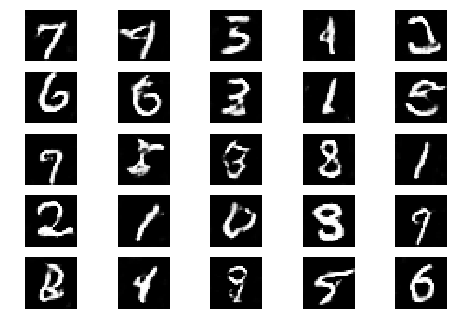

Epoch 5 Batch 501/1875 [D loss: 0.634138, acc.: 68.75%] [G loss: 0.993478]
Epoch 5 Batch 502/1875 [D loss: 0.765636, acc.: 40.62%] [G loss: 0.914450]
Epoch 5 Batch 503/1875 [D loss: 0.539707, acc.: 78.12%] [G loss: 0.845529]
Epoch 5 Batch 504/1875 [D loss: 0.702409, acc.: 56.25%] [G loss: 1.048817]
Epoch 5 Batch 505/1875 [D loss: 0.728401, acc.: 50.00%] [G loss: 1.018124]
Epoch 5 Batch 506/1875 [D loss: 0.679114, acc.: 62.50%] [G loss: 0.999522]
Epoch 5 Batch 507/1875 [D loss: 0.720128, acc.: 53.12%] [G loss: 0.820273]
Epoch 5 Batch 508/1875 [D loss: 0.674462, acc.: 46.88%] [G loss: 0.966385]
Epoch 5 Batch 509/1875 [D loss: 0.652442, acc.: 65.62%] [G loss: 0.825422]
Epoch 5 Batch 510/1875 [D loss: 0.561961, acc.: 81.25%] [G loss: 0.993097]
Epoch 5 Batch 511/1875 [D loss: 0.653188, acc.: 71.88%] [G loss: 0.900773]
Epoch 5 Batch 512/1875 [D loss: 0.648330, acc.: 71.88%] [G loss: 0.870341]
Epoch 5 Batch 513/1875 [D loss: 0.635946, acc.: 56.25%] [G loss: 0.846732]
Epoch 5 Batch 514/1875 [D

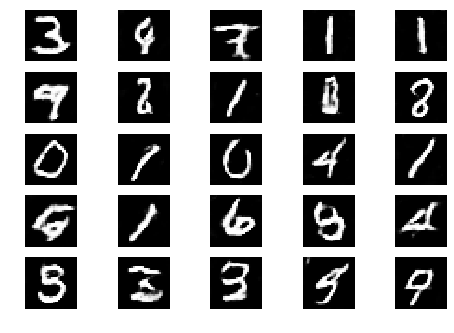

Epoch 5 Batch 551/1875 [D loss: 0.526052, acc.: 75.00%] [G loss: 0.872843]
Epoch 5 Batch 552/1875 [D loss: 0.744790, acc.: 46.88%] [G loss: 0.843038]
Epoch 5 Batch 553/1875 [D loss: 0.686904, acc.: 65.62%] [G loss: 0.862891]
Epoch 5 Batch 554/1875 [D loss: 0.735614, acc.: 50.00%] [G loss: 0.983547]
Epoch 5 Batch 555/1875 [D loss: 0.700830, acc.: 56.25%] [G loss: 0.866363]
Epoch 5 Batch 556/1875 [D loss: 0.656911, acc.: 62.50%] [G loss: 0.814452]
Epoch 5 Batch 557/1875 [D loss: 0.716669, acc.: 43.75%] [G loss: 0.728846]
Epoch 5 Batch 558/1875 [D loss: 0.575187, acc.: 71.88%] [G loss: 0.920852]
Epoch 5 Batch 559/1875 [D loss: 0.692618, acc.: 53.12%] [G loss: 0.974695]
Epoch 5 Batch 560/1875 [D loss: 0.651388, acc.: 65.62%] [G loss: 0.897546]
Epoch 5 Batch 561/1875 [D loss: 0.686978, acc.: 56.25%] [G loss: 0.814410]
Epoch 5 Batch 562/1875 [D loss: 0.716736, acc.: 59.38%] [G loss: 0.836135]
Epoch 5 Batch 563/1875 [D loss: 0.514870, acc.: 71.88%] [G loss: 0.876534]
Epoch 5 Batch 564/1875 [D

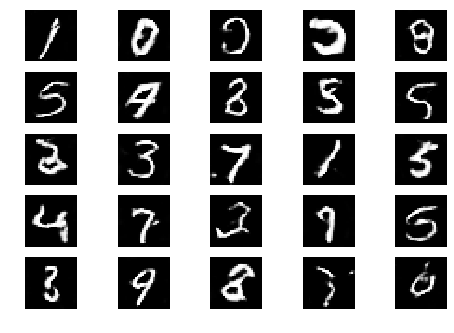

Epoch 5 Batch 601/1875 [D loss: 0.695010, acc.: 50.00%] [G loss: 0.971864]
Epoch 5 Batch 602/1875 [D loss: 0.710641, acc.: 53.12%] [G loss: 0.946862]
Epoch 5 Batch 603/1875 [D loss: 0.712757, acc.: 59.38%] [G loss: 0.973449]
Epoch 5 Batch 604/1875 [D loss: 0.687517, acc.: 71.88%] [G loss: 0.878878]
Epoch 5 Batch 605/1875 [D loss: 0.692871, acc.: 59.38%] [G loss: 0.944527]
Epoch 5 Batch 606/1875 [D loss: 0.666046, acc.: 59.38%] [G loss: 0.865104]
Epoch 5 Batch 607/1875 [D loss: 0.658548, acc.: 53.12%] [G loss: 0.765982]
Epoch 5 Batch 608/1875 [D loss: 0.768194, acc.: 50.00%] [G loss: 0.830555]
Epoch 5 Batch 609/1875 [D loss: 0.580450, acc.: 68.75%] [G loss: 1.026412]
Epoch 5 Batch 610/1875 [D loss: 0.682433, acc.: 65.62%] [G loss: 0.943744]
Epoch 5 Batch 611/1875 [D loss: 0.700040, acc.: 53.12%] [G loss: 0.867785]
Epoch 5 Batch 612/1875 [D loss: 0.640808, acc.: 62.50%] [G loss: 0.948323]
Epoch 5 Batch 613/1875 [D loss: 0.686021, acc.: 59.38%] [G loss: 0.993753]
Epoch 5 Batch 614/1875 [D

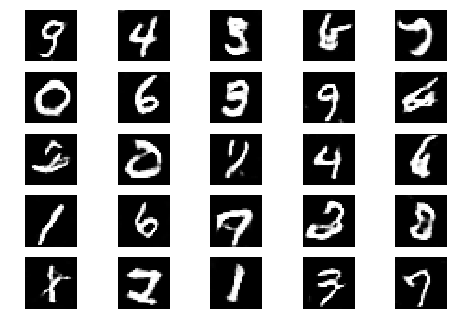

Epoch 5 Batch 651/1875 [D loss: 0.734893, acc.: 53.12%] [G loss: 0.872266]
Epoch 5 Batch 652/1875 [D loss: 0.702938, acc.: 56.25%] [G loss: 1.162366]
Epoch 5 Batch 653/1875 [D loss: 0.678340, acc.: 65.62%] [G loss: 0.838692]
Epoch 5 Batch 654/1875 [D loss: 0.668095, acc.: 53.12%] [G loss: 1.071698]
Epoch 5 Batch 655/1875 [D loss: 0.600999, acc.: 56.25%] [G loss: 1.148510]
Epoch 5 Batch 656/1875 [D loss: 0.680224, acc.: 62.50%] [G loss: 0.990684]
Epoch 5 Batch 657/1875 [D loss: 0.593369, acc.: 71.88%] [G loss: 0.917404]
Epoch 5 Batch 658/1875 [D loss: 0.544972, acc.: 75.00%] [G loss: 1.036068]
Epoch 5 Batch 659/1875 [D loss: 0.738187, acc.: 53.12%] [G loss: 0.931907]
Epoch 5 Batch 660/1875 [D loss: 0.864878, acc.: 37.50%] [G loss: 0.889777]
Epoch 5 Batch 661/1875 [D loss: 0.637863, acc.: 62.50%] [G loss: 1.014390]
Epoch 5 Batch 662/1875 [D loss: 0.740527, acc.: 53.12%] [G loss: 0.824216]
Epoch 5 Batch 663/1875 [D loss: 0.619465, acc.: 59.38%] [G loss: 1.015161]
Epoch 5 Batch 664/1875 [D

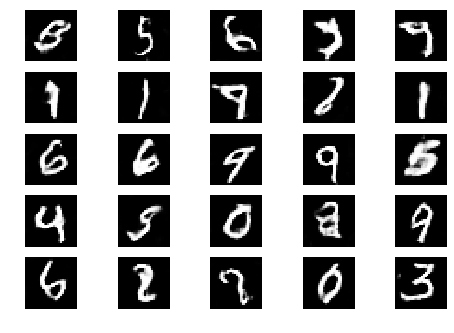

Epoch 5 Batch 701/1875 [D loss: 0.729328, acc.: 50.00%] [G loss: 0.890181]
Epoch 5 Batch 702/1875 [D loss: 0.640943, acc.: 75.00%] [G loss: 0.963644]
Epoch 5 Batch 703/1875 [D loss: 0.652911, acc.: 59.38%] [G loss: 0.941235]
Epoch 5 Batch 704/1875 [D loss: 0.735227, acc.: 46.88%] [G loss: 1.106260]
Epoch 5 Batch 705/1875 [D loss: 0.662713, acc.: 62.50%] [G loss: 1.098044]
Epoch 5 Batch 706/1875 [D loss: 0.767525, acc.: 53.12%] [G loss: 0.878361]
Epoch 5 Batch 707/1875 [D loss: 0.667024, acc.: 59.38%] [G loss: 1.071398]
Epoch 5 Batch 708/1875 [D loss: 0.672990, acc.: 62.50%] [G loss: 0.989348]
Epoch 5 Batch 709/1875 [D loss: 0.624640, acc.: 68.75%] [G loss: 0.884372]
Epoch 5 Batch 710/1875 [D loss: 0.694050, acc.: 59.38%] [G loss: 0.913119]
Epoch 5 Batch 711/1875 [D loss: 0.733865, acc.: 40.62%] [G loss: 0.910799]
Epoch 5 Batch 712/1875 [D loss: 0.560201, acc.: 78.12%] [G loss: 0.793593]
Epoch 5 Batch 713/1875 [D loss: 0.730855, acc.: 56.25%] [G loss: 0.993348]
Epoch 5 Batch 714/1875 [D

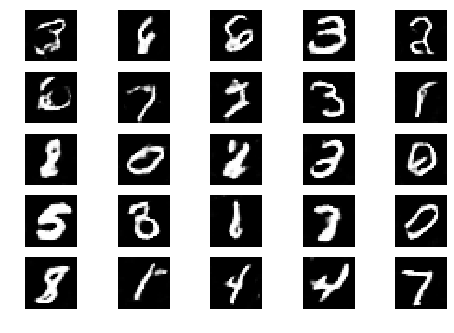

Epoch 5 Batch 751/1875 [D loss: 0.551701, acc.: 71.88%] [G loss: 1.011920]
Epoch 5 Batch 752/1875 [D loss: 0.564864, acc.: 71.88%] [G loss: 1.145738]
Epoch 5 Batch 753/1875 [D loss: 0.656235, acc.: 65.62%] [G loss: 0.965116]
Epoch 5 Batch 754/1875 [D loss: 0.774555, acc.: 46.88%] [G loss: 0.845401]
Epoch 5 Batch 755/1875 [D loss: 0.672564, acc.: 56.25%] [G loss: 0.789242]
Epoch 5 Batch 756/1875 [D loss: 0.631639, acc.: 62.50%] [G loss: 0.785909]
Epoch 5 Batch 757/1875 [D loss: 0.599403, acc.: 68.75%] [G loss: 0.911493]
Epoch 5 Batch 758/1875 [D loss: 0.663194, acc.: 53.12%] [G loss: 1.022400]
Epoch 5 Batch 759/1875 [D loss: 0.627362, acc.: 71.88%] [G loss: 1.081533]
Epoch 5 Batch 760/1875 [D loss: 0.796904, acc.: 40.62%] [G loss: 0.967345]
Epoch 5 Batch 761/1875 [D loss: 0.677543, acc.: 53.12%] [G loss: 1.008689]
Epoch 5 Batch 762/1875 [D loss: 0.626291, acc.: 68.75%] [G loss: 0.871142]
Epoch 5 Batch 763/1875 [D loss: 0.647215, acc.: 59.38%] [G loss: 0.944426]
Epoch 5 Batch 764/1875 [D

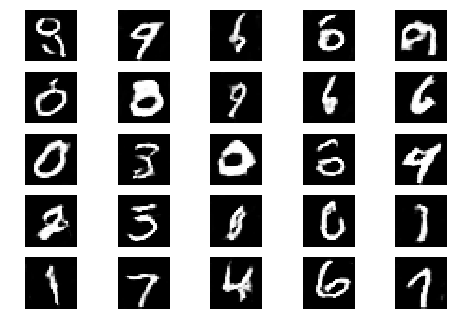

Epoch 5 Batch 801/1875 [D loss: 0.598091, acc.: 62.50%] [G loss: 1.108010]
Epoch 5 Batch 802/1875 [D loss: 0.618874, acc.: 68.75%] [G loss: 1.007917]
Epoch 5 Batch 803/1875 [D loss: 0.718278, acc.: 53.12%] [G loss: 0.921588]
Epoch 5 Batch 804/1875 [D loss: 0.760115, acc.: 50.00%] [G loss: 0.884588]
Epoch 5 Batch 805/1875 [D loss: 0.837512, acc.: 37.50%] [G loss: 0.805807]
Epoch 5 Batch 806/1875 [D loss: 0.596974, acc.: 68.75%] [G loss: 0.864002]
Epoch 5 Batch 807/1875 [D loss: 0.634091, acc.: 56.25%] [G loss: 1.045528]
Epoch 5 Batch 808/1875 [D loss: 0.622892, acc.: 62.50%] [G loss: 1.006642]
Epoch 5 Batch 809/1875 [D loss: 0.648497, acc.: 62.50%] [G loss: 1.141489]
Epoch 5 Batch 810/1875 [D loss: 0.544555, acc.: 78.12%] [G loss: 0.998575]
Epoch 5 Batch 811/1875 [D loss: 0.492531, acc.: 81.25%] [G loss: 1.045246]
Epoch 5 Batch 812/1875 [D loss: 0.655565, acc.: 65.62%] [G loss: 0.991106]
Epoch 5 Batch 813/1875 [D loss: 0.565780, acc.: 75.00%] [G loss: 0.799165]
Epoch 5 Batch 814/1875 [D

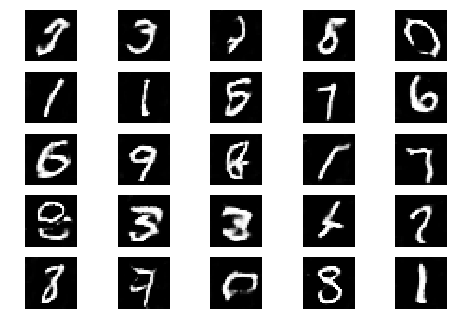

Epoch 5 Batch 851/1875 [D loss: 0.594486, acc.: 71.88%] [G loss: 1.091018]
Epoch 5 Batch 852/1875 [D loss: 0.867862, acc.: 37.50%] [G loss: 0.835544]
Epoch 5 Batch 853/1875 [D loss: 0.574270, acc.: 75.00%] [G loss: 0.881763]
Epoch 5 Batch 854/1875 [D loss: 0.669987, acc.: 65.62%] [G loss: 0.908723]
Epoch 5 Batch 855/1875 [D loss: 0.502211, acc.: 75.00%] [G loss: 0.920688]
Epoch 5 Batch 856/1875 [D loss: 0.704319, acc.: 59.38%] [G loss: 1.220755]
Epoch 5 Batch 857/1875 [D loss: 0.676078, acc.: 56.25%] [G loss: 0.919377]
Epoch 5 Batch 858/1875 [D loss: 0.497034, acc.: 87.50%] [G loss: 0.838786]
Epoch 5 Batch 859/1875 [D loss: 0.695506, acc.: 56.25%] [G loss: 0.924007]
Epoch 5 Batch 860/1875 [D loss: 0.602410, acc.: 65.62%] [G loss: 0.900691]
Epoch 5 Batch 861/1875 [D loss: 0.735318, acc.: 46.88%] [G loss: 0.852915]
Epoch 5 Batch 862/1875 [D loss: 0.738472, acc.: 50.00%] [G loss: 0.862264]
Epoch 5 Batch 863/1875 [D loss: 0.627670, acc.: 62.50%] [G loss: 0.839051]
Epoch 5 Batch 864/1875 [D

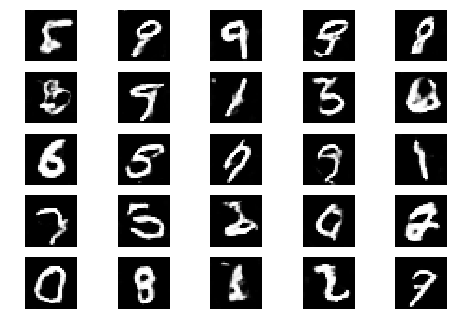

Epoch 5 Batch 901/1875 [D loss: 0.606866, acc.: 62.50%] [G loss: 0.887666]
Epoch 5 Batch 902/1875 [D loss: 0.653529, acc.: 62.50%] [G loss: 0.905266]
Epoch 5 Batch 903/1875 [D loss: 0.716915, acc.: 43.75%] [G loss: 0.894337]
Epoch 5 Batch 904/1875 [D loss: 0.666811, acc.: 71.88%] [G loss: 0.931510]
Epoch 5 Batch 905/1875 [D loss: 0.665280, acc.: 53.12%] [G loss: 0.956308]
Epoch 5 Batch 906/1875 [D loss: 0.695131, acc.: 40.62%] [G loss: 0.940411]
Epoch 5 Batch 907/1875 [D loss: 0.562272, acc.: 75.00%] [G loss: 1.049340]
Epoch 5 Batch 908/1875 [D loss: 0.634848, acc.: 75.00%] [G loss: 1.019744]
Epoch 5 Batch 909/1875 [D loss: 0.610228, acc.: 68.75%] [G loss: 1.038428]
Epoch 5 Batch 910/1875 [D loss: 0.670853, acc.: 65.62%] [G loss: 0.862752]
Epoch 5 Batch 911/1875 [D loss: 0.590292, acc.: 81.25%] [G loss: 0.885217]
Epoch 5 Batch 912/1875 [D loss: 0.650549, acc.: 59.38%] [G loss: 0.915981]
Epoch 5 Batch 913/1875 [D loss: 0.609676, acc.: 62.50%] [G loss: 0.951283]
Epoch 5 Batch 914/1875 [D

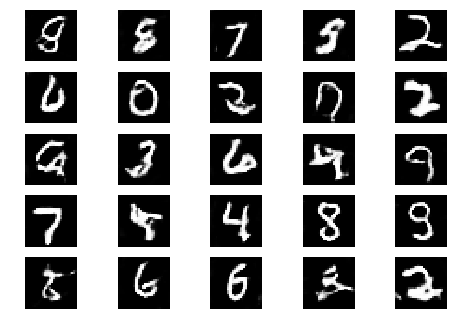

Epoch 5 Batch 951/1875 [D loss: 0.747038, acc.: 53.12%] [G loss: 0.799476]
Epoch 5 Batch 952/1875 [D loss: 0.669867, acc.: 71.88%] [G loss: 0.865511]
Epoch 5 Batch 953/1875 [D loss: 0.669695, acc.: 59.38%] [G loss: 1.163722]
Epoch 5 Batch 954/1875 [D loss: 0.605705, acc.: 65.62%] [G loss: 0.903329]
Epoch 5 Batch 955/1875 [D loss: 0.687020, acc.: 59.38%] [G loss: 0.831817]
Epoch 5 Batch 956/1875 [D loss: 0.724785, acc.: 53.12%] [G loss: 1.001217]
Epoch 5 Batch 957/1875 [D loss: 0.646481, acc.: 75.00%] [G loss: 0.843546]
Epoch 5 Batch 958/1875 [D loss: 0.724421, acc.: 50.00%] [G loss: 0.941009]
Epoch 5 Batch 959/1875 [D loss: 0.581949, acc.: 75.00%] [G loss: 0.878508]
Epoch 5 Batch 960/1875 [D loss: 0.740631, acc.: 53.12%] [G loss: 0.860615]
Epoch 5 Batch 961/1875 [D loss: 0.723563, acc.: 53.12%] [G loss: 0.788211]
Epoch 5 Batch 962/1875 [D loss: 0.661293, acc.: 62.50%] [G loss: 0.885024]
Epoch 5 Batch 963/1875 [D loss: 0.692389, acc.: 50.00%] [G loss: 0.958881]
Epoch 5 Batch 964/1875 [D

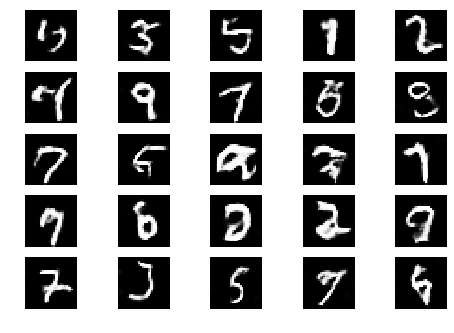

Epoch 5 Batch 1001/1875 [D loss: 0.734469, acc.: 56.25%] [G loss: 0.942478]
Epoch 5 Batch 1002/1875 [D loss: 0.671484, acc.: 59.38%] [G loss: 0.791249]
Epoch 5 Batch 1003/1875 [D loss: 0.630664, acc.: 68.75%] [G loss: 0.916022]
Epoch 5 Batch 1004/1875 [D loss: 0.616520, acc.: 71.88%] [G loss: 0.874902]
Epoch 5 Batch 1005/1875 [D loss: 0.691703, acc.: 59.38%] [G loss: 1.054458]
Epoch 5 Batch 1006/1875 [D loss: 0.682109, acc.: 59.38%] [G loss: 0.964715]
Epoch 5 Batch 1007/1875 [D loss: 0.664390, acc.: 59.38%] [G loss: 0.919447]
Epoch 5 Batch 1008/1875 [D loss: 0.706017, acc.: 56.25%] [G loss: 0.846264]
Epoch 5 Batch 1009/1875 [D loss: 0.690361, acc.: 53.12%] [G loss: 1.034581]
Epoch 5 Batch 1010/1875 [D loss: 0.758104, acc.: 50.00%] [G loss: 0.902204]
Epoch 5 Batch 1011/1875 [D loss: 0.518771, acc.: 81.25%] [G loss: 0.995452]
Epoch 5 Batch 1012/1875 [D loss: 0.685093, acc.: 50.00%] [G loss: 0.918370]
Epoch 5 Batch 1013/1875 [D loss: 0.625961, acc.: 56.25%] [G loss: 0.912085]
Epoch 5 Batc

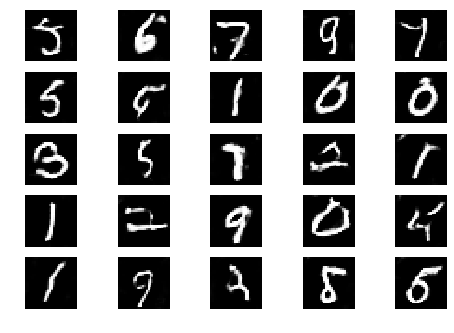

Epoch 5 Batch 1051/1875 [D loss: 0.783664, acc.: 50.00%] [G loss: 0.901823]
Epoch 5 Batch 1052/1875 [D loss: 0.578546, acc.: 68.75%] [G loss: 0.922652]
Epoch 5 Batch 1053/1875 [D loss: 0.819569, acc.: 50.00%] [G loss: 0.725762]
Epoch 5 Batch 1054/1875 [D loss: 0.784793, acc.: 43.75%] [G loss: 0.760340]
Epoch 5 Batch 1055/1875 [D loss: 0.466400, acc.: 84.38%] [G loss: 0.800143]
Epoch 5 Batch 1056/1875 [D loss: 0.640681, acc.: 59.38%] [G loss: 0.964384]
Epoch 5 Batch 1057/1875 [D loss: 0.681194, acc.: 71.88%] [G loss: 0.738235]
Epoch 5 Batch 1058/1875 [D loss: 0.696498, acc.: 53.12%] [G loss: 0.883605]
Epoch 5 Batch 1059/1875 [D loss: 0.779137, acc.: 46.88%] [G loss: 0.862147]
Epoch 5 Batch 1060/1875 [D loss: 0.790607, acc.: 37.50%] [G loss: 0.947182]
Epoch 5 Batch 1061/1875 [D loss: 0.579622, acc.: 65.62%] [G loss: 0.743896]
Epoch 5 Batch 1062/1875 [D loss: 0.775789, acc.: 34.38%] [G loss: 0.969862]
Epoch 5 Batch 1063/1875 [D loss: 0.734531, acc.: 53.12%] [G loss: 0.967163]
Epoch 5 Batc

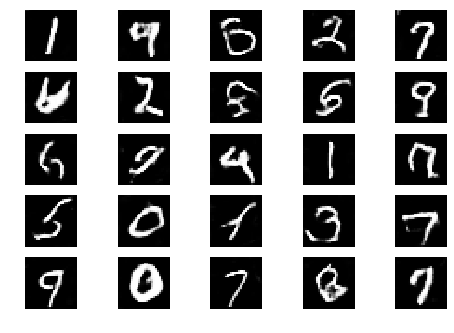

Epoch 5 Batch 1101/1875 [D loss: 0.674830, acc.: 65.62%] [G loss: 0.689123]
Epoch 5 Batch 1102/1875 [D loss: 0.707581, acc.: 68.75%] [G loss: 0.831395]
Epoch 5 Batch 1103/1875 [D loss: 0.603739, acc.: 65.62%] [G loss: 0.872702]
Epoch 5 Batch 1104/1875 [D loss: 0.776863, acc.: 53.12%] [G loss: 0.939430]
Epoch 5 Batch 1105/1875 [D loss: 0.572602, acc.: 78.12%] [G loss: 1.005117]
Epoch 5 Batch 1106/1875 [D loss: 0.735913, acc.: 53.12%] [G loss: 1.002088]
Epoch 5 Batch 1107/1875 [D loss: 0.638276, acc.: 59.38%] [G loss: 0.838815]
Epoch 5 Batch 1108/1875 [D loss: 0.636697, acc.: 62.50%] [G loss: 0.976684]
Epoch 5 Batch 1109/1875 [D loss: 0.650839, acc.: 59.38%] [G loss: 0.874084]
Epoch 5 Batch 1110/1875 [D loss: 0.580611, acc.: 68.75%] [G loss: 0.912321]
Epoch 5 Batch 1111/1875 [D loss: 0.777039, acc.: 43.75%] [G loss: 0.816355]
Epoch 5 Batch 1112/1875 [D loss: 0.608668, acc.: 68.75%] [G loss: 0.907550]
Epoch 5 Batch 1113/1875 [D loss: 0.609654, acc.: 65.62%] [G loss: 0.881771]
Epoch 5 Batc

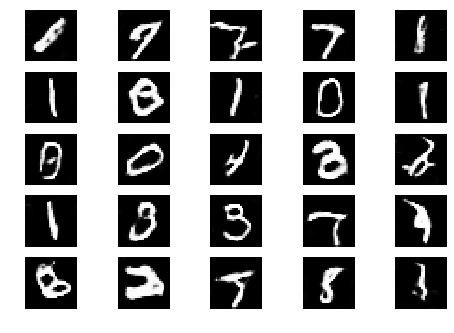

Epoch 5 Batch 1151/1875 [D loss: 0.642754, acc.: 62.50%] [G loss: 0.872520]
Epoch 5 Batch 1152/1875 [D loss: 0.734839, acc.: 43.75%] [G loss: 0.797742]
Epoch 5 Batch 1153/1875 [D loss: 0.758180, acc.: 59.38%] [G loss: 0.685783]
Epoch 5 Batch 1154/1875 [D loss: 0.678487, acc.: 62.50%] [G loss: 0.756945]
Epoch 5 Batch 1155/1875 [D loss: 0.614009, acc.: 59.38%] [G loss: 0.958794]
Epoch 5 Batch 1156/1875 [D loss: 0.676356, acc.: 59.38%] [G loss: 0.955900]
Epoch 5 Batch 1157/1875 [D loss: 0.707448, acc.: 53.12%] [G loss: 0.884034]
Epoch 5 Batch 1158/1875 [D loss: 0.657932, acc.: 59.38%] [G loss: 0.846935]
Epoch 5 Batch 1159/1875 [D loss: 0.774781, acc.: 50.00%] [G loss: 0.875191]
Epoch 5 Batch 1160/1875 [D loss: 0.725448, acc.: 53.12%] [G loss: 0.935961]
Epoch 5 Batch 1161/1875 [D loss: 0.694618, acc.: 65.62%] [G loss: 0.783010]
Epoch 5 Batch 1162/1875 [D loss: 0.669860, acc.: 56.25%] [G loss: 0.990823]
Epoch 5 Batch 1163/1875 [D loss: 0.830399, acc.: 34.38%] [G loss: 0.944506]
Epoch 5 Batc

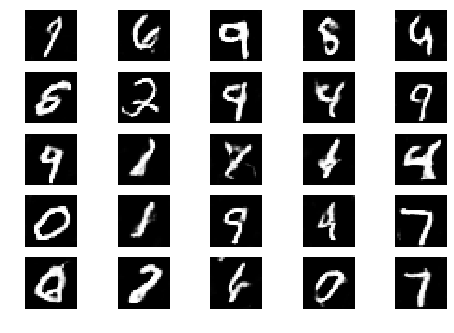

Epoch 5 Batch 1201/1875 [D loss: 0.693492, acc.: 59.38%] [G loss: 1.013673]
Epoch 5 Batch 1202/1875 [D loss: 0.851632, acc.: 46.88%] [G loss: 1.093567]
Epoch 5 Batch 1203/1875 [D loss: 0.732968, acc.: 43.75%] [G loss: 1.074408]
Epoch 5 Batch 1204/1875 [D loss: 0.707584, acc.: 50.00%] [G loss: 0.861297]
Epoch 5 Batch 1205/1875 [D loss: 0.680166, acc.: 56.25%] [G loss: 0.876555]
Epoch 5 Batch 1206/1875 [D loss: 0.515607, acc.: 78.12%] [G loss: 1.058391]
Epoch 5 Batch 1207/1875 [D loss: 0.507460, acc.: 81.25%] [G loss: 1.097752]
Epoch 5 Batch 1208/1875 [D loss: 0.717657, acc.: 65.62%] [G loss: 1.042054]
Epoch 5 Batch 1209/1875 [D loss: 0.598109, acc.: 62.50%] [G loss: 0.918885]
Epoch 5 Batch 1210/1875 [D loss: 0.523754, acc.: 78.12%] [G loss: 0.973648]
Epoch 5 Batch 1211/1875 [D loss: 0.593722, acc.: 68.75%] [G loss: 0.639521]
Epoch 5 Batch 1212/1875 [D loss: 0.574596, acc.: 65.62%] [G loss: 0.960407]
Epoch 5 Batch 1213/1875 [D loss: 0.753170, acc.: 56.25%] [G loss: 0.902370]
Epoch 5 Batc

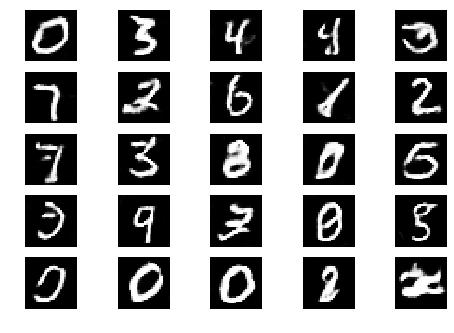

Epoch 5 Batch 1251/1875 [D loss: 0.670904, acc.: 62.50%] [G loss: 0.918100]
Epoch 5 Batch 1252/1875 [D loss: 0.618359, acc.: 65.62%] [G loss: 0.995783]
Epoch 5 Batch 1253/1875 [D loss: 0.740703, acc.: 46.88%] [G loss: 0.880193]
Epoch 5 Batch 1254/1875 [D loss: 0.698019, acc.: 53.12%] [G loss: 0.980614]
Epoch 5 Batch 1255/1875 [D loss: 0.689101, acc.: 56.25%] [G loss: 1.128132]
Epoch 5 Batch 1256/1875 [D loss: 0.706405, acc.: 56.25%] [G loss: 0.926444]
Epoch 5 Batch 1257/1875 [D loss: 0.752506, acc.: 43.75%] [G loss: 0.884012]
Epoch 5 Batch 1258/1875 [D loss: 0.759841, acc.: 53.12%] [G loss: 0.907008]
Epoch 5 Batch 1259/1875 [D loss: 0.643222, acc.: 65.62%] [G loss: 0.767752]
Epoch 5 Batch 1260/1875 [D loss: 0.564601, acc.: 81.25%] [G loss: 0.876357]
Epoch 5 Batch 1261/1875 [D loss: 0.591899, acc.: 68.75%] [G loss: 0.996763]
Epoch 5 Batch 1262/1875 [D loss: 0.924444, acc.: 40.62%] [G loss: 0.926974]
Epoch 5 Batch 1263/1875 [D loss: 0.646325, acc.: 53.12%] [G loss: 0.820563]
Epoch 5 Batc

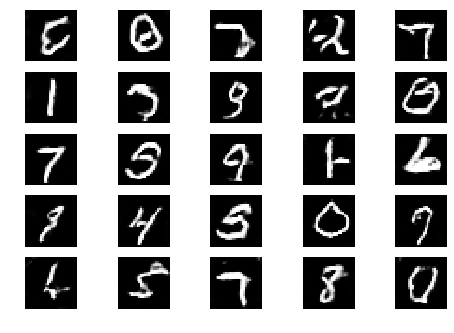

Epoch 5 Batch 1301/1875 [D loss: 0.626544, acc.: 68.75%] [G loss: 0.894629]
Epoch 5 Batch 1302/1875 [D loss: 0.520201, acc.: 81.25%] [G loss: 1.012212]
Epoch 5 Batch 1303/1875 [D loss: 0.741748, acc.: 56.25%] [G loss: 0.819309]
Epoch 5 Batch 1304/1875 [D loss: 0.623567, acc.: 62.50%] [G loss: 0.981238]
Epoch 5 Batch 1305/1875 [D loss: 0.539696, acc.: 87.50%] [G loss: 0.795916]
Epoch 5 Batch 1306/1875 [D loss: 0.676382, acc.: 59.38%] [G loss: 0.914512]
Epoch 5 Batch 1307/1875 [D loss: 0.756887, acc.: 46.88%] [G loss: 0.885349]
Epoch 5 Batch 1308/1875 [D loss: 0.626676, acc.: 62.50%] [G loss: 0.912076]
Epoch 5 Batch 1309/1875 [D loss: 0.676895, acc.: 65.62%] [G loss: 1.060194]
Epoch 5 Batch 1310/1875 [D loss: 0.770370, acc.: 50.00%] [G loss: 0.836842]
Epoch 5 Batch 1311/1875 [D loss: 0.568914, acc.: 68.75%] [G loss: 1.009487]
Epoch 5 Batch 1312/1875 [D loss: 0.635244, acc.: 56.25%] [G loss: 1.046095]
Epoch 5 Batch 1313/1875 [D loss: 0.653528, acc.: 75.00%] [G loss: 1.197115]
Epoch 5 Batc

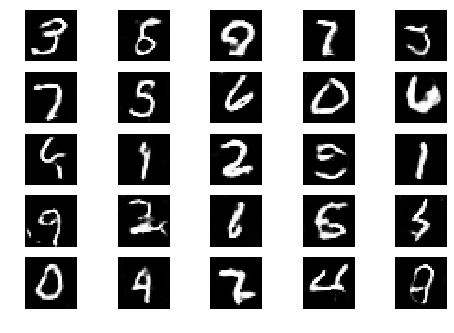

Epoch 5 Batch 1351/1875 [D loss: 0.714363, acc.: 50.00%] [G loss: 1.089395]
Epoch 5 Batch 1352/1875 [D loss: 0.529136, acc.: 75.00%] [G loss: 0.875494]
Epoch 5 Batch 1353/1875 [D loss: 0.654499, acc.: 56.25%] [G loss: 1.029144]
Epoch 5 Batch 1354/1875 [D loss: 0.757103, acc.: 37.50%] [G loss: 0.845454]
Epoch 5 Batch 1355/1875 [D loss: 0.705644, acc.: 50.00%] [G loss: 0.977900]
Epoch 5 Batch 1356/1875 [D loss: 0.485873, acc.: 81.25%] [G loss: 0.896694]
Epoch 5 Batch 1357/1875 [D loss: 0.612513, acc.: 68.75%] [G loss: 0.899156]
Epoch 5 Batch 1358/1875 [D loss: 0.606754, acc.: 62.50%] [G loss: 0.727493]
Epoch 5 Batch 1359/1875 [D loss: 0.721569, acc.: 50.00%] [G loss: 0.926995]
Epoch 5 Batch 1360/1875 [D loss: 0.611853, acc.: 65.62%] [G loss: 1.066679]
Epoch 5 Batch 1361/1875 [D loss: 0.667874, acc.: 68.75%] [G loss: 1.089973]
Epoch 5 Batch 1362/1875 [D loss: 0.737048, acc.: 62.50%] [G loss: 0.870153]
Epoch 5 Batch 1363/1875 [D loss: 0.668469, acc.: 56.25%] [G loss: 0.825765]
Epoch 5 Batc

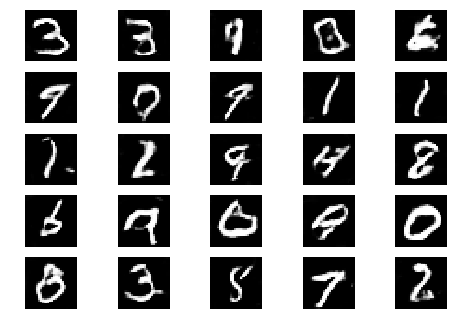

Epoch 5 Batch 1401/1875 [D loss: 0.717653, acc.: 53.12%] [G loss: 1.069312]
Epoch 5 Batch 1402/1875 [D loss: 0.807432, acc.: 50.00%] [G loss: 0.984023]
Epoch 5 Batch 1403/1875 [D loss: 0.740872, acc.: 53.12%] [G loss: 0.862473]
Epoch 5 Batch 1404/1875 [D loss: 0.644634, acc.: 56.25%] [G loss: 0.857340]
Epoch 5 Batch 1405/1875 [D loss: 0.741672, acc.: 40.62%] [G loss: 0.825254]
Epoch 5 Batch 1406/1875 [D loss: 0.644832, acc.: 50.00%] [G loss: 1.219284]
Epoch 5 Batch 1407/1875 [D loss: 0.723582, acc.: 53.12%] [G loss: 0.960813]
Epoch 5 Batch 1408/1875 [D loss: 0.531725, acc.: 71.88%] [G loss: 0.889953]
Epoch 5 Batch 1409/1875 [D loss: 0.535274, acc.: 75.00%] [G loss: 0.915368]
Epoch 5 Batch 1410/1875 [D loss: 0.531300, acc.: 71.88%] [G loss: 0.888524]
Epoch 5 Batch 1411/1875 [D loss: 0.612187, acc.: 62.50%] [G loss: 0.934924]
Epoch 5 Batch 1412/1875 [D loss: 0.680965, acc.: 53.12%] [G loss: 1.001495]
Epoch 5 Batch 1413/1875 [D loss: 0.605949, acc.: 65.62%] [G loss: 0.893709]
Epoch 5 Batc

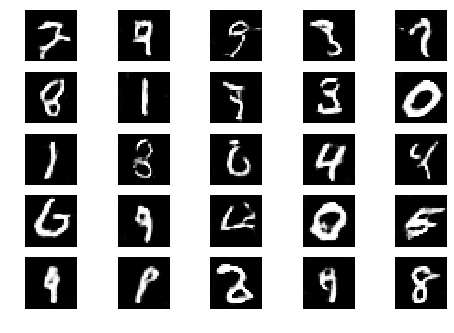

Epoch 5 Batch 1451/1875 [D loss: 0.560369, acc.: 71.88%] [G loss: 0.915815]
Epoch 5 Batch 1452/1875 [D loss: 0.617223, acc.: 68.75%] [G loss: 0.720348]
Epoch 5 Batch 1453/1875 [D loss: 0.729119, acc.: 46.88%] [G loss: 0.854262]
Epoch 5 Batch 1454/1875 [D loss: 0.672016, acc.: 53.12%] [G loss: 0.792826]
Epoch 5 Batch 1455/1875 [D loss: 0.653473, acc.: 62.50%] [G loss: 1.028998]
Epoch 5 Batch 1456/1875 [D loss: 0.681022, acc.: 53.12%] [G loss: 0.900515]
Epoch 5 Batch 1457/1875 [D loss: 0.694795, acc.: 50.00%] [G loss: 0.945570]
Epoch 5 Batch 1458/1875 [D loss: 0.615901, acc.: 68.75%] [G loss: 0.897303]
Epoch 5 Batch 1459/1875 [D loss: 0.630054, acc.: 62.50%] [G loss: 0.862643]
Epoch 5 Batch 1460/1875 [D loss: 0.809542, acc.: 50.00%] [G loss: 0.870111]
Epoch 5 Batch 1461/1875 [D loss: 0.621270, acc.: 56.25%] [G loss: 0.853621]
Epoch 5 Batch 1462/1875 [D loss: 0.689954, acc.: 56.25%] [G loss: 1.024857]
Epoch 5 Batch 1463/1875 [D loss: 0.635040, acc.: 68.75%] [G loss: 1.117104]
Epoch 5 Batc

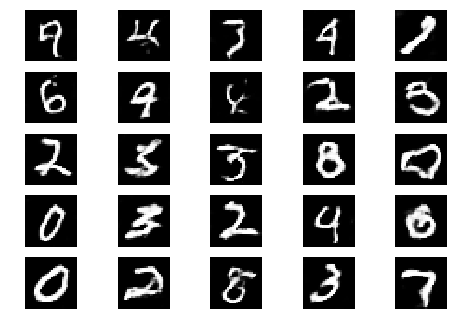

Epoch 5 Batch 1501/1875 [D loss: 0.680512, acc.: 53.12%] [G loss: 0.824097]
Epoch 5 Batch 1502/1875 [D loss: 0.690863, acc.: 56.25%] [G loss: 0.931273]
Epoch 5 Batch 1503/1875 [D loss: 0.612534, acc.: 65.62%] [G loss: 0.916282]
Epoch 5 Batch 1504/1875 [D loss: 0.589728, acc.: 68.75%] [G loss: 0.753015]
Epoch 5 Batch 1505/1875 [D loss: 0.737289, acc.: 46.88%] [G loss: 0.865185]
Epoch 5 Batch 1506/1875 [D loss: 0.679286, acc.: 59.38%] [G loss: 0.942781]
Epoch 5 Batch 1507/1875 [D loss: 0.845101, acc.: 46.88%] [G loss: 0.846910]
Epoch 5 Batch 1508/1875 [D loss: 0.559270, acc.: 78.12%] [G loss: 0.862911]
Epoch 5 Batch 1509/1875 [D loss: 0.599981, acc.: 56.25%] [G loss: 0.867874]
Epoch 5 Batch 1510/1875 [D loss: 0.803271, acc.: 50.00%] [G loss: 0.921298]
Epoch 5 Batch 1511/1875 [D loss: 0.550682, acc.: 71.88%] [G loss: 1.086064]
Epoch 5 Batch 1512/1875 [D loss: 0.622458, acc.: 68.75%] [G loss: 0.809831]
Epoch 5 Batch 1513/1875 [D loss: 0.626860, acc.: 65.62%] [G loss: 1.031198]
Epoch 5 Batc

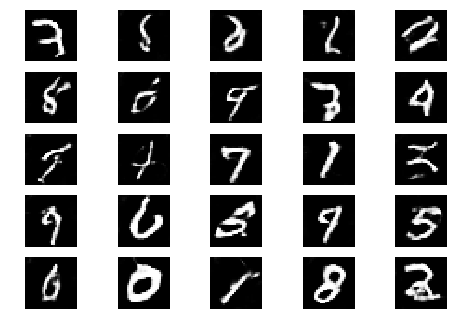

Epoch 5 Batch 1551/1875 [D loss: 0.663059, acc.: 50.00%] [G loss: 0.818549]
Epoch 5 Batch 1552/1875 [D loss: 0.590218, acc.: 71.88%] [G loss: 0.839398]
Epoch 5 Batch 1553/1875 [D loss: 0.655349, acc.: 53.12%] [G loss: 0.941308]
Epoch 5 Batch 1554/1875 [D loss: 0.693496, acc.: 68.75%] [G loss: 0.851937]
Epoch 5 Batch 1555/1875 [D loss: 0.590842, acc.: 71.88%] [G loss: 0.919214]
Epoch 5 Batch 1556/1875 [D loss: 0.802290, acc.: 43.75%] [G loss: 0.898616]
Epoch 5 Batch 1557/1875 [D loss: 0.594082, acc.: 65.62%] [G loss: 0.967900]
Epoch 5 Batch 1558/1875 [D loss: 0.717686, acc.: 53.12%] [G loss: 0.814452]
Epoch 5 Batch 1559/1875 [D loss: 0.510831, acc.: 75.00%] [G loss: 1.033594]
Epoch 5 Batch 1560/1875 [D loss: 0.840039, acc.: 31.25%] [G loss: 0.868960]
Epoch 5 Batch 1561/1875 [D loss: 0.873500, acc.: 40.62%] [G loss: 0.804640]
Epoch 5 Batch 1562/1875 [D loss: 0.652874, acc.: 56.25%] [G loss: 0.945221]
Epoch 5 Batch 1563/1875 [D loss: 0.679246, acc.: 59.38%] [G loss: 0.952020]
Epoch 5 Batc

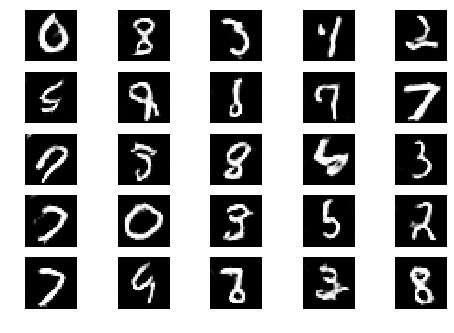

Epoch 5 Batch 1601/1875 [D loss: 0.640225, acc.: 62.50%] [G loss: 0.800624]
Epoch 5 Batch 1602/1875 [D loss: 0.726647, acc.: 56.25%] [G loss: 0.873317]
Epoch 5 Batch 1603/1875 [D loss: 0.548851, acc.: 75.00%] [G loss: 1.028579]
Epoch 5 Batch 1604/1875 [D loss: 0.725844, acc.: 50.00%] [G loss: 0.798342]
Epoch 5 Batch 1605/1875 [D loss: 0.674727, acc.: 59.38%] [G loss: 0.756575]
Epoch 5 Batch 1606/1875 [D loss: 0.554990, acc.: 68.75%] [G loss: 0.806980]
Epoch 5 Batch 1607/1875 [D loss: 0.580575, acc.: 78.12%] [G loss: 0.916681]
Epoch 5 Batch 1608/1875 [D loss: 0.788851, acc.: 59.38%] [G loss: 0.887911]
Epoch 5 Batch 1609/1875 [D loss: 0.656232, acc.: 62.50%] [G loss: 0.862931]
Epoch 5 Batch 1610/1875 [D loss: 0.586856, acc.: 68.75%] [G loss: 0.893641]
Epoch 5 Batch 1611/1875 [D loss: 0.635230, acc.: 65.62%] [G loss: 0.629051]
Epoch 5 Batch 1612/1875 [D loss: 0.672578, acc.: 46.88%] [G loss: 0.972115]
Epoch 5 Batch 1613/1875 [D loss: 0.587689, acc.: 62.50%] [G loss: 1.012148]
Epoch 5 Batc

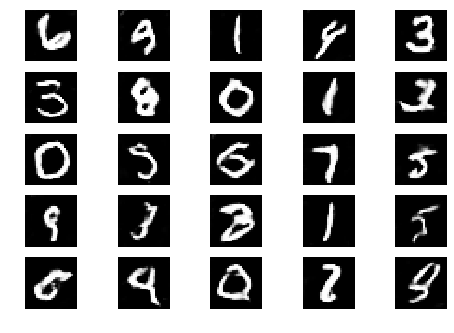

Epoch 5 Batch 1651/1875 [D loss: 0.591889, acc.: 71.88%] [G loss: 0.823527]
Epoch 5 Batch 1652/1875 [D loss: 0.767198, acc.: 50.00%] [G loss: 1.007951]
Epoch 5 Batch 1653/1875 [D loss: 0.687407, acc.: 56.25%] [G loss: 1.023996]
Epoch 5 Batch 1654/1875 [D loss: 0.757043, acc.: 56.25%] [G loss: 0.774191]
Epoch 5 Batch 1655/1875 [D loss: 0.591882, acc.: 68.75%] [G loss: 0.900589]
Epoch 5 Batch 1656/1875 [D loss: 0.637649, acc.: 59.38%] [G loss: 0.959560]
Epoch 5 Batch 1657/1875 [D loss: 0.547071, acc.: 71.88%] [G loss: 0.947343]
Epoch 5 Batch 1658/1875 [D loss: 0.630078, acc.: 59.38%] [G loss: 0.959936]
Epoch 5 Batch 1659/1875 [D loss: 0.626394, acc.: 65.62%] [G loss: 0.939424]
Epoch 5 Batch 1660/1875 [D loss: 0.593506, acc.: 75.00%] [G loss: 0.745679]
Epoch 5 Batch 1661/1875 [D loss: 0.680869, acc.: 59.38%] [G loss: 0.726681]
Epoch 5 Batch 1662/1875 [D loss: 0.685287, acc.: 56.25%] [G loss: 1.118608]
Epoch 5 Batch 1663/1875 [D loss: 0.489136, acc.: 78.12%] [G loss: 0.910362]
Epoch 5 Batc

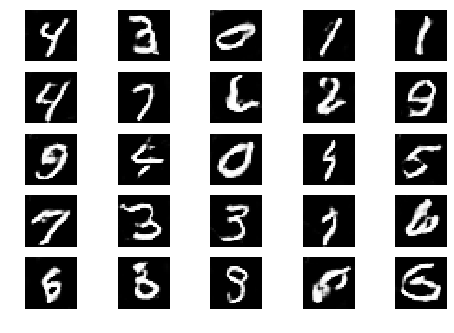

Epoch 5 Batch 1701/1875 [D loss: 0.690310, acc.: 59.38%] [G loss: 0.838783]
Epoch 5 Batch 1702/1875 [D loss: 0.644989, acc.: 75.00%] [G loss: 0.952029]
Epoch 5 Batch 1703/1875 [D loss: 0.744608, acc.: 46.88%] [G loss: 0.777053]
Epoch 5 Batch 1704/1875 [D loss: 0.674013, acc.: 53.12%] [G loss: 0.747630]
Epoch 5 Batch 1705/1875 [D loss: 0.728418, acc.: 56.25%] [G loss: 0.840645]
Epoch 5 Batch 1706/1875 [D loss: 0.706755, acc.: 62.50%] [G loss: 0.911038]
Epoch 5 Batch 1707/1875 [D loss: 0.533169, acc.: 78.12%] [G loss: 0.985754]
Epoch 5 Batch 1708/1875 [D loss: 0.709385, acc.: 50.00%] [G loss: 0.696785]
Epoch 5 Batch 1709/1875 [D loss: 0.630125, acc.: 68.75%] [G loss: 0.901921]
Epoch 5 Batch 1710/1875 [D loss: 0.703353, acc.: 50.00%] [G loss: 0.828495]
Epoch 5 Batch 1711/1875 [D loss: 0.574498, acc.: 81.25%] [G loss: 1.028863]
Epoch 5 Batch 1712/1875 [D loss: 0.801475, acc.: 37.50%] [G loss: 0.822622]
Epoch 5 Batch 1713/1875 [D loss: 0.705171, acc.: 56.25%] [G loss: 0.838190]
Epoch 5 Batc

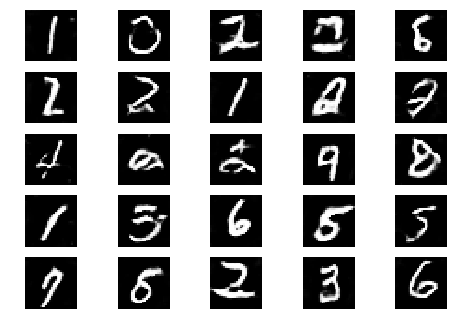

Epoch 5 Batch 1751/1875 [D loss: 0.745849, acc.: 46.88%] [G loss: 0.716471]
Epoch 5 Batch 1752/1875 [D loss: 0.692878, acc.: 56.25%] [G loss: 0.889672]
Epoch 5 Batch 1753/1875 [D loss: 0.687794, acc.: 59.38%] [G loss: 0.806682]
Epoch 5 Batch 1754/1875 [D loss: 0.636334, acc.: 59.38%] [G loss: 0.892238]
Epoch 5 Batch 1755/1875 [D loss: 0.765376, acc.: 43.75%] [G loss: 1.114774]
Epoch 5 Batch 1756/1875 [D loss: 0.688016, acc.: 56.25%] [G loss: 0.913033]
Epoch 5 Batch 1757/1875 [D loss: 0.631352, acc.: 65.62%] [G loss: 0.964983]
Epoch 5 Batch 1758/1875 [D loss: 0.548417, acc.: 75.00%] [G loss: 0.995308]
Epoch 5 Batch 1759/1875 [D loss: 0.753516, acc.: 43.75%] [G loss: 0.887760]
Epoch 5 Batch 1760/1875 [D loss: 0.683318, acc.: 53.12%] [G loss: 0.911128]
Epoch 5 Batch 1761/1875 [D loss: 0.576424, acc.: 75.00%] [G loss: 0.885898]
Epoch 5 Batch 1762/1875 [D loss: 0.743910, acc.: 53.12%] [G loss: 0.847951]
Epoch 5 Batch 1763/1875 [D loss: 0.638183, acc.: 68.75%] [G loss: 0.828347]
Epoch 5 Batc

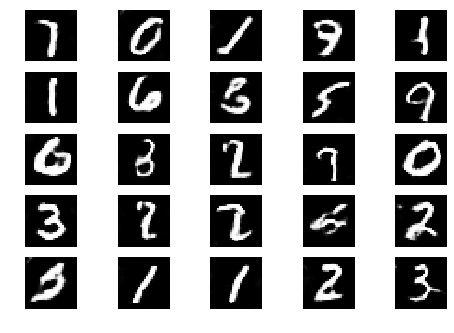

Epoch 5 Batch 1801/1875 [D loss: 0.601596, acc.: 59.38%] [G loss: 1.036917]
Epoch 5 Batch 1802/1875 [D loss: 0.656092, acc.: 59.38%] [G loss: 0.787916]
Epoch 5 Batch 1803/1875 [D loss: 0.608847, acc.: 68.75%] [G loss: 0.993158]
Epoch 5 Batch 1804/1875 [D loss: 0.699314, acc.: 65.62%] [G loss: 0.882028]
Epoch 5 Batch 1805/1875 [D loss: 0.613816, acc.: 62.50%] [G loss: 0.930278]
Epoch 5 Batch 1806/1875 [D loss: 0.617633, acc.: 65.62%] [G loss: 0.732276]
Epoch 5 Batch 1807/1875 [D loss: 0.635555, acc.: 65.62%] [G loss: 0.849166]
Epoch 5 Batch 1808/1875 [D loss: 0.609792, acc.: 62.50%] [G loss: 0.847086]
Epoch 5 Batch 1809/1875 [D loss: 0.598864, acc.: 68.75%] [G loss: 0.925719]
Epoch 5 Batch 1810/1875 [D loss: 0.606297, acc.: 59.38%] [G loss: 0.653086]
Epoch 5 Batch 1811/1875 [D loss: 0.723286, acc.: 50.00%] [G loss: 1.036395]
Epoch 5 Batch 1812/1875 [D loss: 0.760322, acc.: 50.00%] [G loss: 0.819918]
Epoch 5 Batch 1813/1875 [D loss: 0.578911, acc.: 68.75%] [G loss: 0.960378]
Epoch 5 Batc

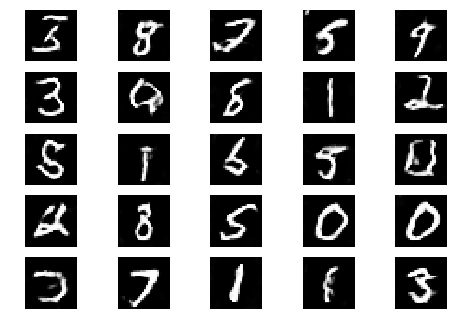

Epoch 5 Batch 1851/1875 [D loss: 0.615060, acc.: 59.38%] [G loss: 0.815256]
Epoch 5 Batch 1852/1875 [D loss: 0.738310, acc.: 43.75%] [G loss: 0.887381]
Epoch 5 Batch 1853/1875 [D loss: 0.613806, acc.: 59.38%] [G loss: 0.768774]
Epoch 5 Batch 1854/1875 [D loss: 0.664691, acc.: 59.38%] [G loss: 0.901258]
Epoch 5 Batch 1855/1875 [D loss: 0.644812, acc.: 56.25%] [G loss: 0.797626]
Epoch 5 Batch 1856/1875 [D loss: 0.626651, acc.: 56.25%] [G loss: 0.917127]
Epoch 5 Batch 1857/1875 [D loss: 0.727073, acc.: 53.12%] [G loss: 0.846370]
Epoch 5 Batch 1858/1875 [D loss: 0.742686, acc.: 53.12%] [G loss: 1.056579]
Epoch 5 Batch 1859/1875 [D loss: 0.816790, acc.: 37.50%] [G loss: 0.669051]
Epoch 5 Batch 1860/1875 [D loss: 0.727472, acc.: 43.75%] [G loss: 0.865603]
Epoch 5 Batch 1861/1875 [D loss: 0.794749, acc.: 46.88%] [G loss: 0.953801]
Epoch 5 Batch 1862/1875 [D loss: 0.638811, acc.: 59.38%] [G loss: 0.851231]
Epoch 5 Batch 1863/1875 [D loss: 0.728086, acc.: 53.12%] [G loss: 0.876151]
Epoch 5 Batc

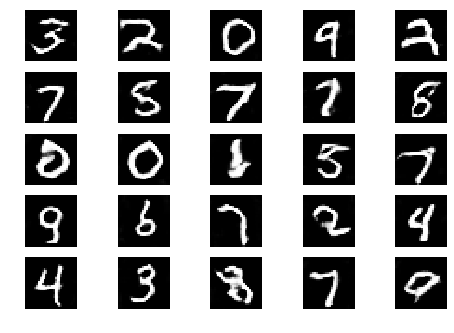

Epoch 6 Batch 1/1875 [D loss: 0.736575, acc.: 56.25%] [G loss: 0.890546]
Epoch 6 Batch 2/1875 [D loss: 0.570295, acc.: 68.75%] [G loss: 0.705608]
Epoch 6 Batch 3/1875 [D loss: 0.653379, acc.: 65.62%] [G loss: 0.815518]
Epoch 6 Batch 4/1875 [D loss: 0.692575, acc.: 50.00%] [G loss: 0.892700]
Epoch 6 Batch 5/1875 [D loss: 0.663837, acc.: 65.62%] [G loss: 0.760118]
Epoch 6 Batch 6/1875 [D loss: 0.538579, acc.: 78.12%] [G loss: 0.984673]
Epoch 6 Batch 7/1875 [D loss: 0.606618, acc.: 59.38%] [G loss: 0.773660]
Epoch 6 Batch 8/1875 [D loss: 0.636465, acc.: 65.62%] [G loss: 0.760880]
Epoch 6 Batch 9/1875 [D loss: 0.596040, acc.: 81.25%] [G loss: 0.819457]
Epoch 6 Batch 10/1875 [D loss: 0.734162, acc.: 53.12%] [G loss: 0.997152]
Epoch 6 Batch 11/1875 [D loss: 0.586752, acc.: 65.62%] [G loss: 0.946015]
Epoch 6 Batch 12/1875 [D loss: 0.595880, acc.: 68.75%] [G loss: 0.878582]
Epoch 6 Batch 13/1875 [D loss: 0.642099, acc.: 59.38%] [G loss: 0.907349]
Epoch 6 Batch 14/1875 [D loss: 0.654383, acc.: 

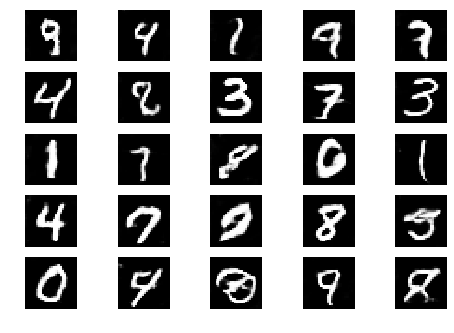

Epoch 6 Batch 51/1875 [D loss: 0.636248, acc.: 62.50%] [G loss: 0.785737]
Epoch 6 Batch 52/1875 [D loss: 0.586301, acc.: 71.88%] [G loss: 0.918501]
Epoch 6 Batch 53/1875 [D loss: 0.780339, acc.: 56.25%] [G loss: 0.980349]
Epoch 6 Batch 54/1875 [D loss: 0.714228, acc.: 50.00%] [G loss: 0.980376]
Epoch 6 Batch 55/1875 [D loss: 0.487212, acc.: 90.62%] [G loss: 0.795935]
Epoch 6 Batch 56/1875 [D loss: 0.673167, acc.: 56.25%] [G loss: 1.028647]
Epoch 6 Batch 57/1875 [D loss: 0.556603, acc.: 75.00%] [G loss: 0.975064]
Epoch 6 Batch 58/1875 [D loss: 0.629302, acc.: 75.00%] [G loss: 1.004768]
Epoch 6 Batch 59/1875 [D loss: 0.473236, acc.: 87.50%] [G loss: 0.974621]
Epoch 6 Batch 60/1875 [D loss: 0.492762, acc.: 87.50%] [G loss: 0.990489]
Epoch 6 Batch 61/1875 [D loss: 0.746268, acc.: 43.75%] [G loss: 0.956208]
Epoch 6 Batch 62/1875 [D loss: 0.775869, acc.: 46.88%] [G loss: 0.923170]
Epoch 6 Batch 63/1875 [D loss: 0.577258, acc.: 78.12%] [G loss: 0.941785]
Epoch 6 Batch 64/1875 [D loss: 0.61923

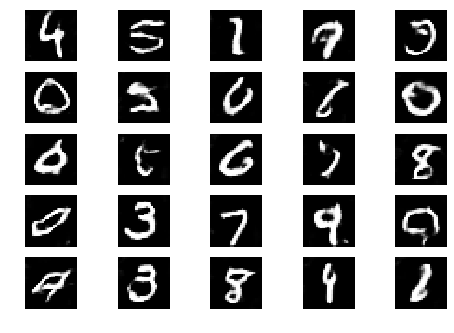

Epoch 6 Batch 101/1875 [D loss: 0.702341, acc.: 62.50%] [G loss: 0.861240]
Epoch 6 Batch 102/1875 [D loss: 0.606231, acc.: 68.75%] [G loss: 0.990663]
Epoch 6 Batch 103/1875 [D loss: 0.639900, acc.: 62.50%] [G loss: 1.088145]
Epoch 6 Batch 104/1875 [D loss: 0.664041, acc.: 53.12%] [G loss: 0.895858]
Epoch 6 Batch 105/1875 [D loss: 0.689476, acc.: 59.38%] [G loss: 1.019934]
Epoch 6 Batch 106/1875 [D loss: 0.656261, acc.: 59.38%] [G loss: 0.983000]
Epoch 6 Batch 107/1875 [D loss: 0.554880, acc.: 75.00%] [G loss: 0.879441]
Epoch 6 Batch 108/1875 [D loss: 0.575648, acc.: 68.75%] [G loss: 0.881532]
Epoch 6 Batch 109/1875 [D loss: 0.639414, acc.: 59.38%] [G loss: 0.906692]
Epoch 6 Batch 110/1875 [D loss: 0.705007, acc.: 53.12%] [G loss: 0.825119]
Epoch 6 Batch 111/1875 [D loss: 0.645129, acc.: 65.62%] [G loss: 0.922974]
Epoch 6 Batch 112/1875 [D loss: 0.748251, acc.: 43.75%] [G loss: 0.918947]
Epoch 6 Batch 113/1875 [D loss: 0.655532, acc.: 50.00%] [G loss: 1.001303]
Epoch 6 Batch 114/1875 [D

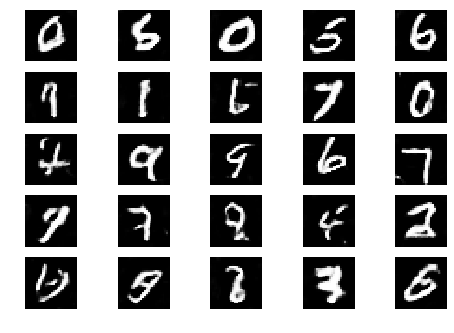

Epoch 6 Batch 151/1875 [D loss: 0.630410, acc.: 59.38%] [G loss: 0.930318]
Epoch 6 Batch 152/1875 [D loss: 0.753024, acc.: 53.12%] [G loss: 0.917410]
Epoch 6 Batch 153/1875 [D loss: 0.740448, acc.: 50.00%] [G loss: 0.846283]
Epoch 6 Batch 154/1875 [D loss: 0.743865, acc.: 46.88%] [G loss: 0.879254]
Epoch 6 Batch 155/1875 [D loss: 0.642438, acc.: 62.50%] [G loss: 0.916697]
Epoch 6 Batch 156/1875 [D loss: 0.713545, acc.: 53.12%] [G loss: 1.076168]
Epoch 6 Batch 157/1875 [D loss: 0.639325, acc.: 65.62%] [G loss: 1.014093]
Epoch 6 Batch 158/1875 [D loss: 0.703394, acc.: 53.12%] [G loss: 0.889892]
Epoch 6 Batch 159/1875 [D loss: 0.668929, acc.: 65.62%] [G loss: 0.862904]
Epoch 6 Batch 160/1875 [D loss: 0.655371, acc.: 53.12%] [G loss: 0.892659]
Epoch 6 Batch 161/1875 [D loss: 0.698136, acc.: 50.00%] [G loss: 0.845409]
Epoch 6 Batch 162/1875 [D loss: 0.489569, acc.: 87.50%] [G loss: 0.845626]
Epoch 6 Batch 163/1875 [D loss: 0.761518, acc.: 46.88%] [G loss: 0.861019]
Epoch 6 Batch 164/1875 [D

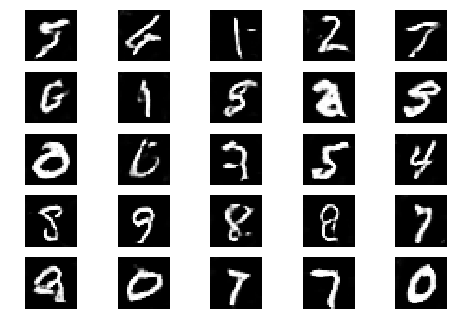

Epoch 6 Batch 201/1875 [D loss: 0.658895, acc.: 62.50%] [G loss: 0.930546]
Epoch 6 Batch 202/1875 [D loss: 0.736307, acc.: 53.12%] [G loss: 1.025936]
Epoch 6 Batch 203/1875 [D loss: 0.781635, acc.: 43.75%] [G loss: 0.917793]
Epoch 6 Batch 204/1875 [D loss: 0.661569, acc.: 56.25%] [G loss: 0.734124]
Epoch 6 Batch 205/1875 [D loss: 0.526892, acc.: 75.00%] [G loss: 0.879875]
Epoch 6 Batch 206/1875 [D loss: 0.530257, acc.: 84.38%] [G loss: 0.946356]
Epoch 6 Batch 207/1875 [D loss: 0.771027, acc.: 50.00%] [G loss: 0.867649]
Epoch 6 Batch 208/1875 [D loss: 0.633078, acc.: 59.38%] [G loss: 0.908804]
Epoch 6 Batch 209/1875 [D loss: 0.700303, acc.: 50.00%] [G loss: 0.771466]
Epoch 6 Batch 210/1875 [D loss: 0.687155, acc.: 53.12%] [G loss: 0.926909]
Epoch 6 Batch 211/1875 [D loss: 0.594417, acc.: 75.00%] [G loss: 0.927303]
Epoch 6 Batch 212/1875 [D loss: 0.591161, acc.: 71.88%] [G loss: 0.777454]
Epoch 6 Batch 213/1875 [D loss: 0.707530, acc.: 53.12%] [G loss: 0.840592]
Epoch 6 Batch 214/1875 [D

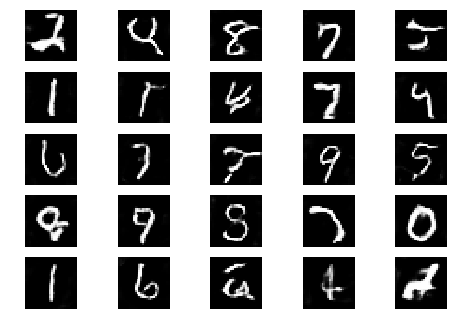

Epoch 6 Batch 251/1875 [D loss: 0.707677, acc.: 46.88%] [G loss: 0.826659]
Epoch 6 Batch 252/1875 [D loss: 0.651068, acc.: 65.62%] [G loss: 0.967970]
Epoch 6 Batch 253/1875 [D loss: 0.666419, acc.: 56.25%] [G loss: 0.806270]
Epoch 6 Batch 254/1875 [D loss: 0.599823, acc.: 65.62%] [G loss: 1.035201]
Epoch 6 Batch 255/1875 [D loss: 0.673569, acc.: 59.38%] [G loss: 0.955899]
Epoch 6 Batch 256/1875 [D loss: 0.721923, acc.: 46.88%] [G loss: 0.737614]
Epoch 6 Batch 257/1875 [D loss: 0.609404, acc.: 62.50%] [G loss: 0.949060]
Epoch 6 Batch 258/1875 [D loss: 0.793880, acc.: 50.00%] [G loss: 0.949170]
Epoch 6 Batch 259/1875 [D loss: 0.671804, acc.: 62.50%] [G loss: 0.902829]
Epoch 6 Batch 260/1875 [D loss: 0.578264, acc.: 75.00%] [G loss: 0.755505]
Epoch 6 Batch 261/1875 [D loss: 0.698907, acc.: 59.38%] [G loss: 0.929145]
Epoch 6 Batch 262/1875 [D loss: 0.761384, acc.: 59.38%] [G loss: 0.867967]
Epoch 6 Batch 263/1875 [D loss: 0.850956, acc.: 40.62%] [G loss: 0.715517]
Epoch 6 Batch 264/1875 [D

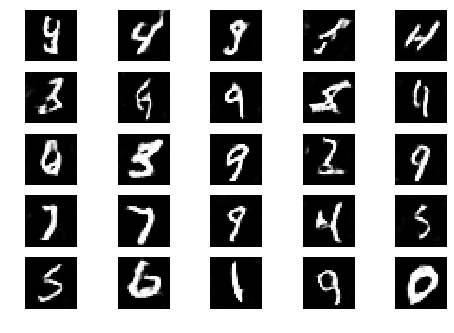

Epoch 6 Batch 301/1875 [D loss: 0.661569, acc.: 56.25%] [G loss: 0.907558]
Epoch 6 Batch 302/1875 [D loss: 0.679030, acc.: 56.25%] [G loss: 0.911651]
Epoch 6 Batch 303/1875 [D loss: 0.652714, acc.: 56.25%] [G loss: 0.771286]
Epoch 6 Batch 304/1875 [D loss: 0.611445, acc.: 65.62%] [G loss: 0.844610]
Epoch 6 Batch 305/1875 [D loss: 0.638647, acc.: 68.75%] [G loss: 0.803796]
Epoch 6 Batch 306/1875 [D loss: 0.565538, acc.: 75.00%] [G loss: 0.877530]
Epoch 6 Batch 307/1875 [D loss: 0.673871, acc.: 65.62%] [G loss: 0.842007]
Epoch 6 Batch 308/1875 [D loss: 0.641864, acc.: 59.38%] [G loss: 0.872221]
Epoch 6 Batch 309/1875 [D loss: 0.624007, acc.: 62.50%] [G loss: 0.768913]
Epoch 6 Batch 310/1875 [D loss: 0.660229, acc.: 65.62%] [G loss: 0.824814]
Epoch 6 Batch 311/1875 [D loss: 0.649071, acc.: 53.12%] [G loss: 0.982338]
Epoch 6 Batch 312/1875 [D loss: 0.694606, acc.: 56.25%] [G loss: 0.884124]
Epoch 6 Batch 313/1875 [D loss: 0.769610, acc.: 46.88%] [G loss: 0.897112]
Epoch 6 Batch 314/1875 [D

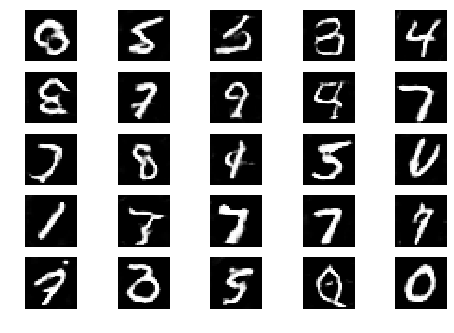

Epoch 6 Batch 351/1875 [D loss: 0.538450, acc.: 81.25%] [G loss: 1.185118]
Epoch 6 Batch 352/1875 [D loss: 0.652542, acc.: 59.38%] [G loss: 1.251095]
Epoch 6 Batch 353/1875 [D loss: 0.695146, acc.: 59.38%] [G loss: 1.040963]
Epoch 6 Batch 354/1875 [D loss: 0.724516, acc.: 56.25%] [G loss: 0.822751]
Epoch 6 Batch 355/1875 [D loss: 0.663356, acc.: 62.50%] [G loss: 1.025231]
Epoch 6 Batch 356/1875 [D loss: 0.690090, acc.: 40.62%] [G loss: 0.962586]
Epoch 6 Batch 357/1875 [D loss: 0.734042, acc.: 46.88%] [G loss: 0.965917]
Epoch 6 Batch 358/1875 [D loss: 0.593257, acc.: 65.62%] [G loss: 0.878530]
Epoch 6 Batch 359/1875 [D loss: 0.684362, acc.: 50.00%] [G loss: 0.983014]
Epoch 6 Batch 360/1875 [D loss: 0.788074, acc.: 43.75%] [G loss: 0.769508]
Epoch 6 Batch 361/1875 [D loss: 0.662632, acc.: 65.62%] [G loss: 0.921734]
Epoch 6 Batch 362/1875 [D loss: 0.760529, acc.: 37.50%] [G loss: 0.919882]
Epoch 6 Batch 363/1875 [D loss: 0.599660, acc.: 65.62%] [G loss: 0.872087]
Epoch 6 Batch 364/1875 [D

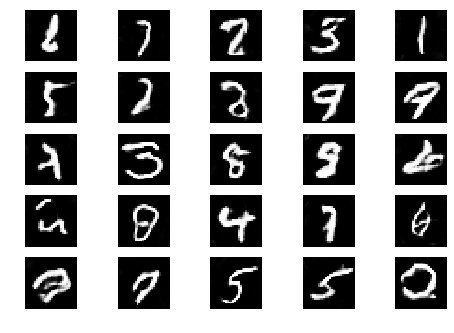

Epoch 6 Batch 401/1875 [D loss: 0.735646, acc.: 50.00%] [G loss: 0.960692]
Epoch 6 Batch 402/1875 [D loss: 0.653240, acc.: 68.75%] [G loss: 0.819152]
Epoch 6 Batch 403/1875 [D loss: 0.660558, acc.: 62.50%] [G loss: 0.780439]
Epoch 6 Batch 404/1875 [D loss: 0.615182, acc.: 75.00%] [G loss: 1.007762]
Epoch 6 Batch 405/1875 [D loss: 0.642279, acc.: 71.88%] [G loss: 0.872526]
Epoch 6 Batch 406/1875 [D loss: 0.708626, acc.: 43.75%] [G loss: 0.929410]
Epoch 6 Batch 407/1875 [D loss: 0.680234, acc.: 62.50%] [G loss: 0.924853]
Epoch 6 Batch 408/1875 [D loss: 0.856919, acc.: 40.62%] [G loss: 0.914780]
Epoch 6 Batch 409/1875 [D loss: 0.764717, acc.: 43.75%] [G loss: 0.802785]
Epoch 6 Batch 410/1875 [D loss: 0.625682, acc.: 53.12%] [G loss: 0.892064]
Epoch 6 Batch 411/1875 [D loss: 0.616273, acc.: 62.50%] [G loss: 0.765075]
Epoch 6 Batch 412/1875 [D loss: 0.649598, acc.: 65.62%] [G loss: 0.807074]
Epoch 6 Batch 413/1875 [D loss: 0.755695, acc.: 46.88%] [G loss: 0.909715]
Epoch 6 Batch 414/1875 [D

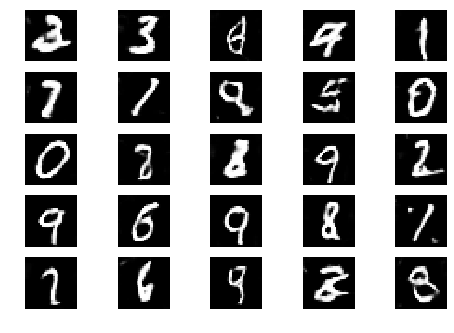

Epoch 6 Batch 451/1875 [D loss: 0.729515, acc.: 53.12%] [G loss: 0.807469]
Epoch 6 Batch 452/1875 [D loss: 0.715465, acc.: 50.00%] [G loss: 0.738930]
Epoch 6 Batch 453/1875 [D loss: 0.633638, acc.: 56.25%] [G loss: 0.970637]
Epoch 6 Batch 454/1875 [D loss: 0.666792, acc.: 56.25%] [G loss: 0.854376]
Epoch 6 Batch 455/1875 [D loss: 0.665668, acc.: 56.25%] [G loss: 0.853577]
Epoch 6 Batch 456/1875 [D loss: 0.662155, acc.: 65.62%] [G loss: 0.930145]
Epoch 6 Batch 457/1875 [D loss: 0.751305, acc.: 43.75%] [G loss: 0.882405]
Epoch 6 Batch 458/1875 [D loss: 0.707236, acc.: 62.50%] [G loss: 0.909049]
Epoch 6 Batch 459/1875 [D loss: 0.756073, acc.: 46.88%] [G loss: 1.004692]
Epoch 6 Batch 460/1875 [D loss: 0.697398, acc.: 59.38%] [G loss: 0.860902]
Epoch 6 Batch 461/1875 [D loss: 0.658025, acc.: 62.50%] [G loss: 0.902931]
Epoch 6 Batch 462/1875 [D loss: 0.757101, acc.: 46.88%] [G loss: 0.737571]
Epoch 6 Batch 463/1875 [D loss: 0.622170, acc.: 59.38%] [G loss: 0.983890]
Epoch 6 Batch 464/1875 [D

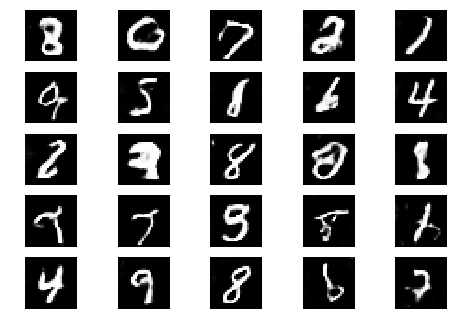

Epoch 6 Batch 501/1875 [D loss: 0.628704, acc.: 65.62%] [G loss: 0.885787]
Epoch 6 Batch 502/1875 [D loss: 0.803176, acc.: 56.25%] [G loss: 0.864952]
Epoch 6 Batch 503/1875 [D loss: 0.603530, acc.: 68.75%] [G loss: 0.929027]
Epoch 6 Batch 504/1875 [D loss: 0.629949, acc.: 65.62%] [G loss: 0.778317]
Epoch 6 Batch 505/1875 [D loss: 0.521173, acc.: 75.00%] [G loss: 0.836412]
Epoch 6 Batch 506/1875 [D loss: 0.657743, acc.: 53.12%] [G loss: 0.959400]
Epoch 6 Batch 507/1875 [D loss: 0.708256, acc.: 46.88%] [G loss: 0.958752]
Epoch 6 Batch 508/1875 [D loss: 0.828062, acc.: 43.75%] [G loss: 0.911189]
Epoch 6 Batch 509/1875 [D loss: 0.597810, acc.: 71.88%] [G loss: 0.969132]
Epoch 6 Batch 510/1875 [D loss: 0.752895, acc.: 43.75%] [G loss: 0.833630]
Epoch 6 Batch 511/1875 [D loss: 0.603758, acc.: 68.75%] [G loss: 0.900873]
Epoch 6 Batch 512/1875 [D loss: 0.617546, acc.: 62.50%] [G loss: 0.937290]
Epoch 6 Batch 513/1875 [D loss: 0.711492, acc.: 50.00%] [G loss: 0.914768]
Epoch 6 Batch 514/1875 [D

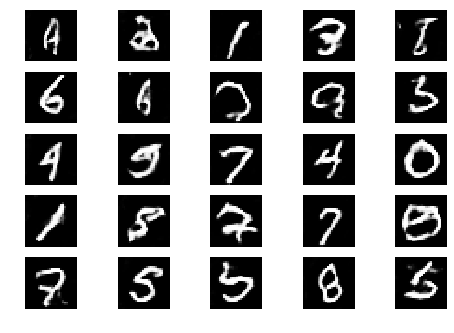

Epoch 6 Batch 551/1875 [D loss: 0.684012, acc.: 62.50%] [G loss: 0.893664]
Epoch 6 Batch 552/1875 [D loss: 0.653381, acc.: 71.88%] [G loss: 0.848175]
Epoch 6 Batch 553/1875 [D loss: 0.649442, acc.: 68.75%] [G loss: 0.979876]
Epoch 6 Batch 554/1875 [D loss: 0.689638, acc.: 56.25%] [G loss: 0.994490]
Epoch 6 Batch 555/1875 [D loss: 0.630160, acc.: 62.50%] [G loss: 0.937737]
Epoch 6 Batch 556/1875 [D loss: 0.687168, acc.: 59.38%] [G loss: 1.006941]
Epoch 6 Batch 557/1875 [D loss: 0.631011, acc.: 56.25%] [G loss: 0.759558]
Epoch 6 Batch 558/1875 [D loss: 0.748143, acc.: 40.62%] [G loss: 0.977046]
Epoch 6 Batch 559/1875 [D loss: 0.551569, acc.: 75.00%] [G loss: 0.925239]
Epoch 6 Batch 560/1875 [D loss: 0.739347, acc.: 53.12%] [G loss: 0.997134]
Epoch 6 Batch 561/1875 [D loss: 0.612937, acc.: 59.38%] [G loss: 0.982918]
Epoch 6 Batch 562/1875 [D loss: 0.625118, acc.: 59.38%] [G loss: 0.927105]
Epoch 6 Batch 563/1875 [D loss: 0.694526, acc.: 71.88%] [G loss: 0.962493]
Epoch 6 Batch 564/1875 [D

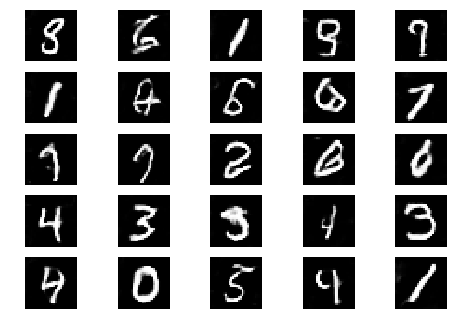

Epoch 6 Batch 601/1875 [D loss: 0.640493, acc.: 75.00%] [G loss: 1.073850]
Epoch 6 Batch 602/1875 [D loss: 0.643638, acc.: 59.38%] [G loss: 1.042476]
Epoch 6 Batch 603/1875 [D loss: 0.646297, acc.: 65.62%] [G loss: 0.901802]
Epoch 6 Batch 604/1875 [D loss: 0.775745, acc.: 50.00%] [G loss: 0.914986]
Epoch 6 Batch 605/1875 [D loss: 0.650498, acc.: 59.38%] [G loss: 0.929996]
Epoch 6 Batch 606/1875 [D loss: 0.729673, acc.: 56.25%] [G loss: 0.845923]
Epoch 6 Batch 607/1875 [D loss: 0.637286, acc.: 56.25%] [G loss: 1.012408]
Epoch 6 Batch 608/1875 [D loss: 0.685325, acc.: 62.50%] [G loss: 0.800944]
Epoch 6 Batch 609/1875 [D loss: 0.527846, acc.: 71.88%] [G loss: 0.870763]
Epoch 6 Batch 610/1875 [D loss: 0.599303, acc.: 65.62%] [G loss: 0.976419]
Epoch 6 Batch 611/1875 [D loss: 0.574681, acc.: 65.62%] [G loss: 1.090691]
Epoch 6 Batch 612/1875 [D loss: 0.702070, acc.: 62.50%] [G loss: 0.897064]
Epoch 6 Batch 613/1875 [D loss: 0.754598, acc.: 50.00%] [G loss: 0.857207]
Epoch 6 Batch 614/1875 [D

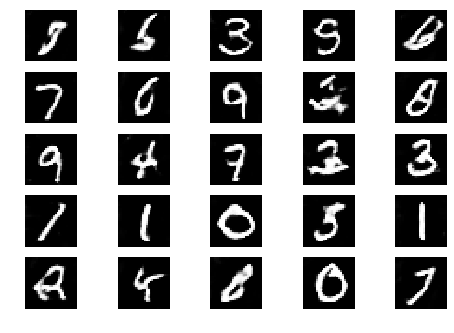

Epoch 6 Batch 651/1875 [D loss: 0.762890, acc.: 50.00%] [G loss: 0.924755]
Epoch 6 Batch 652/1875 [D loss: 0.454268, acc.: 78.12%] [G loss: 0.930939]
Epoch 6 Batch 653/1875 [D loss: 0.676432, acc.: 62.50%] [G loss: 1.096312]
Epoch 6 Batch 654/1875 [D loss: 0.698764, acc.: 50.00%] [G loss: 0.888126]
Epoch 6 Batch 655/1875 [D loss: 0.576096, acc.: 78.12%] [G loss: 1.185497]
Epoch 6 Batch 656/1875 [D loss: 0.650877, acc.: 59.38%] [G loss: 1.043290]
Epoch 6 Batch 657/1875 [D loss: 0.688750, acc.: 59.38%] [G loss: 0.969488]
Epoch 6 Batch 658/1875 [D loss: 0.741831, acc.: 62.50%] [G loss: 1.040390]
Epoch 6 Batch 659/1875 [D loss: 0.589264, acc.: 65.62%] [G loss: 0.886865]
Epoch 6 Batch 660/1875 [D loss: 0.825592, acc.: 43.75%] [G loss: 0.869685]
Epoch 6 Batch 661/1875 [D loss: 0.617728, acc.: 65.62%] [G loss: 0.847867]
Epoch 6 Batch 662/1875 [D loss: 0.615272, acc.: 68.75%] [G loss: 0.852428]
Epoch 6 Batch 663/1875 [D loss: 0.635748, acc.: 65.62%] [G loss: 1.099878]
Epoch 6 Batch 664/1875 [D

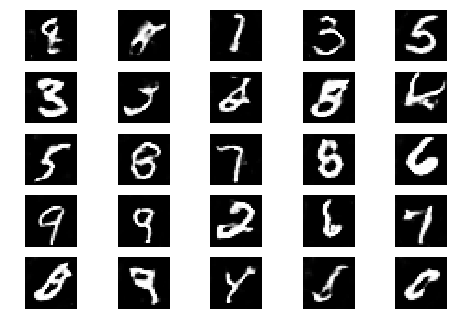

Epoch 6 Batch 701/1875 [D loss: 0.803850, acc.: 34.38%] [G loss: 0.882203]
Epoch 6 Batch 702/1875 [D loss: 0.795141, acc.: 46.88%] [G loss: 0.853512]
Epoch 6 Batch 703/1875 [D loss: 0.553528, acc.: 78.12%] [G loss: 0.848988]
Epoch 6 Batch 704/1875 [D loss: 0.683317, acc.: 53.12%] [G loss: 0.950643]
Epoch 6 Batch 705/1875 [D loss: 0.650183, acc.: 59.38%] [G loss: 0.935360]
Epoch 6 Batch 706/1875 [D loss: 0.579391, acc.: 68.75%] [G loss: 0.956076]
Epoch 6 Batch 707/1875 [D loss: 0.724771, acc.: 71.88%] [G loss: 0.948512]
Epoch 6 Batch 708/1875 [D loss: 0.664377, acc.: 62.50%] [G loss: 0.953980]
Epoch 6 Batch 709/1875 [D loss: 0.627951, acc.: 59.38%] [G loss: 0.831222]
Epoch 6 Batch 710/1875 [D loss: 0.660163, acc.: 56.25%] [G loss: 0.775649]
Epoch 6 Batch 711/1875 [D loss: 0.686931, acc.: 56.25%] [G loss: 0.920129]
Epoch 6 Batch 712/1875 [D loss: 0.604261, acc.: 71.88%] [G loss: 0.790818]
Epoch 6 Batch 713/1875 [D loss: 0.754043, acc.: 53.12%] [G loss: 0.928090]
Epoch 6 Batch 714/1875 [D

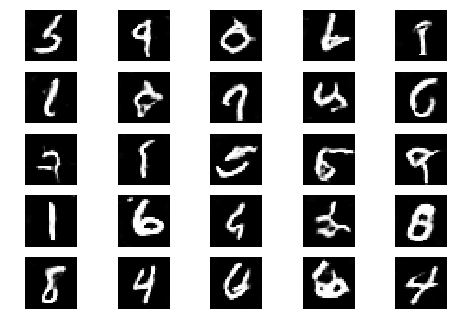

Epoch 6 Batch 751/1875 [D loss: 0.557292, acc.: 75.00%] [G loss: 0.924805]
Epoch 6 Batch 752/1875 [D loss: 0.649872, acc.: 53.12%] [G loss: 0.932262]
Epoch 6 Batch 753/1875 [D loss: 0.731198, acc.: 46.88%] [G loss: 0.887496]
Epoch 6 Batch 754/1875 [D loss: 0.825244, acc.: 37.50%] [G loss: 0.900523]
Epoch 6 Batch 755/1875 [D loss: 0.675065, acc.: 53.12%] [G loss: 0.961656]
Epoch 6 Batch 756/1875 [D loss: 0.588391, acc.: 81.25%] [G loss: 0.890931]
Epoch 6 Batch 757/1875 [D loss: 0.740255, acc.: 59.38%] [G loss: 0.896385]
Epoch 6 Batch 758/1875 [D loss: 0.624619, acc.: 59.38%] [G loss: 0.903831]
Epoch 6 Batch 759/1875 [D loss: 0.669819, acc.: 50.00%] [G loss: 0.952982]
Epoch 6 Batch 760/1875 [D loss: 0.684703, acc.: 56.25%] [G loss: 0.852580]
Epoch 6 Batch 761/1875 [D loss: 0.575514, acc.: 65.62%] [G loss: 0.860984]
Epoch 6 Batch 762/1875 [D loss: 0.604468, acc.: 68.75%] [G loss: 0.969030]
Epoch 6 Batch 763/1875 [D loss: 0.770516, acc.: 46.88%] [G loss: 1.019821]
Epoch 6 Batch 764/1875 [D

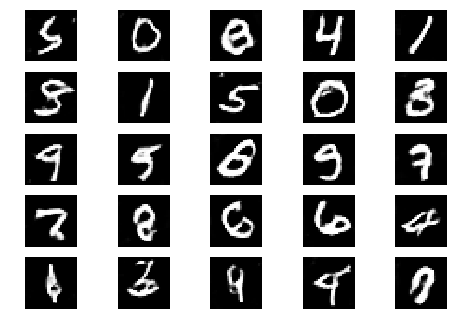

Epoch 6 Batch 801/1875 [D loss: 0.689567, acc.: 56.25%] [G loss: 0.924837]
Epoch 6 Batch 802/1875 [D loss: 0.850264, acc.: 43.75%] [G loss: 0.875042]
Epoch 6 Batch 803/1875 [D loss: 0.619037, acc.: 59.38%] [G loss: 0.870041]
Epoch 6 Batch 804/1875 [D loss: 0.776547, acc.: 53.12%] [G loss: 1.016709]
Epoch 6 Batch 805/1875 [D loss: 0.758240, acc.: 43.75%] [G loss: 0.941189]
Epoch 6 Batch 806/1875 [D loss: 0.722255, acc.: 53.12%] [G loss: 0.783389]
Epoch 6 Batch 807/1875 [D loss: 0.861422, acc.: 37.50%] [G loss: 0.823658]
Epoch 6 Batch 808/1875 [D loss: 0.595769, acc.: 75.00%] [G loss: 0.785087]
Epoch 6 Batch 809/1875 [D loss: 0.760899, acc.: 56.25%] [G loss: 1.059030]
Epoch 6 Batch 810/1875 [D loss: 0.582297, acc.: 65.62%] [G loss: 0.724501]
Epoch 6 Batch 811/1875 [D loss: 0.617723, acc.: 62.50%] [G loss: 0.947021]
Epoch 6 Batch 812/1875 [D loss: 0.570313, acc.: 62.50%] [G loss: 0.991174]
Epoch 6 Batch 813/1875 [D loss: 0.571860, acc.: 68.75%] [G loss: 1.090368]
Epoch 6 Batch 814/1875 [D

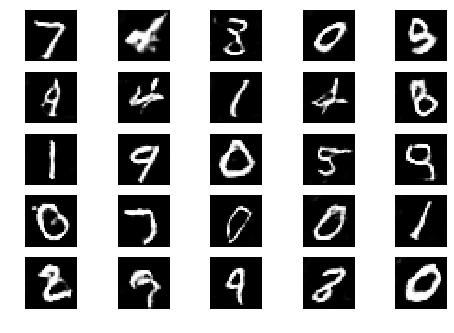

Epoch 6 Batch 851/1875 [D loss: 0.642780, acc.: 68.75%] [G loss: 0.830528]
Epoch 6 Batch 852/1875 [D loss: 0.528466, acc.: 75.00%] [G loss: 0.901021]
Epoch 6 Batch 853/1875 [D loss: 0.689814, acc.: 53.12%] [G loss: 0.723056]
Epoch 6 Batch 854/1875 [D loss: 0.656732, acc.: 56.25%] [G loss: 0.609432]
Epoch 6 Batch 855/1875 [D loss: 0.637302, acc.: 62.50%] [G loss: 0.689792]
Epoch 6 Batch 856/1875 [D loss: 0.601733, acc.: 65.62%] [G loss: 0.975113]
Epoch 6 Batch 857/1875 [D loss: 0.656378, acc.: 53.12%] [G loss: 0.880030]
Epoch 6 Batch 858/1875 [D loss: 0.779083, acc.: 43.75%] [G loss: 0.909273]
Epoch 6 Batch 859/1875 [D loss: 0.655126, acc.: 59.38%] [G loss: 0.951374]
Epoch 6 Batch 860/1875 [D loss: 0.615188, acc.: 68.75%] [G loss: 1.017565]
Epoch 6 Batch 861/1875 [D loss: 0.745997, acc.: 50.00%] [G loss: 0.854949]
Epoch 6 Batch 862/1875 [D loss: 0.580179, acc.: 65.62%] [G loss: 0.892592]
Epoch 6 Batch 863/1875 [D loss: 0.668988, acc.: 68.75%] [G loss: 0.823577]
Epoch 6 Batch 864/1875 [D

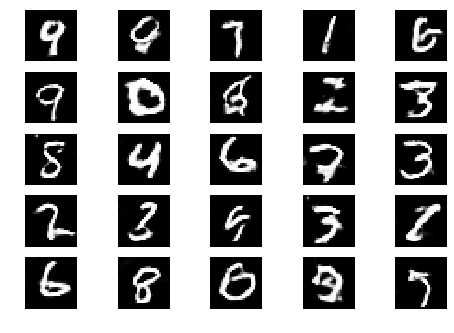

Epoch 6 Batch 901/1875 [D loss: 0.614317, acc.: 68.75%] [G loss: 0.972830]
Epoch 6 Batch 902/1875 [D loss: 0.572421, acc.: 68.75%] [G loss: 0.950434]
Epoch 6 Batch 903/1875 [D loss: 0.708735, acc.: 53.12%] [G loss: 0.755893]
Epoch 6 Batch 904/1875 [D loss: 0.606764, acc.: 59.38%] [G loss: 0.977086]
Epoch 6 Batch 905/1875 [D loss: 0.706879, acc.: 56.25%] [G loss: 0.982482]
Epoch 6 Batch 906/1875 [D loss: 0.770663, acc.: 46.88%] [G loss: 0.899373]
Epoch 6 Batch 907/1875 [D loss: 0.794891, acc.: 53.12%] [G loss: 0.950259]
Epoch 6 Batch 908/1875 [D loss: 0.657671, acc.: 59.38%] [G loss: 0.911591]
Epoch 6 Batch 909/1875 [D loss: 0.652589, acc.: 65.62%] [G loss: 0.776325]
Epoch 6 Batch 910/1875 [D loss: 0.534974, acc.: 71.88%] [G loss: 0.829073]
Epoch 6 Batch 911/1875 [D loss: 0.728299, acc.: 53.12%] [G loss: 0.880701]
Epoch 6 Batch 912/1875 [D loss: 0.716568, acc.: 46.88%] [G loss: 0.878781]
Epoch 6 Batch 913/1875 [D loss: 0.689684, acc.: 62.50%] [G loss: 0.877775]
Epoch 6 Batch 914/1875 [D

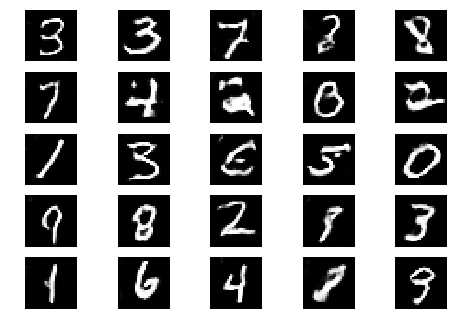

Epoch 6 Batch 951/1875 [D loss: 0.696140, acc.: 56.25%] [G loss: 0.982683]
Epoch 6 Batch 952/1875 [D loss: 0.746563, acc.: 62.50%] [G loss: 1.069729]
Epoch 6 Batch 953/1875 [D loss: 0.803973, acc.: 46.88%] [G loss: 0.891778]
Epoch 6 Batch 954/1875 [D loss: 0.851899, acc.: 43.75%] [G loss: 0.793910]
Epoch 6 Batch 955/1875 [D loss: 0.722049, acc.: 56.25%] [G loss: 0.799511]
Epoch 6 Batch 956/1875 [D loss: 0.719344, acc.: 46.88%] [G loss: 0.809382]
Epoch 6 Batch 957/1875 [D loss: 0.695036, acc.: 53.12%] [G loss: 0.904122]
Epoch 6 Batch 958/1875 [D loss: 0.760644, acc.: 50.00%] [G loss: 0.910099]
Epoch 6 Batch 959/1875 [D loss: 0.591211, acc.: 71.88%] [G loss: 0.990733]
Epoch 6 Batch 960/1875 [D loss: 0.693993, acc.: 53.12%] [G loss: 0.937492]
Epoch 6 Batch 961/1875 [D loss: 0.829925, acc.: 53.12%] [G loss: 0.997960]
Epoch 6 Batch 962/1875 [D loss: 0.588585, acc.: 65.62%] [G loss: 0.923182]
Epoch 6 Batch 963/1875 [D loss: 0.584705, acc.: 65.62%] [G loss: 1.032245]
Epoch 6 Batch 964/1875 [D

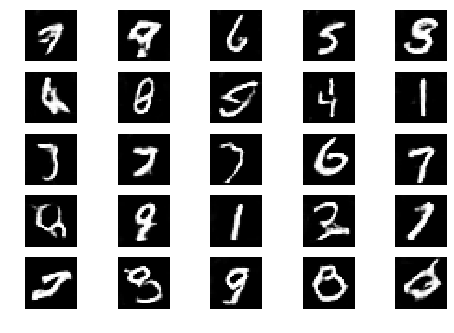

Epoch 6 Batch 1001/1875 [D loss: 0.760034, acc.: 46.88%] [G loss: 0.741735]
Epoch 6 Batch 1002/1875 [D loss: 0.727426, acc.: 46.88%] [G loss: 0.800138]
Epoch 6 Batch 1003/1875 [D loss: 0.605789, acc.: 65.62%] [G loss: 0.981548]
Epoch 6 Batch 1004/1875 [D loss: 0.556122, acc.: 84.38%] [G loss: 0.873823]
Epoch 6 Batch 1005/1875 [D loss: 0.594638, acc.: 75.00%] [G loss: 0.982707]
Epoch 6 Batch 1006/1875 [D loss: 0.707093, acc.: 56.25%] [G loss: 0.990758]
Epoch 6 Batch 1007/1875 [D loss: 0.747790, acc.: 53.12%] [G loss: 1.007036]
Epoch 6 Batch 1008/1875 [D loss: 0.605026, acc.: 59.38%] [G loss: 0.798645]
Epoch 6 Batch 1009/1875 [D loss: 0.624816, acc.: 65.62%] [G loss: 0.795891]
Epoch 6 Batch 1010/1875 [D loss: 0.597734, acc.: 78.12%] [G loss: 0.893286]
Epoch 6 Batch 1011/1875 [D loss: 0.540885, acc.: 78.12%] [G loss: 1.052602]
Epoch 6 Batch 1012/1875 [D loss: 0.646302, acc.: 65.62%] [G loss: 0.812203]
Epoch 6 Batch 1013/1875 [D loss: 0.742087, acc.: 46.88%] [G loss: 0.788739]
Epoch 6 Batc

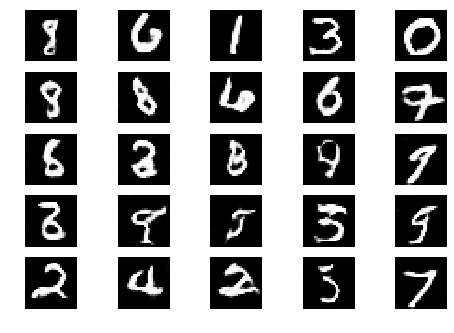

Epoch 6 Batch 1051/1875 [D loss: 0.678812, acc.: 65.62%] [G loss: 0.993443]
Epoch 6 Batch 1052/1875 [D loss: 0.706984, acc.: 53.12%] [G loss: 0.929287]
Epoch 6 Batch 1053/1875 [D loss: 0.702172, acc.: 53.12%] [G loss: 0.998025]
Epoch 6 Batch 1054/1875 [D loss: 0.595146, acc.: 65.62%] [G loss: 0.960612]
Epoch 6 Batch 1055/1875 [D loss: 0.746931, acc.: 56.25%] [G loss: 0.992504]
Epoch 6 Batch 1056/1875 [D loss: 0.651524, acc.: 65.62%] [G loss: 1.021725]
Epoch 6 Batch 1057/1875 [D loss: 0.717979, acc.: 50.00%] [G loss: 1.075406]
Epoch 6 Batch 1058/1875 [D loss: 0.759545, acc.: 50.00%] [G loss: 1.048722]
Epoch 6 Batch 1059/1875 [D loss: 0.569545, acc.: 71.88%] [G loss: 0.999831]
Epoch 6 Batch 1060/1875 [D loss: 0.597294, acc.: 65.62%] [G loss: 0.772162]
Epoch 6 Batch 1061/1875 [D loss: 0.645690, acc.: 56.25%] [G loss: 0.835342]
Epoch 6 Batch 1062/1875 [D loss: 0.590495, acc.: 68.75%] [G loss: 0.927914]
Epoch 6 Batch 1063/1875 [D loss: 0.713178, acc.: 50.00%] [G loss: 0.958437]
Epoch 6 Batc

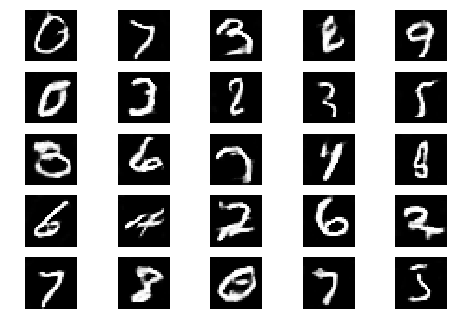

Epoch 6 Batch 1101/1875 [D loss: 0.592170, acc.: 68.75%] [G loss: 1.023031]
Epoch 6 Batch 1102/1875 [D loss: 0.674698, acc.: 65.62%] [G loss: 0.876585]
Epoch 6 Batch 1103/1875 [D loss: 0.660350, acc.: 56.25%] [G loss: 1.040981]
Epoch 6 Batch 1104/1875 [D loss: 0.603336, acc.: 68.75%] [G loss: 0.950154]
Epoch 6 Batch 1105/1875 [D loss: 0.738017, acc.: 46.88%] [G loss: 0.947901]
Epoch 6 Batch 1106/1875 [D loss: 0.647521, acc.: 75.00%] [G loss: 0.877105]
Epoch 6 Batch 1107/1875 [D loss: 0.655279, acc.: 62.50%] [G loss: 0.809207]
Epoch 6 Batch 1108/1875 [D loss: 0.629091, acc.: 71.88%] [G loss: 0.828000]
Epoch 6 Batch 1109/1875 [D loss: 0.852787, acc.: 43.75%] [G loss: 0.868785]
Epoch 6 Batch 1110/1875 [D loss: 0.628807, acc.: 65.62%] [G loss: 0.880637]
Epoch 6 Batch 1111/1875 [D loss: 0.627259, acc.: 56.25%] [G loss: 0.936499]
Epoch 6 Batch 1112/1875 [D loss: 0.648294, acc.: 68.75%] [G loss: 0.872810]
Epoch 6 Batch 1113/1875 [D loss: 0.785157, acc.: 37.50%] [G loss: 0.796319]
Epoch 6 Batc

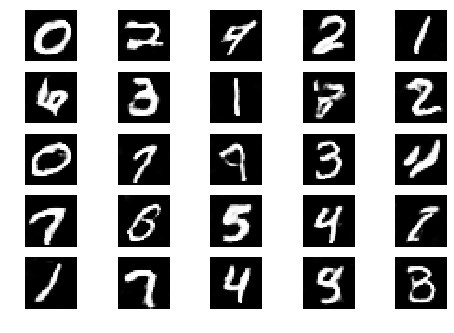

Epoch 6 Batch 1151/1875 [D loss: 0.749809, acc.: 50.00%] [G loss: 1.017069]
Epoch 6 Batch 1152/1875 [D loss: 0.636315, acc.: 59.38%] [G loss: 0.892773]
Epoch 6 Batch 1153/1875 [D loss: 0.505488, acc.: 87.50%] [G loss: 0.859872]
Epoch 6 Batch 1154/1875 [D loss: 0.706550, acc.: 56.25%] [G loss: 0.835437]
Epoch 6 Batch 1155/1875 [D loss: 0.591056, acc.: 75.00%] [G loss: 0.793579]
Epoch 6 Batch 1156/1875 [D loss: 0.577319, acc.: 62.50%] [G loss: 1.032655]
Epoch 6 Batch 1157/1875 [D loss: 0.776750, acc.: 43.75%] [G loss: 0.924202]
Epoch 6 Batch 1158/1875 [D loss: 0.687162, acc.: 68.75%] [G loss: 0.835941]
Epoch 6 Batch 1159/1875 [D loss: 0.567716, acc.: 68.75%] [G loss: 0.811081]
Epoch 6 Batch 1160/1875 [D loss: 0.644061, acc.: 59.38%] [G loss: 0.716694]
Epoch 6 Batch 1161/1875 [D loss: 0.712942, acc.: 50.00%] [G loss: 0.774611]
Epoch 6 Batch 1162/1875 [D loss: 0.707731, acc.: 59.38%] [G loss: 0.832727]
Epoch 6 Batch 1163/1875 [D loss: 0.705542, acc.: 50.00%] [G loss: 0.866350]
Epoch 6 Batc

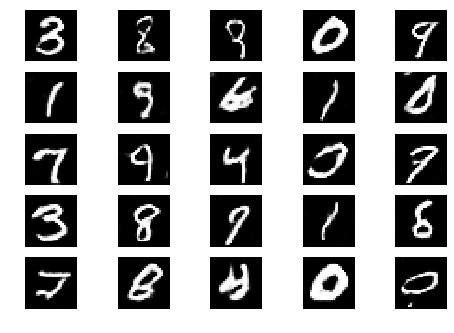

Epoch 6 Batch 1201/1875 [D loss: 0.635751, acc.: 59.38%] [G loss: 0.937689]
Epoch 6 Batch 1202/1875 [D loss: 0.661646, acc.: 56.25%] [G loss: 0.986862]
Epoch 6 Batch 1203/1875 [D loss: 0.601136, acc.: 68.75%] [G loss: 0.965135]
Epoch 6 Batch 1204/1875 [D loss: 0.605464, acc.: 81.25%] [G loss: 1.003826]
Epoch 6 Batch 1205/1875 [D loss: 0.676944, acc.: 62.50%] [G loss: 0.933628]
Epoch 6 Batch 1206/1875 [D loss: 0.542336, acc.: 81.25%] [G loss: 0.880659]
Epoch 6 Batch 1207/1875 [D loss: 0.620957, acc.: 68.75%] [G loss: 0.950479]
Epoch 6 Batch 1208/1875 [D loss: 0.705191, acc.: 56.25%] [G loss: 1.013377]
Epoch 6 Batch 1209/1875 [D loss: 0.684656, acc.: 56.25%] [G loss: 0.850672]
Epoch 6 Batch 1210/1875 [D loss: 0.639312, acc.: 68.75%] [G loss: 0.860216]
Epoch 6 Batch 1211/1875 [D loss: 0.633990, acc.: 65.62%] [G loss: 1.009570]
Epoch 6 Batch 1212/1875 [D loss: 0.629464, acc.: 75.00%] [G loss: 0.907576]
Epoch 6 Batch 1213/1875 [D loss: 0.695819, acc.: 59.38%] [G loss: 0.871213]
Epoch 6 Batc

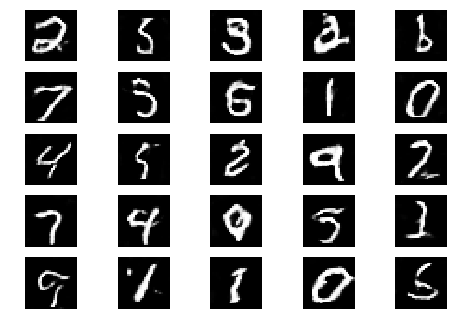

Epoch 6 Batch 1251/1875 [D loss: 0.730516, acc.: 50.00%] [G loss: 1.010391]
Epoch 6 Batch 1252/1875 [D loss: 0.612072, acc.: 62.50%] [G loss: 0.885548]
Epoch 6 Batch 1253/1875 [D loss: 0.609334, acc.: 62.50%] [G loss: 0.984580]
Epoch 6 Batch 1254/1875 [D loss: 0.694390, acc.: 56.25%] [G loss: 0.885454]
Epoch 6 Batch 1255/1875 [D loss: 0.652901, acc.: 53.12%] [G loss: 0.871513]
Epoch 6 Batch 1256/1875 [D loss: 0.720457, acc.: 53.12%] [G loss: 0.917856]
Epoch 6 Batch 1257/1875 [D loss: 0.664095, acc.: 62.50%] [G loss: 0.910525]
Epoch 6 Batch 1258/1875 [D loss: 0.647110, acc.: 56.25%] [G loss: 0.851077]
Epoch 6 Batch 1259/1875 [D loss: 0.689669, acc.: 65.62%] [G loss: 0.832891]
Epoch 6 Batch 1260/1875 [D loss: 0.662132, acc.: 62.50%] [G loss: 1.020337]
Epoch 6 Batch 1261/1875 [D loss: 0.671038, acc.: 56.25%] [G loss: 0.993794]
Epoch 6 Batch 1262/1875 [D loss: 0.567951, acc.: 71.88%] [G loss: 0.856339]
Epoch 6 Batch 1263/1875 [D loss: 0.623691, acc.: 59.38%] [G loss: 0.908433]
Epoch 6 Batc

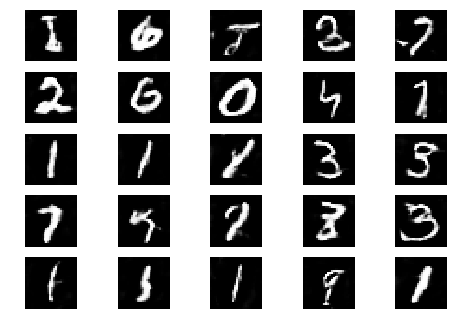

Epoch 6 Batch 1301/1875 [D loss: 0.649509, acc.: 50.00%] [G loss: 0.906884]
Epoch 6 Batch 1302/1875 [D loss: 0.517111, acc.: 84.38%] [G loss: 0.965577]
Epoch 6 Batch 1303/1875 [D loss: 0.612320, acc.: 62.50%] [G loss: 0.905132]
Epoch 6 Batch 1304/1875 [D loss: 0.658919, acc.: 65.62%] [G loss: 0.930516]
Epoch 6 Batch 1305/1875 [D loss: 0.673844, acc.: 65.62%] [G loss: 0.782933]
Epoch 6 Batch 1306/1875 [D loss: 0.711375, acc.: 53.12%] [G loss: 0.854787]
Epoch 6 Batch 1307/1875 [D loss: 0.684563, acc.: 62.50%] [G loss: 0.689152]
Epoch 6 Batch 1308/1875 [D loss: 0.499266, acc.: 87.50%] [G loss: 1.036938]
Epoch 6 Batch 1309/1875 [D loss: 0.628109, acc.: 68.75%] [G loss: 0.914928]
Epoch 6 Batch 1310/1875 [D loss: 0.659230, acc.: 65.62%] [G loss: 1.059951]
Epoch 6 Batch 1311/1875 [D loss: 0.562614, acc.: 71.88%] [G loss: 0.967671]
Epoch 6 Batch 1312/1875 [D loss: 0.673992, acc.: 59.38%] [G loss: 0.971883]
Epoch 6 Batch 1313/1875 [D loss: 0.827351, acc.: 50.00%] [G loss: 0.902017]
Epoch 6 Batc

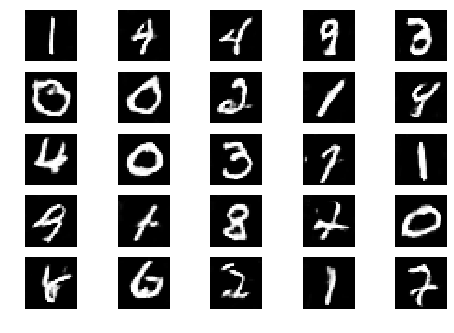

Epoch 6 Batch 1351/1875 [D loss: 0.758491, acc.: 50.00%] [G loss: 0.786489]
Epoch 6 Batch 1352/1875 [D loss: 0.770936, acc.: 59.38%] [G loss: 0.782726]
Epoch 6 Batch 1353/1875 [D loss: 0.615631, acc.: 75.00%] [G loss: 0.844192]
Epoch 6 Batch 1354/1875 [D loss: 0.631490, acc.: 62.50%] [G loss: 0.987464]
Epoch 6 Batch 1355/1875 [D loss: 0.696722, acc.: 50.00%] [G loss: 0.876125]
Epoch 6 Batch 1356/1875 [D loss: 0.634755, acc.: 65.62%] [G loss: 0.877152]
Epoch 6 Batch 1357/1875 [D loss: 0.611864, acc.: 71.88%] [G loss: 0.958852]
Epoch 6 Batch 1358/1875 [D loss: 0.676399, acc.: 56.25%] [G loss: 1.024444]
Epoch 6 Batch 1359/1875 [D loss: 0.723236, acc.: 50.00%] [G loss: 0.850297]
Epoch 6 Batch 1360/1875 [D loss: 0.607478, acc.: 59.38%] [G loss: 0.791309]
Epoch 6 Batch 1361/1875 [D loss: 0.643487, acc.: 62.50%] [G loss: 0.774263]
Epoch 6 Batch 1362/1875 [D loss: 0.672369, acc.: 56.25%] [G loss: 1.027063]
Epoch 6 Batch 1363/1875 [D loss: 0.594079, acc.: 78.12%] [G loss: 0.748716]
Epoch 6 Batc

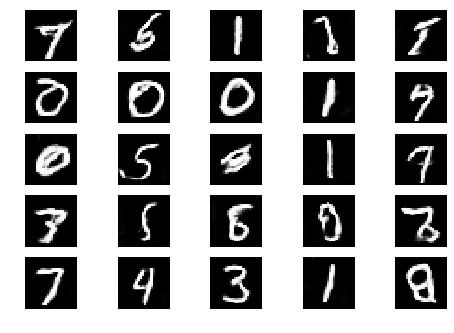

Epoch 6 Batch 1401/1875 [D loss: 0.703403, acc.: 46.88%] [G loss: 0.723172]
Epoch 6 Batch 1402/1875 [D loss: 0.719060, acc.: 46.88%] [G loss: 0.927012]
Epoch 6 Batch 1403/1875 [D loss: 0.778964, acc.: 59.38%] [G loss: 0.846933]
Epoch 6 Batch 1404/1875 [D loss: 0.704226, acc.: 56.25%] [G loss: 0.868331]
Epoch 6 Batch 1405/1875 [D loss: 0.683646, acc.: 65.62%] [G loss: 0.948566]
Epoch 6 Batch 1406/1875 [D loss: 0.619386, acc.: 65.62%] [G loss: 0.858255]
Epoch 6 Batch 1407/1875 [D loss: 0.575661, acc.: 68.75%] [G loss: 0.885317]
Epoch 6 Batch 1408/1875 [D loss: 0.718508, acc.: 53.12%] [G loss: 0.848362]
Epoch 6 Batch 1409/1875 [D loss: 0.695225, acc.: 62.50%] [G loss: 0.999084]
Epoch 6 Batch 1410/1875 [D loss: 0.777591, acc.: 43.75%] [G loss: 0.888945]
Epoch 6 Batch 1411/1875 [D loss: 0.694608, acc.: 56.25%] [G loss: 1.004786]
Epoch 6 Batch 1412/1875 [D loss: 0.646184, acc.: 62.50%] [G loss: 1.065861]
Epoch 6 Batch 1413/1875 [D loss: 0.661778, acc.: 53.12%] [G loss: 0.909415]
Epoch 6 Batc

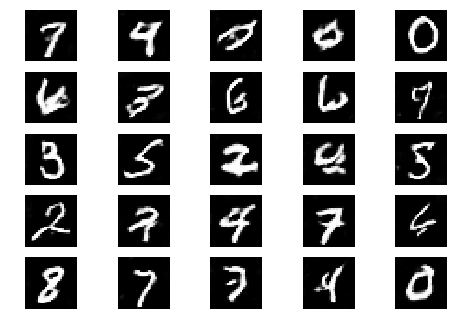

Epoch 6 Batch 1451/1875 [D loss: 0.578069, acc.: 78.12%] [G loss: 0.871371]
Epoch 6 Batch 1452/1875 [D loss: 0.525118, acc.: 71.88%] [G loss: 0.937226]
Epoch 6 Batch 1453/1875 [D loss: 0.731899, acc.: 53.12%] [G loss: 0.805404]
Epoch 6 Batch 1454/1875 [D loss: 0.673986, acc.: 62.50%] [G loss: 0.954383]
Epoch 6 Batch 1455/1875 [D loss: 0.629324, acc.: 53.12%] [G loss: 0.892159]
Epoch 6 Batch 1456/1875 [D loss: 0.747125, acc.: 56.25%] [G loss: 0.852818]
Epoch 6 Batch 1457/1875 [D loss: 0.668145, acc.: 53.12%] [G loss: 0.943970]
Epoch 6 Batch 1458/1875 [D loss: 0.608618, acc.: 68.75%] [G loss: 0.879459]
Epoch 6 Batch 1459/1875 [D loss: 0.586311, acc.: 68.75%] [G loss: 0.961465]
Epoch 6 Batch 1460/1875 [D loss: 0.733092, acc.: 53.12%] [G loss: 0.886305]
Epoch 6 Batch 1461/1875 [D loss: 0.580808, acc.: 75.00%] [G loss: 0.992646]
Epoch 6 Batch 1462/1875 [D loss: 0.759021, acc.: 56.25%] [G loss: 0.783743]
Epoch 6 Batch 1463/1875 [D loss: 0.684620, acc.: 56.25%] [G loss: 0.742521]
Epoch 6 Batc

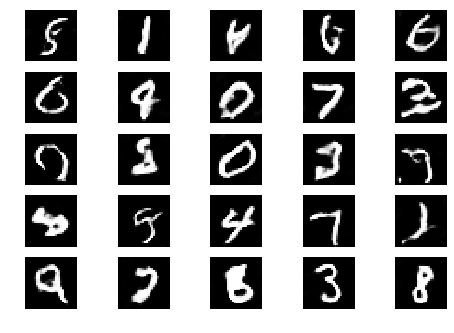

Epoch 6 Batch 1501/1875 [D loss: 0.785161, acc.: 43.75%] [G loss: 0.947532]
Epoch 6 Batch 1502/1875 [D loss: 0.614218, acc.: 65.62%] [G loss: 0.954049]
Epoch 6 Batch 1503/1875 [D loss: 0.637670, acc.: 71.88%] [G loss: 0.913565]
Epoch 6 Batch 1504/1875 [D loss: 0.636952, acc.: 62.50%] [G loss: 0.942912]
Epoch 6 Batch 1505/1875 [D loss: 0.752942, acc.: 46.88%] [G loss: 0.816351]
Epoch 6 Batch 1506/1875 [D loss: 0.657970, acc.: 62.50%] [G loss: 0.887550]
Epoch 6 Batch 1507/1875 [D loss: 0.587592, acc.: 75.00%] [G loss: 0.815944]
Epoch 6 Batch 1508/1875 [D loss: 0.627455, acc.: 62.50%] [G loss: 0.813234]
Epoch 6 Batch 1509/1875 [D loss: 0.639145, acc.: 65.62%] [G loss: 0.805056]
Epoch 6 Batch 1510/1875 [D loss: 0.683317, acc.: 56.25%] [G loss: 0.844254]
Epoch 6 Batch 1511/1875 [D loss: 0.532191, acc.: 90.62%] [G loss: 0.845351]
Epoch 6 Batch 1512/1875 [D loss: 0.749518, acc.: 40.62%] [G loss: 1.073591]
Epoch 6 Batch 1513/1875 [D loss: 0.720265, acc.: 56.25%] [G loss: 0.703132]
Epoch 6 Batc

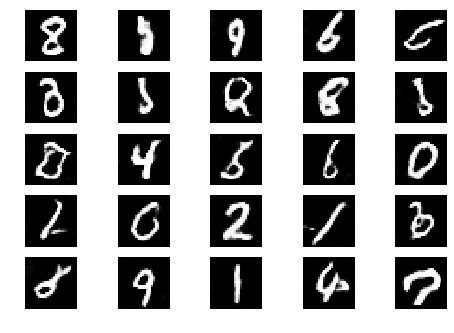

Epoch 6 Batch 1551/1875 [D loss: 0.654851, acc.: 62.50%] [G loss: 0.982705]
Epoch 6 Batch 1552/1875 [D loss: 0.552330, acc.: 75.00%] [G loss: 0.825799]
Epoch 6 Batch 1553/1875 [D loss: 0.660766, acc.: 62.50%] [G loss: 0.864757]
Epoch 6 Batch 1554/1875 [D loss: 0.577981, acc.: 65.62%] [G loss: 0.873278]
Epoch 6 Batch 1555/1875 [D loss: 0.661425, acc.: 68.75%] [G loss: 0.797289]
Epoch 6 Batch 1556/1875 [D loss: 0.656832, acc.: 65.62%] [G loss: 0.787340]
Epoch 6 Batch 1557/1875 [D loss: 0.651590, acc.: 65.62%] [G loss: 0.894484]
Epoch 6 Batch 1558/1875 [D loss: 0.622890, acc.: 65.62%] [G loss: 0.798942]
Epoch 6 Batch 1559/1875 [D loss: 0.782329, acc.: 53.12%] [G loss: 0.920506]
Epoch 6 Batch 1560/1875 [D loss: 0.666487, acc.: 56.25%] [G loss: 1.002220]
Epoch 6 Batch 1561/1875 [D loss: 0.595364, acc.: 65.62%] [G loss: 0.836651]
Epoch 6 Batch 1562/1875 [D loss: 0.641102, acc.: 68.75%] [G loss: 0.914155]
Epoch 6 Batch 1563/1875 [D loss: 0.738939, acc.: 46.88%] [G loss: 0.811896]
Epoch 6 Batc

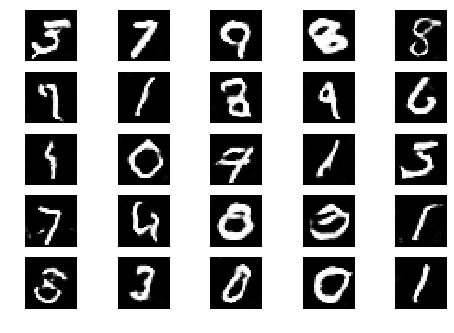

Epoch 6 Batch 1601/1875 [D loss: 0.545905, acc.: 75.00%] [G loss: 0.958226]
Epoch 6 Batch 1602/1875 [D loss: 0.625620, acc.: 65.62%] [G loss: 0.734681]
Epoch 6 Batch 1603/1875 [D loss: 0.630717, acc.: 71.88%] [G loss: 0.868430]
Epoch 6 Batch 1604/1875 [D loss: 0.709643, acc.: 65.62%] [G loss: 0.912946]
Epoch 6 Batch 1605/1875 [D loss: 0.682574, acc.: 59.38%] [G loss: 1.015359]
Epoch 6 Batch 1606/1875 [D loss: 0.686958, acc.: 59.38%] [G loss: 0.854327]
Epoch 6 Batch 1607/1875 [D loss: 0.735691, acc.: 53.12%] [G loss: 0.977740]
Epoch 6 Batch 1608/1875 [D loss: 0.525659, acc.: 78.12%] [G loss: 0.825463]
Epoch 6 Batch 1609/1875 [D loss: 0.827573, acc.: 40.62%] [G loss: 1.003289]
Epoch 6 Batch 1610/1875 [D loss: 0.605086, acc.: 71.88%] [G loss: 0.834047]
Epoch 6 Batch 1611/1875 [D loss: 0.631952, acc.: 68.75%] [G loss: 1.022774]
Epoch 6 Batch 1612/1875 [D loss: 0.573304, acc.: 75.00%] [G loss: 1.007555]
Epoch 6 Batch 1613/1875 [D loss: 0.710941, acc.: 59.38%] [G loss: 0.916105]
Epoch 6 Batc

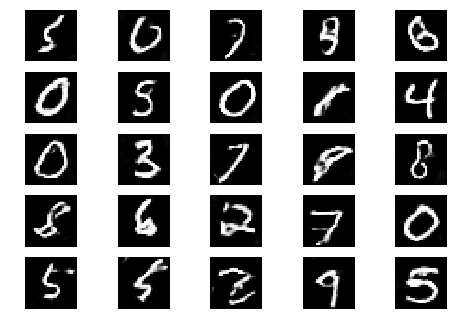

Epoch 6 Batch 1651/1875 [D loss: 0.669961, acc.: 53.12%] [G loss: 0.939823]
Epoch 6 Batch 1652/1875 [D loss: 0.786885, acc.: 40.62%] [G loss: 0.825491]
Epoch 6 Batch 1653/1875 [D loss: 0.704914, acc.: 46.88%] [G loss: 1.000631]
Epoch 6 Batch 1654/1875 [D loss: 0.565419, acc.: 81.25%] [G loss: 0.803682]
Epoch 6 Batch 1655/1875 [D loss: 0.878789, acc.: 31.25%] [G loss: 0.917166]
Epoch 6 Batch 1656/1875 [D loss: 0.693690, acc.: 59.38%] [G loss: 0.836623]
Epoch 6 Batch 1657/1875 [D loss: 0.525736, acc.: 78.12%] [G loss: 0.911896]
Epoch 6 Batch 1658/1875 [D loss: 0.606355, acc.: 71.88%] [G loss: 0.850415]
Epoch 6 Batch 1659/1875 [D loss: 0.705009, acc.: 50.00%] [G loss: 0.911929]
Epoch 6 Batch 1660/1875 [D loss: 0.705008, acc.: 37.50%] [G loss: 0.796383]
Epoch 6 Batch 1661/1875 [D loss: 0.719082, acc.: 50.00%] [G loss: 0.866453]
Epoch 6 Batch 1662/1875 [D loss: 0.560129, acc.: 75.00%] [G loss: 0.871534]
Epoch 6 Batch 1663/1875 [D loss: 0.605740, acc.: 68.75%] [G loss: 0.977245]
Epoch 6 Batc

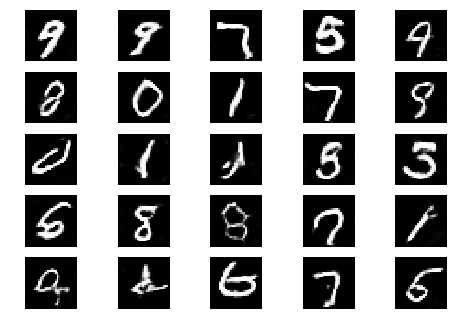

Epoch 6 Batch 1701/1875 [D loss: 0.813016, acc.: 43.75%] [G loss: 0.918061]
Epoch 6 Batch 1702/1875 [D loss: 0.647272, acc.: 65.62%] [G loss: 0.932259]
Epoch 6 Batch 1703/1875 [D loss: 0.819831, acc.: 34.38%] [G loss: 0.892636]
Epoch 6 Batch 1704/1875 [D loss: 0.758022, acc.: 37.50%] [G loss: 0.740692]
Epoch 6 Batch 1705/1875 [D loss: 0.728693, acc.: 59.38%] [G loss: 0.844405]
Epoch 6 Batch 1706/1875 [D loss: 0.604073, acc.: 68.75%] [G loss: 0.896849]
Epoch 6 Batch 1707/1875 [D loss: 0.888429, acc.: 31.25%] [G loss: 0.775536]
Epoch 6 Batch 1708/1875 [D loss: 0.675966, acc.: 59.38%] [G loss: 0.941920]
Epoch 6 Batch 1709/1875 [D loss: 0.561754, acc.: 75.00%] [G loss: 0.971277]
Epoch 6 Batch 1710/1875 [D loss: 0.795198, acc.: 40.62%] [G loss: 1.003808]
Epoch 6 Batch 1711/1875 [D loss: 0.677649, acc.: 59.38%] [G loss: 1.025057]
Epoch 6 Batch 1712/1875 [D loss: 0.677632, acc.: 62.50%] [G loss: 1.083900]
Epoch 6 Batch 1713/1875 [D loss: 0.726118, acc.: 46.88%] [G loss: 1.030967]
Epoch 6 Batc

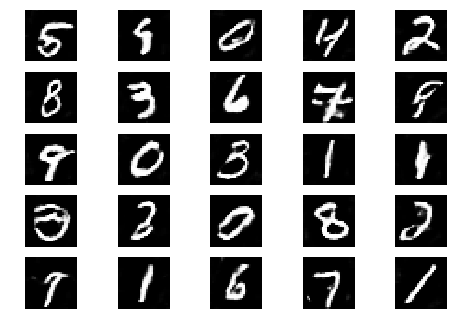

Epoch 6 Batch 1751/1875 [D loss: 0.715599, acc.: 53.12%] [G loss: 0.771625]
Epoch 6 Batch 1752/1875 [D loss: 0.716182, acc.: 50.00%] [G loss: 0.761523]
Epoch 6 Batch 1753/1875 [D loss: 0.703776, acc.: 56.25%] [G loss: 0.909829]
Epoch 6 Batch 1754/1875 [D loss: 0.651046, acc.: 68.75%] [G loss: 0.777299]
Epoch 6 Batch 1755/1875 [D loss: 0.700028, acc.: 53.12%] [G loss: 0.753092]
Epoch 6 Batch 1756/1875 [D loss: 0.660092, acc.: 59.38%] [G loss: 0.888283]
Epoch 6 Batch 1757/1875 [D loss: 0.450903, acc.: 84.38%] [G loss: 0.863174]
Epoch 6 Batch 1758/1875 [D loss: 0.766880, acc.: 56.25%] [G loss: 0.958090]
Epoch 6 Batch 1759/1875 [D loss: 0.561588, acc.: 71.88%] [G loss: 0.704216]
Epoch 6 Batch 1760/1875 [D loss: 0.672091, acc.: 56.25%] [G loss: 0.897299]
Epoch 6 Batch 1761/1875 [D loss: 0.740398, acc.: 56.25%] [G loss: 0.969056]
Epoch 6 Batch 1762/1875 [D loss: 0.722959, acc.: 50.00%] [G loss: 0.938007]
Epoch 6 Batch 1763/1875 [D loss: 0.630925, acc.: 68.75%] [G loss: 0.781091]
Epoch 6 Batc

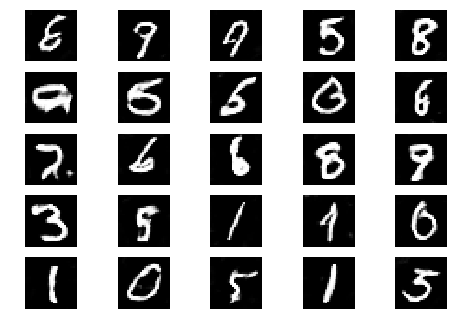

Epoch 6 Batch 1801/1875 [D loss: 0.690305, acc.: 53.12%] [G loss: 0.781854]
Epoch 6 Batch 1802/1875 [D loss: 0.764326, acc.: 46.88%] [G loss: 0.827318]
Epoch 6 Batch 1803/1875 [D loss: 0.684786, acc.: 56.25%] [G loss: 0.748847]
Epoch 6 Batch 1804/1875 [D loss: 0.641000, acc.: 62.50%] [G loss: 0.847238]
Epoch 6 Batch 1805/1875 [D loss: 0.538997, acc.: 81.25%] [G loss: 1.088531]
Epoch 6 Batch 1806/1875 [D loss: 0.657767, acc.: 50.00%] [G loss: 0.899916]
Epoch 6 Batch 1807/1875 [D loss: 0.699097, acc.: 53.12%] [G loss: 0.953898]
Epoch 6 Batch 1808/1875 [D loss: 0.650786, acc.: 56.25%] [G loss: 0.915972]
Epoch 6 Batch 1809/1875 [D loss: 0.808545, acc.: 40.62%] [G loss: 0.776257]
Epoch 6 Batch 1810/1875 [D loss: 0.688837, acc.: 56.25%] [G loss: 0.786958]
Epoch 6 Batch 1811/1875 [D loss: 0.548070, acc.: 71.88%] [G loss: 0.741680]
Epoch 6 Batch 1812/1875 [D loss: 0.693690, acc.: 50.00%] [G loss: 0.754353]
Epoch 6 Batch 1813/1875 [D loss: 0.539679, acc.: 81.25%] [G loss: 0.752785]
Epoch 6 Batc

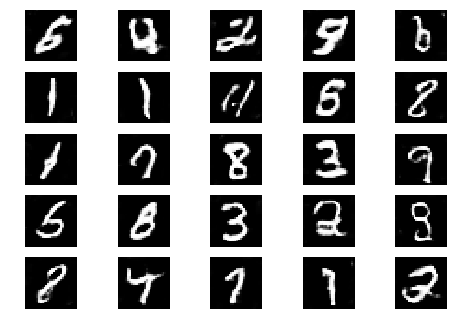

Epoch 6 Batch 1851/1875 [D loss: 0.686806, acc.: 56.25%] [G loss: 0.886748]
Epoch 6 Batch 1852/1875 [D loss: 0.677430, acc.: 62.50%] [G loss: 0.871195]
Epoch 6 Batch 1853/1875 [D loss: 0.672630, acc.: 68.75%] [G loss: 1.129439]
Epoch 6 Batch 1854/1875 [D loss: 0.652213, acc.: 53.12%] [G loss: 1.009967]
Epoch 6 Batch 1855/1875 [D loss: 0.521005, acc.: 81.25%] [G loss: 0.999486]
Epoch 6 Batch 1856/1875 [D loss: 0.673187, acc.: 53.12%] [G loss: 0.725574]
Epoch 6 Batch 1857/1875 [D loss: 0.844773, acc.: 37.50%] [G loss: 0.757859]
Epoch 6 Batch 1858/1875 [D loss: 0.698770, acc.: 43.75%] [G loss: 0.902755]
Epoch 6 Batch 1859/1875 [D loss: 0.593529, acc.: 68.75%] [G loss: 0.923000]
Epoch 6 Batch 1860/1875 [D loss: 0.707278, acc.: 53.12%] [G loss: 0.918508]
Epoch 6 Batch 1861/1875 [D loss: 0.578336, acc.: 65.62%] [G loss: 0.891192]
Epoch 6 Batch 1862/1875 [D loss: 0.569209, acc.: 78.12%] [G loss: 1.063891]
Epoch 6 Batch 1863/1875 [D loss: 0.790064, acc.: 43.75%] [G loss: 0.947652]
Epoch 6 Batc

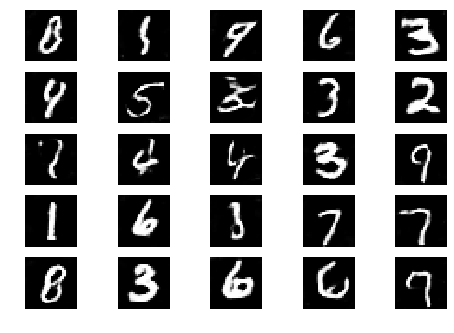

Epoch 7 Batch 1/1875 [D loss: 0.581494, acc.: 65.62%] [G loss: 0.931703]
Epoch 7 Batch 2/1875 [D loss: 0.684986, acc.: 53.12%] [G loss: 0.935163]
Epoch 7 Batch 3/1875 [D loss: 0.619074, acc.: 71.88%] [G loss: 0.870052]
Epoch 7 Batch 4/1875 [D loss: 0.717882, acc.: 46.88%] [G loss: 0.877448]
Epoch 7 Batch 5/1875 [D loss: 0.628944, acc.: 68.75%] [G loss: 0.783568]
Epoch 7 Batch 6/1875 [D loss: 0.737798, acc.: 62.50%] [G loss: 0.973980]
Epoch 7 Batch 7/1875 [D loss: 0.728638, acc.: 59.38%] [G loss: 0.820735]
Epoch 7 Batch 8/1875 [D loss: 0.669425, acc.: 65.62%] [G loss: 0.769578]
Epoch 7 Batch 9/1875 [D loss: 0.459207, acc.: 87.50%] [G loss: 0.909727]
Epoch 7 Batch 10/1875 [D loss: 0.803396, acc.: 43.75%] [G loss: 1.017437]
Epoch 7 Batch 11/1875 [D loss: 0.702504, acc.: 53.12%] [G loss: 0.813797]
Epoch 7 Batch 12/1875 [D loss: 0.757433, acc.: 50.00%] [G loss: 1.074408]
Epoch 7 Batch 13/1875 [D loss: 0.709135, acc.: 59.38%] [G loss: 0.868849]
Epoch 7 Batch 14/1875 [D loss: 0.630648, acc.: 

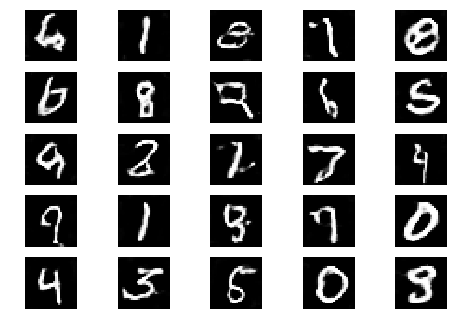

Epoch 7 Batch 51/1875 [D loss: 0.824521, acc.: 34.38%] [G loss: 0.793265]
Epoch 7 Batch 52/1875 [D loss: 0.548478, acc.: 71.88%] [G loss: 0.890408]
Epoch 7 Batch 53/1875 [D loss: 0.567471, acc.: 68.75%] [G loss: 0.836079]
Epoch 7 Batch 54/1875 [D loss: 0.672308, acc.: 59.38%] [G loss: 0.646920]
Epoch 7 Batch 55/1875 [D loss: 0.654087, acc.: 68.75%] [G loss: 0.688608]
Epoch 7 Batch 56/1875 [D loss: 0.553517, acc.: 75.00%] [G loss: 0.794900]
Epoch 7 Batch 57/1875 [D loss: 0.705396, acc.: 59.38%] [G loss: 0.772426]
Epoch 7 Batch 58/1875 [D loss: 0.729087, acc.: 43.75%] [G loss: 0.737656]
Epoch 7 Batch 59/1875 [D loss: 0.627115, acc.: 62.50%] [G loss: 0.832211]
Epoch 7 Batch 60/1875 [D loss: 0.639184, acc.: 59.38%] [G loss: 0.843215]
Epoch 7 Batch 61/1875 [D loss: 0.566110, acc.: 65.62%] [G loss: 0.916273]
Epoch 7 Batch 62/1875 [D loss: 0.645288, acc.: 65.62%] [G loss: 0.827034]
Epoch 7 Batch 63/1875 [D loss: 0.616826, acc.: 65.62%] [G loss: 0.707000]
Epoch 7 Batch 64/1875 [D loss: 0.66426

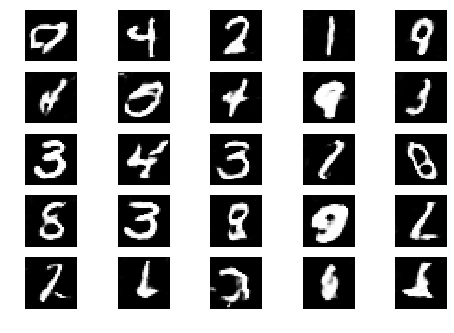

Epoch 7 Batch 101/1875 [D loss: 0.662238, acc.: 59.38%] [G loss: 1.022772]
Epoch 7 Batch 102/1875 [D loss: 0.562683, acc.: 62.50%] [G loss: 1.025462]
Epoch 7 Batch 103/1875 [D loss: 0.665573, acc.: 62.50%] [G loss: 0.807725]
Epoch 7 Batch 104/1875 [D loss: 0.666202, acc.: 56.25%] [G loss: 0.949647]
Epoch 7 Batch 105/1875 [D loss: 0.696657, acc.: 59.38%] [G loss: 0.897567]
Epoch 7 Batch 106/1875 [D loss: 0.741002, acc.: 53.12%] [G loss: 0.790051]
Epoch 7 Batch 107/1875 [D loss: 0.735973, acc.: 46.88%] [G loss: 0.868748]
Epoch 7 Batch 108/1875 [D loss: 0.595456, acc.: 75.00%] [G loss: 0.873242]
Epoch 7 Batch 109/1875 [D loss: 0.802194, acc.: 46.88%] [G loss: 0.804638]
Epoch 7 Batch 110/1875 [D loss: 0.635092, acc.: 71.88%] [G loss: 0.922074]
Epoch 7 Batch 111/1875 [D loss: 0.593167, acc.: 62.50%] [G loss: 0.972336]
Epoch 7 Batch 112/1875 [D loss: 0.716376, acc.: 56.25%] [G loss: 1.165733]
Epoch 7 Batch 113/1875 [D loss: 0.588075, acc.: 75.00%] [G loss: 1.016987]
Epoch 7 Batch 114/1875 [D

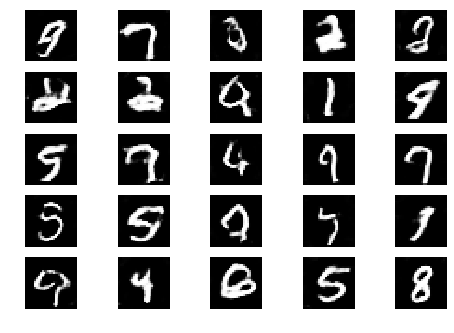

Epoch 7 Batch 151/1875 [D loss: 0.566481, acc.: 75.00%] [G loss: 0.783255]
Epoch 7 Batch 152/1875 [D loss: 0.757399, acc.: 53.12%] [G loss: 0.940995]
Epoch 7 Batch 153/1875 [D loss: 0.694806, acc.: 59.38%] [G loss: 0.868634]
Epoch 7 Batch 154/1875 [D loss: 0.659723, acc.: 68.75%] [G loss: 0.948166]


KeyboardInterrupt: ignored

In [12]:
if __name__ == '__main__':
    main()

In [0]:

##encodermodel = build_generator()
##encodermodel.summary()

##noise = np.random.normal(0, 1, (50, 100))
##fake_images = encodermodel.predict(noise)


In [0]:
##encodermodel.predict(inputnoise)